# Senadores - EDA e modelo produção parlamentar

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 8))
import janitor

import datetime

import sqlite3 as sql

from sklearn.cluster import KMeans
from numpy import unique
from numpy import where

#nomalizing data to its std (x_new= x/std(x))
from scipy.cluster.vq import whiten

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity="all"

## EDA Básico

In [2]:
!ls ../../dados/sql

base_completa.db  Normalização_03.ipynb


In [3]:
#Dados de parlamentares
con = sql.connect("../../dados/sql/base_completa.db")
df_sen=pd.read_sql("select * from senadores_cadastro",con)
df_sen_prop=pd.read_sql("select * from senadores_propostas",con)
df_sen_sess=pd.read_sql("select * from senadores_sessoes",con)
df_sen_voto=pd.read_sql("select * from senadores_votacoes",con)
df_diap=pd.read_sql("select * from diap",con)
con.close()

In [4]:
#df_sen.info()
#df_diap.info()

In [5]:
df_sen.drop(columns=["NM_CANDIDATO_y","NM_CANDIDATO_x","NM_MUNICIPIO_NASCIMENTO","SQ_CANDIDATO",
                           "IDADE","NM_EMAIL","URL_SENADO","FOTO_URI","URL_PARTICULAR"], inplace=True)

In [6]:
#df_sen.sample(5)

In [7]:
#df_sen_prop.shape
#df_sen_prop.info()
#df_sen_prop.head()

## Percentual de cada tipo de proposta

In [8]:
df_prop_tipos=pd.DataFrame(df_sen_prop["TIPO_DESC"].value_counts())
df_prop_tipos.rename(columns={"TIPO_DESC":"QUANT"}, inplace=True)
df_prop_tipos.index.name="TIPO_DESC"
df_prop_tipos

QUANT
TIPO_DESC                                 
REQUERIMENTO                          1138
PROJETO DE LEI                         703
PROPOSTA DE EMENDA À CONSTITUIÇÃO       71
PROJETO DE RESOLUÇÃO DO SENADO          56
PROJETO DE LEI COMPLEMENTAR             51
PROJETO DE DECRETO LEGISLATIVO          34
PROPOSTA DE FISCALIZAÇÃO E CONTROLE      2
OFICIO "S"                               2
PETIÇÃO (SF)                             1
INDICAÇÃO                                1
ATO DO PRESIDENTE DO SENADO FEDERAL      1
RECURSO (SF)                             1

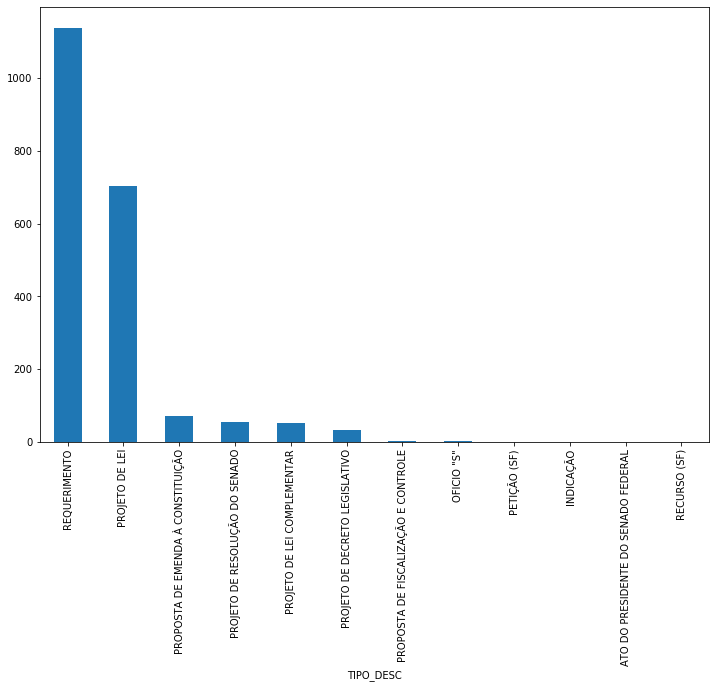

In [9]:
f = lambda x: x/x.sum()
df_prop_tipos["PERC"]=df_prop_tipos.apply(f)
df_prop_tipos["QUANT"].plot(kind="bar")

## Sessões parlamentares com votacção

In [10]:
df_sen_sess["SESSAO_DATA"]=df_sen_sess["SESSAO_DATA"].apply(lambda x:datetime.datetime.strptime(x, '%Y-%m-%d'))

In [11]:
#df_sen_sess.info()

In [12]:
# Ajusta colunas e nomes
df_sen_sess=df_sen_sess[["SESSAO_DATA","SESSAO","SESSAO_TIPO","SESSAO_DESCRICAO"]]
df_sen_sess.rename({"SESSAO_DESCRICAO":"SESSAO_DESC"}, axis=1, inplace=True)
#df_sen_sess.tail()

In [13]:
#df_sen_sess[df_sen_sess["SESSAO"]==86315]

In [14]:
df_sen_voto["SESSAO"]=df_sen_voto["SESSAO"].astype("object")
df_sen_sess["SESSAO"]=df_sen_sess["SESSAO"].astype("object")
#df_sen_voto.info()
#df_sen_sess.info()
                                        

In [15]:
#sessao=df_sen_voto["SESSAO"]=="192306"
#senador=df_sen_voto["ID_SENADO"]=="1023"
#df_sen_voto[(sessao & senador)]

## Percentual de cada tipo de sessão

In [16]:
#df_sen_sess.info()
#df_sen_sess["SESSAO_DESC"].value_counts()
df_sess_tipos=pd.DataFrame(df_sen_sess["SESSAO_DESC"].value_counts())
df_sess_tipos

SESSAO_DESC
Sessão Deliberativa Ordinária               224
Sessão Deliberativa Remota                  182
Sessão Deliberativa Extraordinária            9

In [17]:
df_sess_tipos.rename(columns={"SESSAO_DESC":"QUANT"}, inplace=True)
df_sess_tipos.index.name="TIPO_DESC"
df_sess_tipos

QUANT
TIPO_DESC                                
Sessão Deliberativa Ordinária         224
Sessão Deliberativa Remota            182
Sessão Deliberativa Extraordinária      9

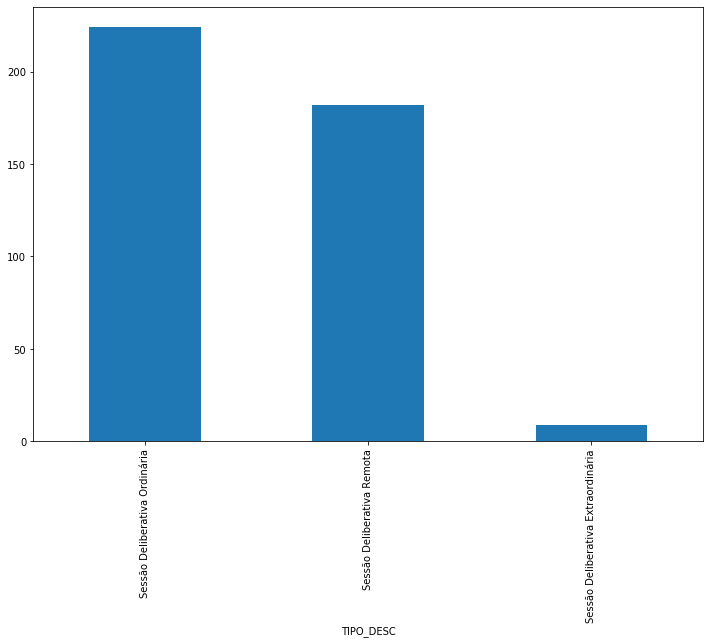

In [18]:
f = lambda x: x/x.sum()
df_sess_tipos["PERC"]=df_sess_tipos.apply(f)
df_sess_tipos["QUANT"].plot(kind="bar")

In [19]:
#df_sen_sess.info()
#df_sen_voto.info()

## Para cada senador

### Total de propostas

pandas.core.series.Series

TIPO       ATS  INS  OFS  PDL  PEC  PET  PFS    PL  PLP  PRS  R.S   REQ   RQS  \
ID_SENADO                                                                       
825        0.0  0.0  0.0  0.0  1.0  0.0  0.0  12.0  0.0  0.0  0.0  48.0  23.0   
5012       0.0  0.0  0.0  5.0  2.0  0.0  0.0  12.0  2.0  3.0  0.0  23.0  24.0   
4770       0.0  0.0  0.0  0.0  2.0  0.0  0.0  11.0  1.0  3.0  0.0  30.0  21.0   
5953       0.0  0.0  0.0  3.0  3.0  0.0  0.0  28.0  0.0  1.0  0.0  21.0   8.0   
5748       0.0  0.0  0.0  0.0  4.0  0.0  0.0  41.0  2.0  0.0  0.0   9.0   8.0   

TIPO       PROP_TOTAL  
ID_SENADO              
825              84.0  
5012             71.0  
4770             68.0  
5953             64.0  
5748             64.0

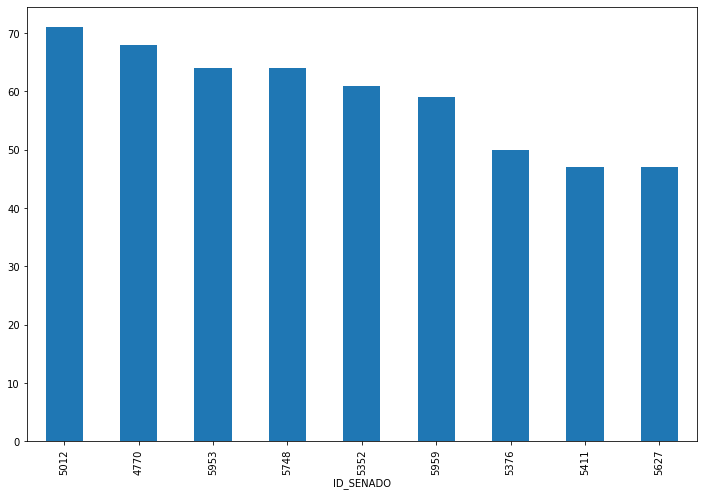

In [20]:
x=df_sen_prop.groupby("ID_SENADO")["TIPO"].value_counts()
type(x)
df_sen_prop_tipos=x.unstack().fillna(0)
df_sen_prop_tipos["PROP_TOTAL"]=df_sen_prop_tipos.sum(axis=1)

df_sen_prop_tipos.sort_values("PROP_TOTAL", inplace=True, ascending=False)
df_sen_prop_tipos.head()
df_sen_prop_tipos["PROP_TOTAL"].iloc[1:10].plot(kind="bar")

In [21]:
#df_sen_prop_tipos=df_sen_prop_tipos[["REQ","PEC","PL","PROP_TOTAL"]]

In [22]:
df_sen_prod=pd.merge(df_sen,df_sen_prop_tipos, how="left", on="ID_SENADO")
#df_sen_prod.info()

### Total de votações

pandas.core.series.Series

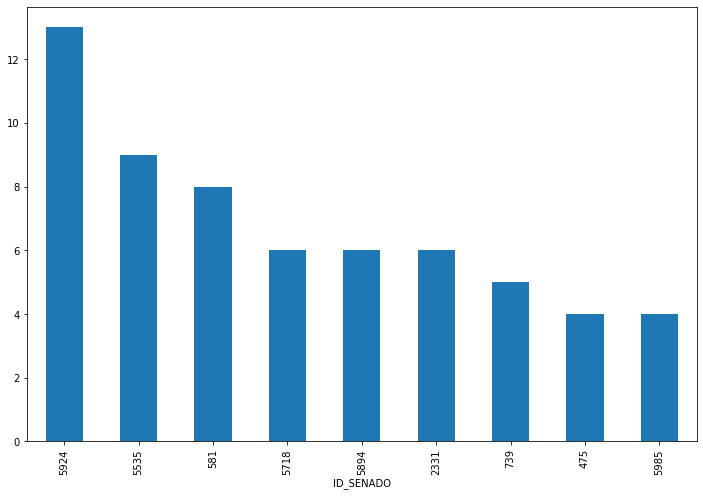

In [23]:
x=df_sen_voto.groupby("ID_SENADO")["VOTO"].value_counts()
type(x)
df_sen_voto_tipos=x.unstack().fillna(0)
df_sen_voto_tipos["VOTO_TOTAL"]=df_sen_voto_tipos.sum(axis=1)
df_sen_voto_tipos=df_sen_voto_tipos.sort_values("NCom", ascending=False)
df_sen_voto_tipos["NCom"].iloc[1:10].plot(kind="bar")
df_sen_voto_tipos["AUSENCIA"]=df_sen_voto_tipos["NCom"]/df_sen_voto_tipos["VOTO_TOTAL"]
df_sen_voto_tipos["PRESENCA"]=1-df_sen_voto_tipos["AUSENCIA"]
#df_sen_voto_tipos.head()

In [24]:
df_sen_assid=df_sen_voto_tipos[["PRESENCA","AUSENCIA"]]

In [25]:
df_sen_prod=pd.merge(df_sen_prod,df_sen_assid, how="left", on="ID_SENADO")
#df_sen_prod.info()

In [26]:
df=pd.merge(df_sen_prod,df_diap, how="left", on="CPF")
#df=df_sen_prod

In [27]:
df.info()
df.fillna(0, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 0 to 78
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    79 non-null     object 
 1   DT_NASCIMENTO          79 non-null     object 
 2   SG_UF_NASCIMENTO       79 non-null     object 
 3   DS_GENERO              79 non-null     object 
 4   DS_GRAU_INSTRUCAO      79 non-null     object 
 5   DS_ESTADO_CIVIL        79 non-null     object 
 6   DS_COR_RACA            79 non-null     object 
 7   DS_OCUPACAO            79 non-null     object 
 8   VL_BENS                79 non-null     float64
 9   ANO_ELEICAO            79 non-null     int64  
 10  DS_CARGO               79 non-null     object 
 11  SG_PARTIDO             79 non-null     object 
 12  SG_UE                  79 non-null     object 
 13  NM_URNA_CANDIDATO      79 non-null     object 
 14  VR_DESPESA_CONTRATADA  79 non-null     float64
 15  follower

In [28]:
df.sort_values("PROP_TOTAL",ascending=False,inplace=True)
df[["CPF","NM_URNA_CANDIDATO","MESA","LIDERANCA","cabeças","REQ","PRS","PEC","PL","PROP_TOTAL"]][df["PROP_TOTAL"]>10]

CPF            NM_URNA_CANDIDATO MESA LIDERANCA  cabeças   REQ  \
39  11062975049                   PAULO PAIM  Não       Não     26.0  48.0   
63  43187943268                    RANDOLFE   Não       Sim      9.0  23.0   
41  06801480197                       IZALCI  Não       Sim      0.0  30.0   
43  71346376468                    VENEZIANO  Não       Sim      4.0   9.0   
29  86364561772            FABIANO CONTARATO  Não       Sim      0.0  21.0   
49  41168720591      ROGERIO CARVALHO SANTOS  Não       Sim      1.0  31.0   
62  01195796420            CAPITAO STYVENSON  Não       Não      0.0  18.0   
59  24731270855                MARA GABRILLI  Não       Não      0.0   8.0   
52  62929399368                     WEVERTON  Sim       Sim      4.0   5.0   
55  15288455449               HUMBERTO COSTA  Não       Não     11.0   7.0   
3   00274003953                  ALVARO DIAS  Não       Sim      0.0   0.0   
76  60838965172             SORAYA THRONICKE  Não       Sim      0.0  25.0   
67  85632406687               LEILA DO VOLEI  Sim       Não      0.0  11.0   
77  01720486727                MARCOS DO VAL  Sim       Não      0.0  11.0   
32  40448118149                NELSINHO TRAD  Não       Não      0.0  20.0   
9   37967517768              ROSE DE FREITAS  Não       Sim      0.0   5.0   
71  18516440915                  FLAVIO ARNS  Não       Não      0.0  17.0   
51  21840571187                 JORGE KAJURU  Não       Não      0.0  10.0   
54  75242788372                ELIZIANE GAMA  Não       Sim      0.0   9.0   
38  07654871449              CHICO RODRIGUES  Não       Sim      0.0   7.0   
60  25084119904               JORGINHO MELLO  Não       Sim      0.0   3.0   
53  71943790582   DELEGADO ALESSANDRO VIEIRA  Não       Sim      0.0  14.0   
36  31966810334                EDUARDO GIRAO  Não       Sim      0.0  17.0   
31  00987752430                RODRIGO CUNHA  Não       Sim      0.0  17.0   
0   23019093104          WELLINGTON FAGUNDES  Não       Sim      0.0  19.0   
5   90671953753                      ROMARIO  Não       Não      0.0  22.0   
73  00502302801                MAJOR OLIMPIO  Não       Sim      1.0   5.0   
33  26471620772                JAQUES WAGNER  Sim       Não      9.0  15.0   
44  07810423215                EDUARDO BRAGA  Não       Sim      6.0   6.0   
6   01077887809      FERNANDO BEZERRA COELHO  Não       Sim      2.0   5.0   
72  14272954091           LUIS CARLOS HEINZE  Sim       Não      0.0   8.0   
25  01124552049               LASIER MARTINS  Sim       Não      0.0   7.0   
58  23796332153                MARCIO BITTAR  Não       Sim      0.0  10.0   
64  00445689676              RODRIGO PACHECO  Não       Sim      2.0   5.0   
70  03733831187               CONFUCIO MOURA  Não       Não      0.0   8.0   
20  25056956368                ROBERTO ROCHA  Não       Sim      1.0   2.0   
35  06651127268             ZEQUINHA MARINHO  Não       Sim      0.0   7.0   
27  77865111568               ANGELO CORONEL  Não       Sim      0.0  13.0   
18  61330345134                  KATIA ABREU  Não       Não      0.0  12.0   
68  31340261120                EDUARDO GOMES  Sim       Sim      6.0   8.0   
26  47555882604            ANTONIO ANASTASIA  Sim       Não      5.0   3.0   
65  34190392391                CIRO NOGUEIRA  Não       Sim      5.0   4.0   
37  12352993415             DR. ZENAIDE MAIA  Não       Sim      0.0  12.0   
42  08701122797             FLAVIO BOLSONARO  Sim       Não      1.0   0.0   
28  14464969291                    VANDERLAN  Não       Não      0.0   9.0   
10  44435630915                 ACIR GURGACZ  Não       Não      0.0   5.0   
46  60232064253               MARCOS ROGERIO  Não       Sim      1.0   9.0   
66  11268786934              ESPERIDIAO AMIN  Não       Sim      8.0   8.0   
56  02382091304               MARCELO CASTRO  Não       Não      1.0   6.0   
78  03537250215               PLINIO VALERIO  Não       Não      0.0   2.0   
21  04273230291                TEL

In [29]:
hoje=datetime.datetime.now()
df["IDADE"]=df["DT_NASCIMENTO"].apply(lambda x:(hoje-datetime.datetime.strptime(x, '%d/%m/%Y')).days//(365.25))

In [30]:
#df.sample(5)

In [31]:
#df.columns

In [32]:
#df.columns
df.drop(columns="DS_CARGO", axis=1, inplace=True)

In [33]:
#df.shape
#df.info()
#df.sample(10)

In [34]:
#df.info()
#df.describe().round(2)

In [35]:
#df.fillna(0, inplace=True)
#df.info()

In [36]:
#df.describe(include=np.object)

In [37]:
df.info()
unicos=df.nunique()
unicos

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 39 to 16
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   CPF                    79 non-null     object 
 1   DT_NASCIMENTO          79 non-null     object 
 2   SG_UF_NASCIMENTO       79 non-null     object 
 3   DS_GENERO              79 non-null     object 
 4   DS_GRAU_INSTRUCAO      79 non-null     object 
 5   DS_ESTADO_CIVIL        79 non-null     object 
 6   DS_COR_RACA            79 non-null     object 
 7   DS_OCUPACAO            79 non-null     object 
 8   VL_BENS                79 non-null     float64
 9   ANO_ELEICAO            79 non-null     int64  
 10  SG_PARTIDO             79 non-null     object 
 11  SG_UE                  79 non-null     object 
 12  NM_URNA_CANDIDATO      79 non-null     object 
 13  VR_DESPESA_CONTRATADA  79 non-null     float64
 14  followers_count        79 non-null     float64
 15  tweets 

CPF                      79
DT_NASCIMENTO            79
SG_UF_NASCIMENTO         26
DS_GENERO                 2
DS_GRAU_INSTRUCAO         4
DS_ESTADO_CIVIL           5
DS_COR_RACA               3
DS_OCUPACAO              24
VL_BENS                  79
ANO_ELEICAO               2
SG_PARTIDO               21
SG_UE                    27
NM_URNA_CANDIDATO        79
VR_DESPESA_CONTRATADA    79
followers_count          69
tweets                   69
ID_SENADO                77
ID_PUB                   77
MESA                      3
LIDERANCA                 3
ATS                       2
INS                       2
OFS                       2
PDL                       6
PEC                       5
PET                       2
PFS                       2
PL                       28
PLP                       5
PRS                       6
R.S                       2
REQ                      27
RQS                      19
PROP_TOTAL               45
PRESENCA                 21
AUSENCIA            

## Defindo variaveis categóricas numericas

In [38]:
def analisa_variaveis(df,variaveis,nunicas):
    lista=[]
    unicos=df[variaveis].nunique()
    for variavel in unicos.index:
        quant=unicos.loc[variavel]
        if quant <= nunicas:
            lista.append(variavel)
            print("Variavel {}, {} ocorrências únicas".format(variavel,quant))
            print(df[variavel].sort_values().unique())
    return lista

In [39]:
variaveis_numericas= df.select_dtypes(include=[np.number]).columns
df[variaveis_numericas].nunique()

VL_BENS                  79
ANO_ELEICAO               2
VR_DESPESA_CONTRATADA    79
followers_count          69
tweets                   69
ATS                       2
INS                       2
OFS                       2
PDL                       6
PEC                       5
PET                       2
PFS                       2
PL                       28
PLP                       5
PRS                       6
R.S                       2
REQ                      27
RQS                      19
PROP_TOTAL               45
PRESENCA                 21
AUSENCIA                 20
mandatos                  5
cabeças                  13
debatedor                 2
articulador               2
formulador                2
negociador                2
IDADE                    32
dtype: int64

In [40]:
cat_numericas=analisa_variaveis(df,variaveis_numericas,2)
cat_numericas

Variavel ANO_ELEICAO, 2 ocorrências únicas
[2014 2018]
Variavel ATS, 2 ocorrências únicas
[0. 1.]
Variavel INS, 2 ocorrências únicas
[0. 1.]
Variavel OFS, 2 ocorrências únicas
[0. 1.]
Variavel PET, 2 ocorrências únicas
[0. 1.]
Variavel PFS, 2 ocorrências únicas
[0. 1.]
Variavel R.S, 2 ocorrências únicas
[0. 1.]
Variavel debatedor, 2 ocorrências únicas
[0. 1.]
Variavel articulador, 2 ocorrências únicas
[0. 1.]
Variavel formulador, 2 ocorrências únicas
[0. 1.]
Variavel negociador, 2 ocorrências únicas
[0. 1.]


['ANO_ELEICAO',
 'ATS',
 'INS',
 'OFS',
 'PET',
 'PFS',
 'R.S',
 'debatedor',
 'articulador',
 'formulador',
 'negociador']

In [41]:
#variaveis_categoricas.remove("time_spend_company")
cat_numericas.remove("ATS")
cat_numericas.remove("INS")
cat_numericas.remove("OFS")
cat_numericas.remove("PET")
cat_numericas.remove("PFS")
cat_numericas.remove("R.S")


In [42]:
df[cat_numericas].info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 79 entries, 39 to 16
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ANO_ELEICAO  79 non-null     int64  
 1   debatedor    79 non-null     float64
 2   articulador  79 non-null     float64
 3   formulador   79 non-null     float64
 4   negociador   79 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 3.7 KB


In [43]:
variaveis_objeto=df.select_dtypes(include="object").columns
df[variaveis_objeto].nunique()

CPF                  79
DT_NASCIMENTO        79
SG_UF_NASCIMENTO     26
DS_GENERO             2
DS_GRAU_INSTRUCAO     4
DS_ESTADO_CIVIL       5
DS_COR_RACA           3
DS_OCUPACAO          24
SG_PARTIDO           21
SG_UE                27
NM_URNA_CANDIDATO    79
ID_SENADO            77
ID_PUB               77
MESA                  3
LIDERANCA             3
dtype: int64

In [44]:
# Retirandos os senadores eleitos que não estão ativos
df["MESA"].unique()
df["NM_URNA_CANDIDATO"][df["MESA"]==0]
df.shape
df=df[df["MESA"]!=0]

df.shape


array(['Não', 'Sim', 0], dtype=object)

14            FATIMA
4     RONALDO CAIADO
16    GLADSON CAMELI
Name: NM_URNA_CANDIDATO, dtype: object

(79, 43)

(76, 43)

In [45]:
cat_objeto=analisa_variaveis(df,variaveis_objeto,27)
#cat_objeto

Variavel SG_UF_NASCIMENTO, 26 ocorrências únicas
['AC' 'AL' 'AM' 'AP' 'BA' 'CE' 'DF' 'ES' 'GO' 'MA' 'MG' 'MS' 'MT' 'PA'
 'PB' 'PE' 'PI' 'PR' 'RJ' 'RO' 'RR' 'RS' 'SC' 'SE' 'SP' 'TO']
Variavel DS_GENERO, 2 ocorrências únicas
['FEMININO' 'MASCULINO']
Variavel DS_GRAU_INSTRUCAO, 4 ocorrências únicas
['ENSINO FUNDAMENTAL INCOMPLETO' 'ENSINO MÉDIO COMPLETO'
 'SUPERIOR COMPLETO' 'SUPERIOR INCOMPLETO']
Variavel DS_ESTADO_CIVIL, 5 ocorrências únicas
['CASADO(A)' 'DIVORCIADO(A)' 'SEPARADO(A) JUDICIALMENTE' 'SOLTEIRO(A)'
 'VIÚVO(A)']
Variavel DS_COR_RACA, 3 ocorrências únicas
['BRANCA' 'PARDA' 'PRETA']
Variavel DS_OCUPACAO, 24 ocorrências únicas
['ADMINISTRADOR' 'ADVOGADO' 'APOSENTADO (EXCETO SERVIDOR PÚBLICO)'
 'ATLETA PROFISSIONAL E TÉCNICO EM DESPORTOS' 'COMERCIANTE' 'CONTADOR'
 'DEPUTADO' 'ECONOMISTA' 'EMPRESÁRIO' 'ENGENHEIRO' 'HISTORIADOR'
 'INDUSTRIAL' 'JORNALEIRO' 'JORNALISTA E REDATOR' 'MÉDICO' 'OUTROS'
 'PEDAGOGO' 'POLICIAL CIVIL' 'POLICIAL MILITAR'
 'PROFESSOR DE ENSINO SUPERIOR' 'SENAD

In [46]:
#variaveis_dummy=variaveis_categoricas[0:3]
variaveis_categoricas=cat_numericas+cat_objeto
variaveis_categoricas

['ANO_ELEICAO',
 'debatedor',
 'articulador',
 'formulador',
 'negociador',
 'SG_UF_NASCIMENTO',
 'DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'SG_PARTIDO',
 'SG_UE',
 'MESA',
 'LIDERANCA']

In [47]:
for variavel in variaveis_categoricas:
    df[variavel]=df[variavel].astype("category")
df.info()
#df.describe(include=np.object)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 39 to 45
Data columns (total 43 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   CPF                    76 non-null     object  
 1   DT_NASCIMENTO          76 non-null     object  
 2   SG_UF_NASCIMENTO       76 non-null     category
 3   DS_GENERO              76 non-null     category
 4   DS_GRAU_INSTRUCAO      76 non-null     category
 5   DS_ESTADO_CIVIL        76 non-null     category
 6   DS_COR_RACA            76 non-null     category
 7   DS_OCUPACAO            76 non-null     category
 8   VL_BENS                76 non-null     float64 
 9   ANO_ELEICAO            76 non-null     category
 10  SG_PARTIDO             76 non-null     category
 11  SG_UE                  76 non-null     category
 12  NM_URNA_CANDIDATO      76 non-null     object  
 13  VR_DESPESA_CONTRATADA  76 non-null     float64 
 14  followers_count        76 non-null     floa

In [48]:
variaveis_numericas= list(df.select_dtypes(include=[np.number]).columns)
variaveis_numericas
variaveis_categoricas

['VL_BENS',
 'VR_DESPESA_CONTRATADA',
 'followers_count',
 'tweets',
 'ATS',
 'INS',
 'OFS',
 'PDL',
 'PEC',
 'PET',
 'PFS',
 'PL',
 'PLP',
 'PRS',
 'R.S',
 'REQ',
 'RQS',
 'PROP_TOTAL',
 'PRESENCA',
 'AUSENCIA',
 'mandatos',
 'cabeças',
 'IDADE']

['ANO_ELEICAO',
 'debatedor',
 'articulador',
 'formulador',
 'negociador',
 'SG_UF_NASCIMENTO',
 'DS_GENERO',
 'DS_GRAU_INSTRUCAO',
 'DS_ESTADO_CIVIL',
 'DS_COR_RACA',
 'DS_OCUPACAO',
 'SG_PARTIDO',
 'SG_UE',
 'MESA',
 'LIDERANCA']

### Histogramas

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'ANO_ELEICAO')

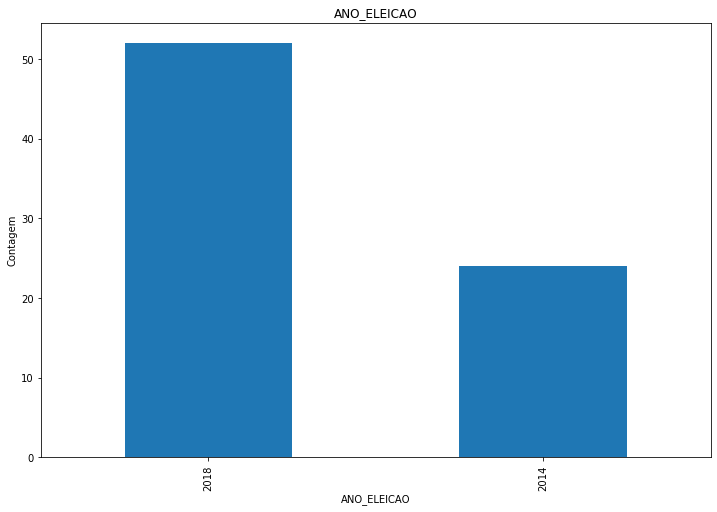

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'debatedor')

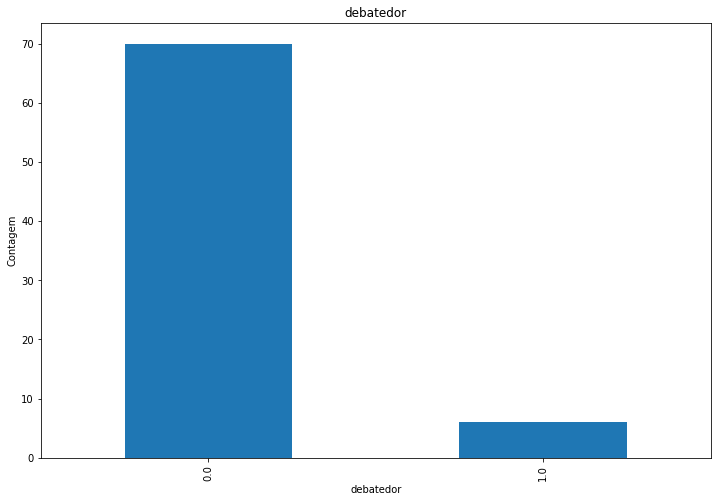

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'articulador')

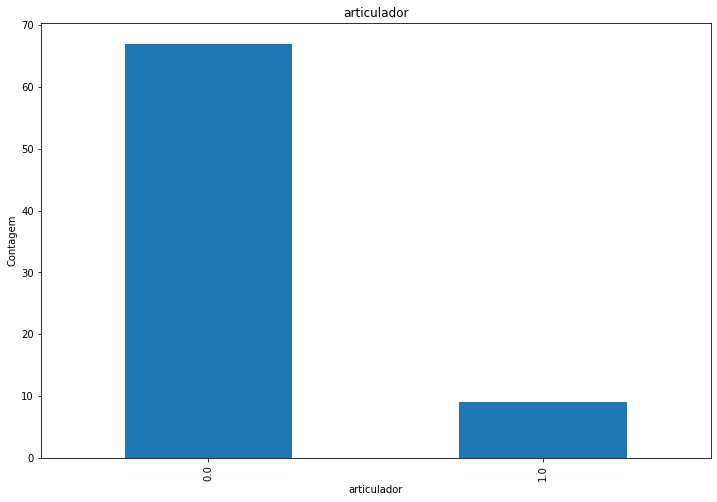

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'formulador')

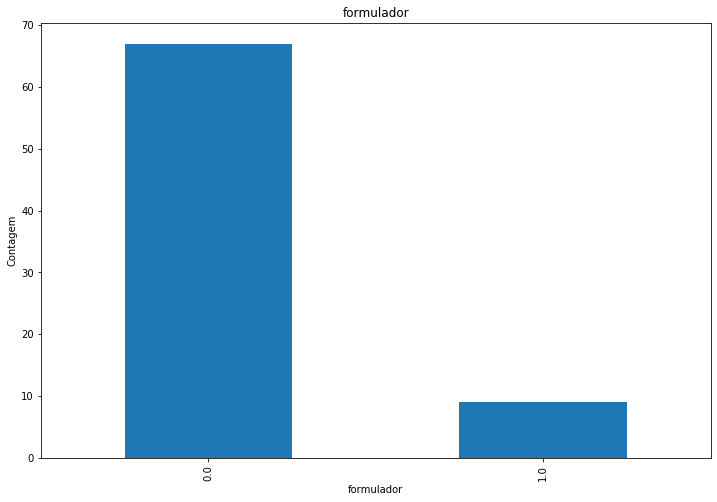

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'negociador')

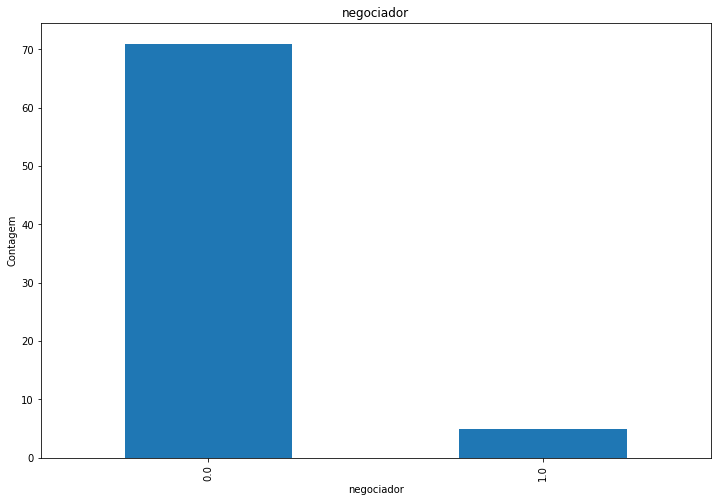

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

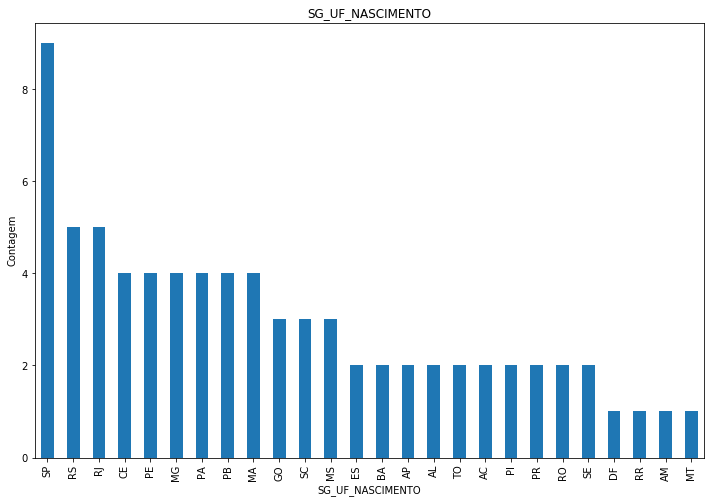

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'DS_GENERO')

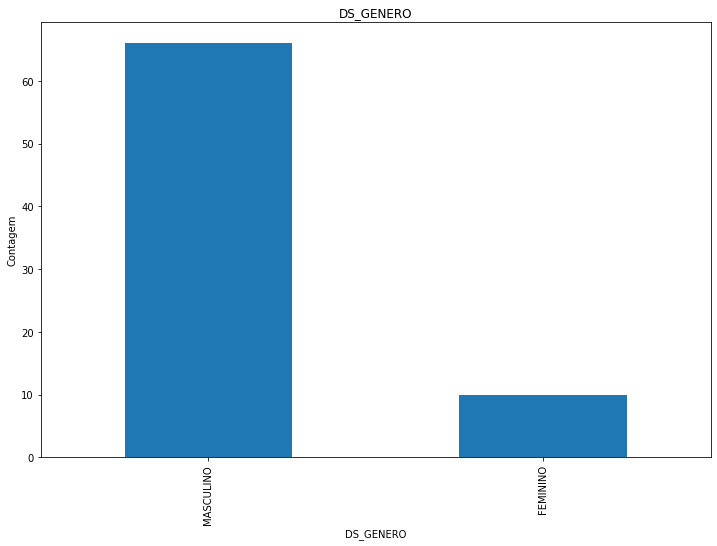

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

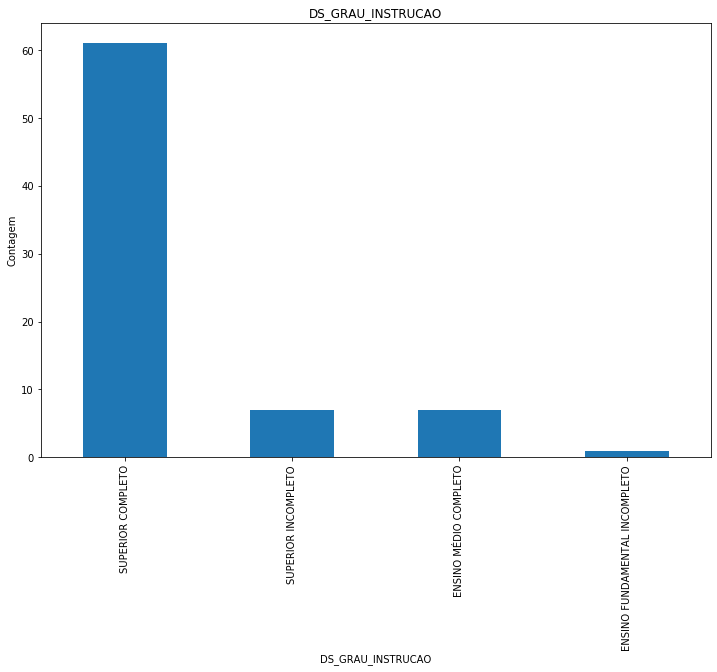

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

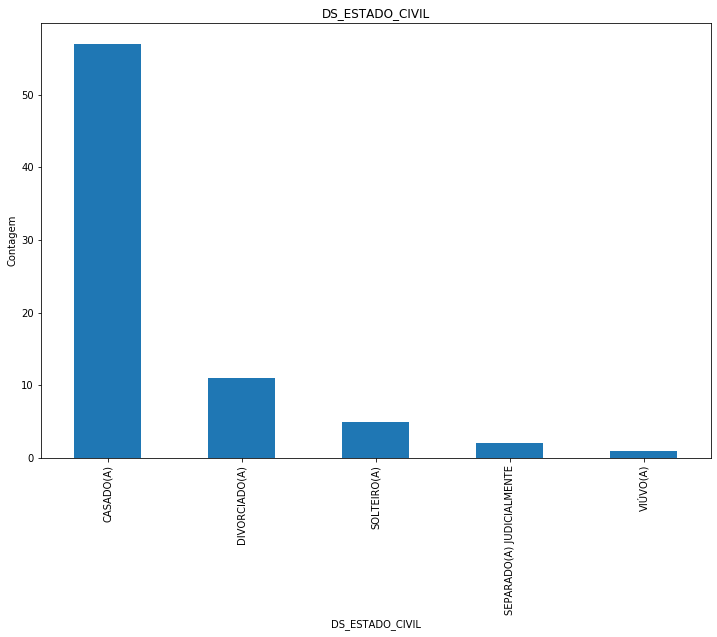

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'DS_COR_RACA')

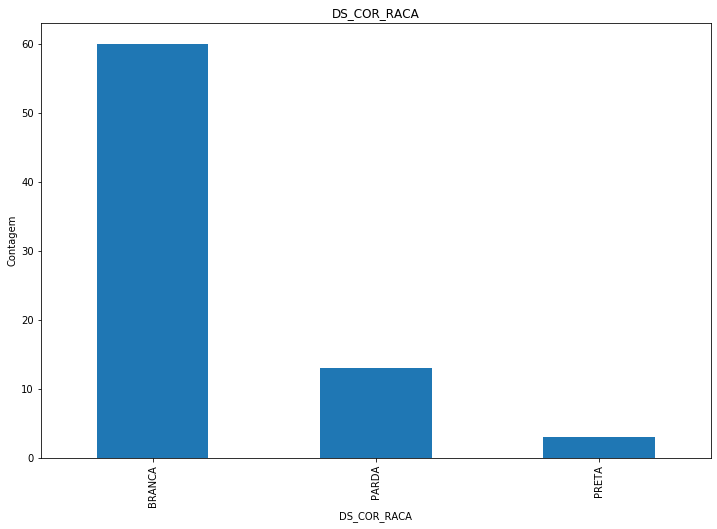

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'DS_OCUPACAO')

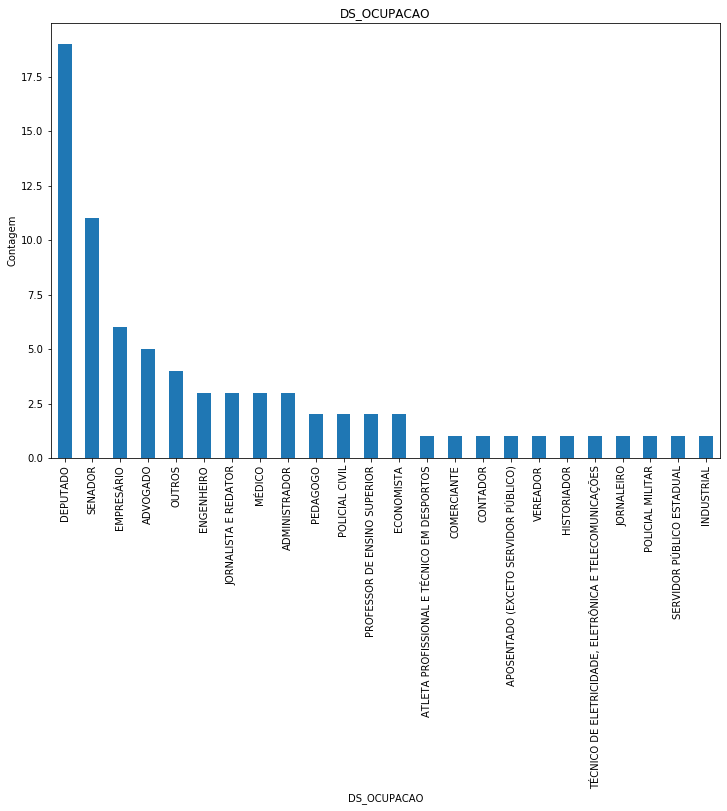

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'SG_PARTIDO')

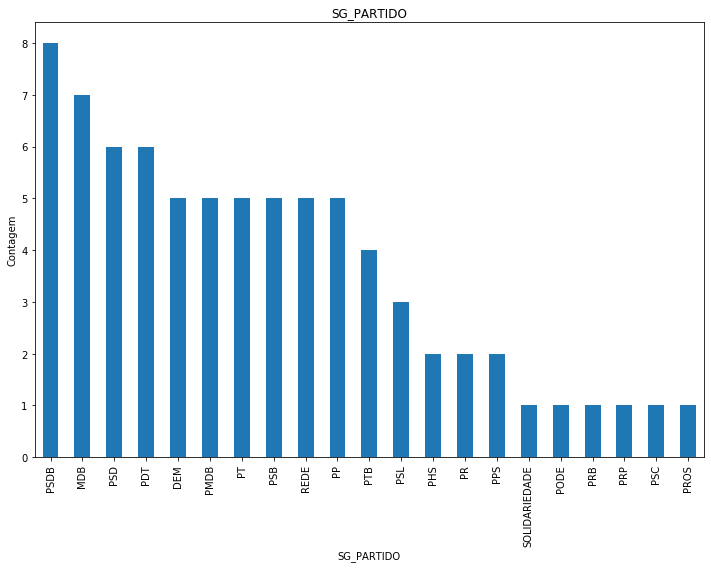

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'SG_UE')

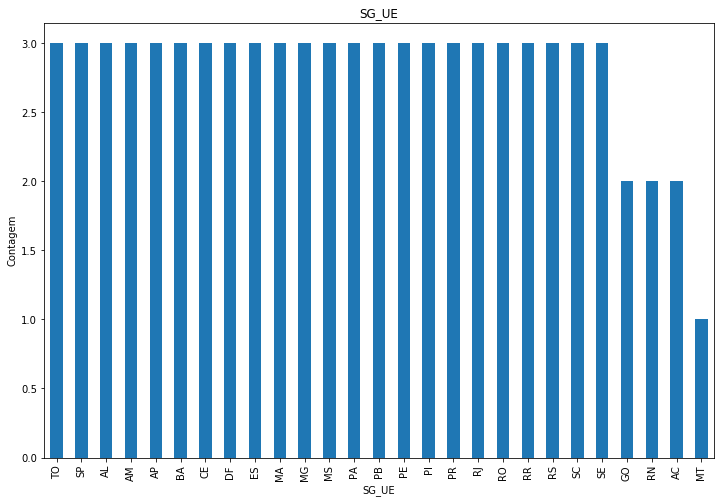

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'MESA')

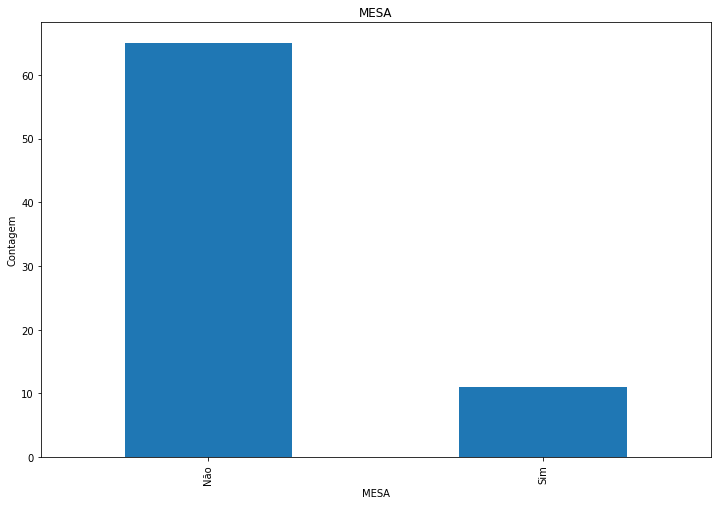

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'Contagem')

Text(0.5, 1.0, 'LIDERANCA')

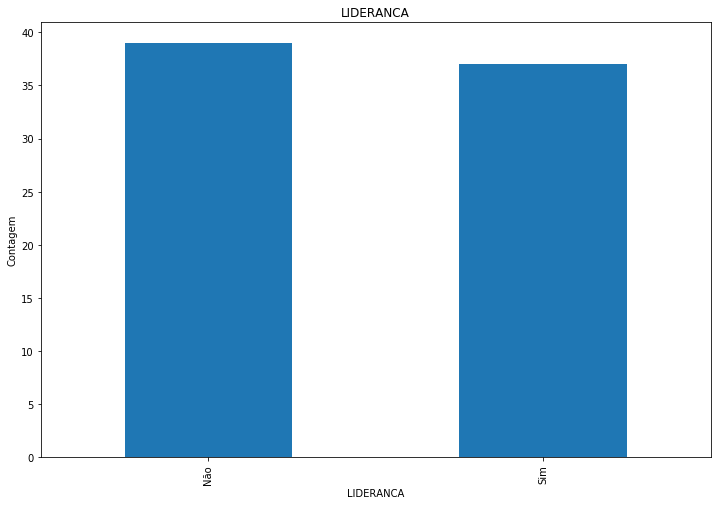

In [49]:
for variavel in variaveis_categoricas:
    df[variavel].value_counts().plot(kind="bar")
    plt.xlabel(variavel)
    plt.ylabel("Contagem")
    plt.title(variavel)
    plt.show()

### Boxplots - Identificando, verificando e tratando outliers


Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'ANO_ELEICAO')

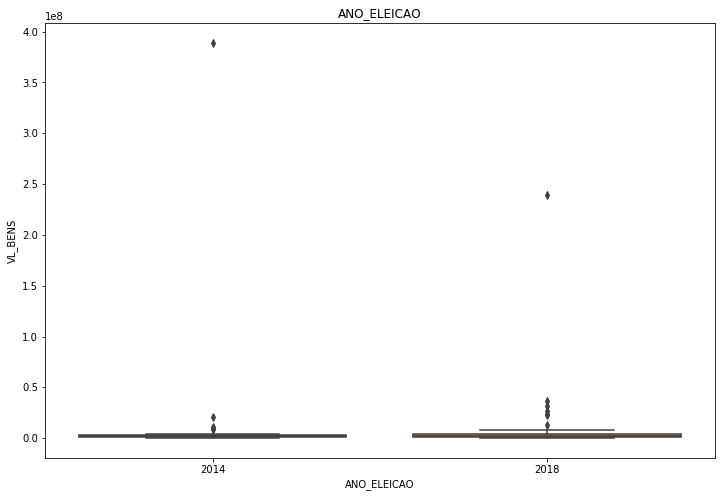

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'ANO_ELEICAO')

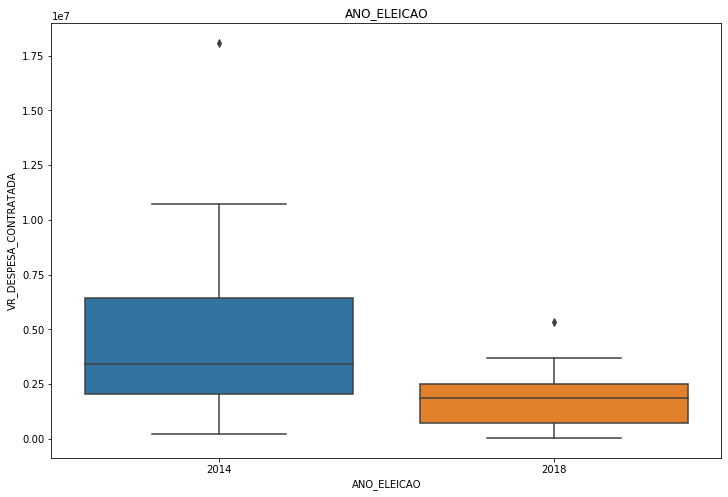

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'ANO_ELEICAO')

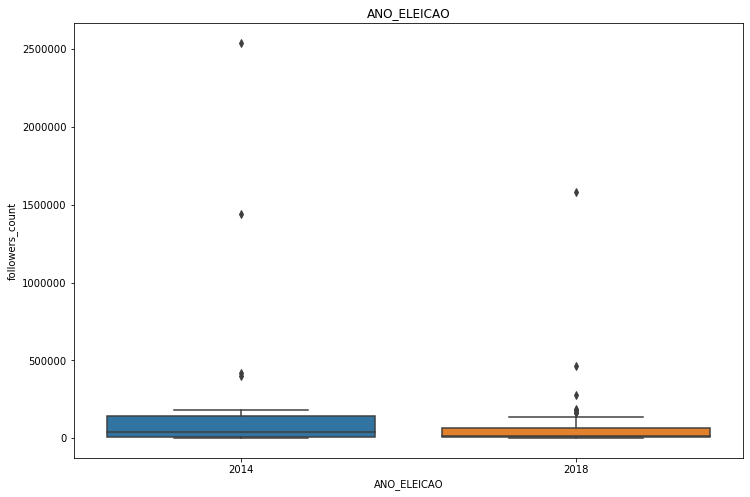

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'ANO_ELEICAO')

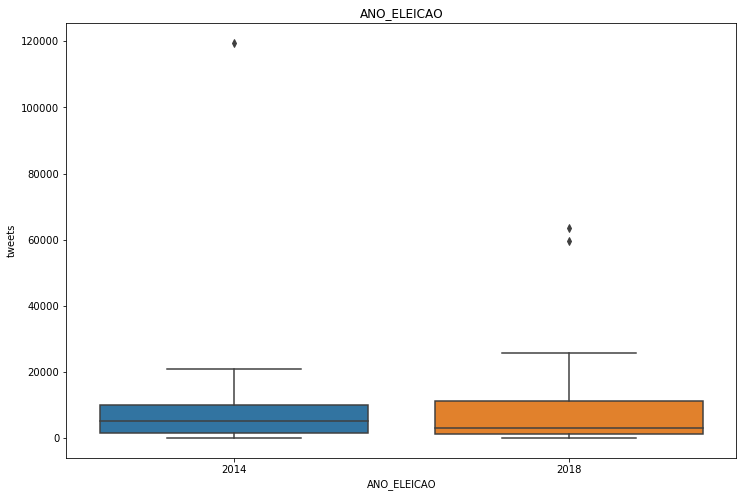

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'ANO_ELEICAO')

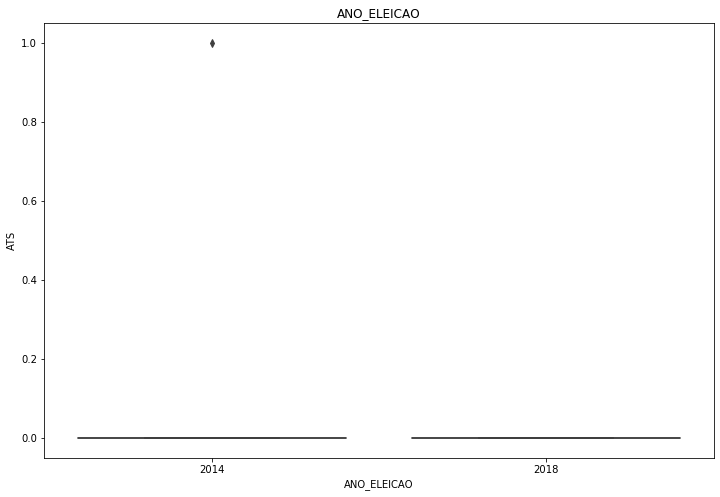

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'ANO_ELEICAO')

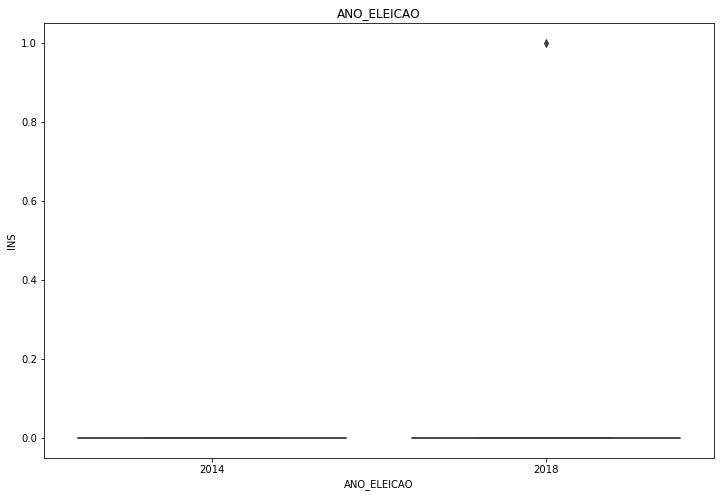

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'ANO_ELEICAO')

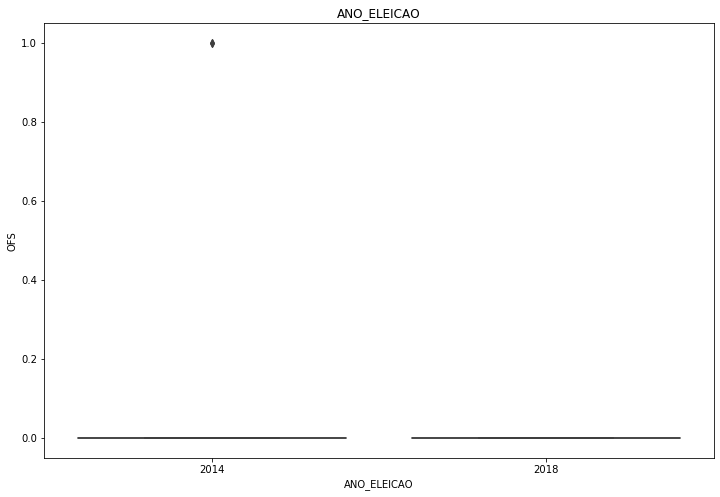

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'ANO_ELEICAO')

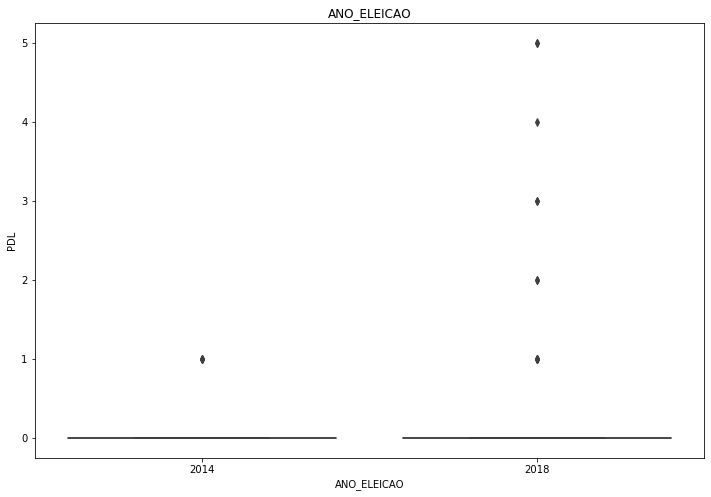

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'ANO_ELEICAO')

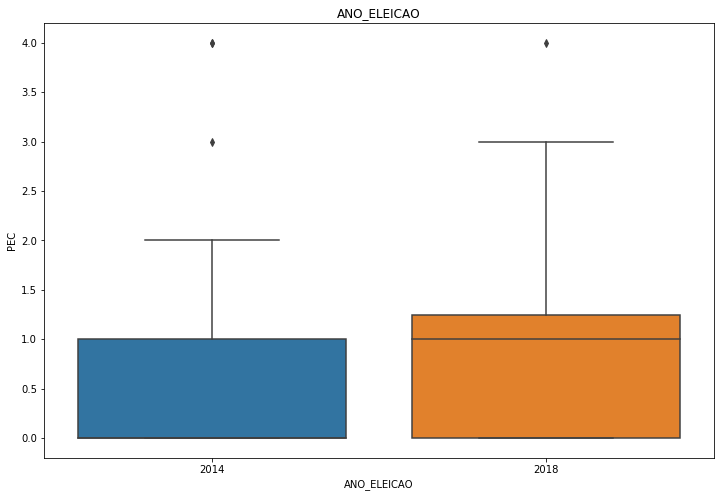

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'ANO_ELEICAO')

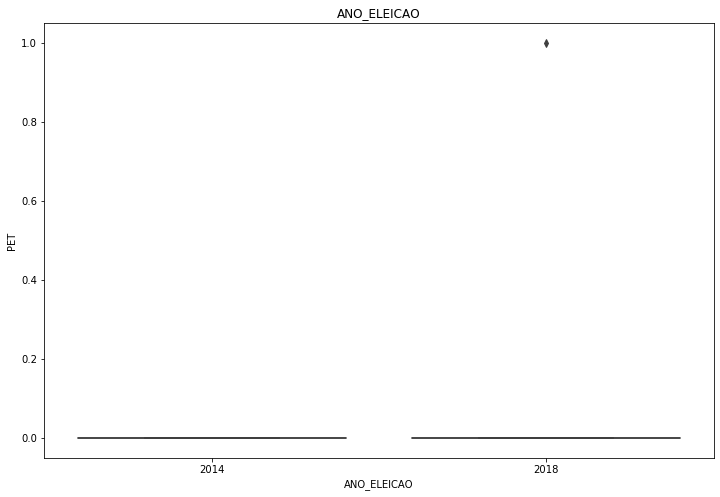

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'ANO_ELEICAO')

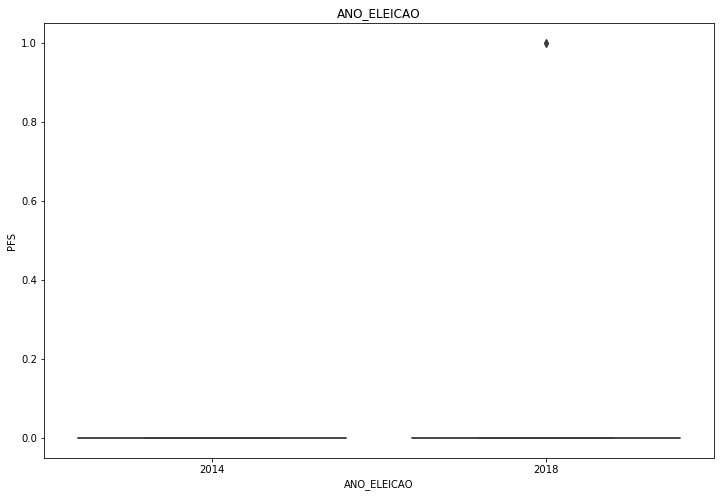

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'ANO_ELEICAO')

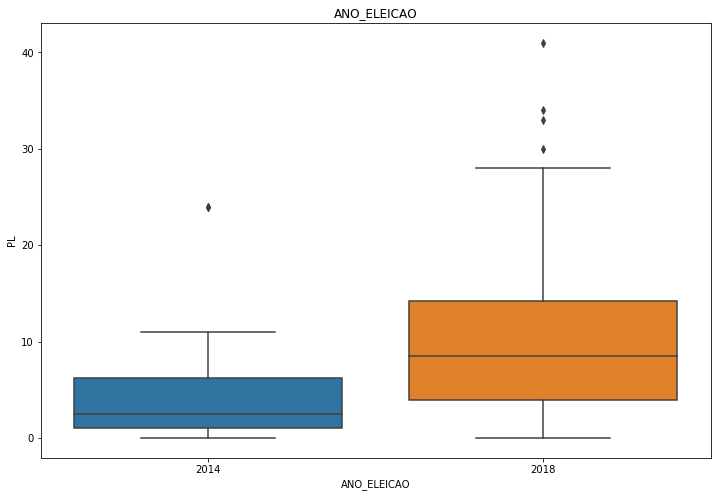

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'ANO_ELEICAO')

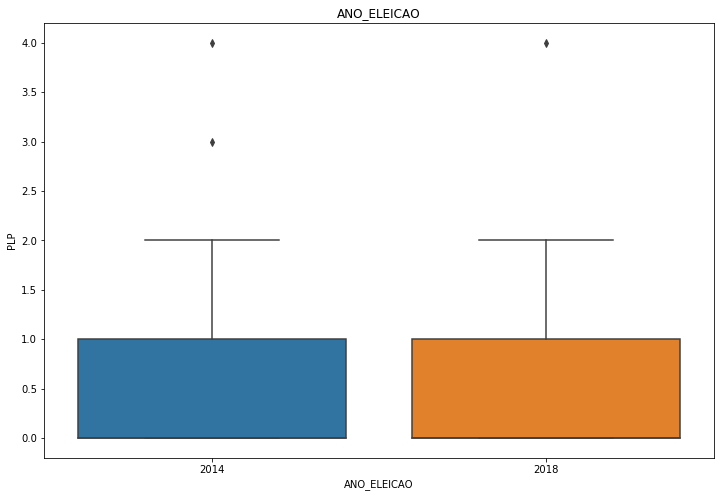

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'ANO_ELEICAO')

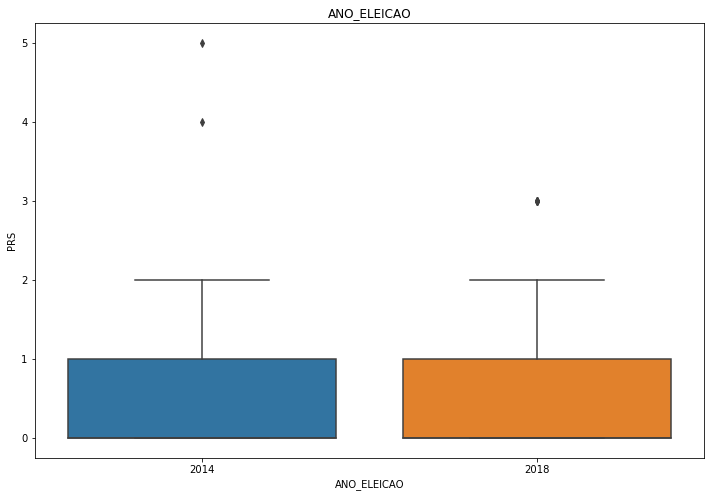

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'ANO_ELEICAO')

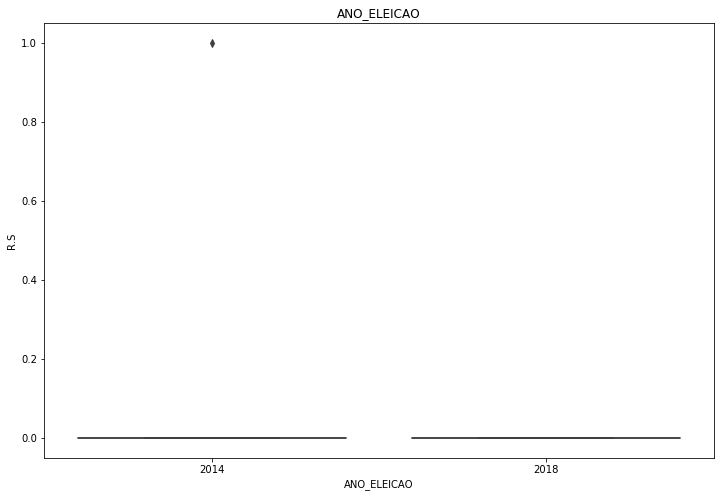

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'ANO_ELEICAO')

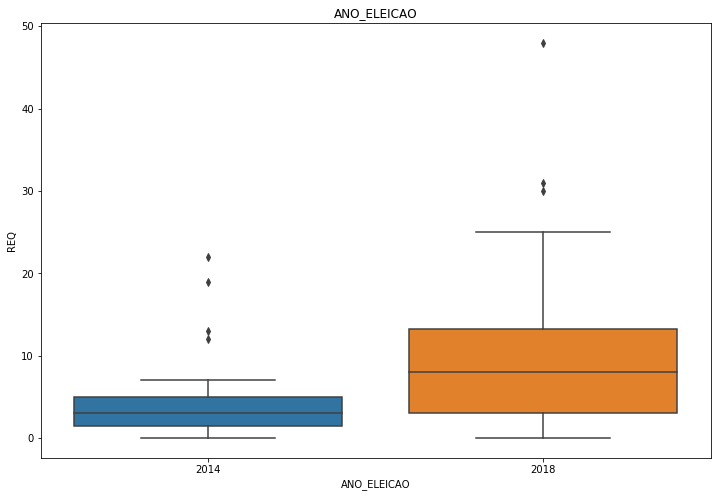

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'ANO_ELEICAO')

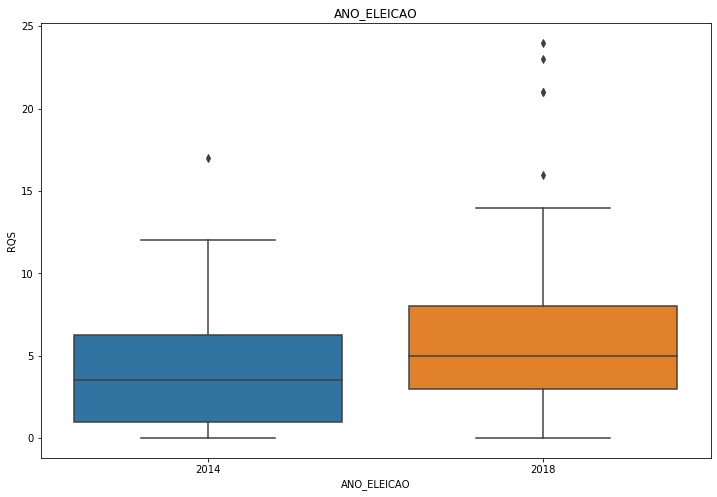

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'ANO_ELEICAO')

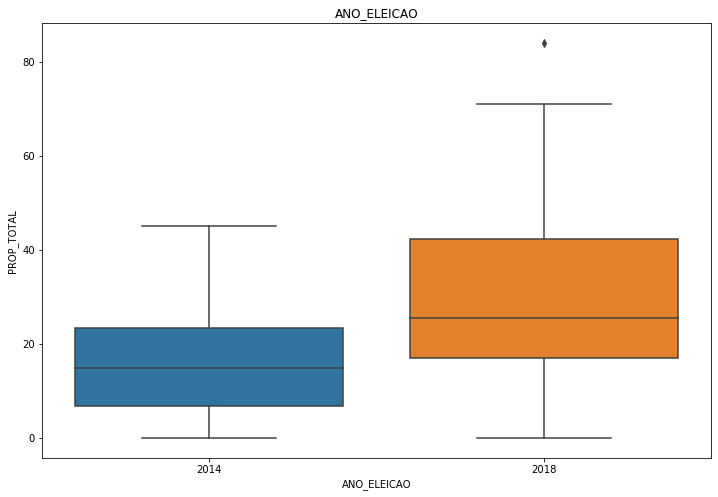

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'ANO_ELEICAO')

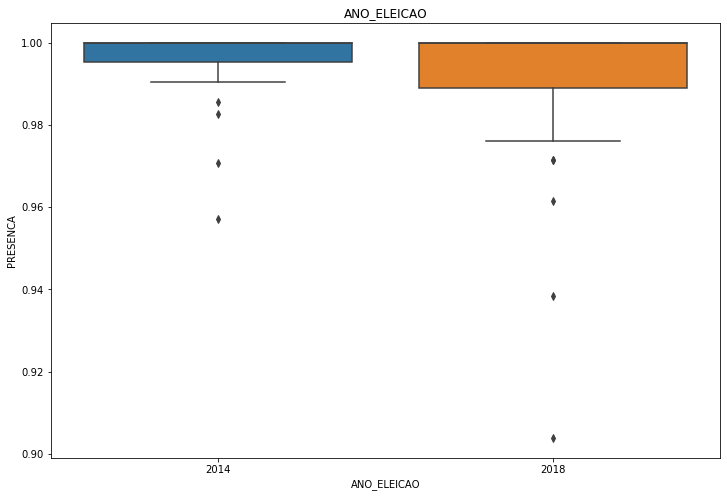

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'ANO_ELEICAO')

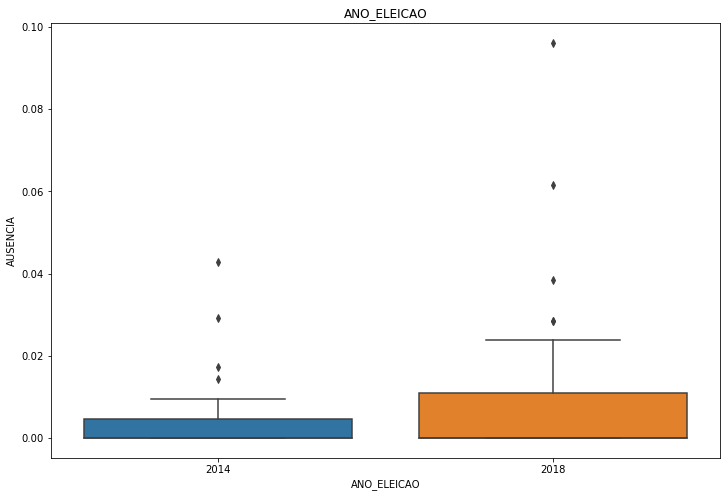

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'ANO_ELEICAO')

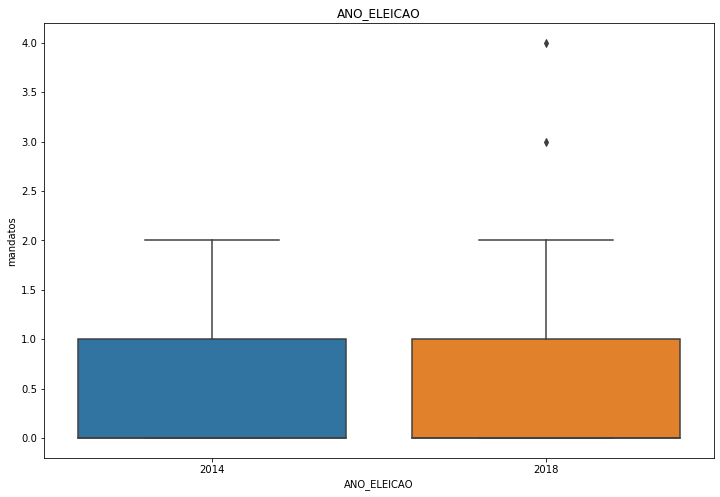

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'ANO_ELEICAO')

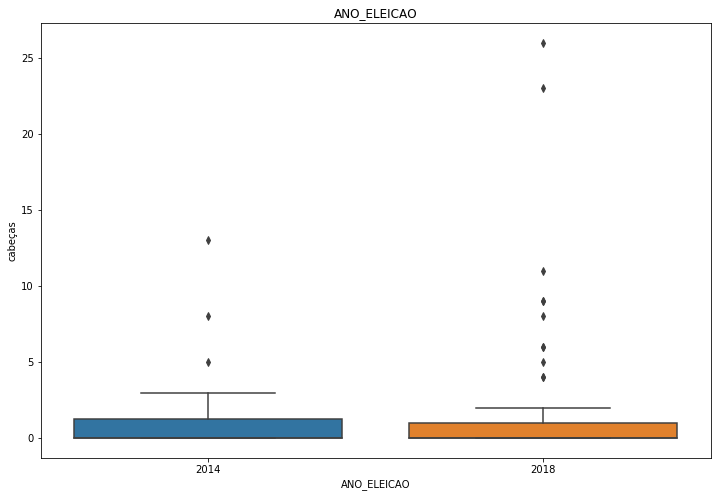

Text(0.5, 0, 'ANO_ELEICAO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'ANO_ELEICAO')

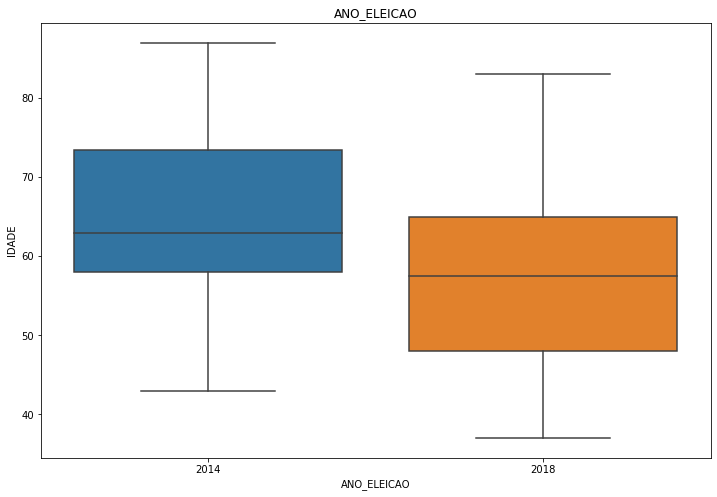

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'debatedor')

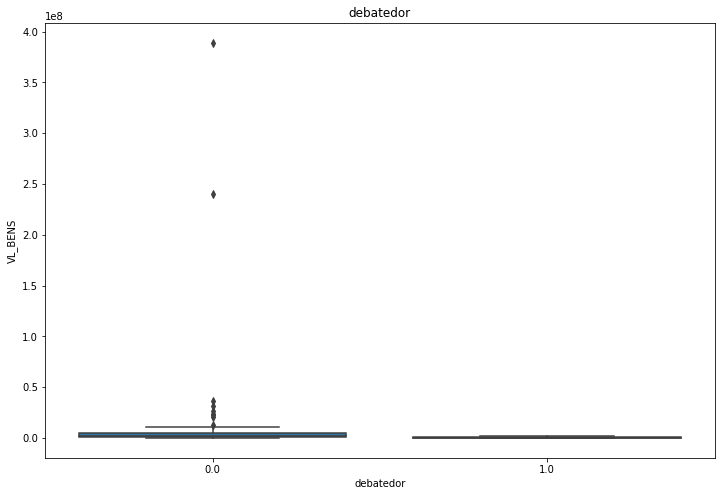

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'debatedor')

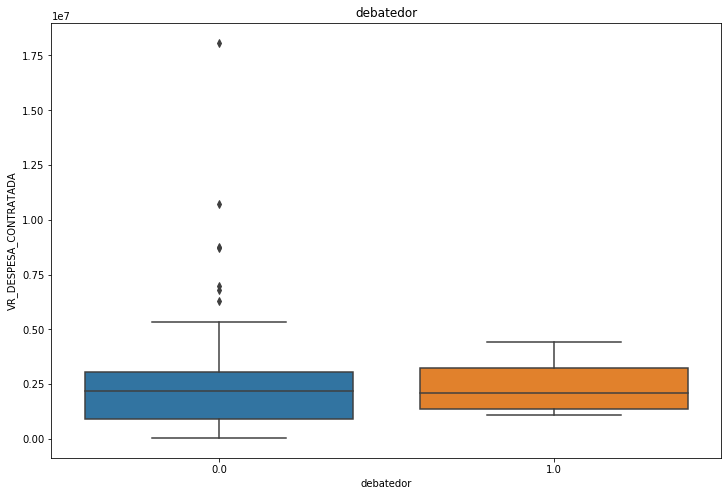

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'debatedor')

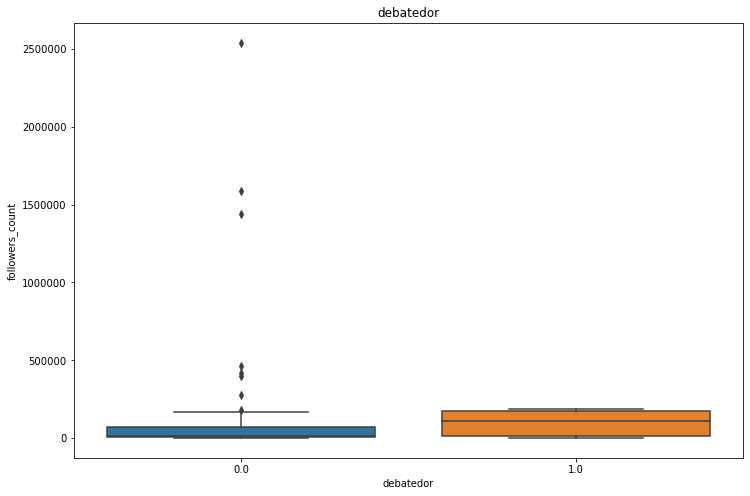

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'debatedor')

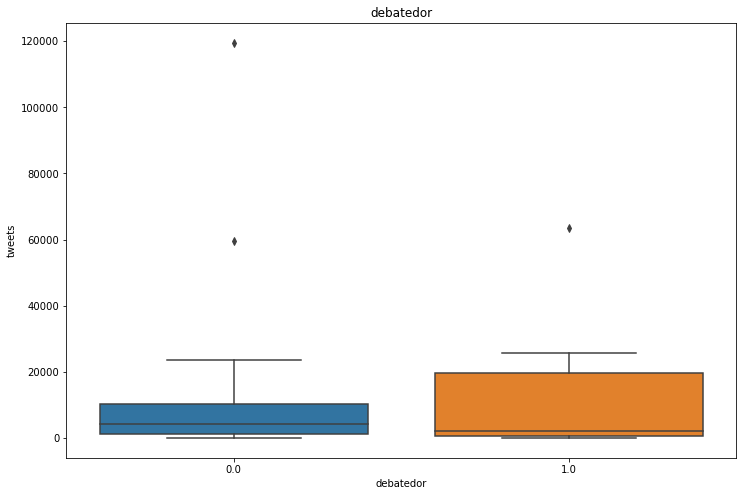

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'debatedor')

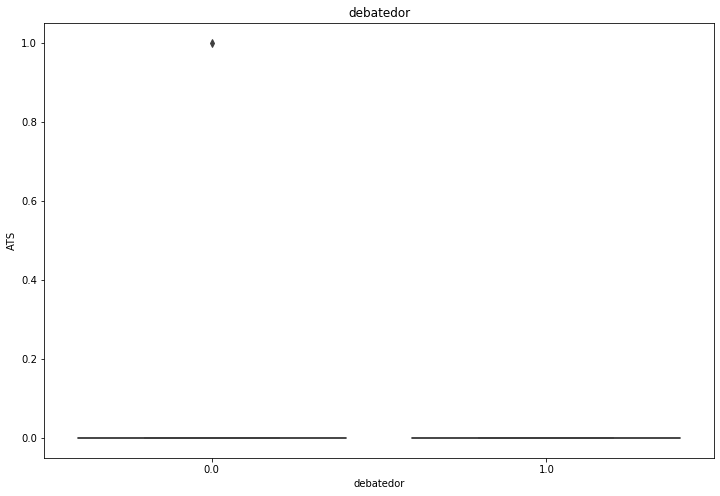

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'debatedor')

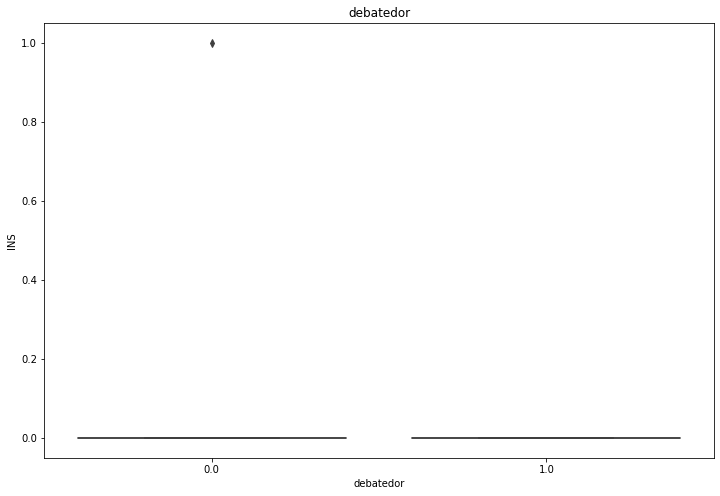

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'debatedor')

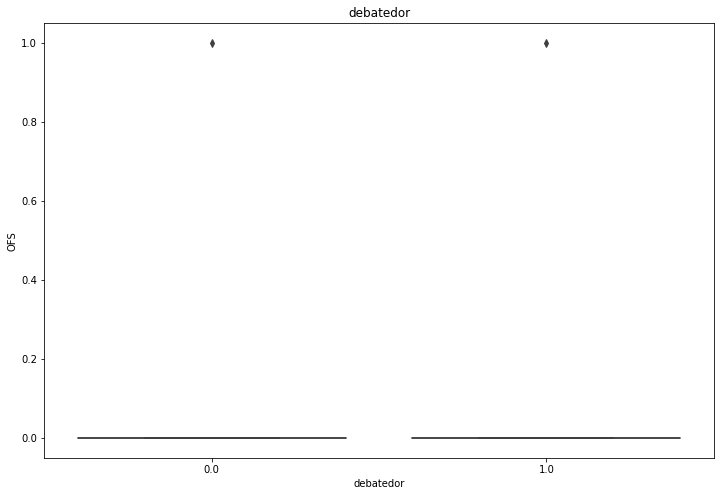

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'debatedor')

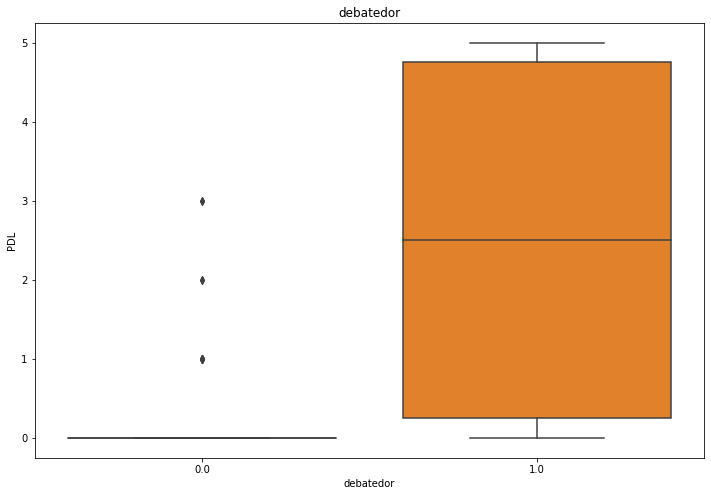

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'debatedor')

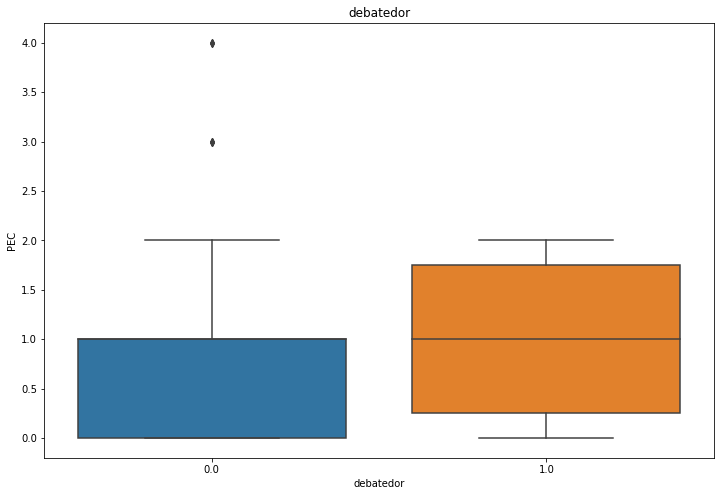

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'debatedor')

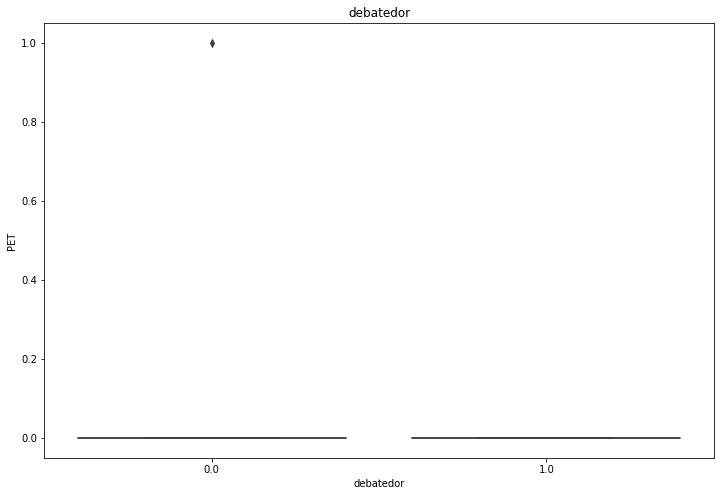

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'debatedor')

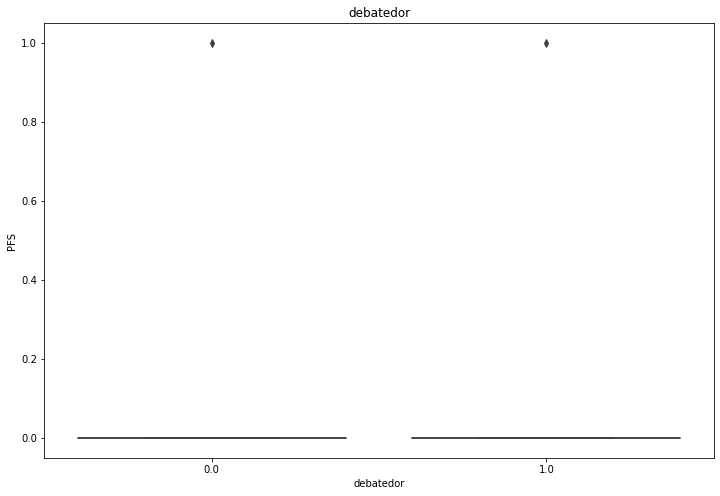

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'debatedor')

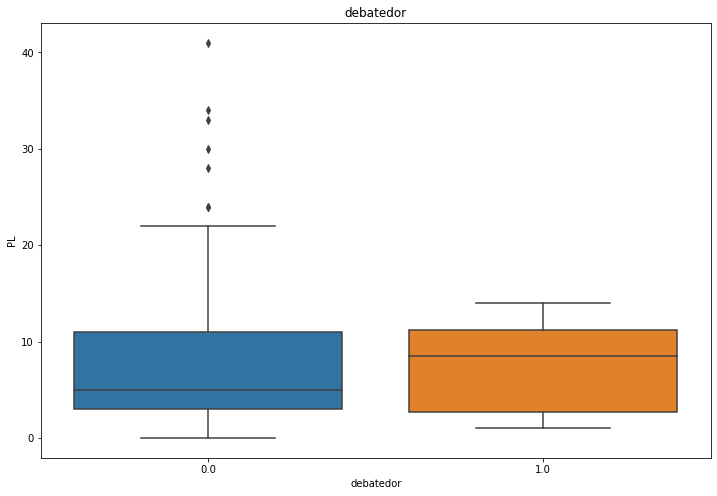

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'debatedor')

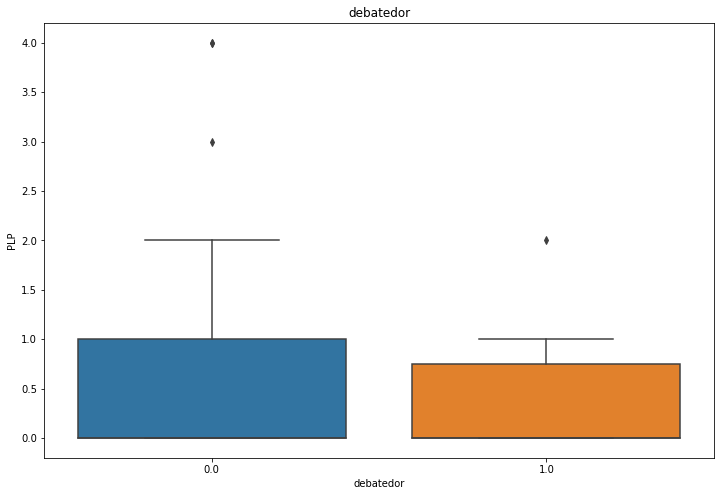

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'debatedor')

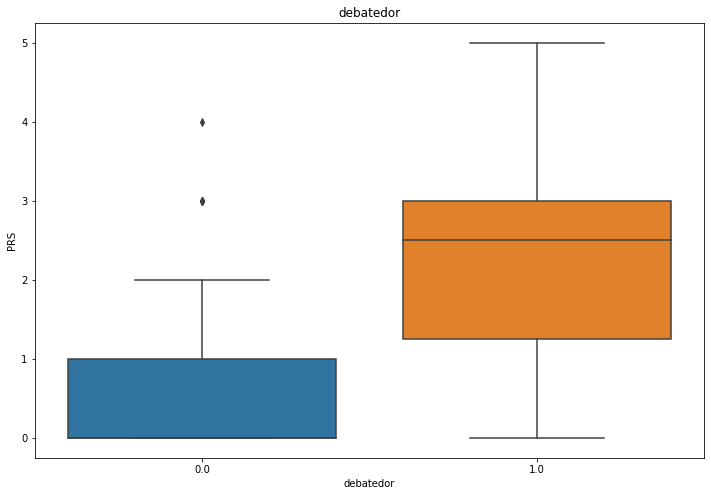

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'debatedor')

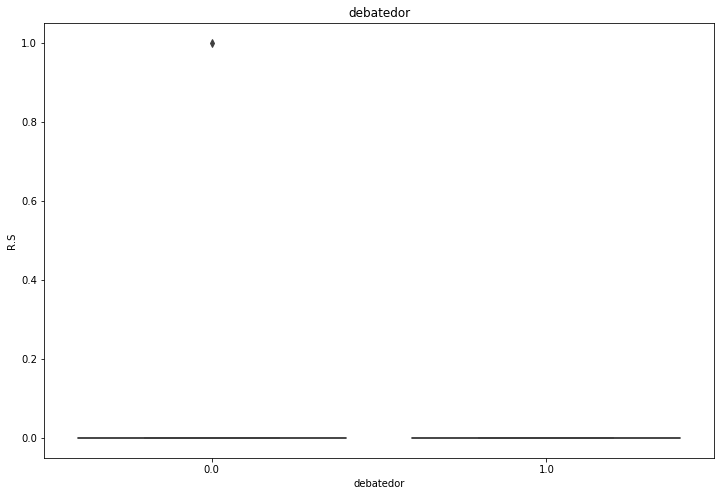

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'debatedor')

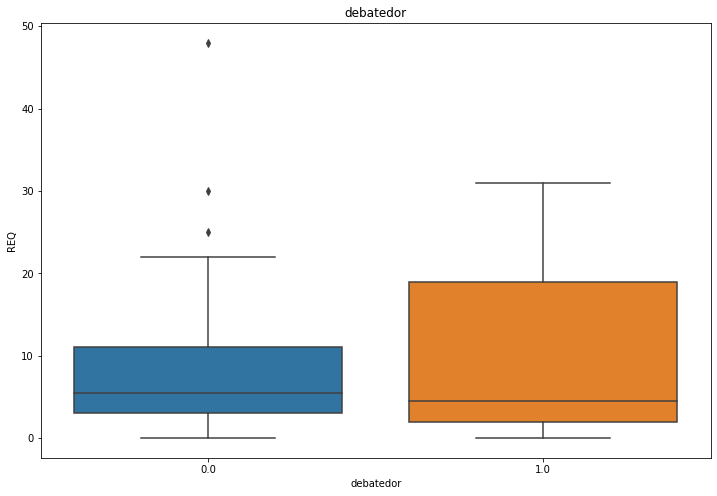

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'debatedor')

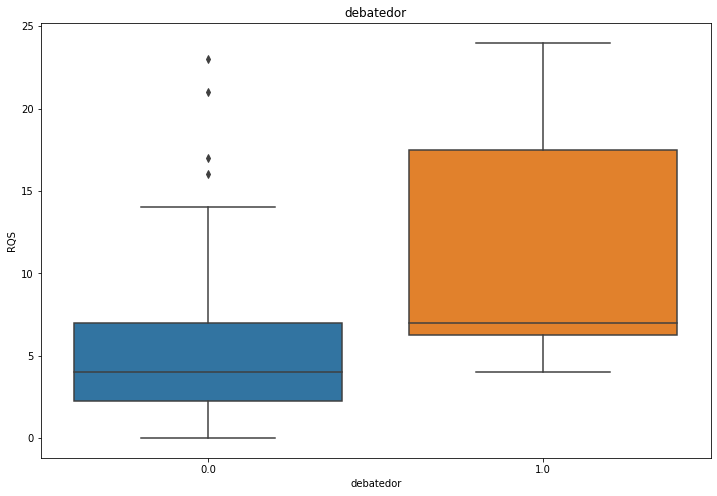

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'debatedor')

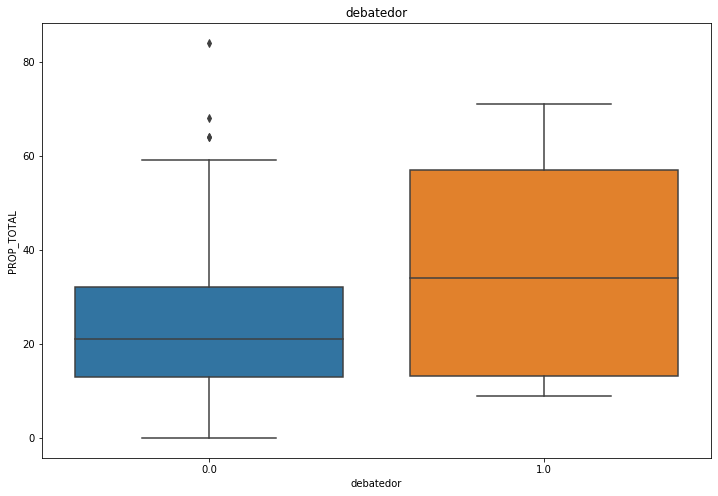

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'debatedor')

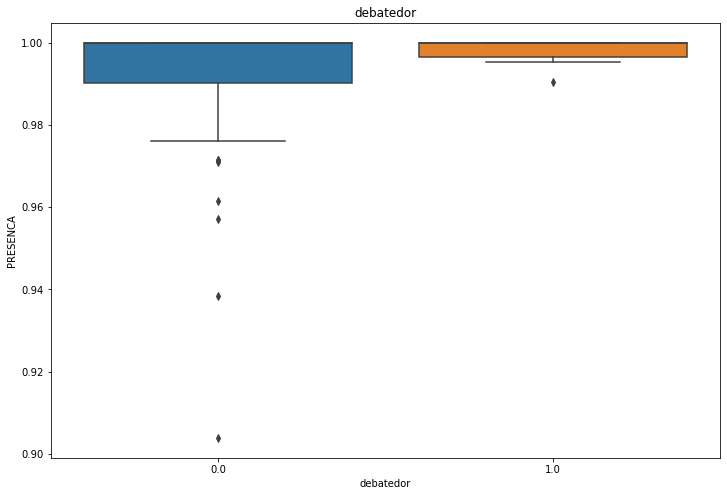

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'debatedor')

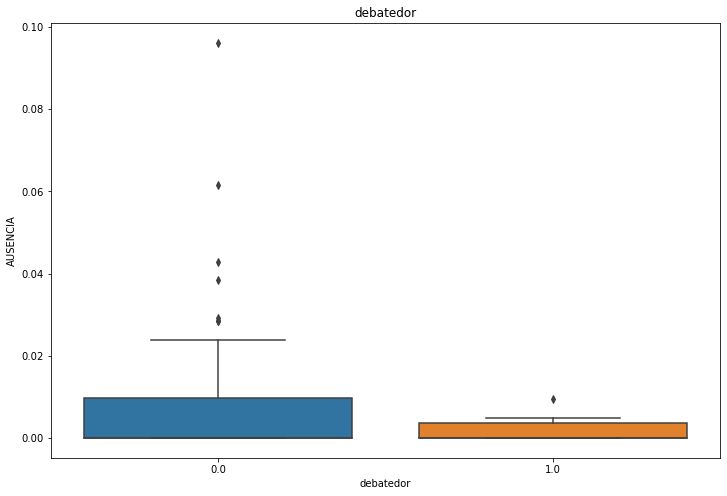

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'debatedor')

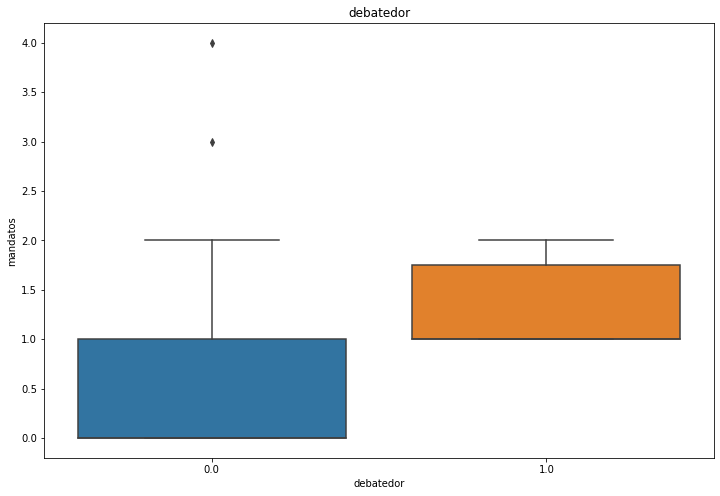

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'debatedor')

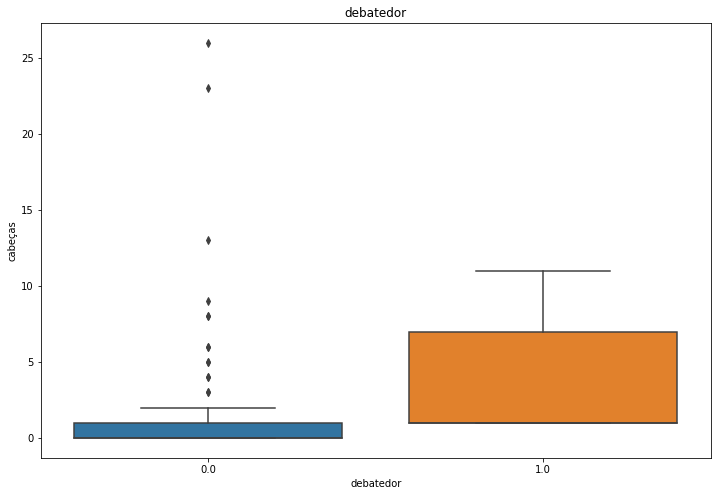

Text(0.5, 0, 'debatedor')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'debatedor')

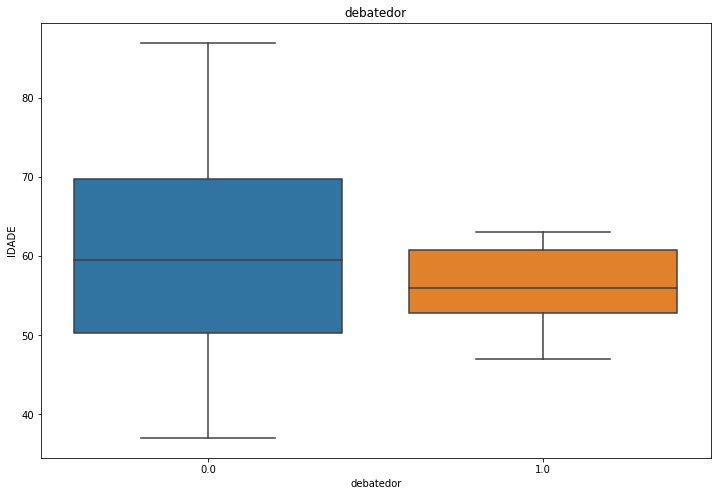

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'articulador')

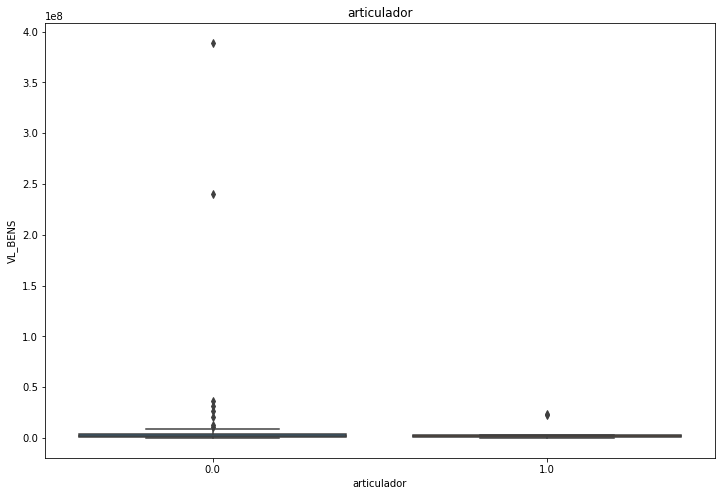

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'articulador')

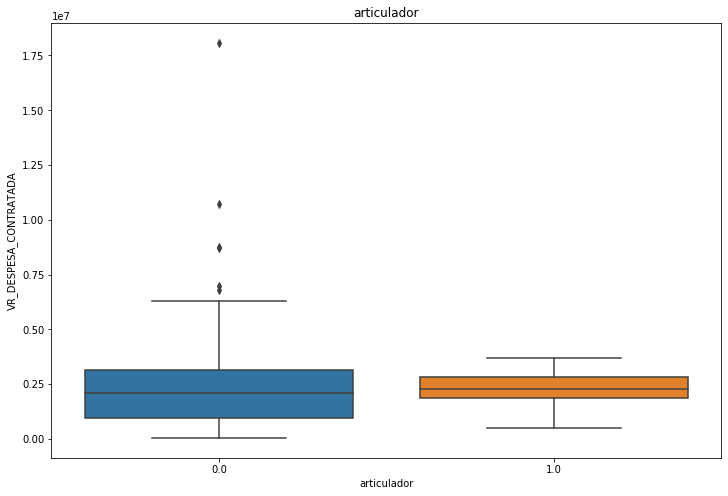

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'articulador')

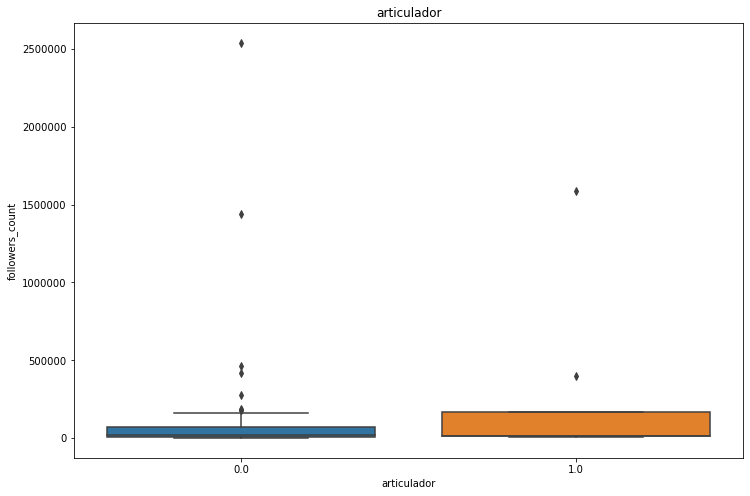

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'articulador')

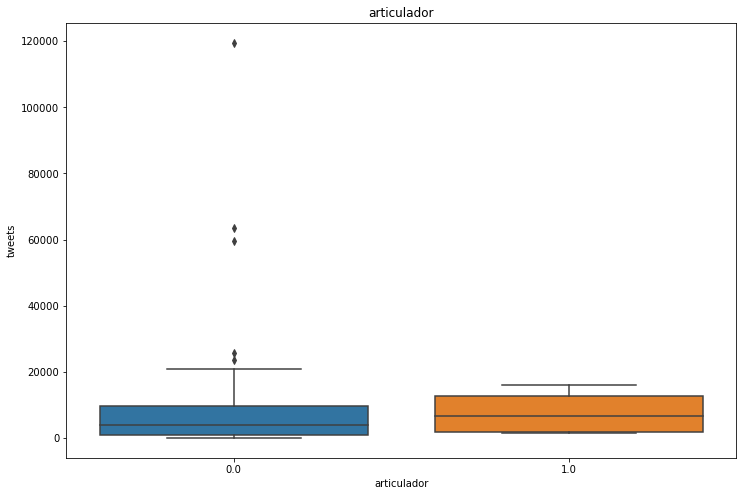

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'articulador')

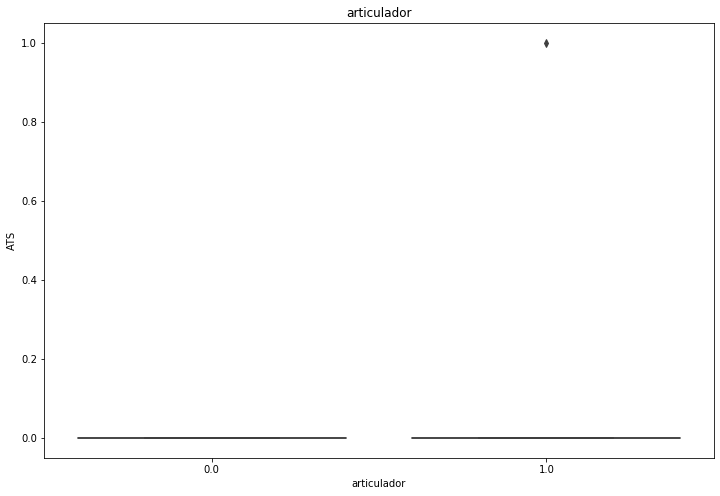

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'articulador')

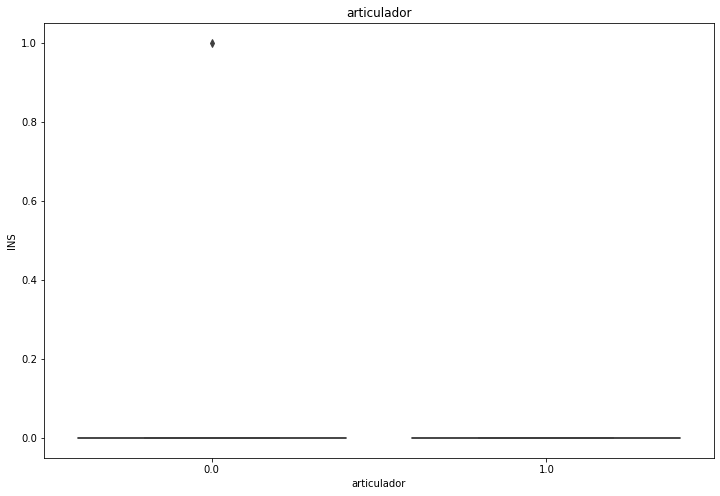

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'articulador')

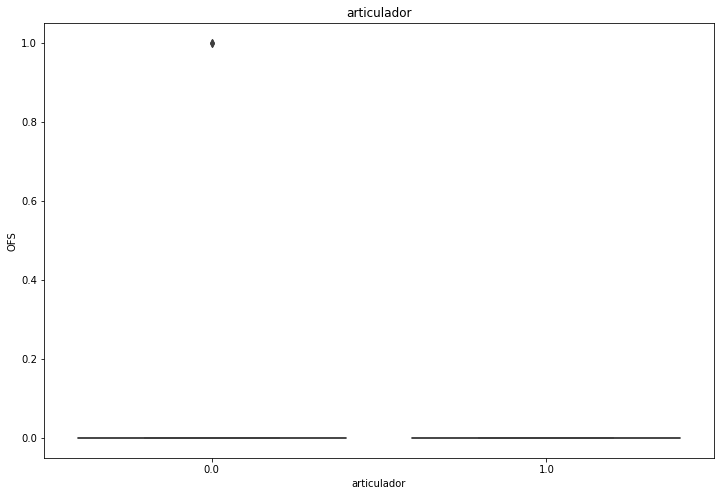

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'articulador')

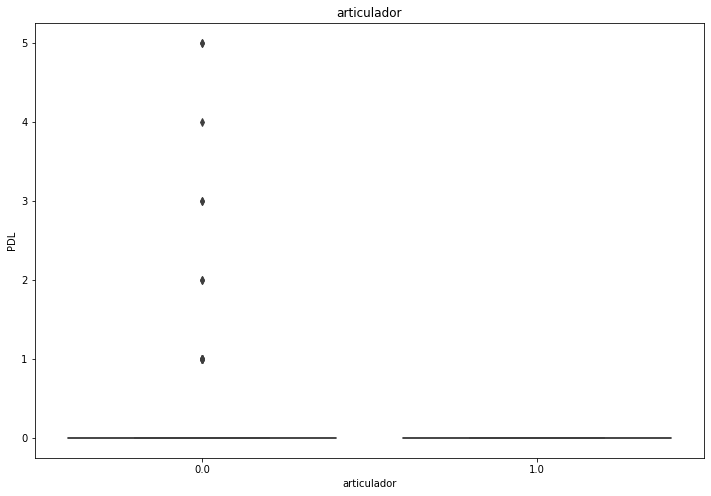

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'articulador')

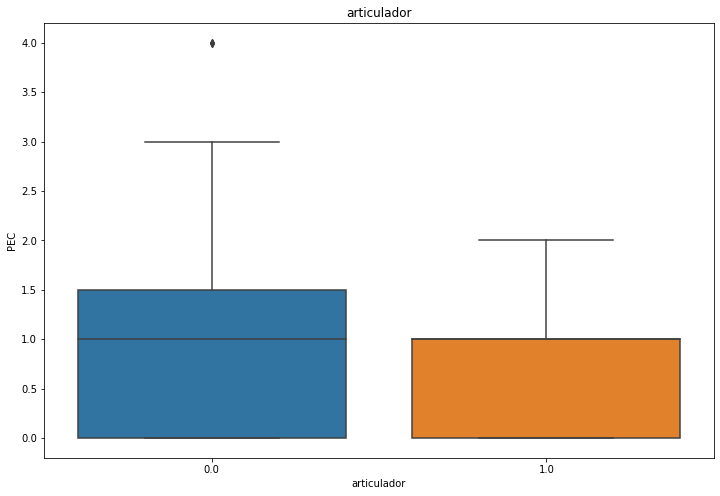

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'articulador')

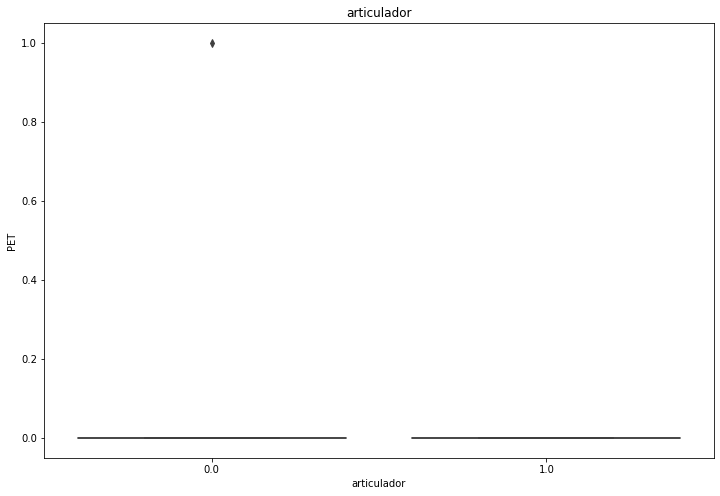

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'articulador')

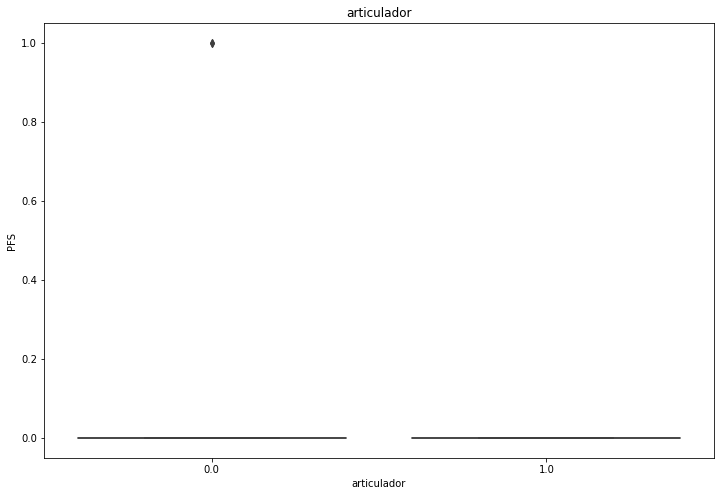

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'articulador')

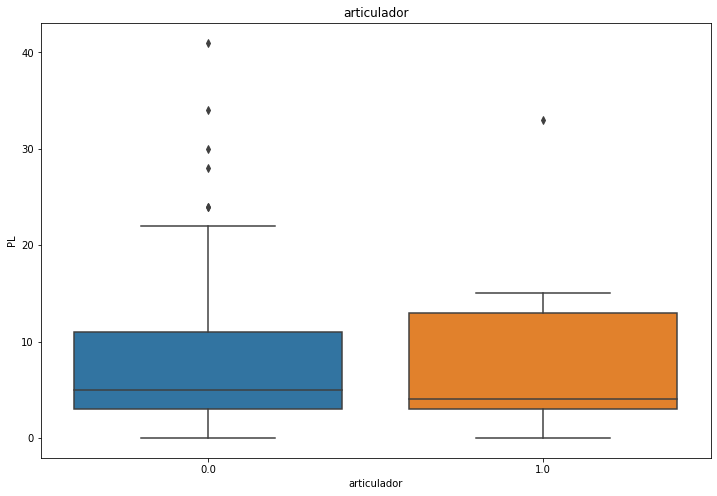

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'articulador')

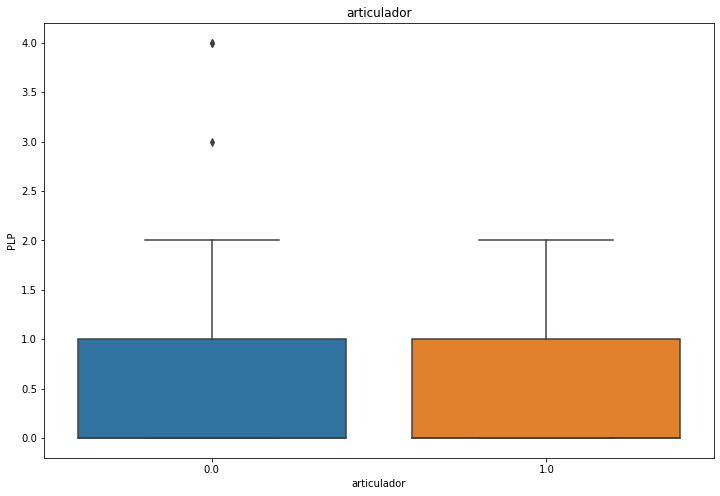

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'articulador')

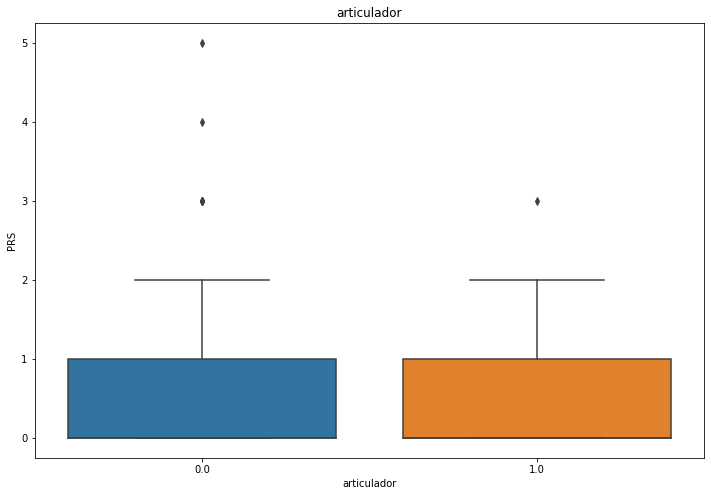

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'articulador')

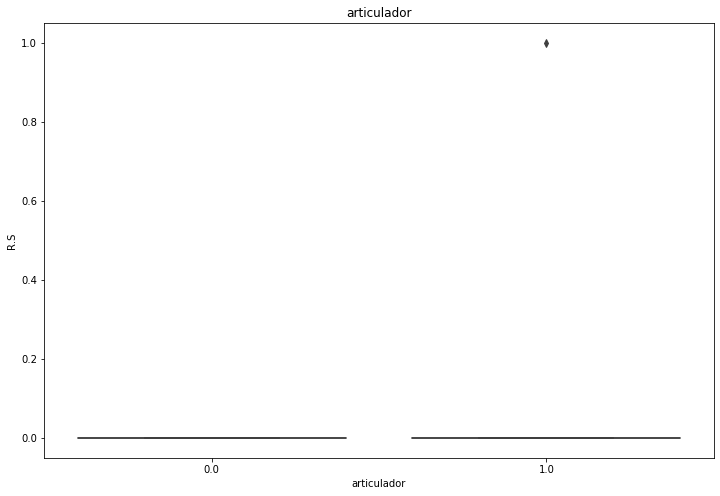

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'articulador')

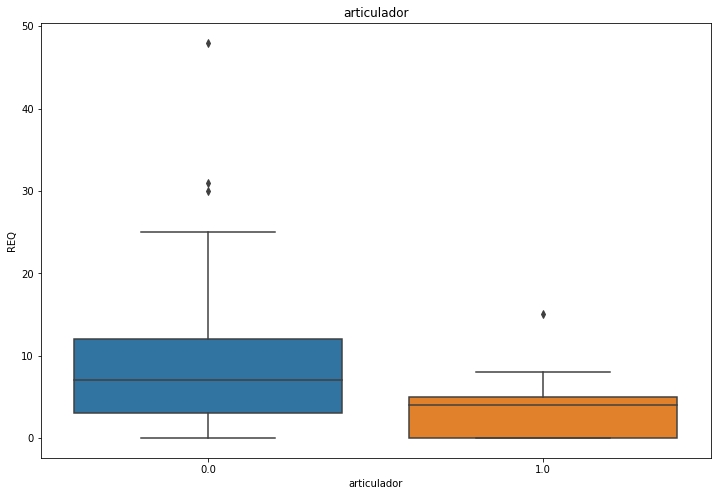

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'articulador')

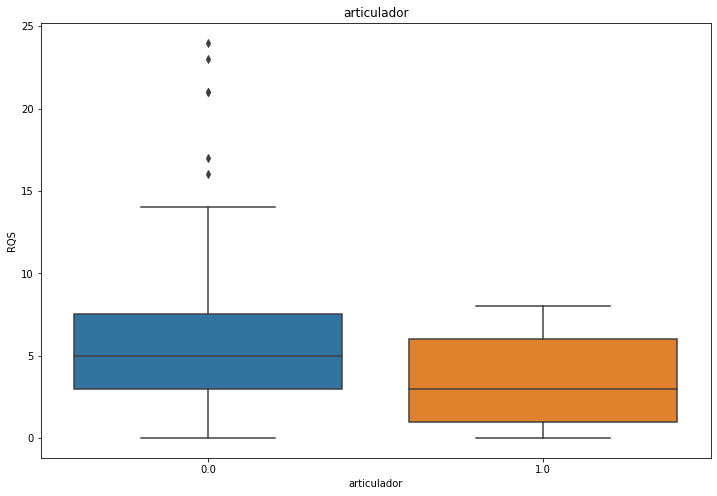

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'articulador')

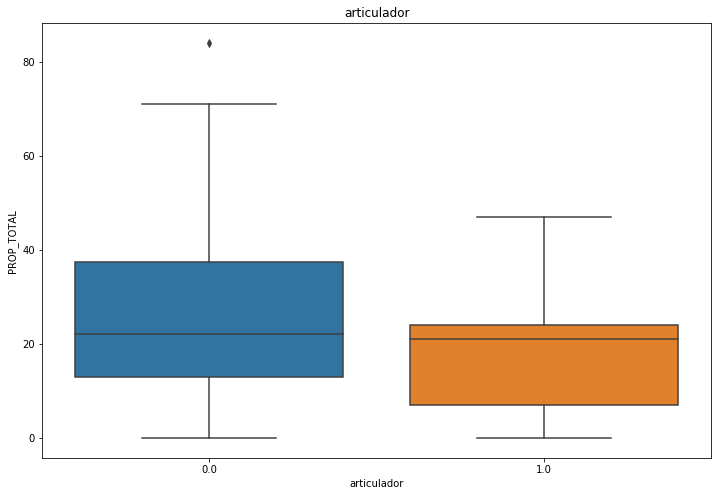

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'articulador')

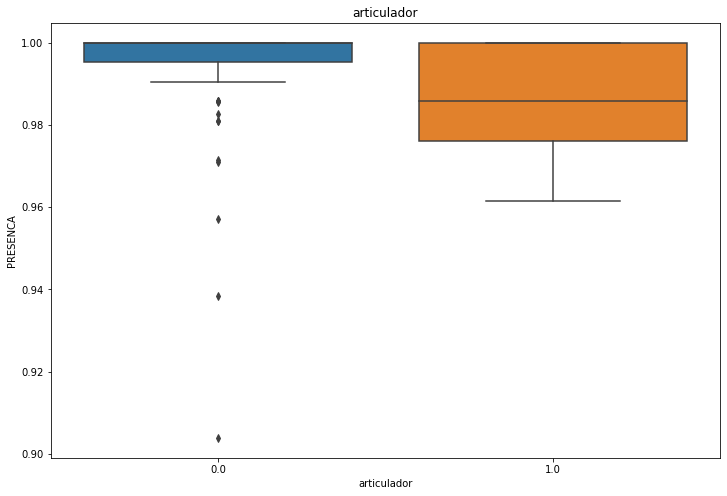

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'articulador')

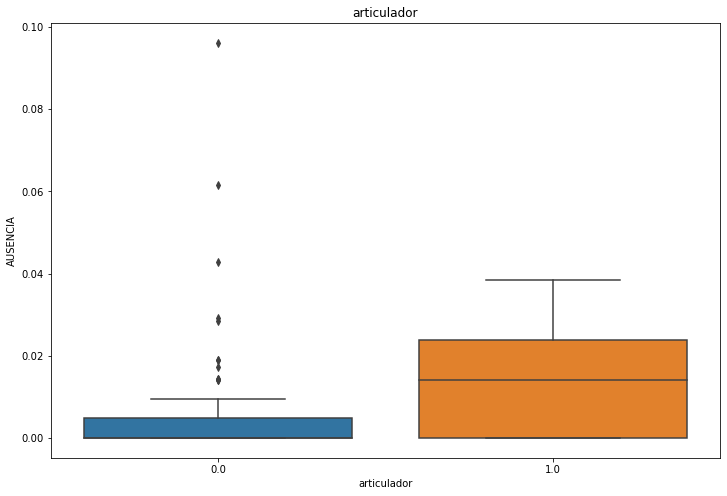

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'articulador')

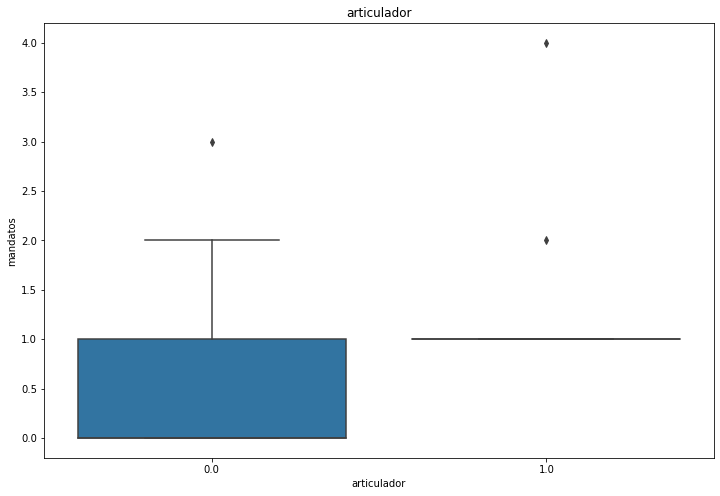

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'articulador')

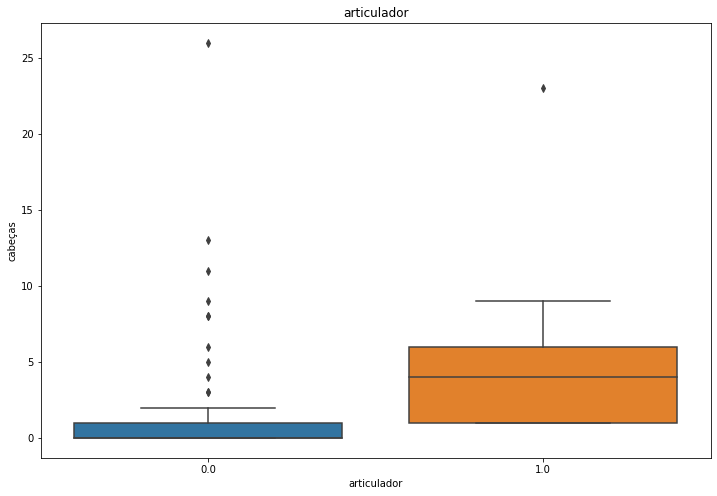

Text(0.5, 0, 'articulador')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'articulador')

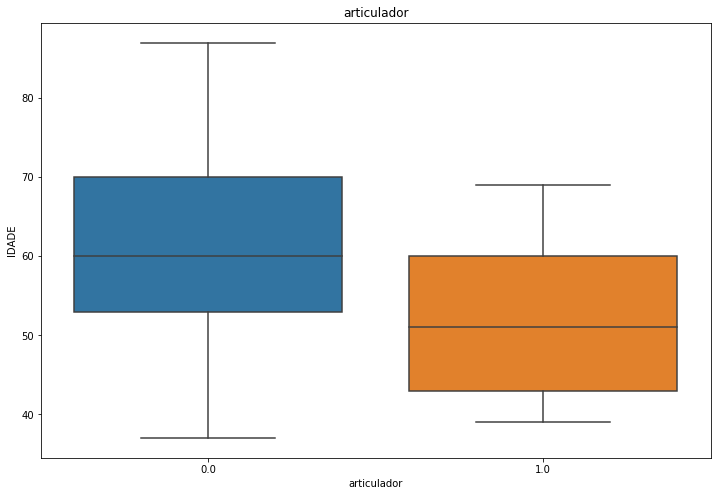

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'formulador')

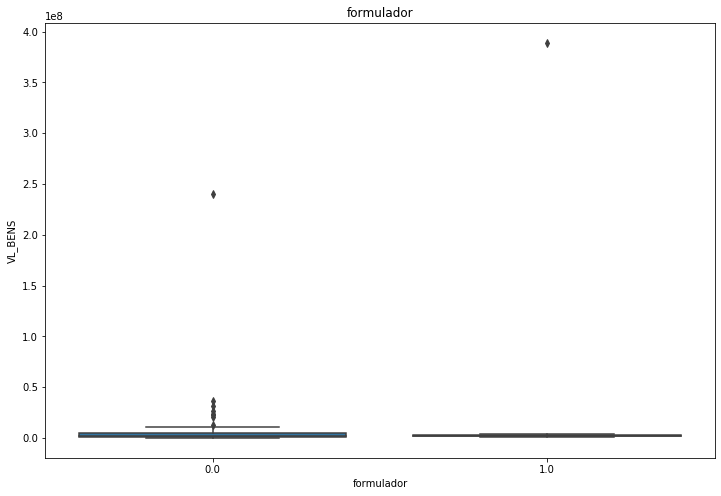

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'formulador')

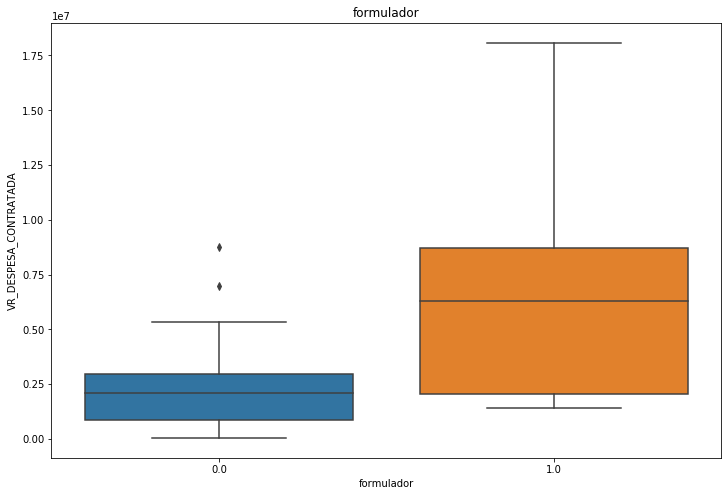

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'formulador')

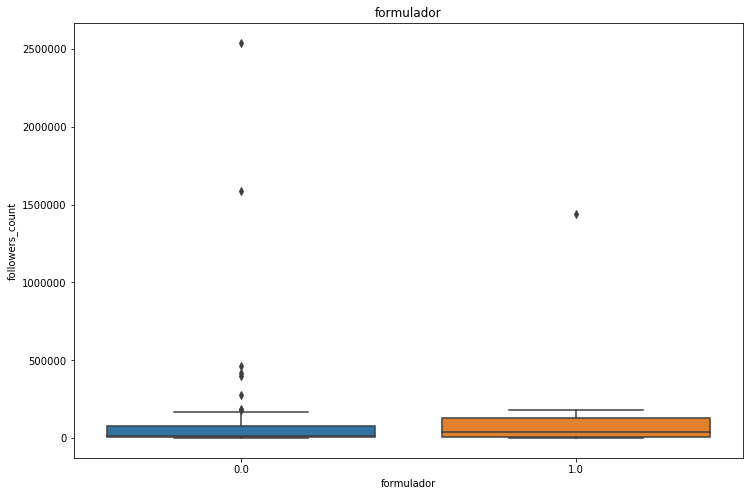

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'formulador')

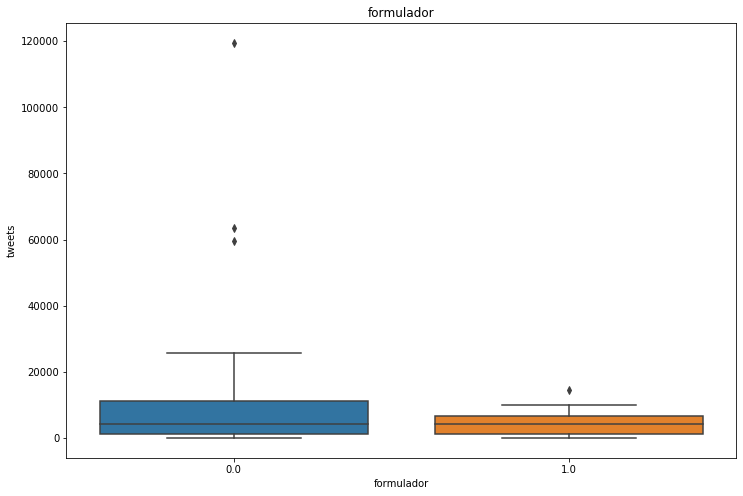

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'formulador')

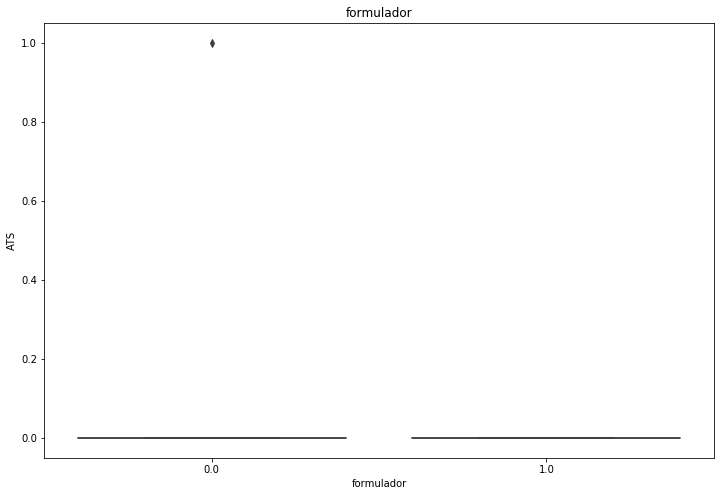

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'formulador')

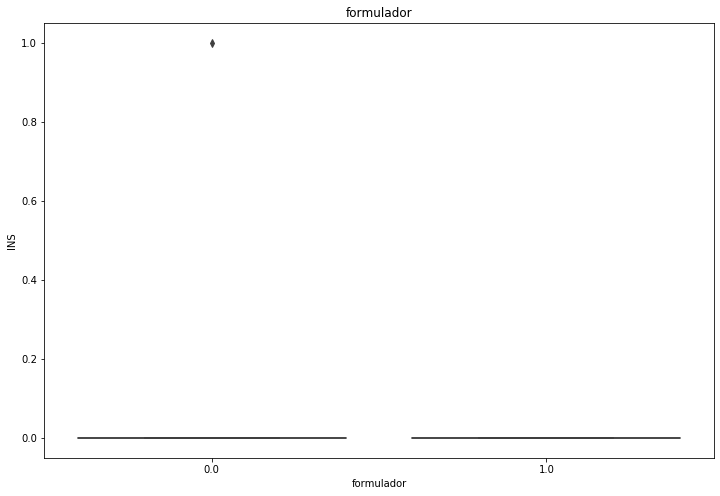

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'formulador')

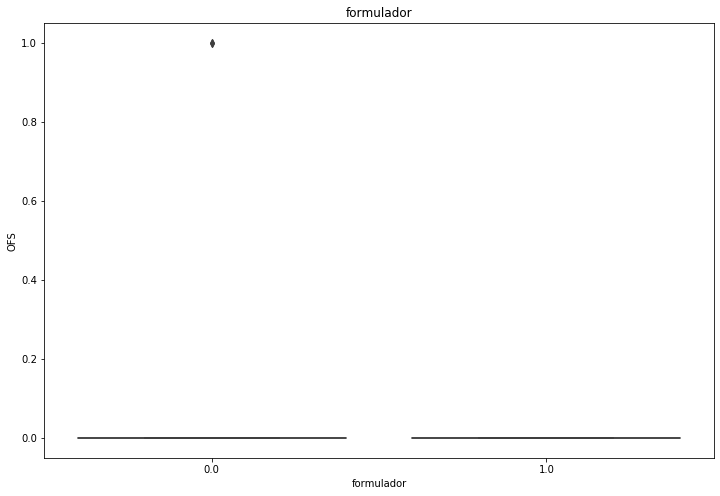

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'formulador')

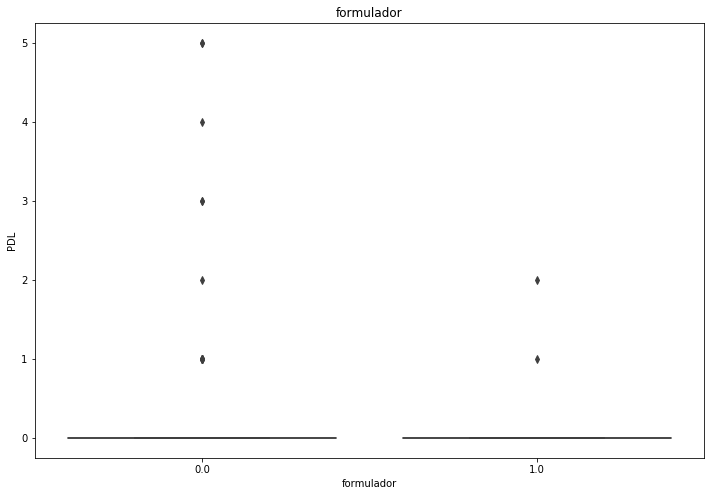

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'formulador')

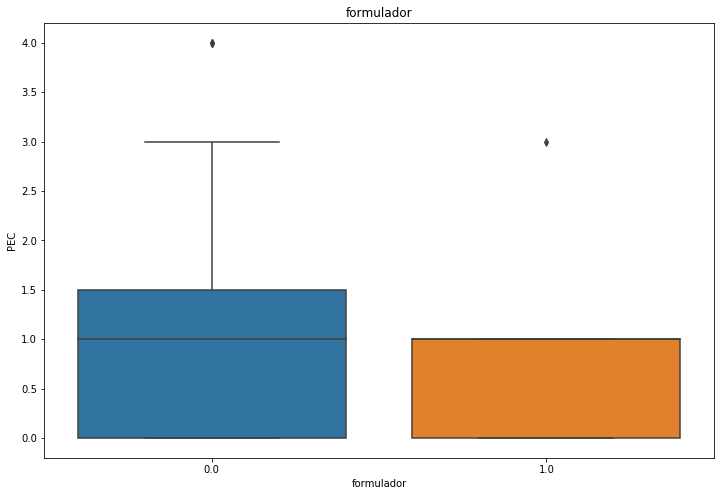

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'formulador')

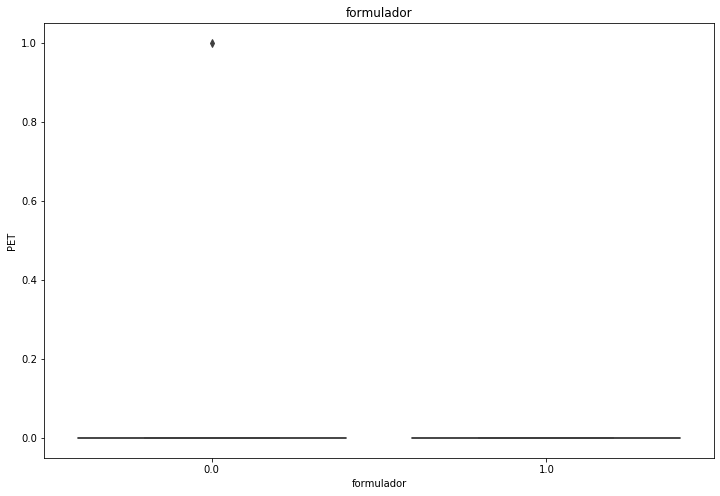

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'formulador')

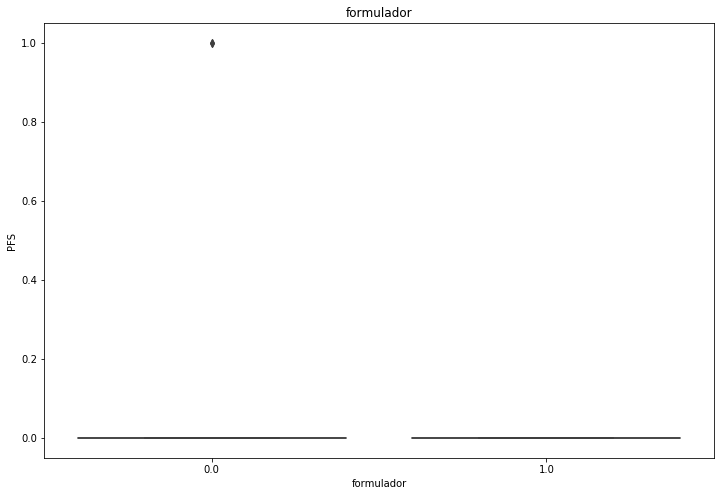

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'formulador')

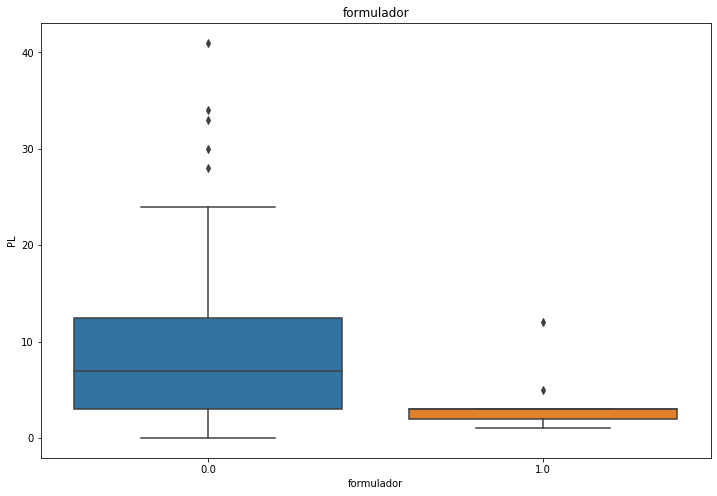

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'formulador')

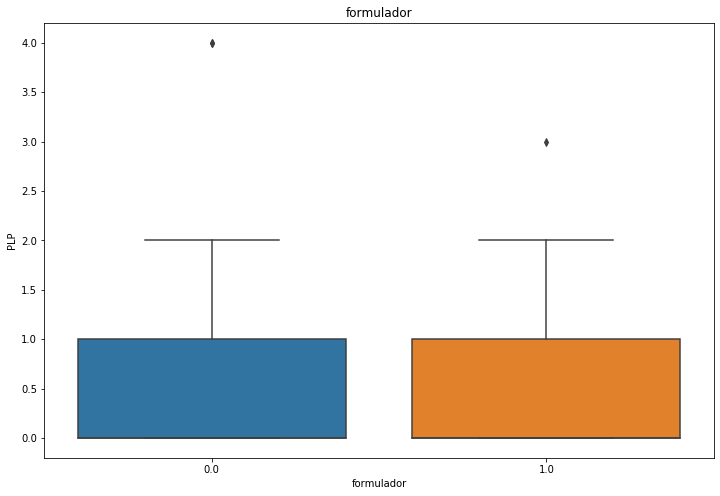

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'formulador')

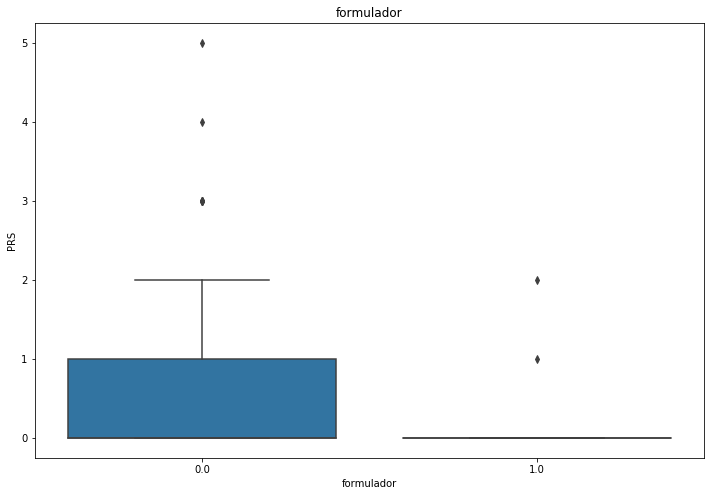

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'formulador')

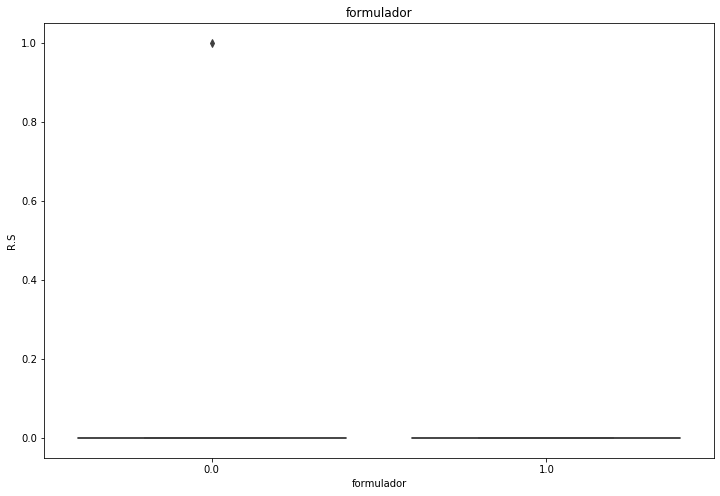

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'formulador')

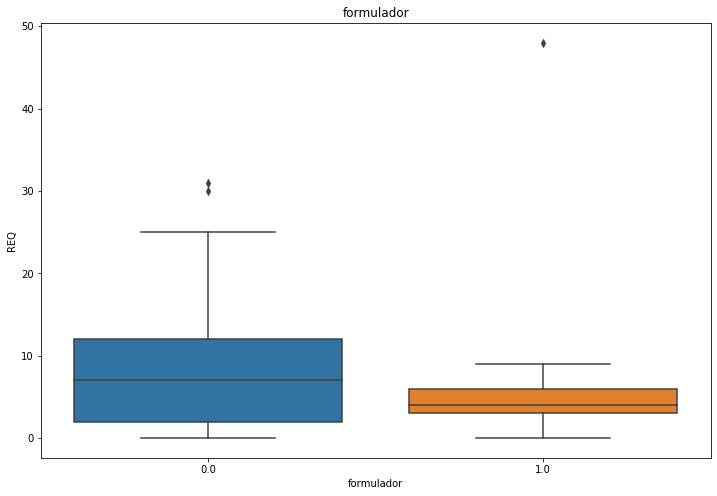

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'formulador')

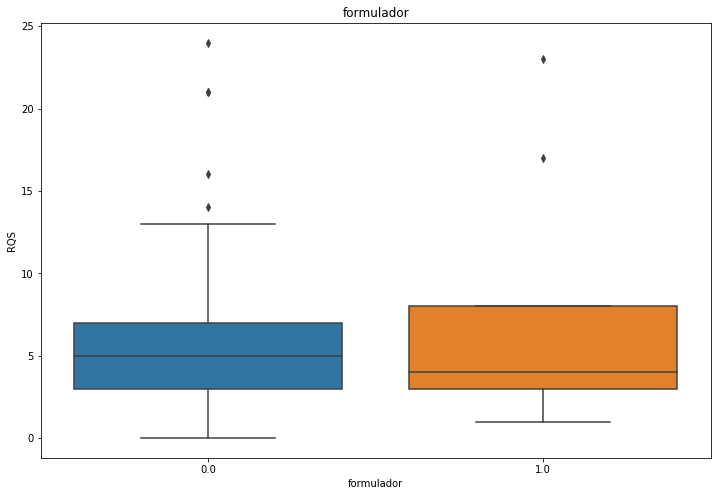

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'formulador')

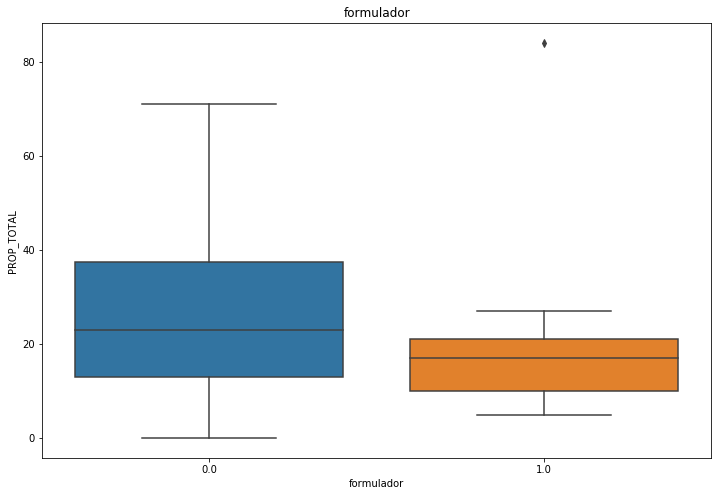

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'formulador')

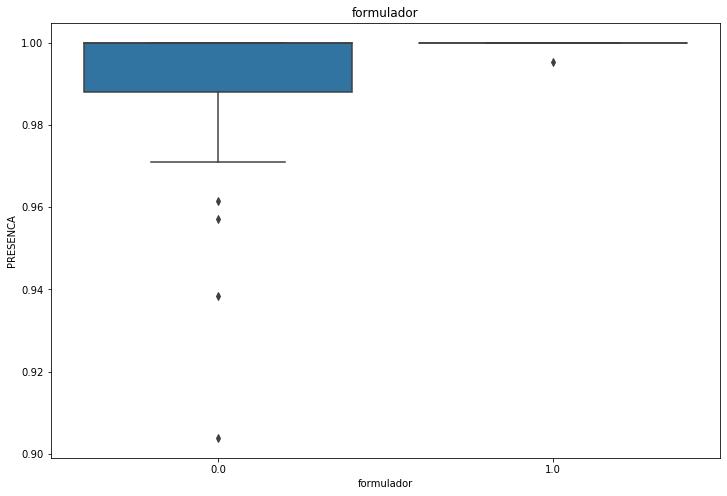

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'formulador')

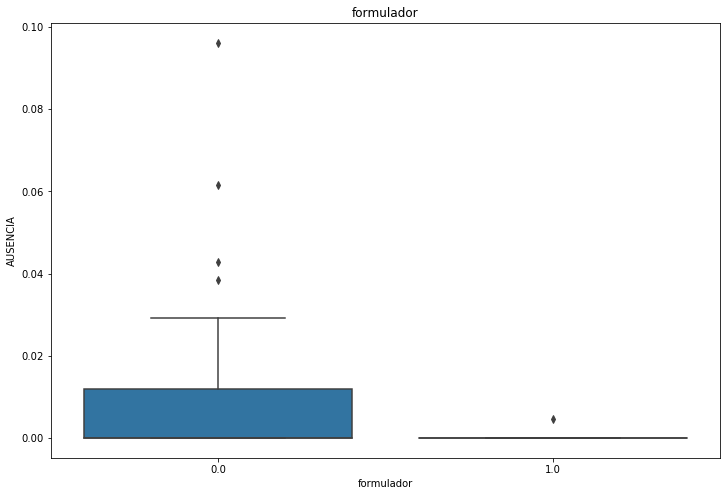

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'formulador')

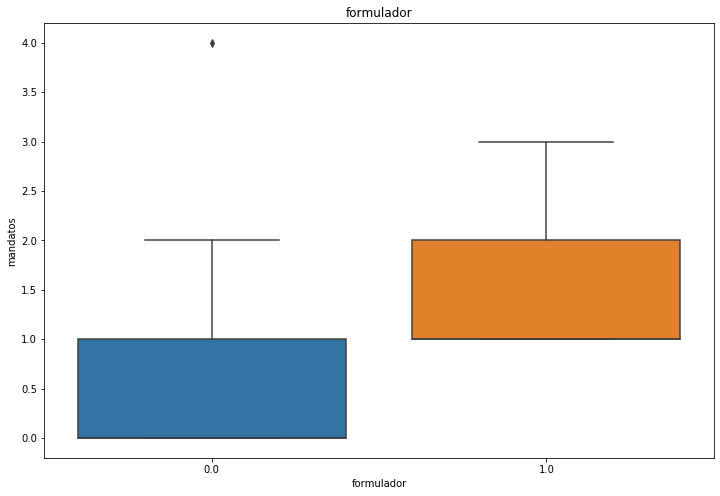

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'formulador')

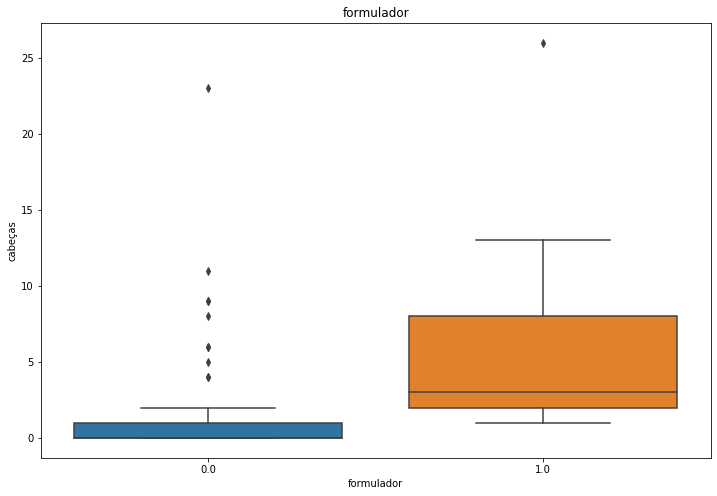

Text(0.5, 0, 'formulador')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'formulador')

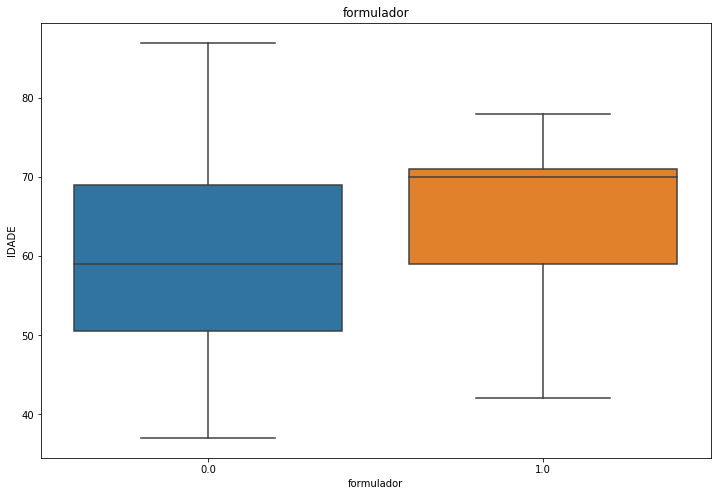

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'negociador')

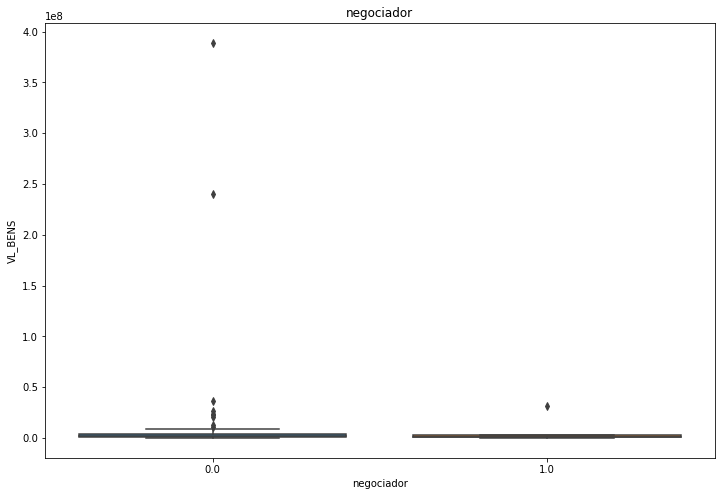

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'negociador')

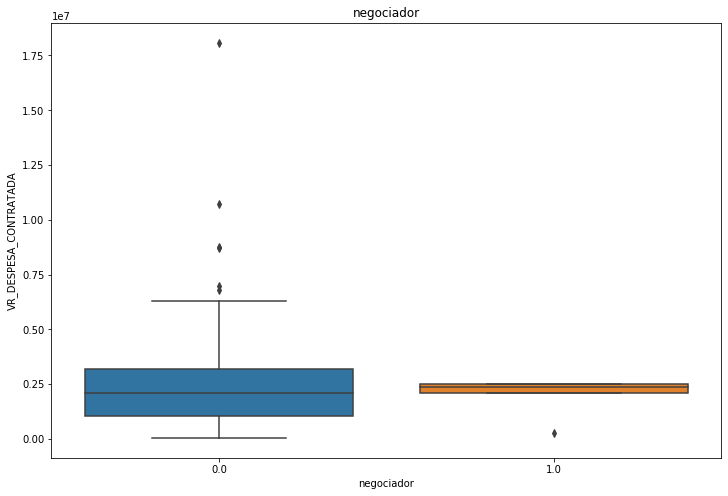

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'negociador')

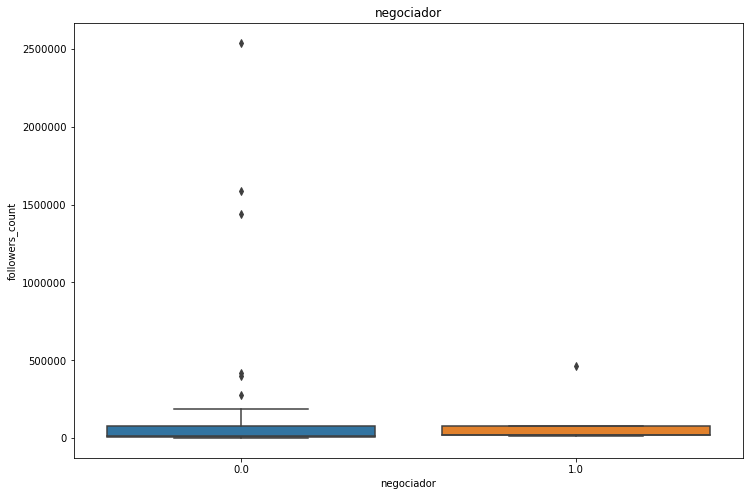

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'negociador')

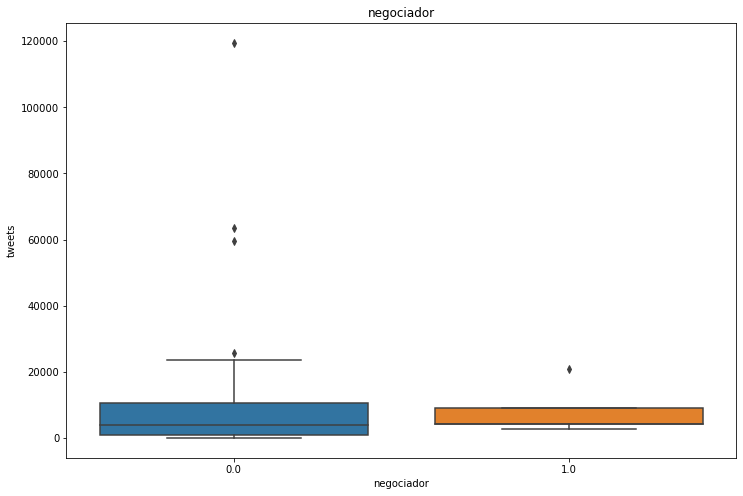

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'negociador')

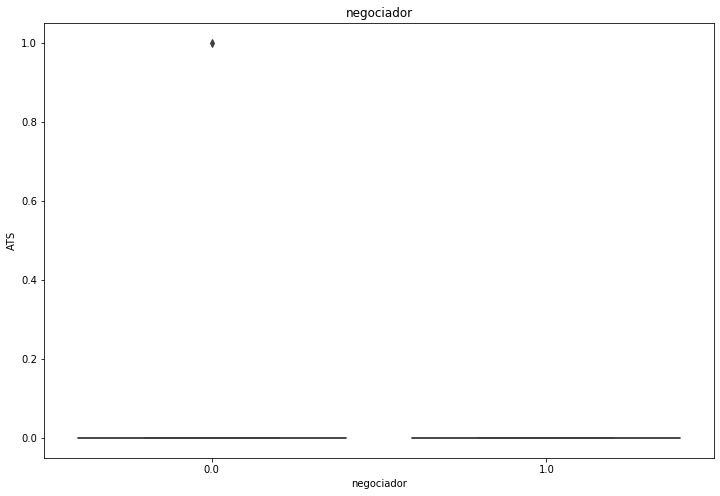

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'negociador')

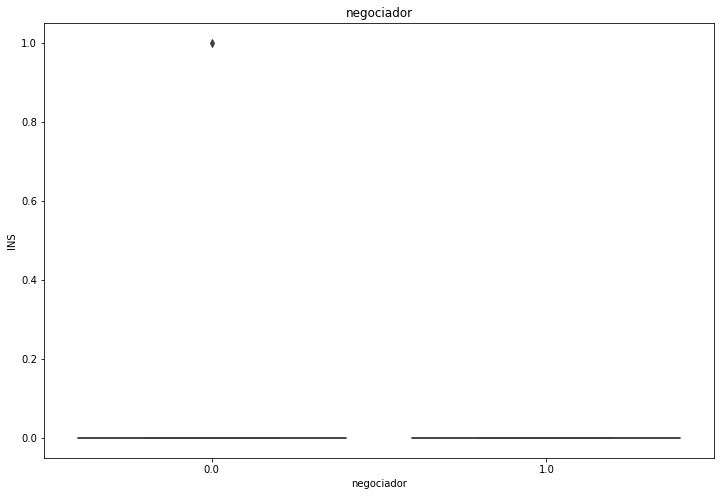

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'negociador')

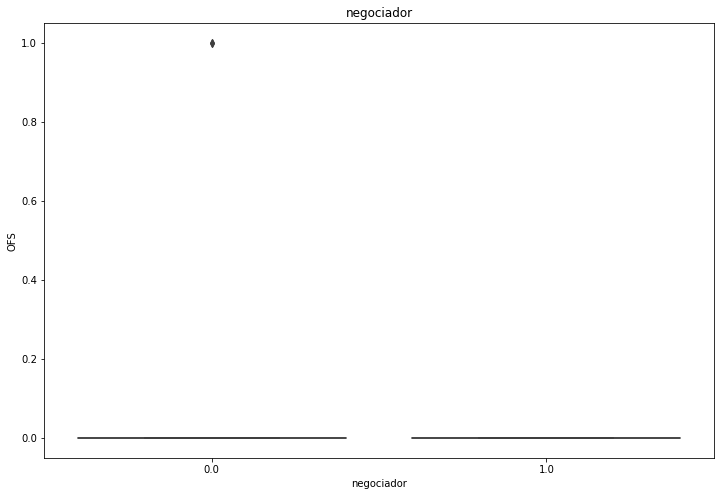

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'negociador')

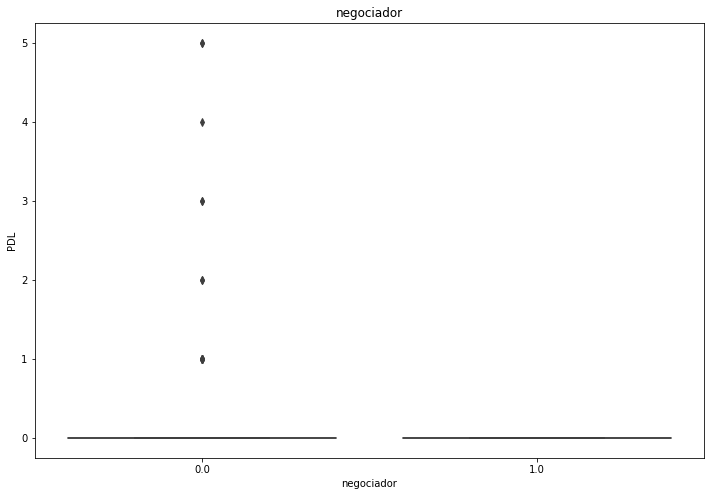

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'negociador')

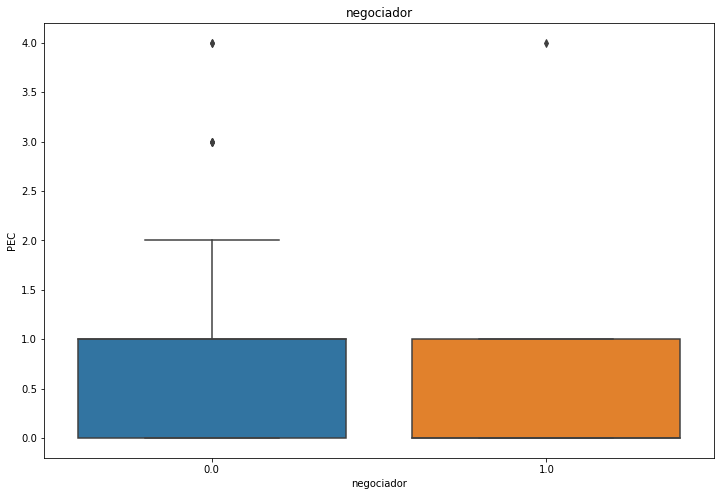

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'negociador')

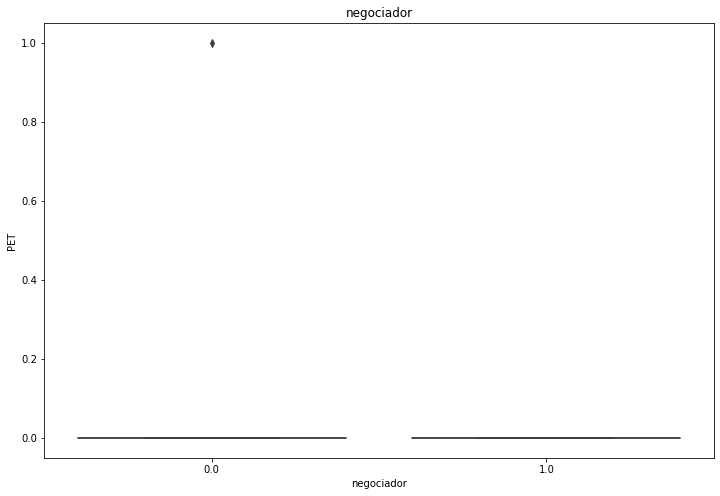

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'negociador')

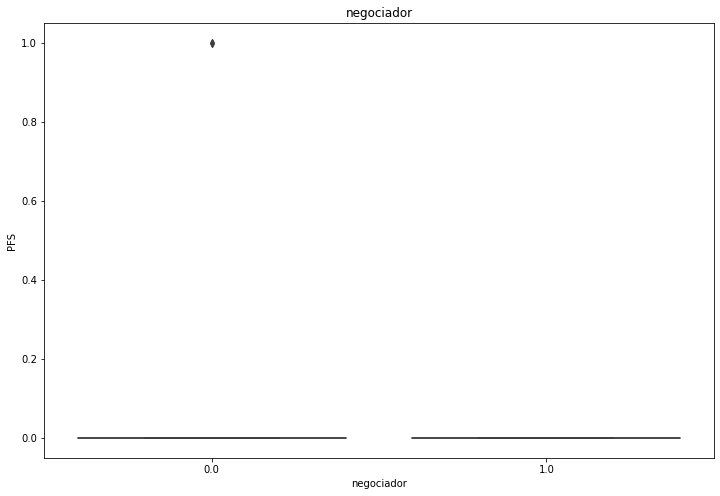

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'negociador')

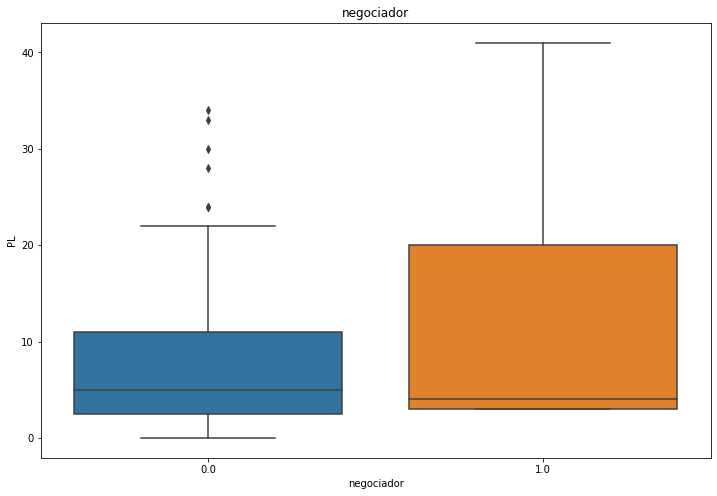

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'negociador')

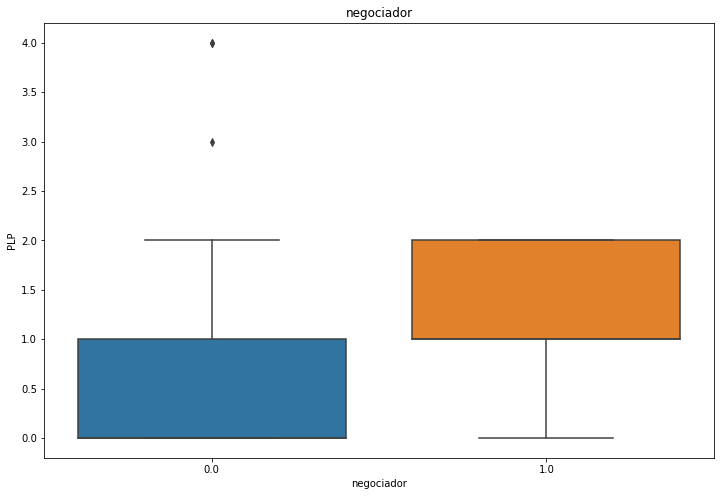

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'negociador')

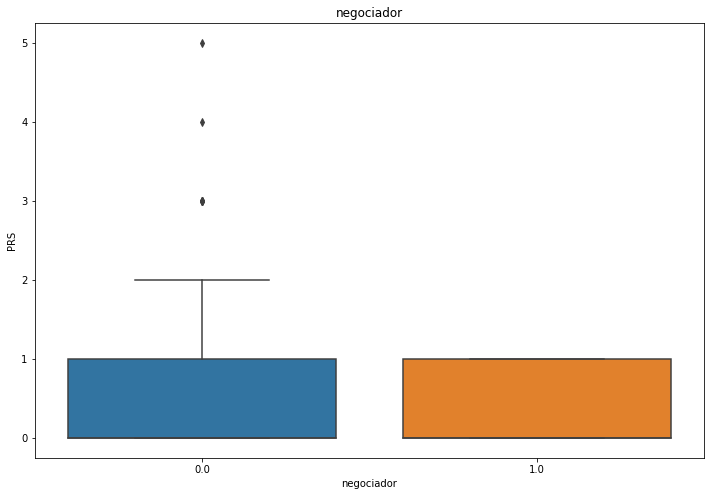

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'negociador')

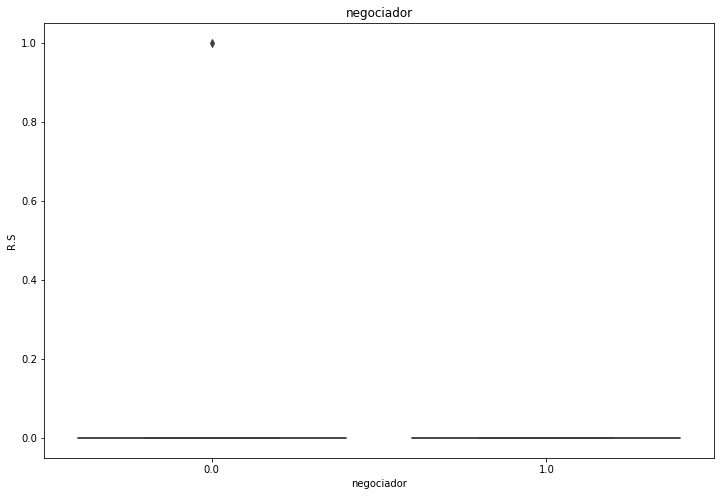

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'negociador')

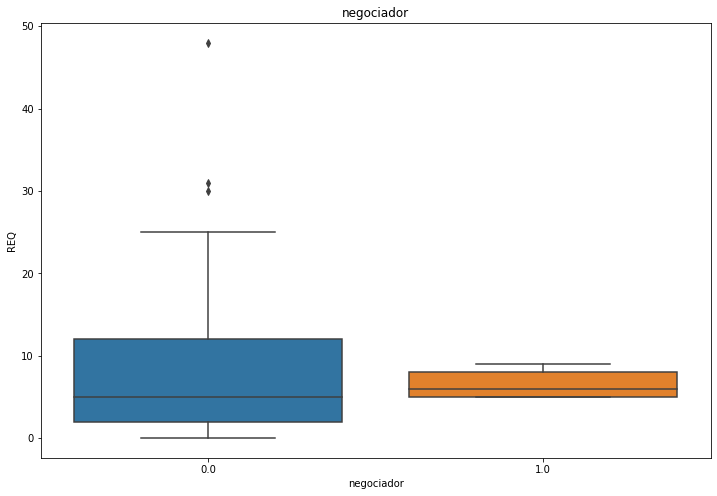

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'negociador')

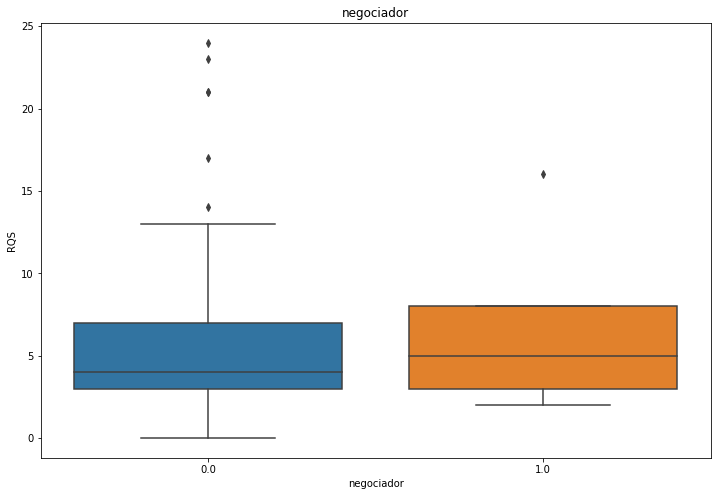

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'negociador')

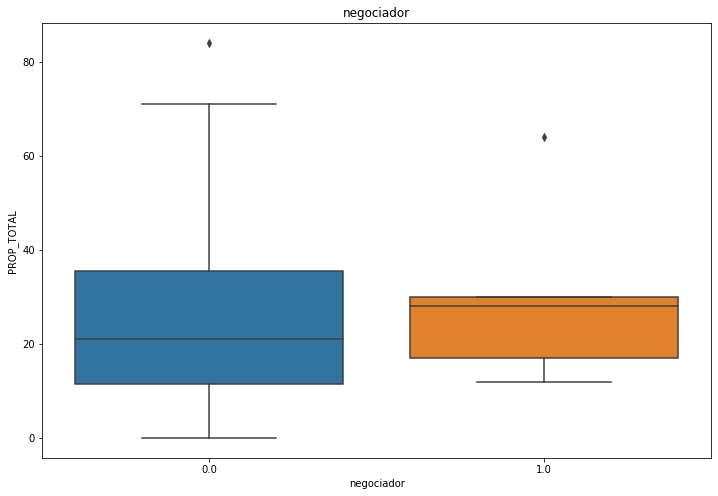

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'negociador')

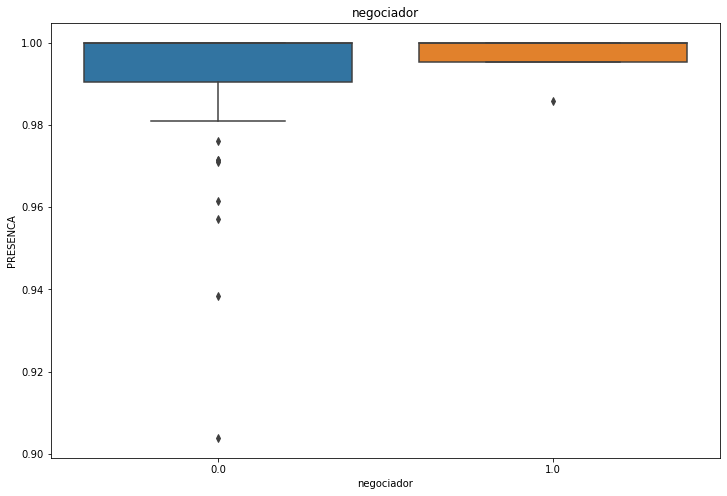

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'negociador')

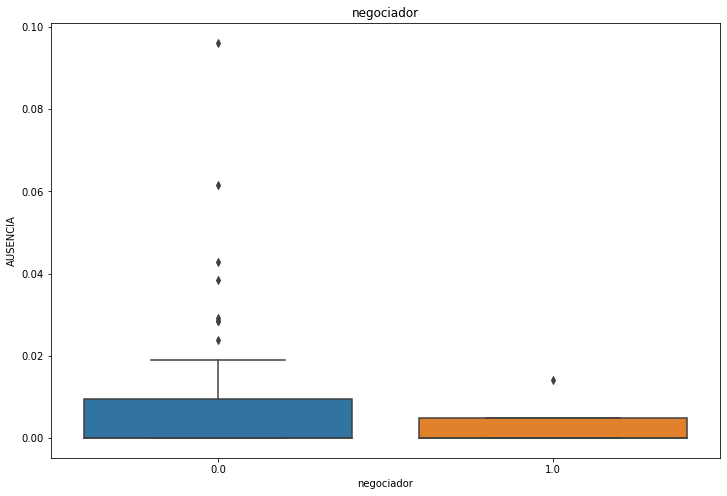

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'negociador')

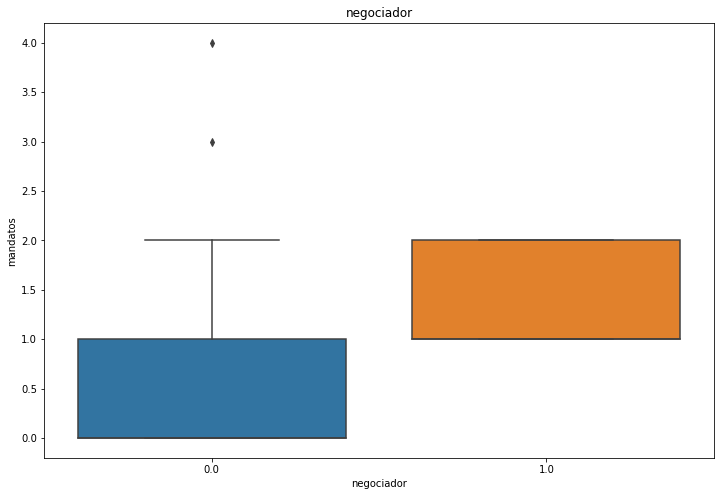

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'negociador')

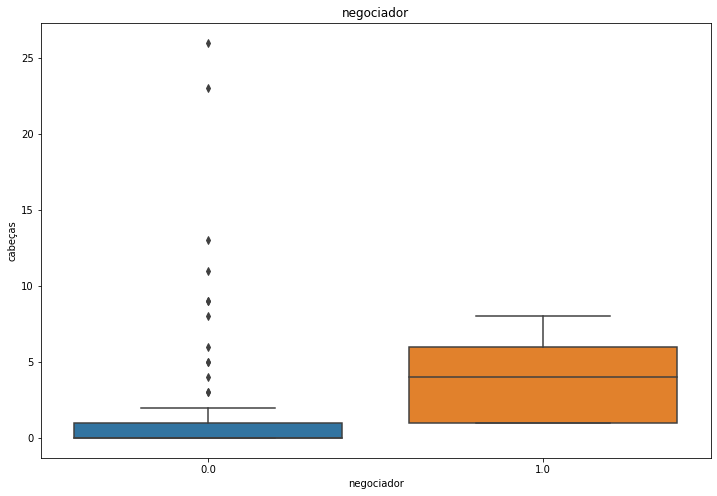

Text(0.5, 0, 'negociador')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'negociador')

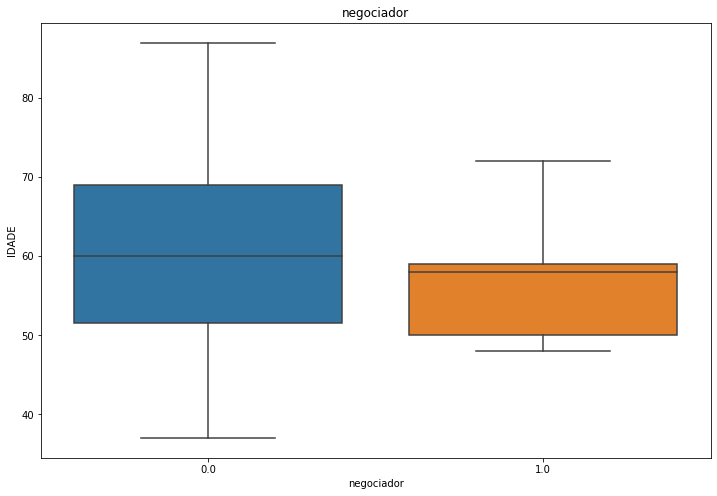

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

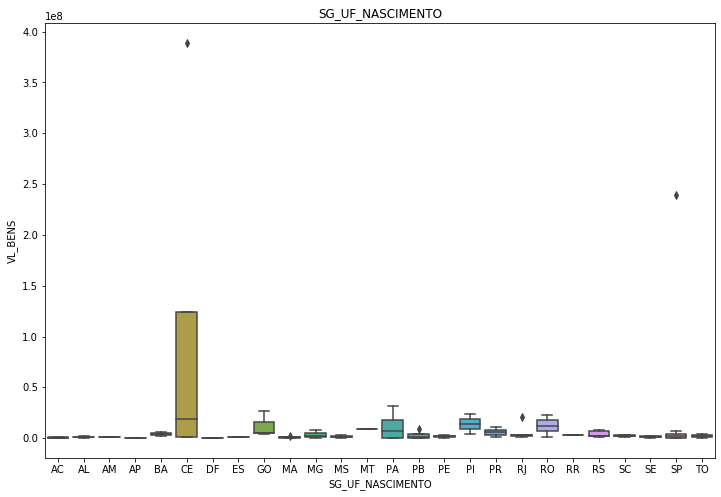

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

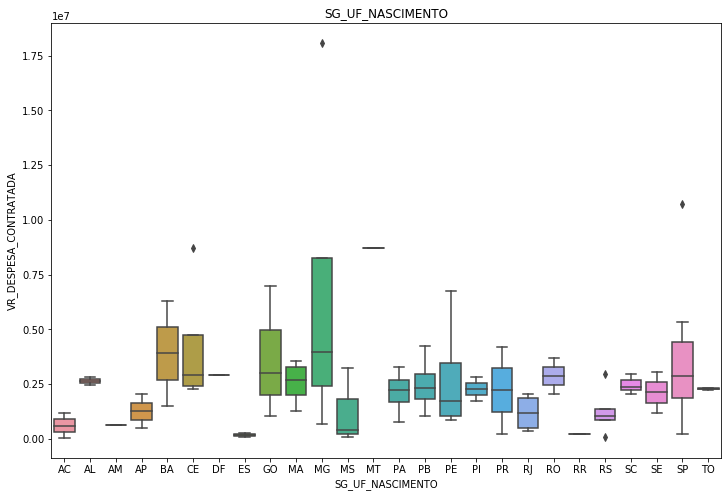

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

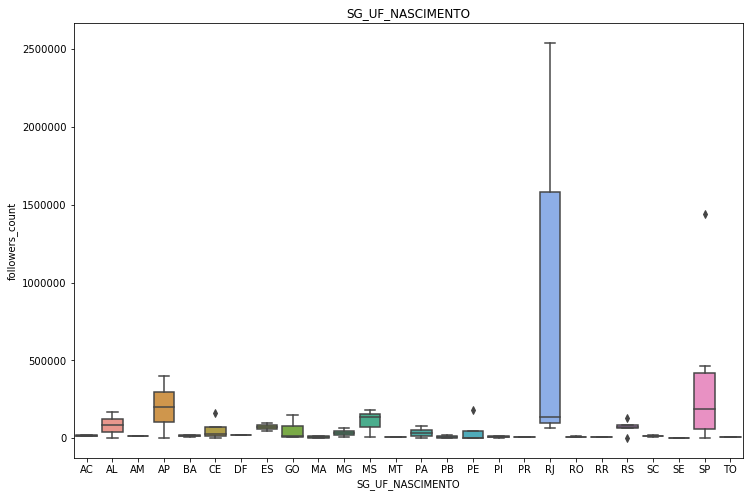

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

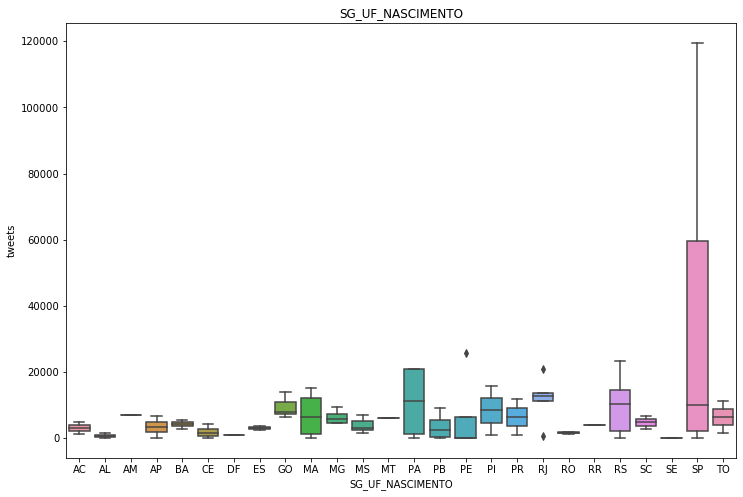

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

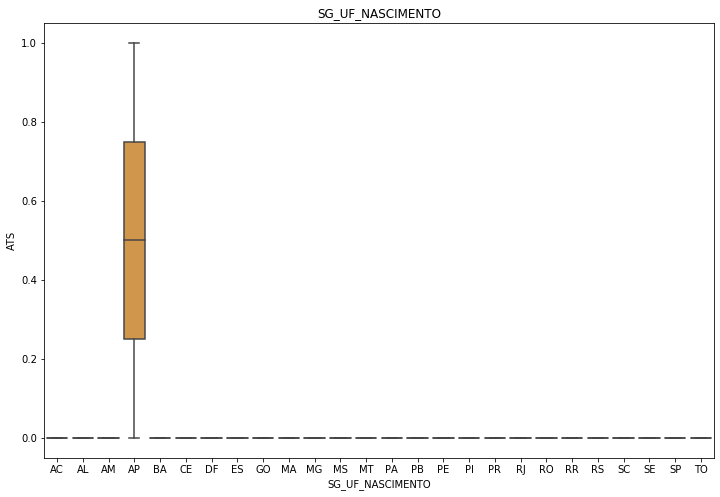

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

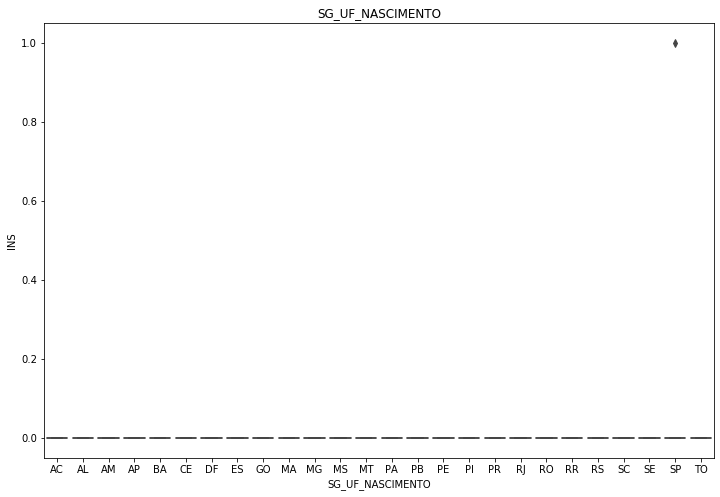

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

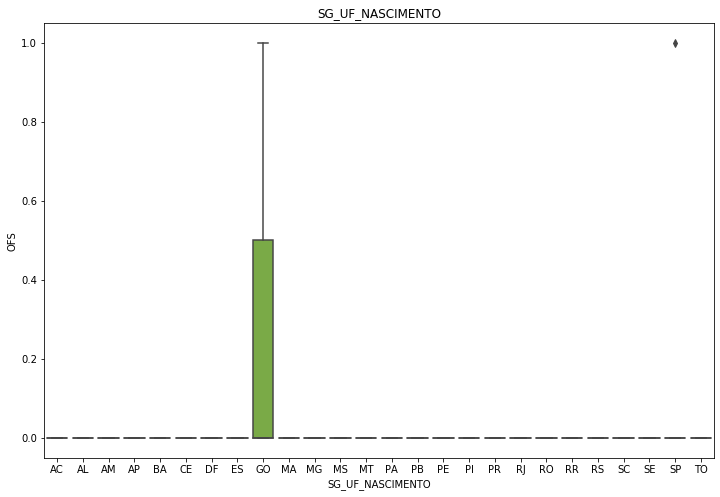

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

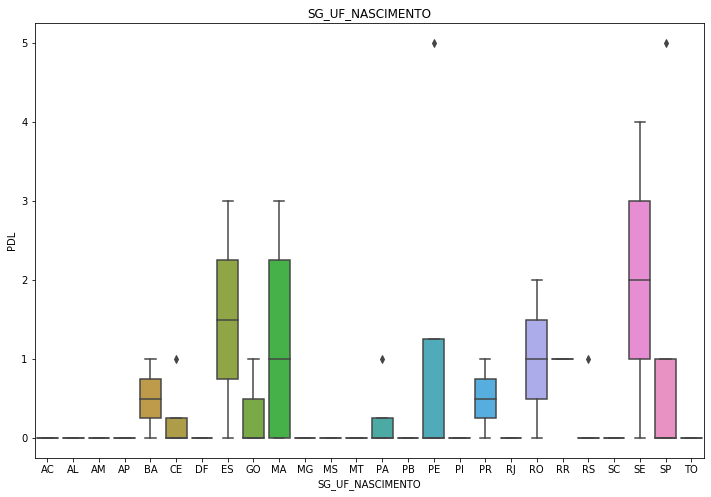

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

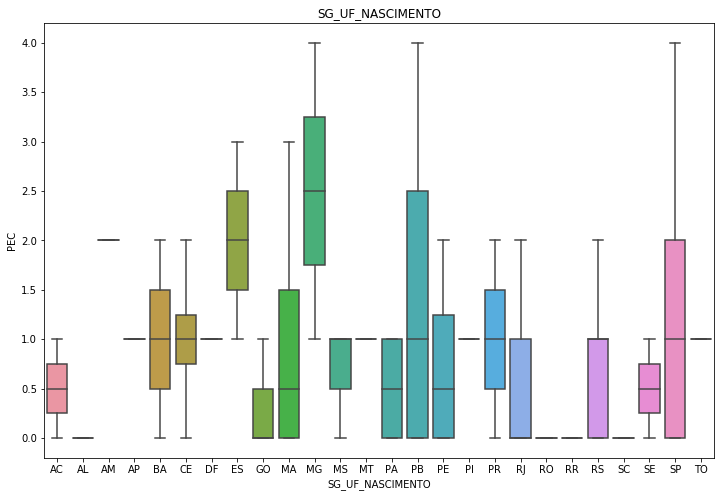

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

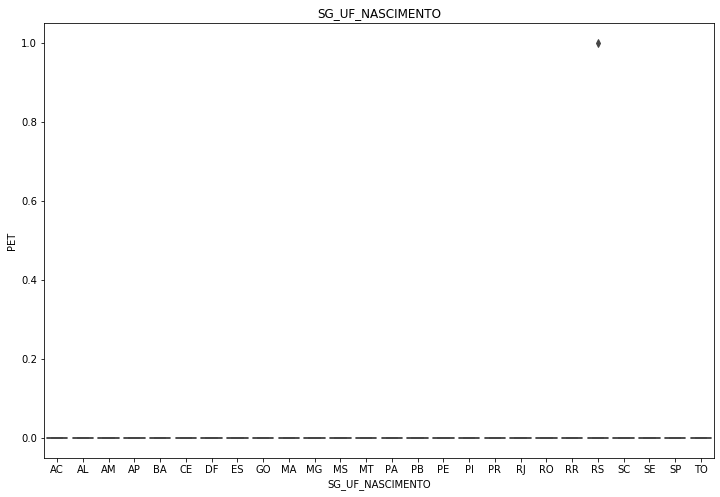

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

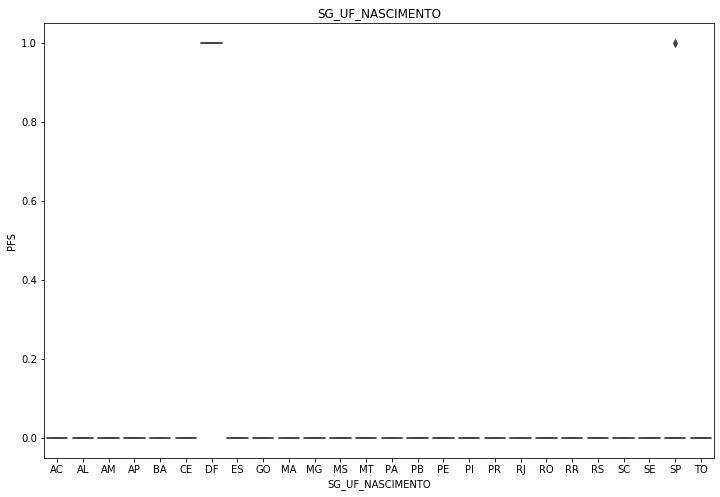

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

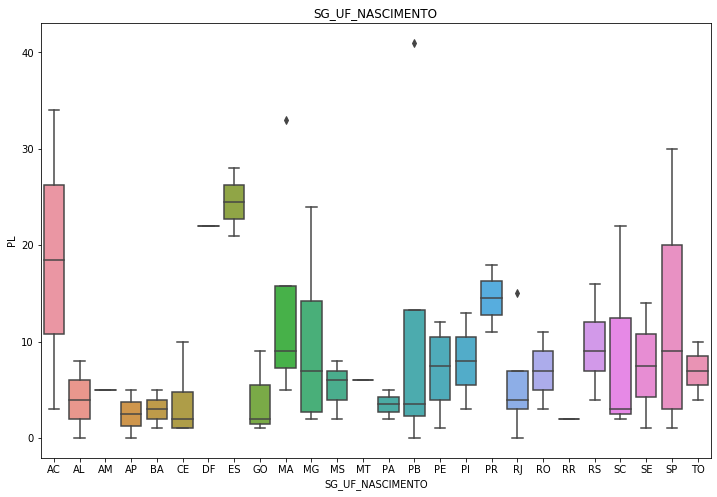

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

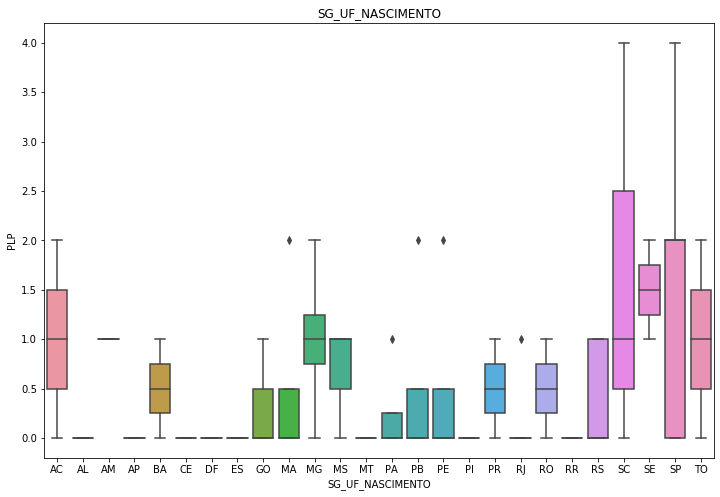

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

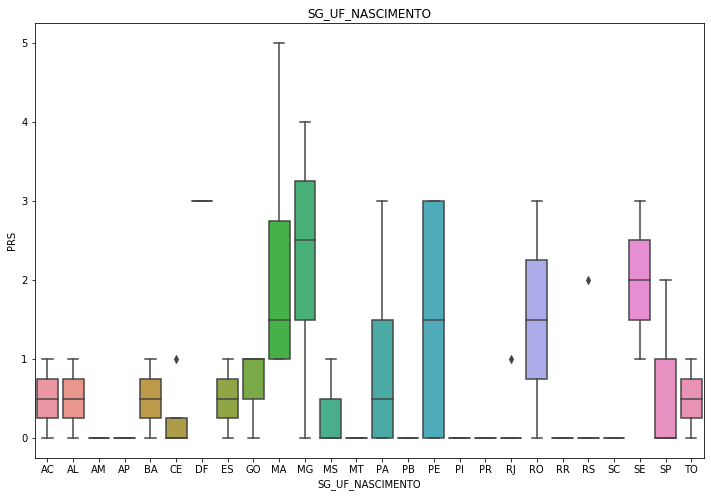

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

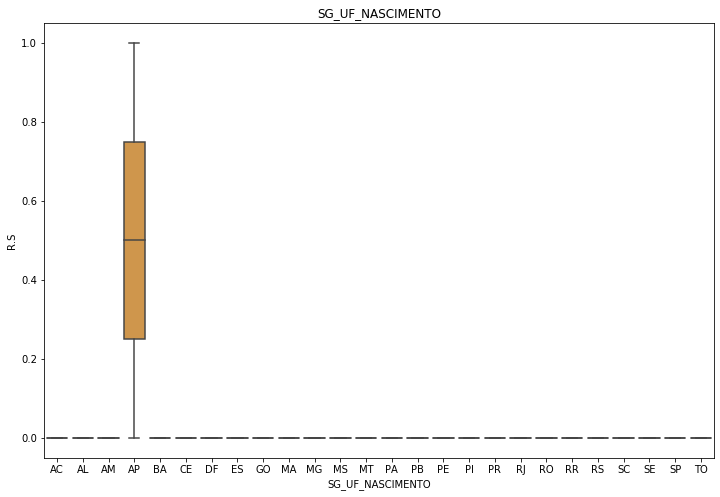

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

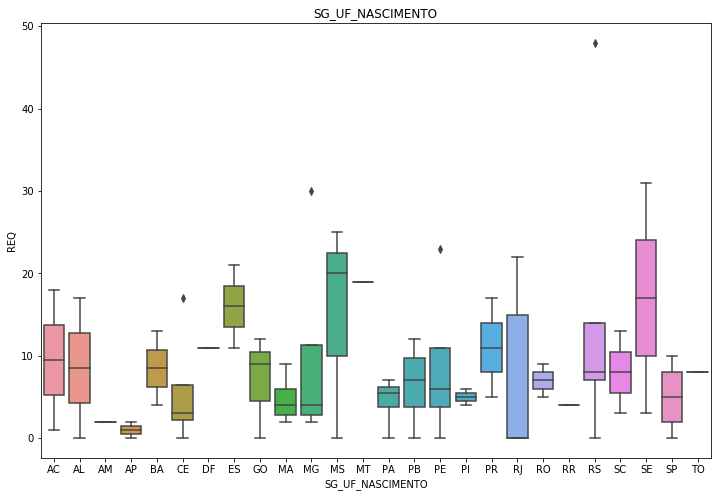

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

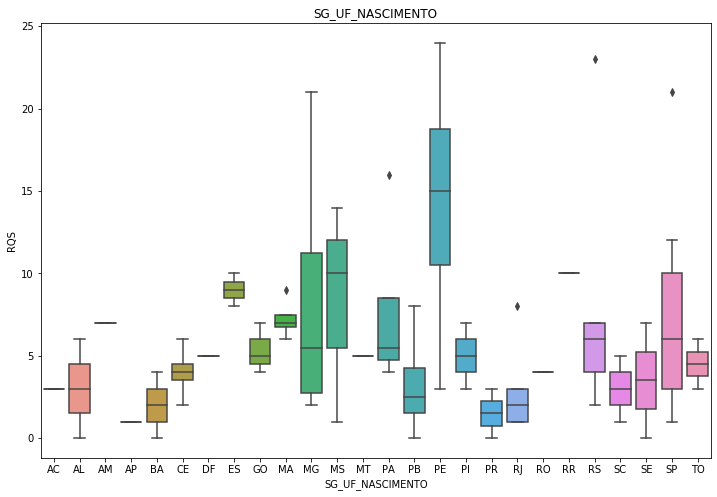

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

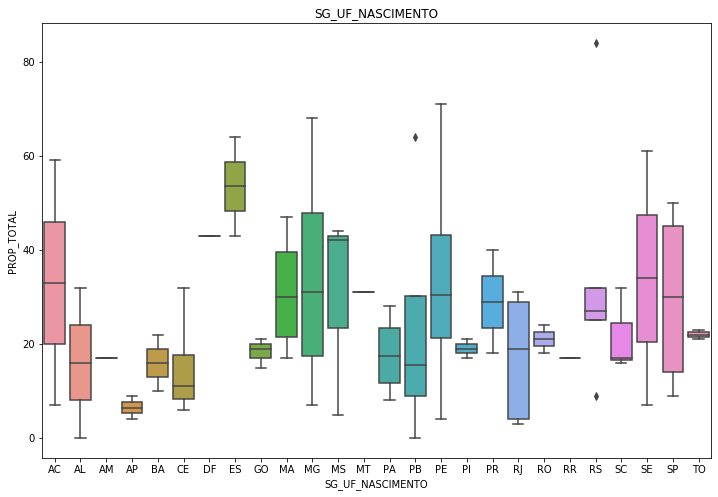

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

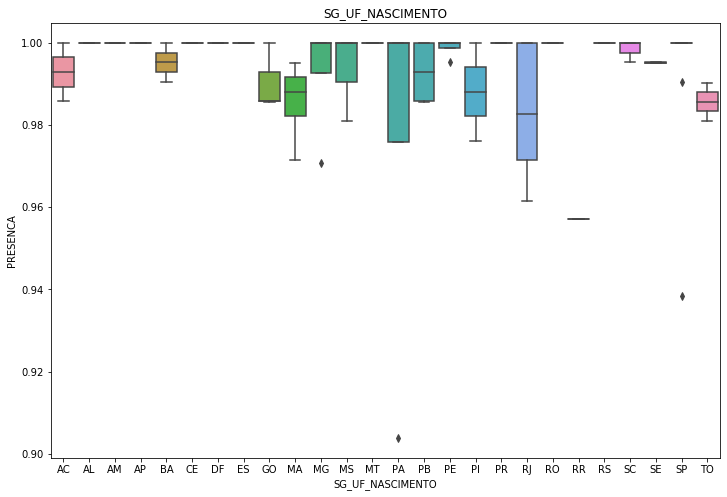

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

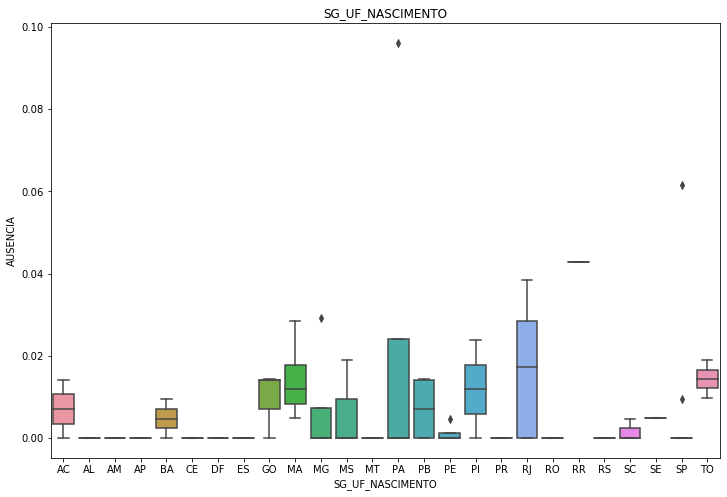

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

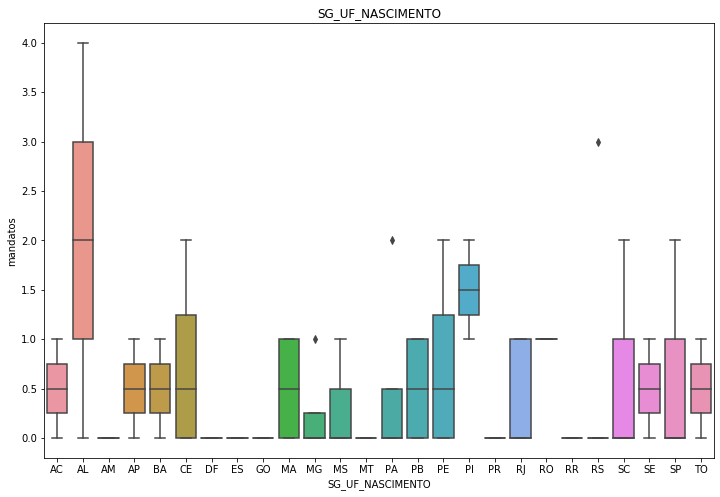

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

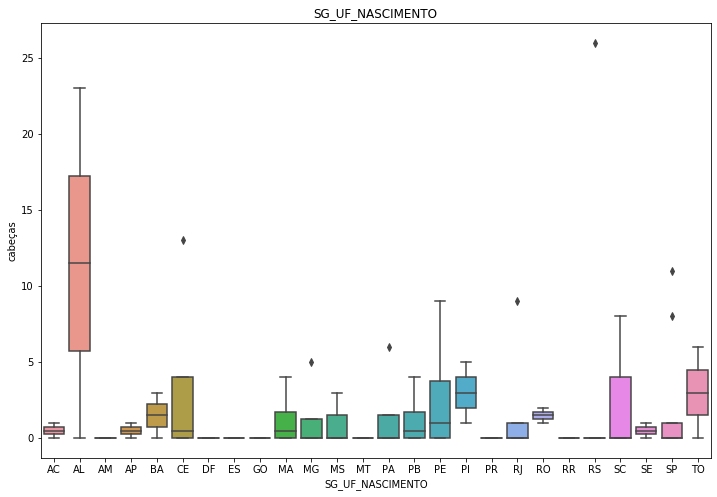

Text(0.5, 0, 'SG_UF_NASCIMENTO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'SG_UF_NASCIMENTO')

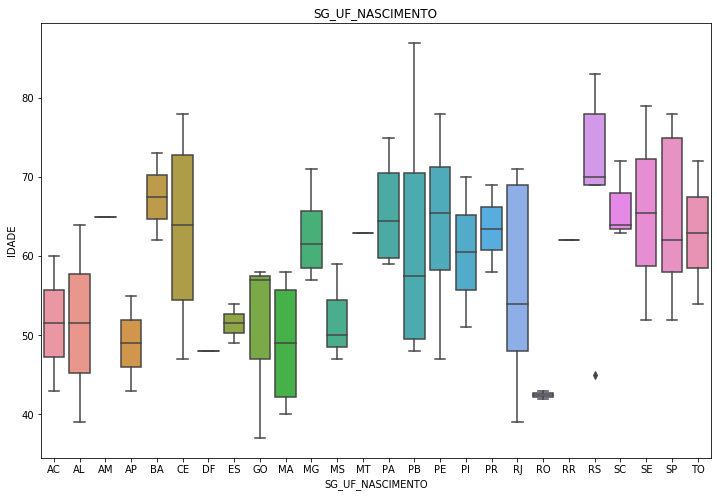

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'DS_GENERO')

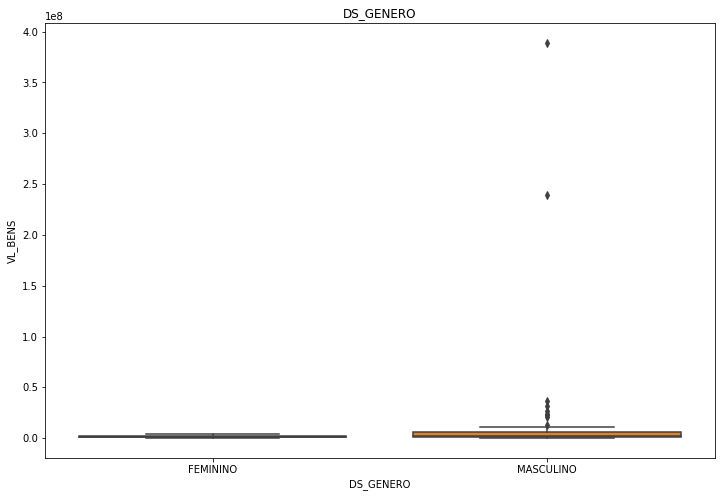

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'DS_GENERO')

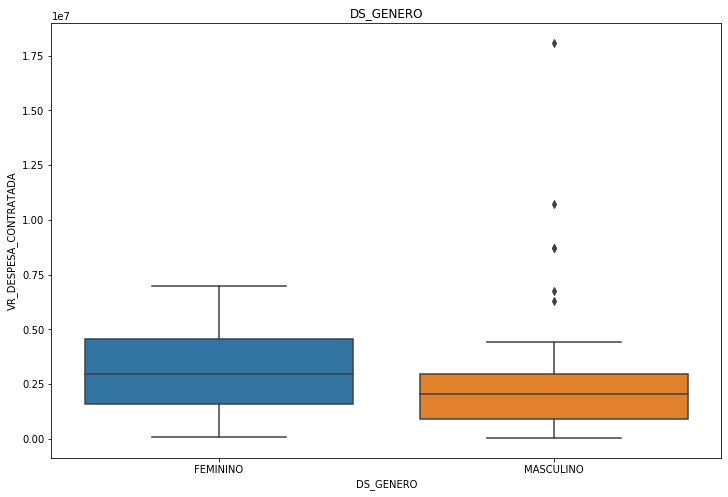

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'DS_GENERO')

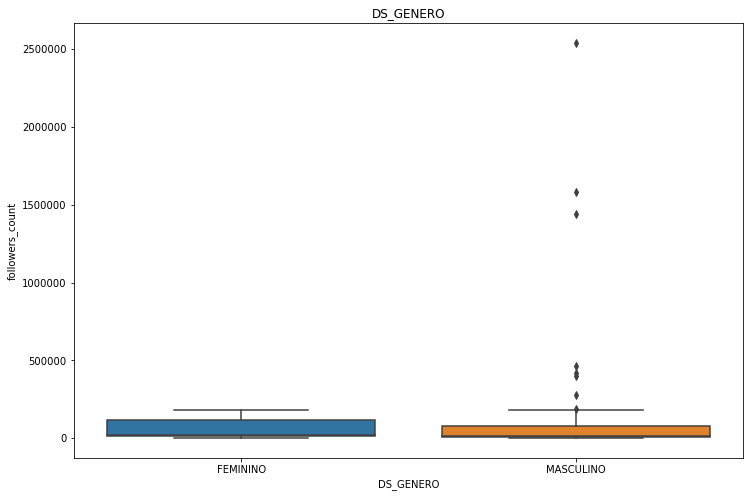

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'DS_GENERO')

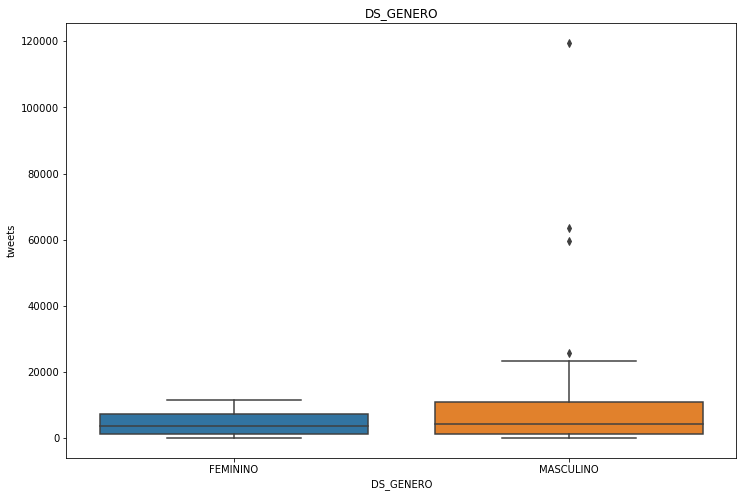

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'DS_GENERO')

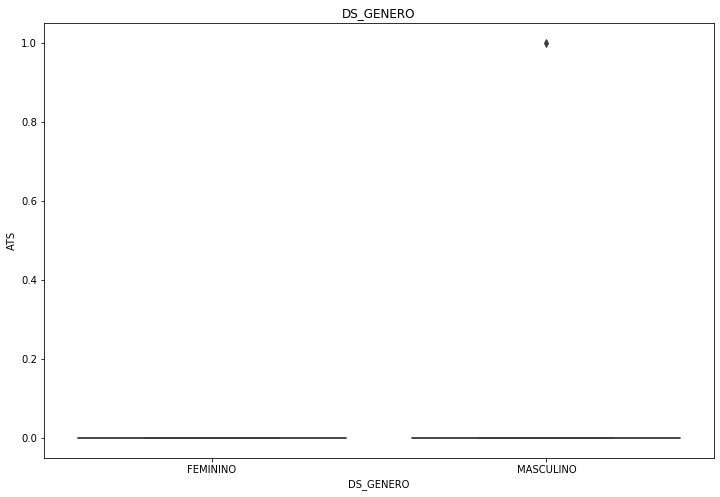

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'DS_GENERO')

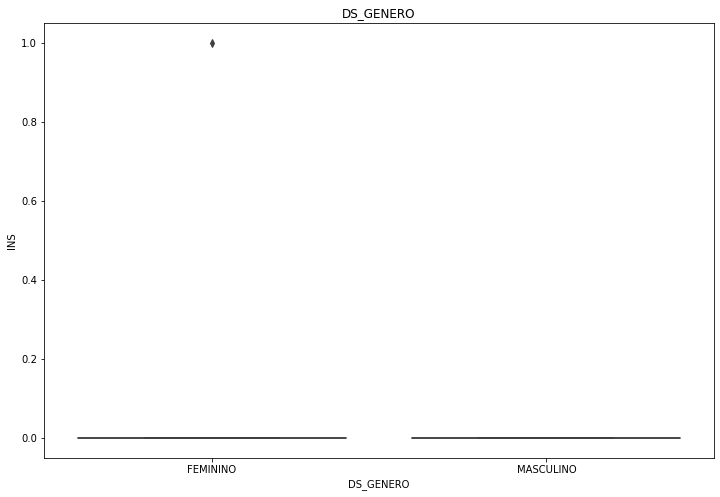

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'DS_GENERO')

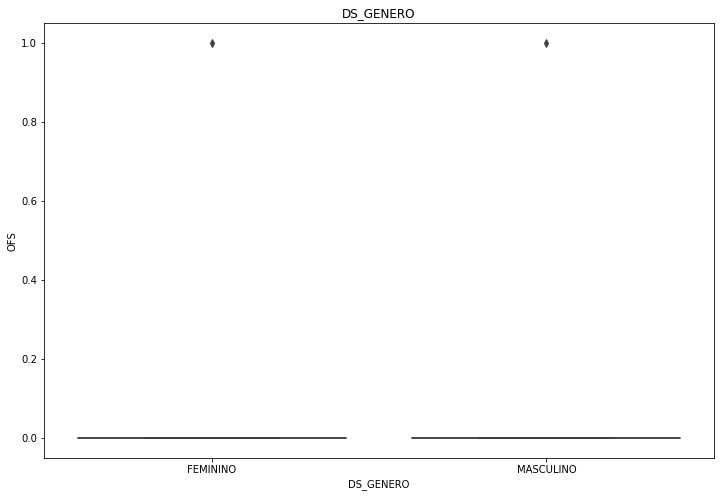

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'DS_GENERO')

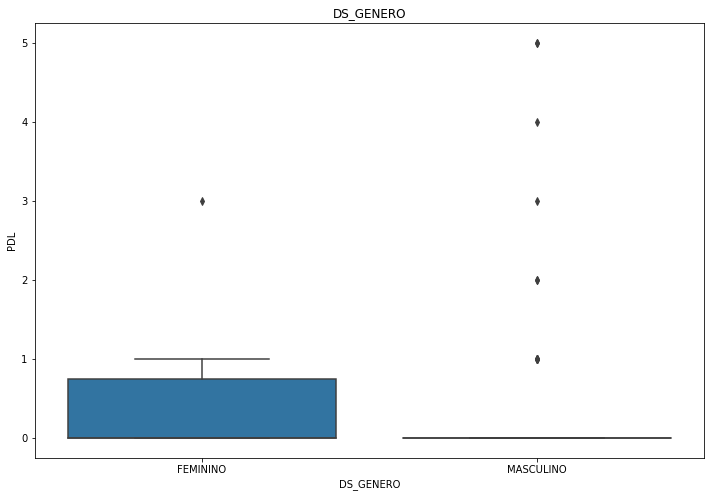

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'DS_GENERO')

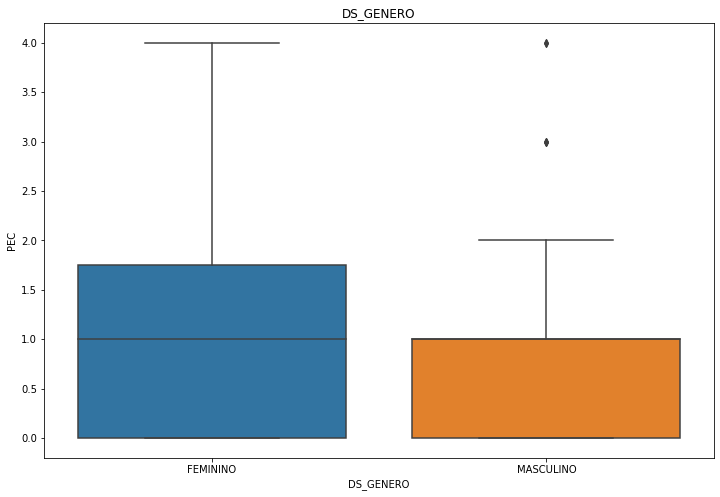

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'DS_GENERO')

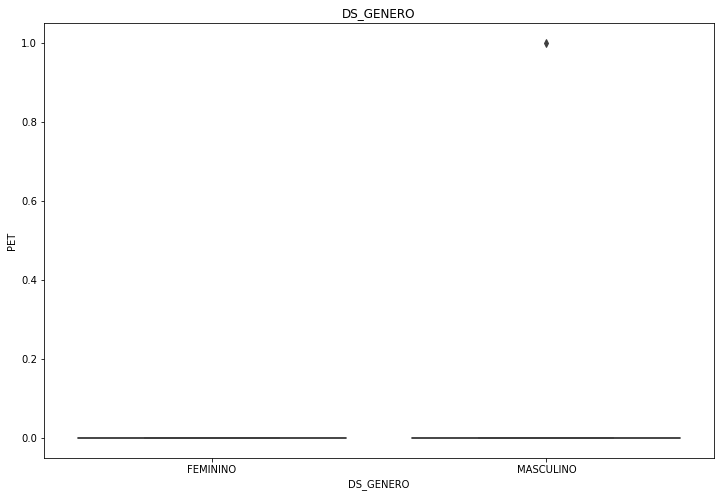

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'DS_GENERO')

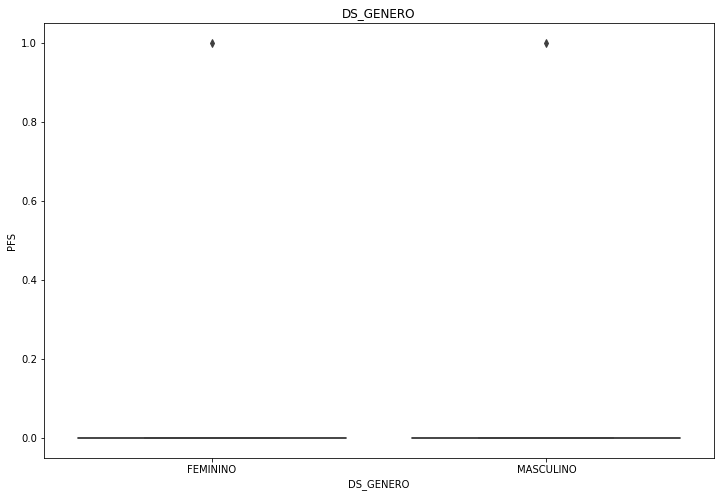

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'DS_GENERO')

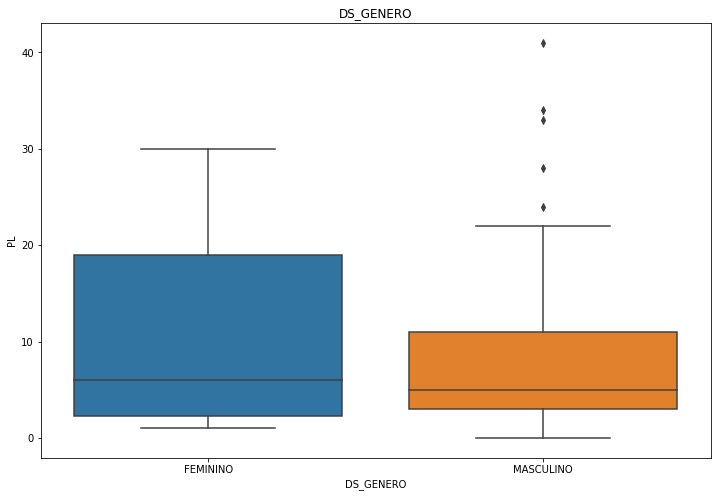

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'DS_GENERO')

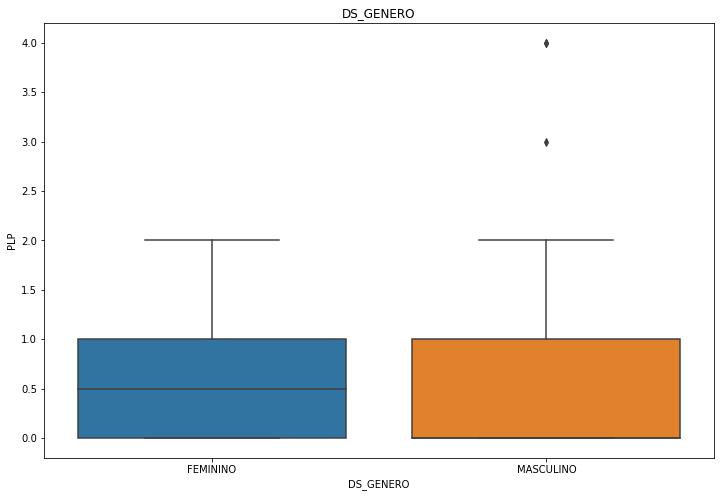

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'DS_GENERO')

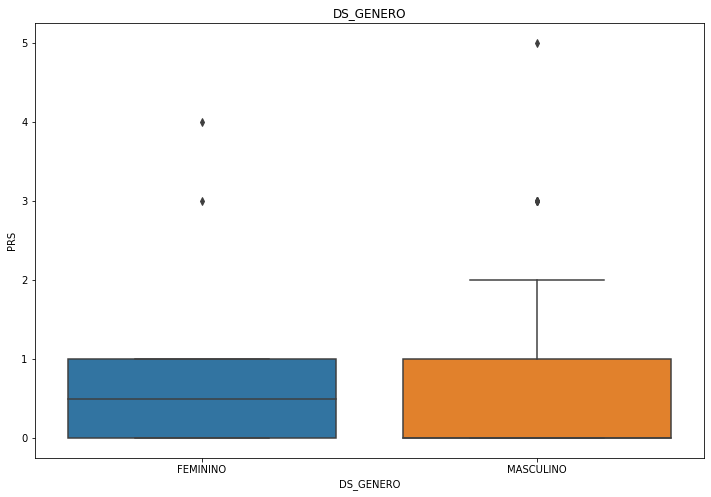

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'DS_GENERO')

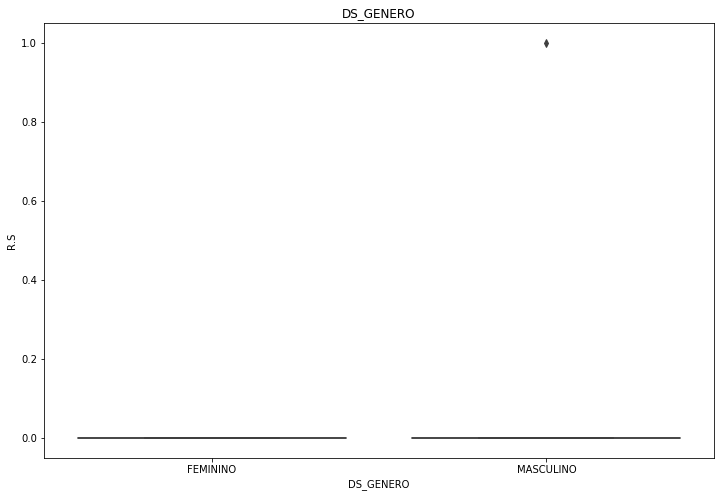

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'DS_GENERO')

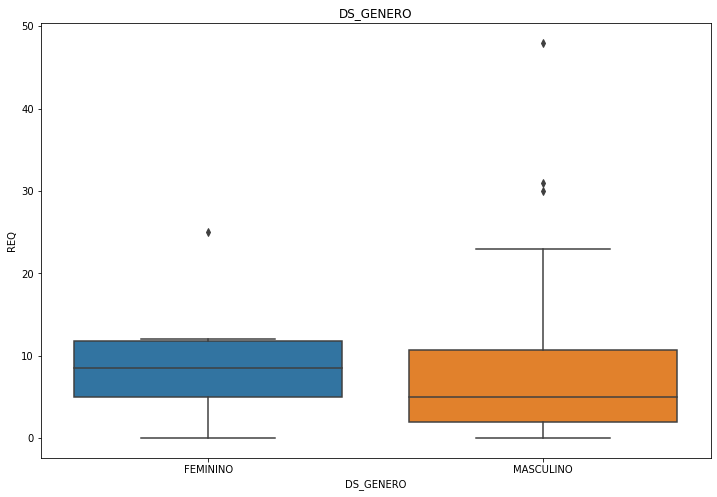

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'DS_GENERO')

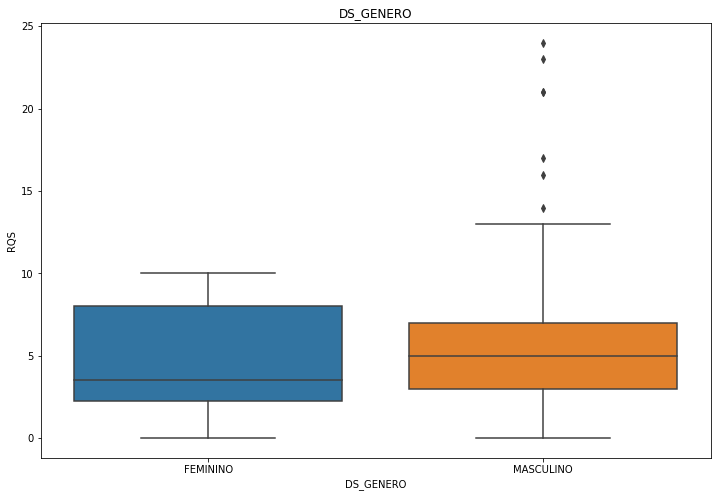

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'DS_GENERO')

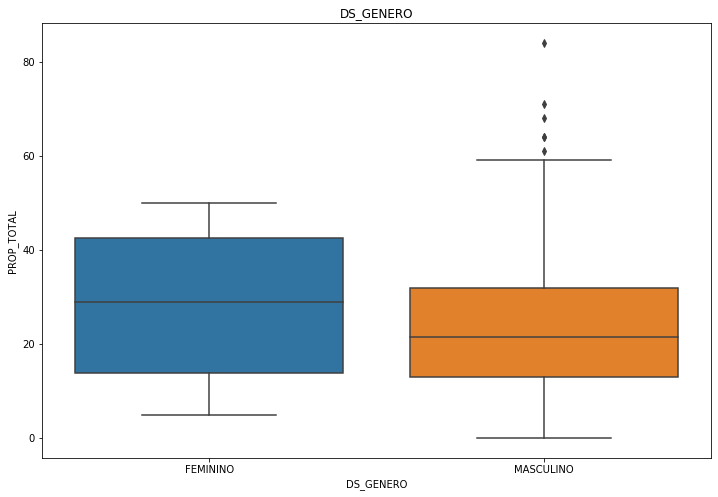

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'DS_GENERO')

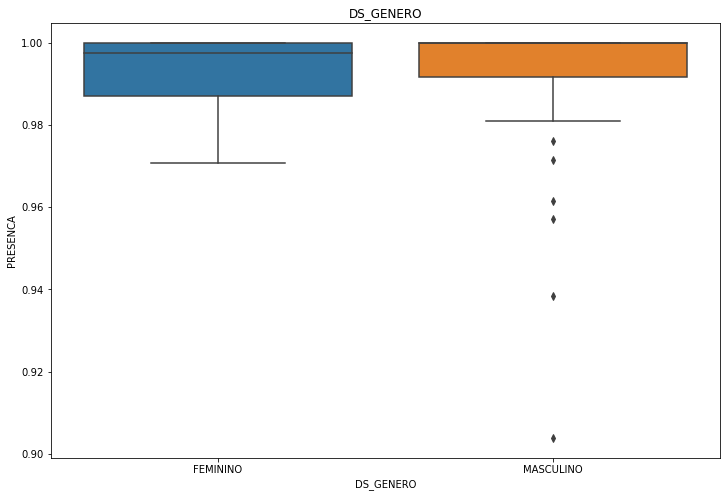

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'DS_GENERO')

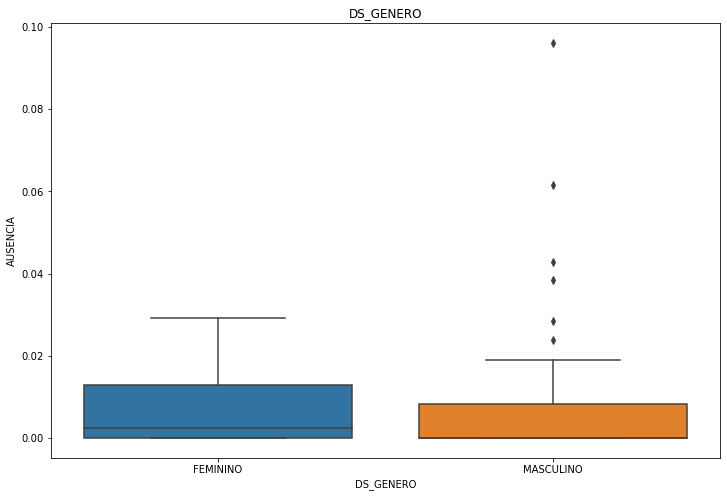

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'DS_GENERO')

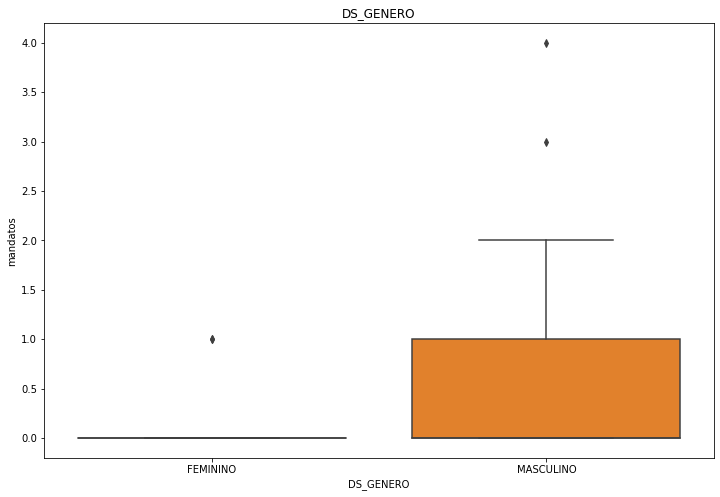

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'DS_GENERO')

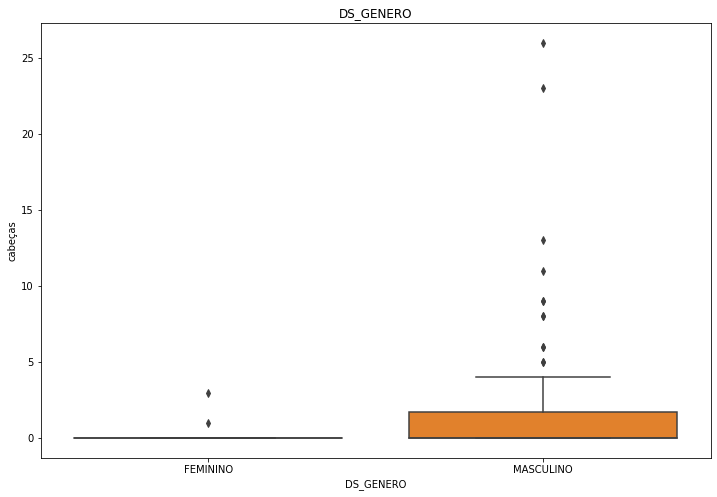

Text(0.5, 0, 'DS_GENERO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'DS_GENERO')

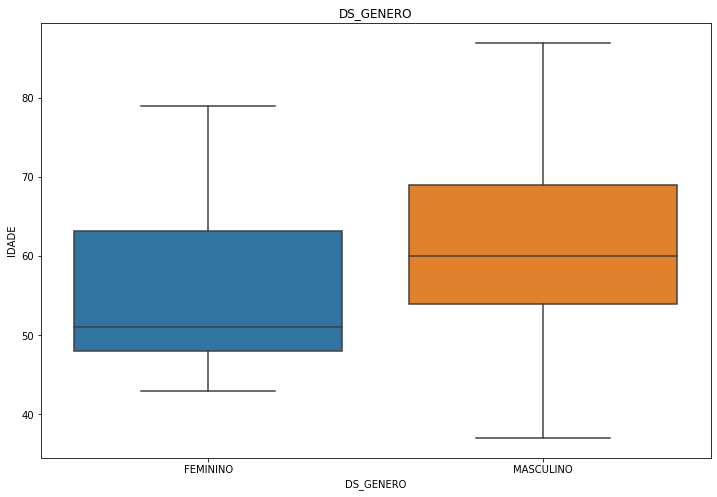

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

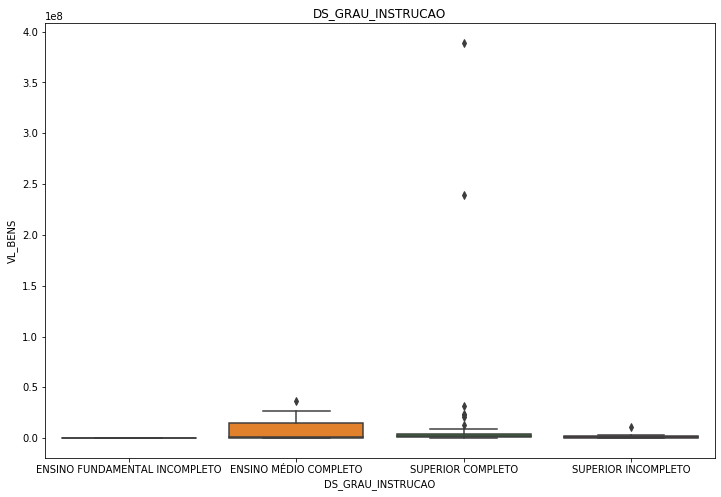

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

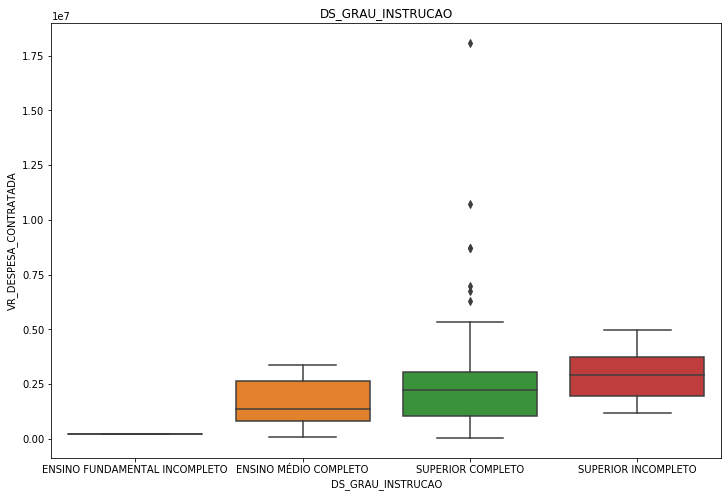

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

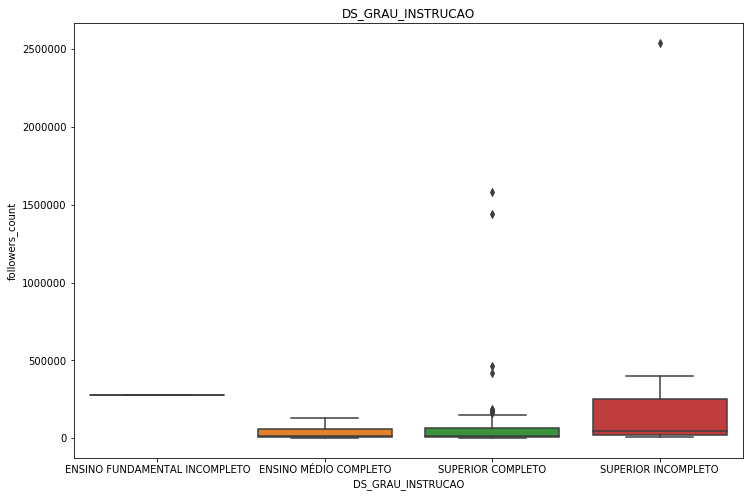

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

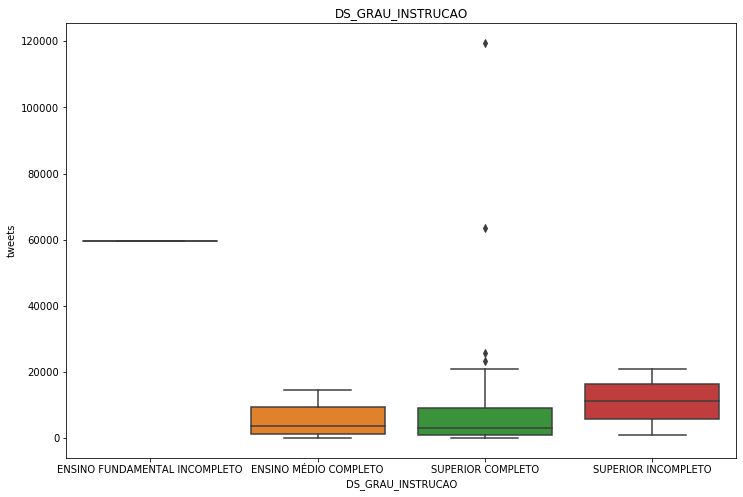

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

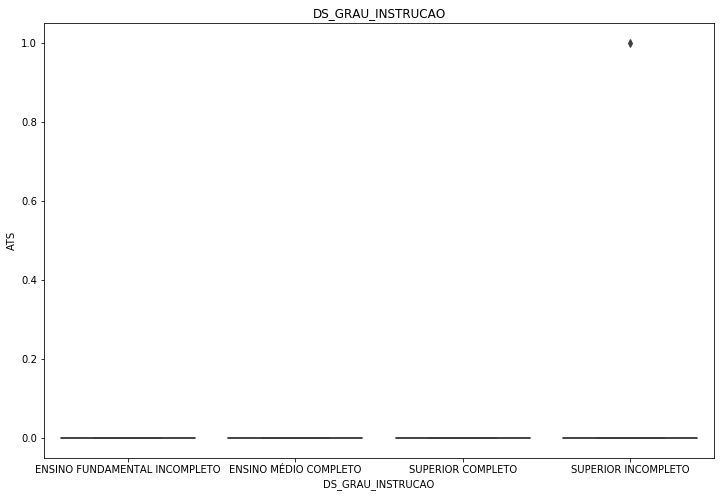

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

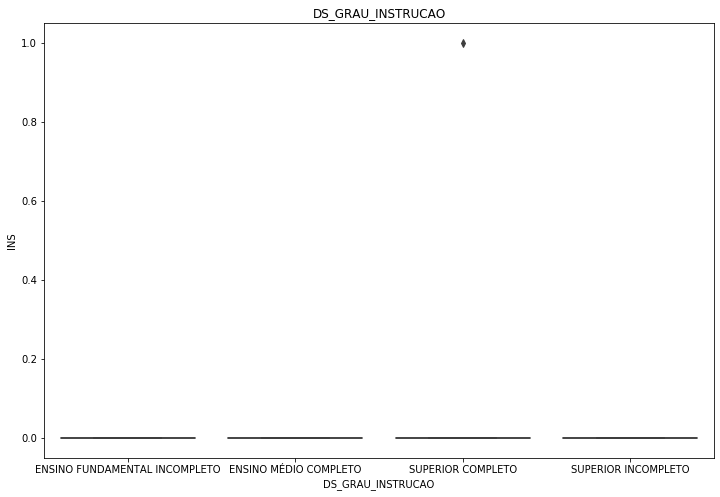

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

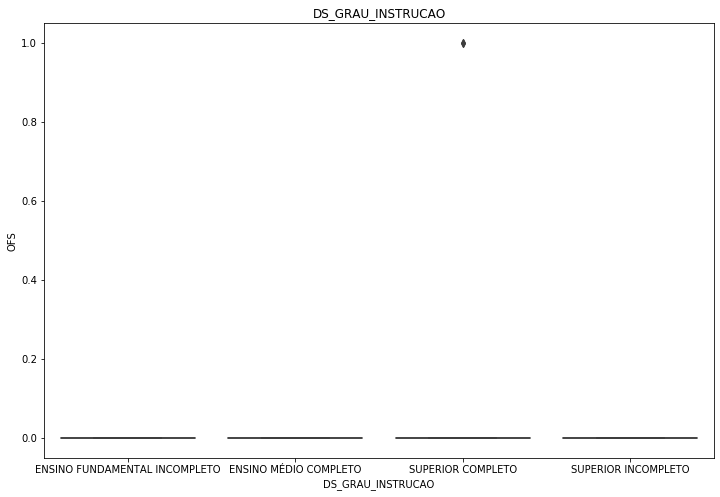

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

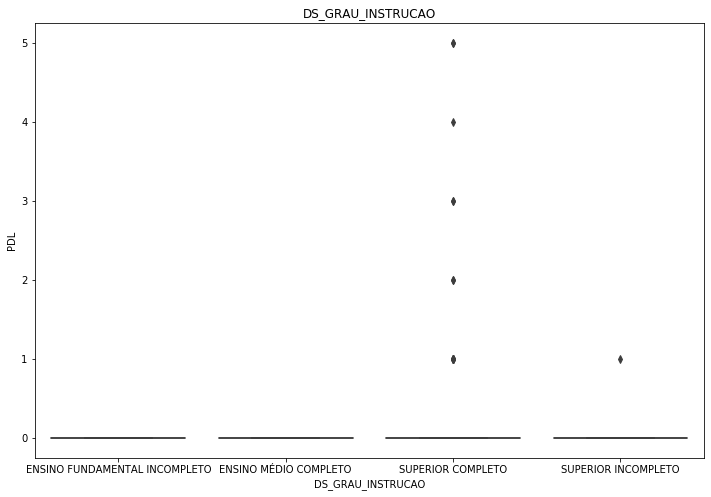

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

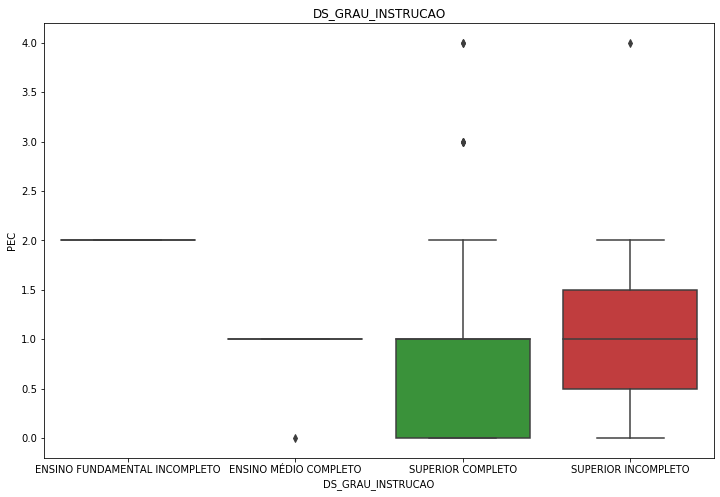

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

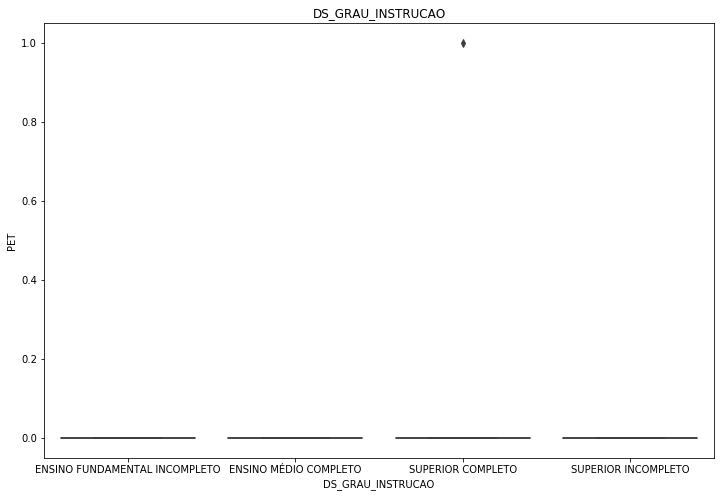

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

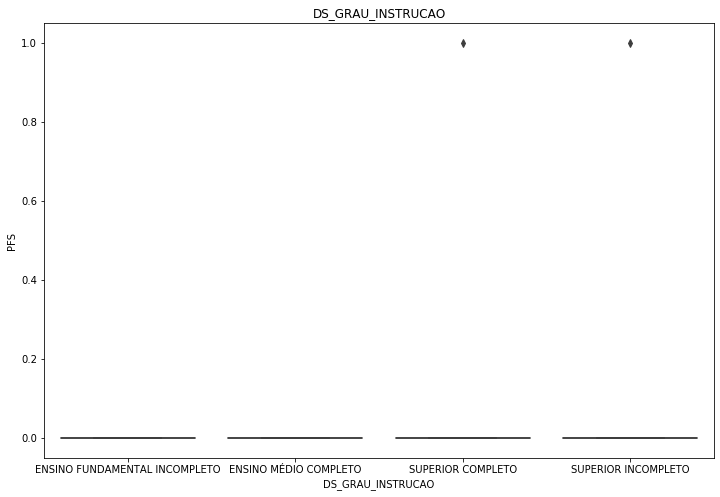

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

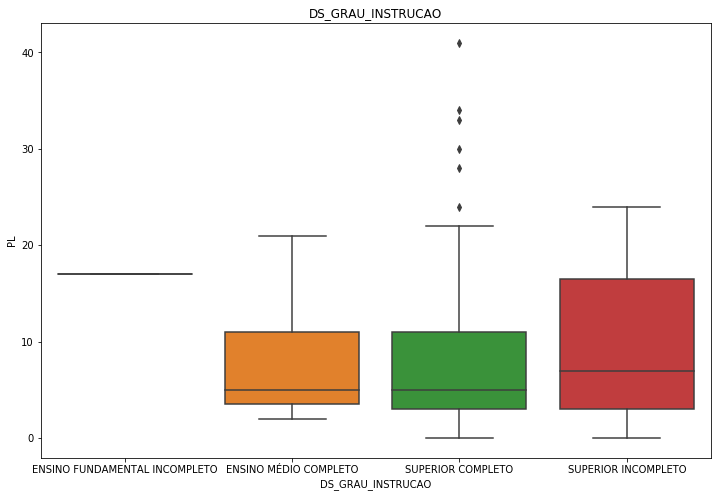

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

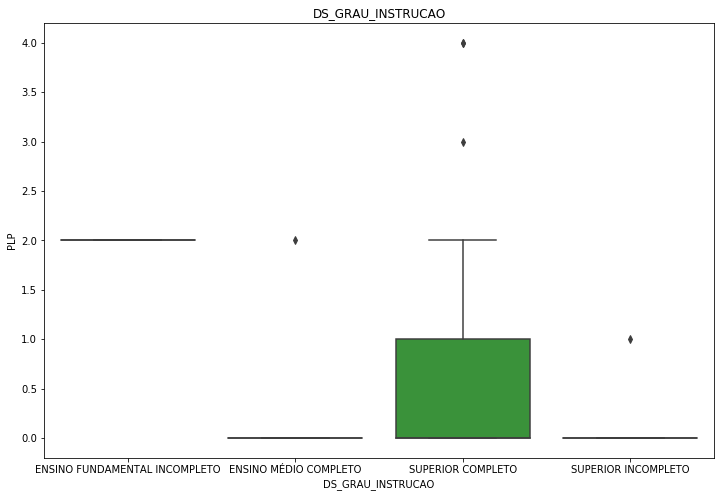

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

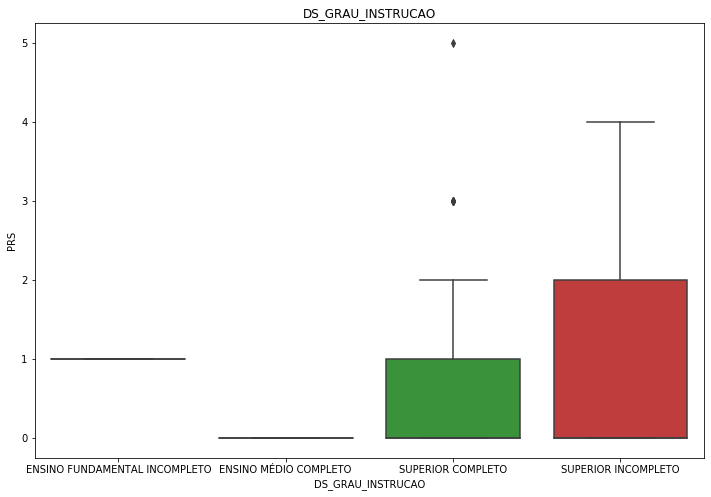

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

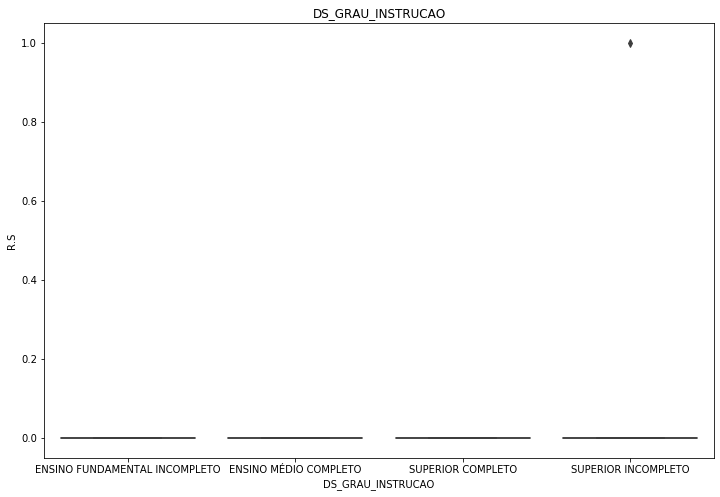

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

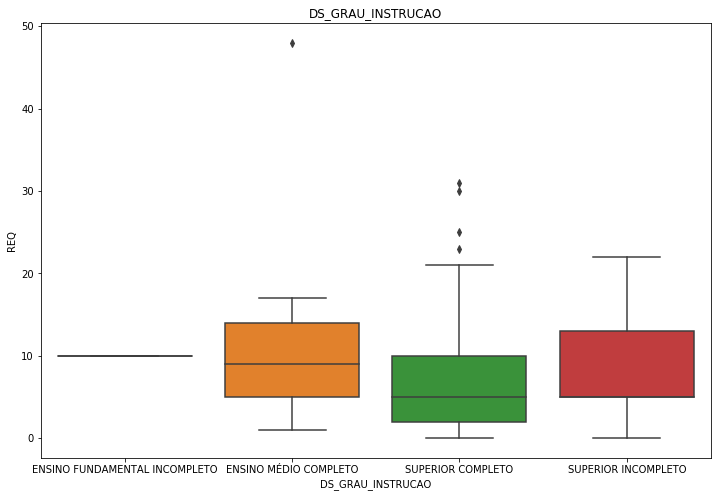

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

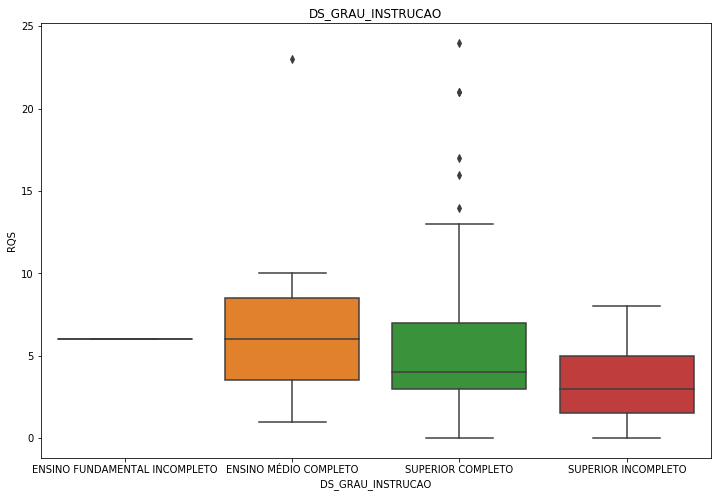

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

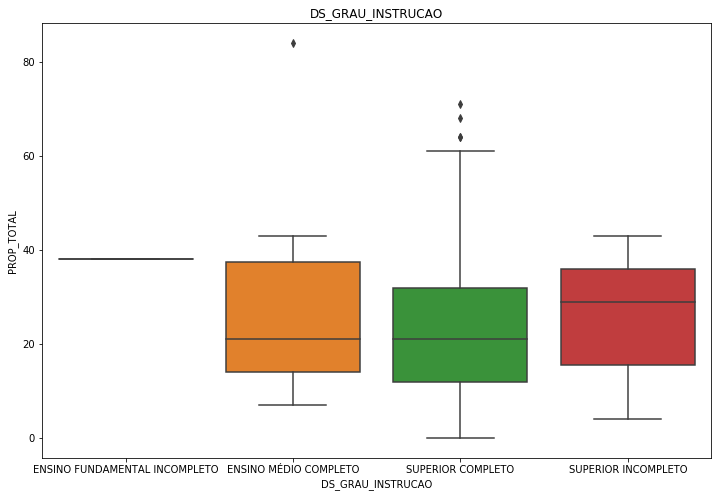

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

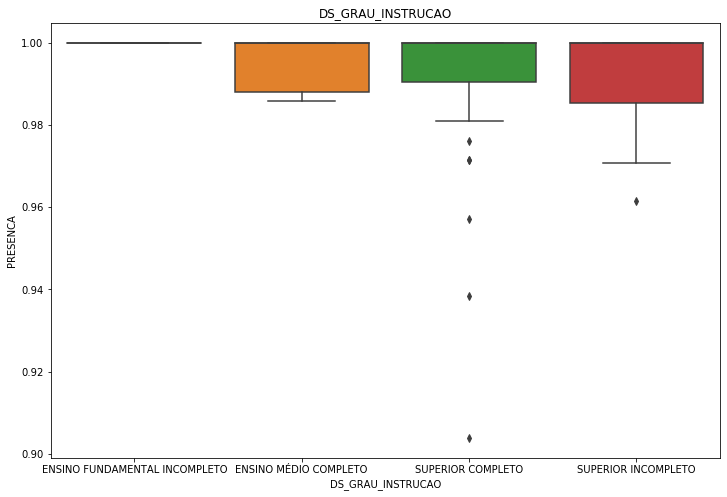

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

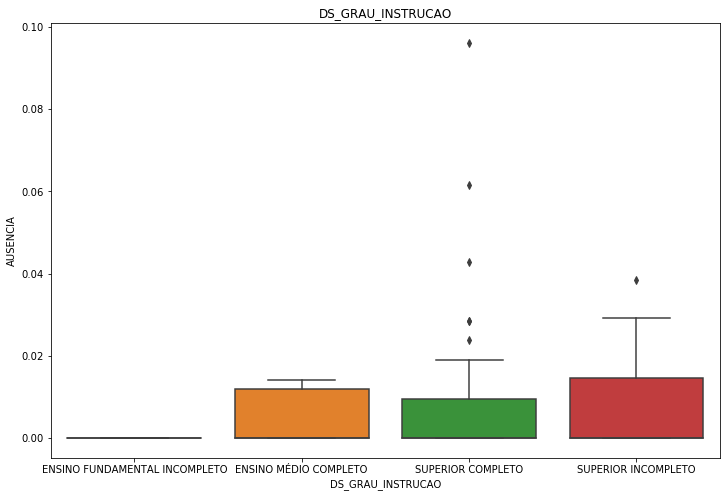

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

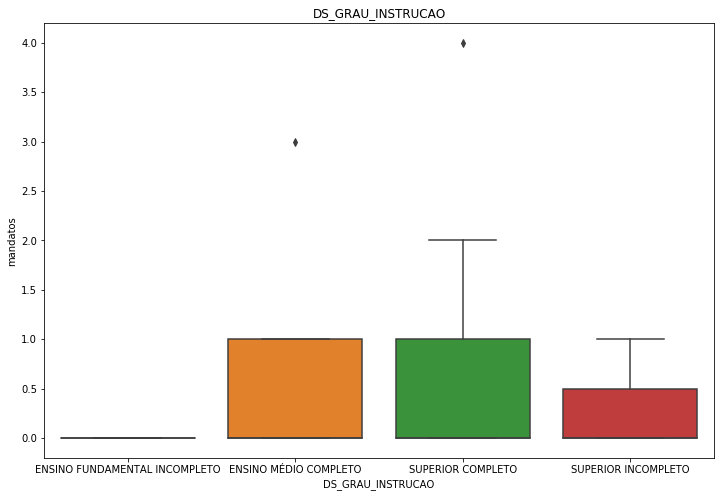

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

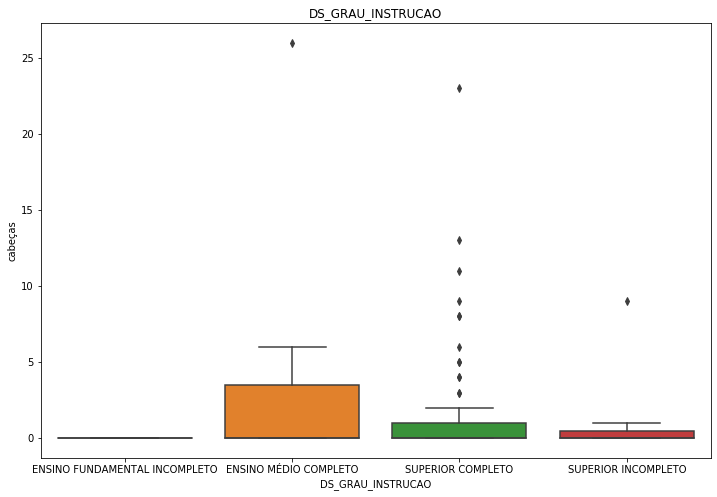

Text(0.5, 0, 'DS_GRAU_INSTRUCAO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'DS_GRAU_INSTRUCAO')

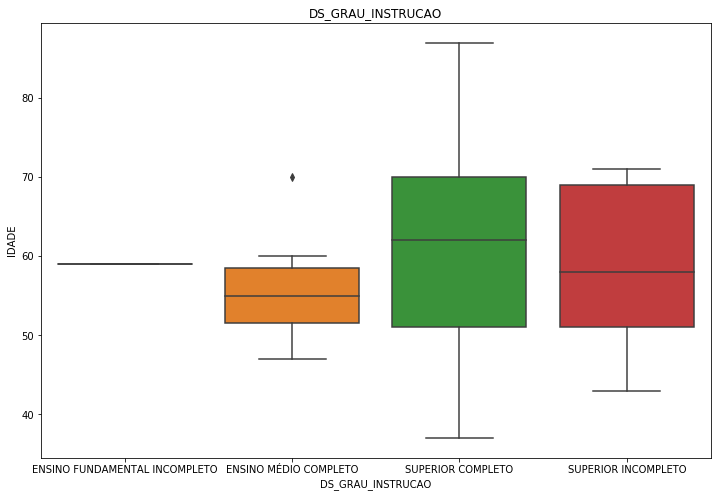

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

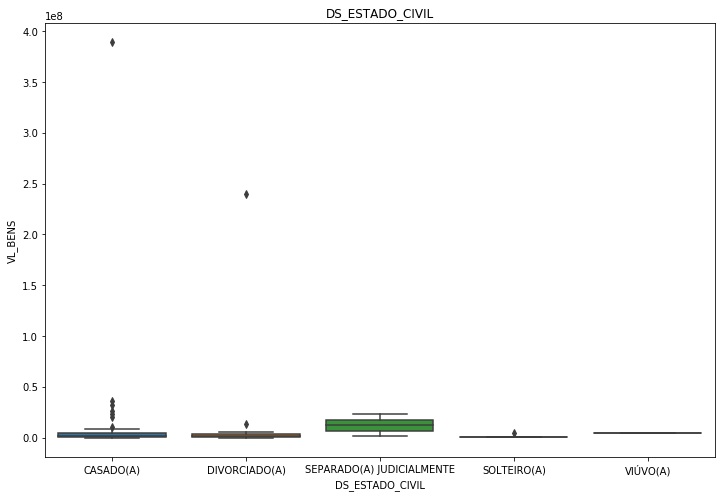

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

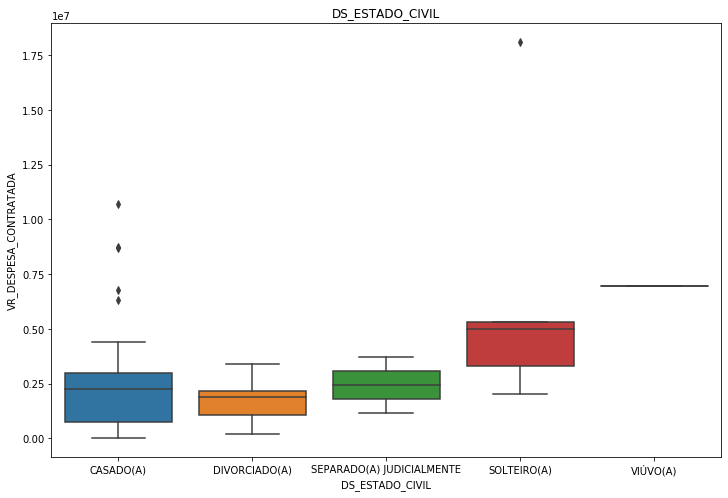

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

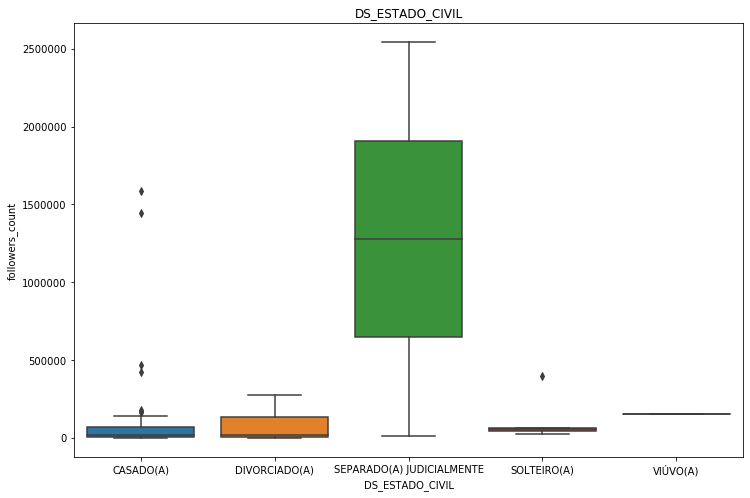

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

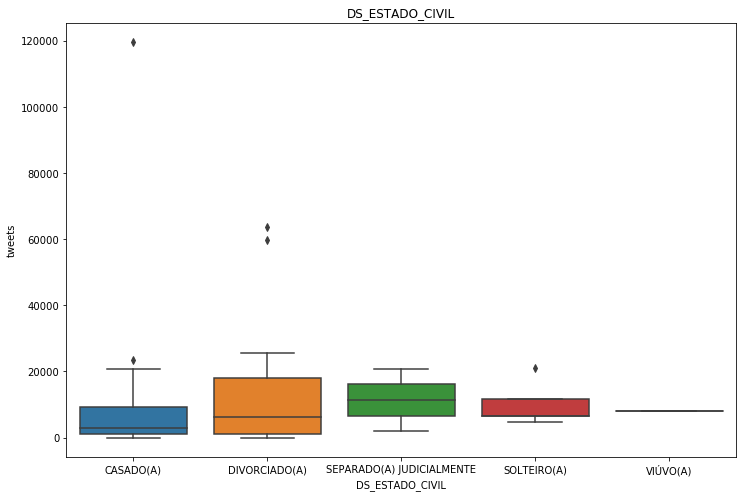

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

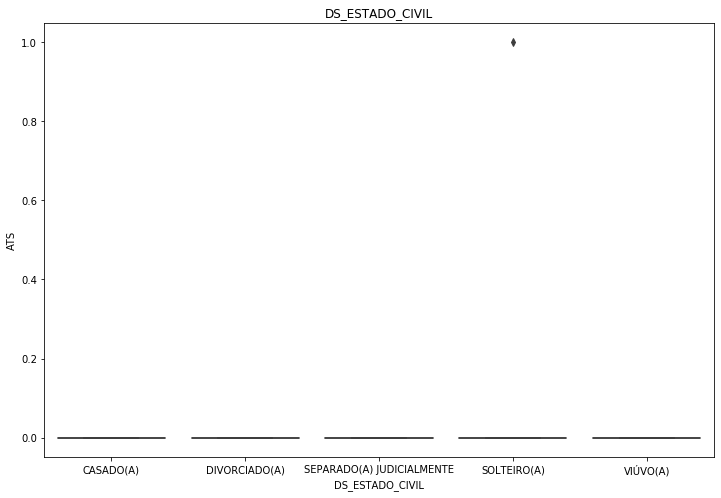

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

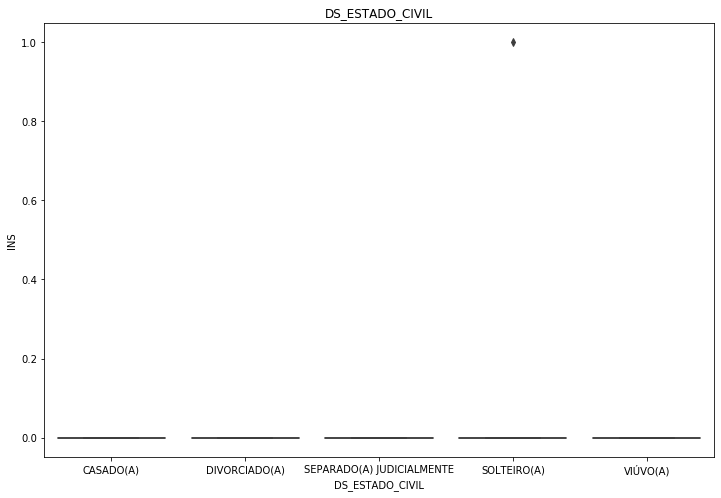

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

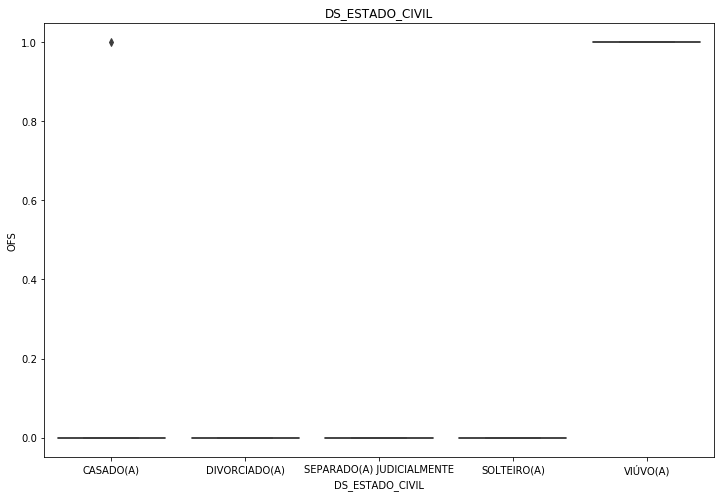

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

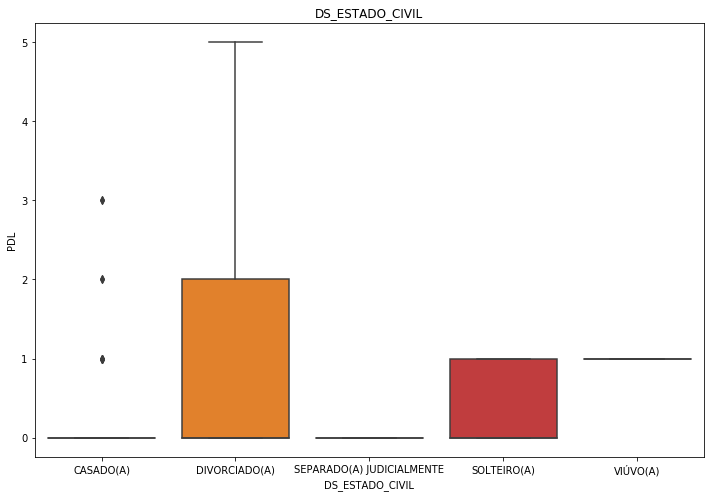

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

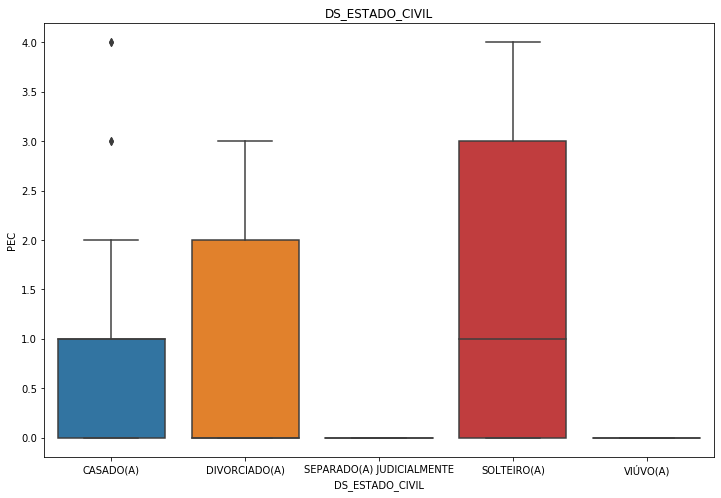

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

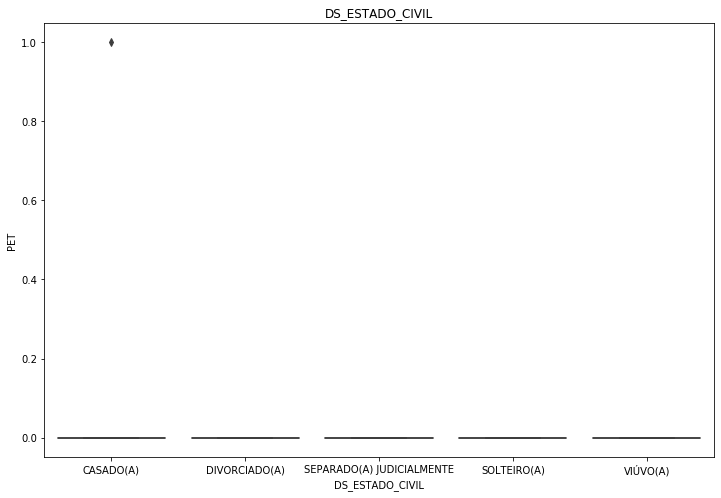

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

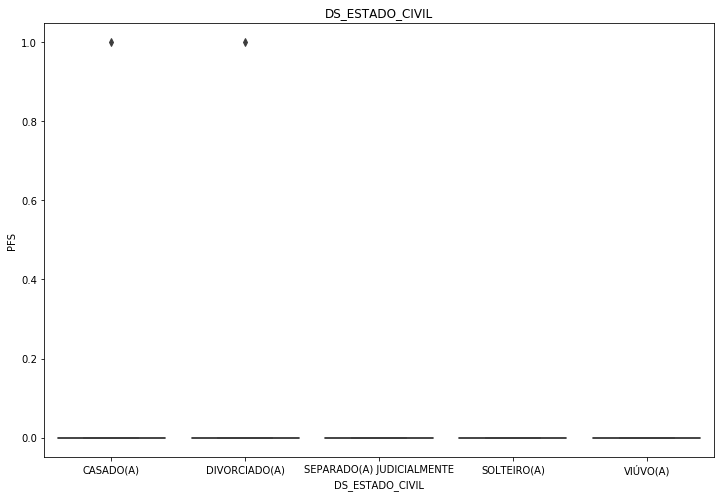

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

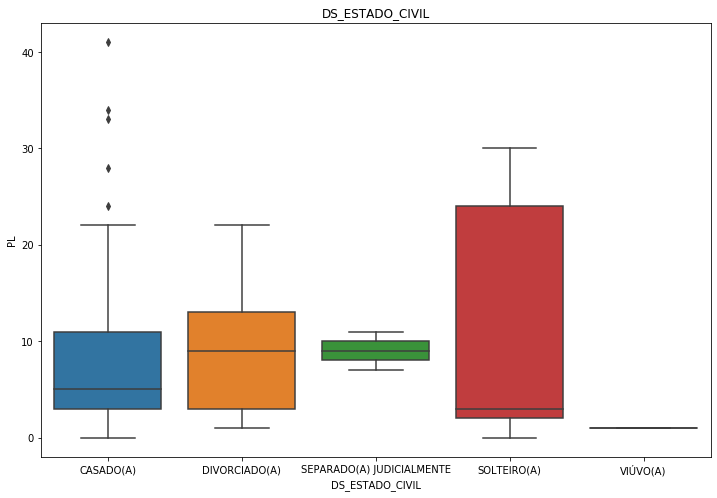

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

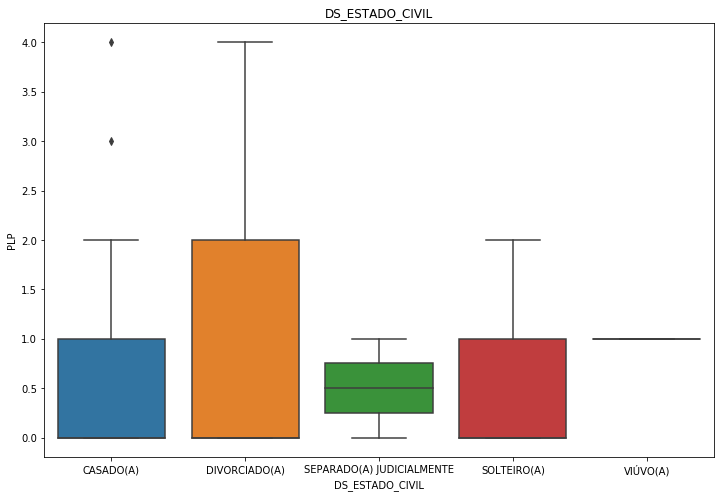

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

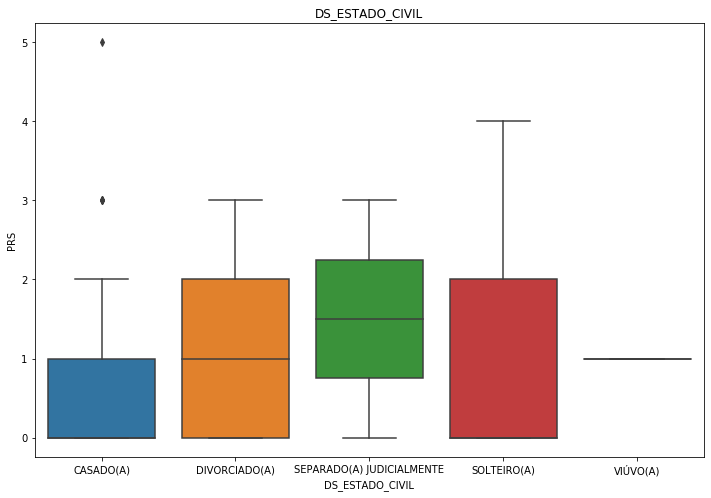

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

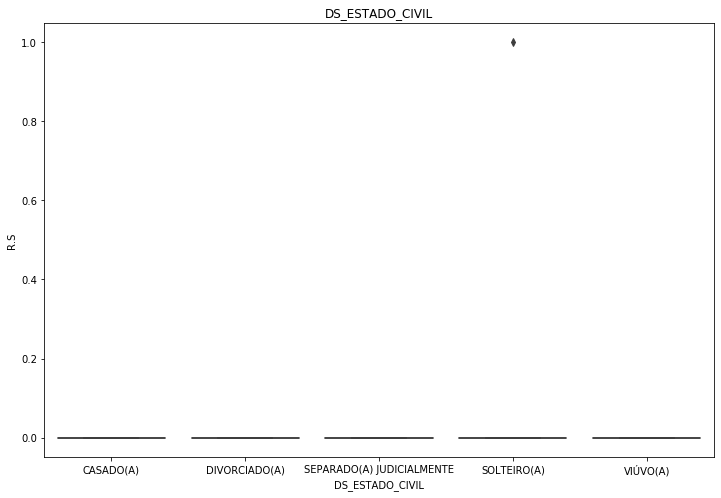

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

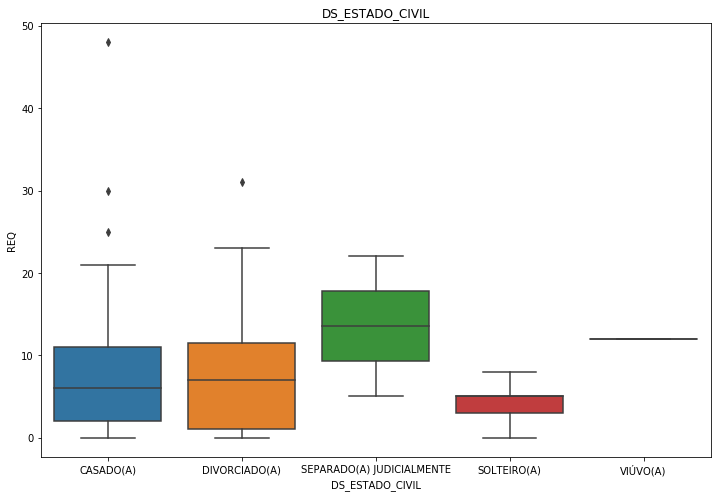

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

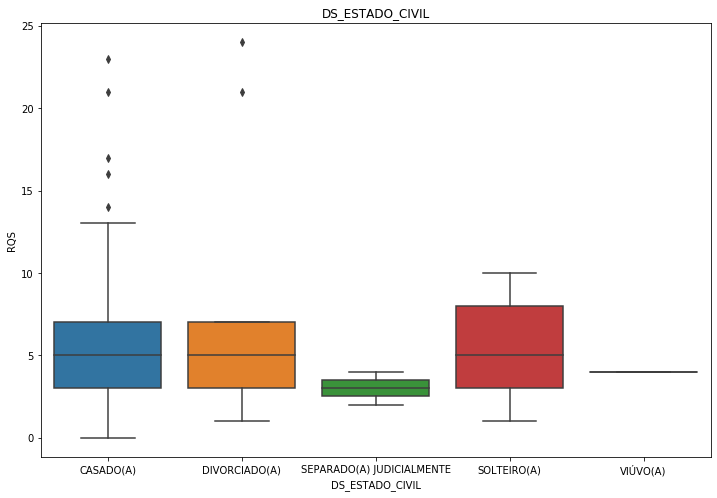

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

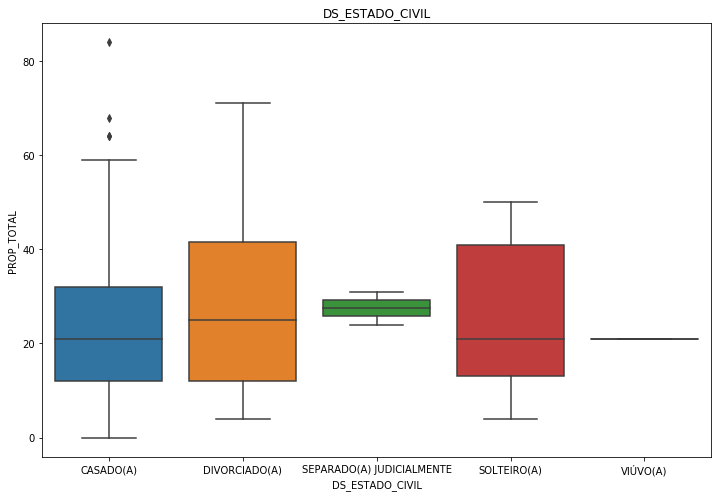

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

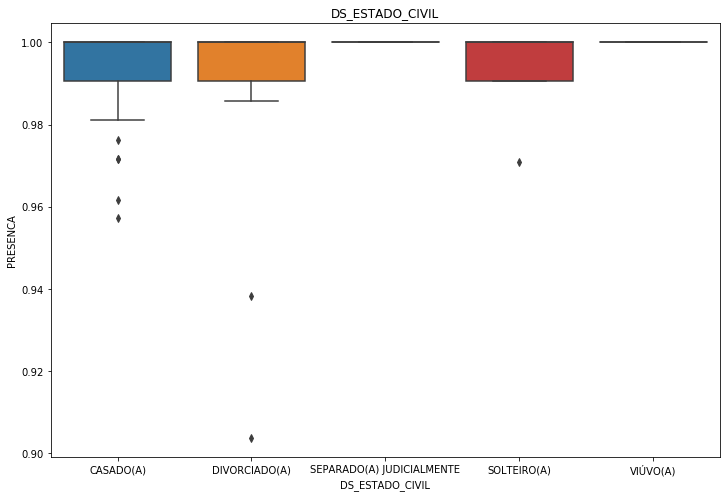

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

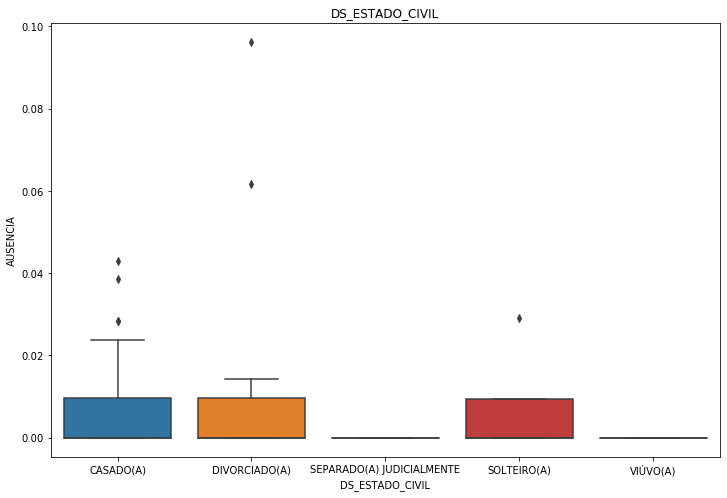

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

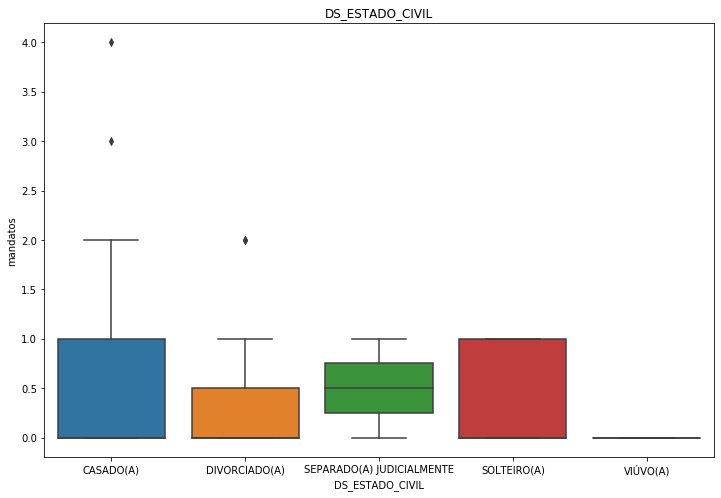

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

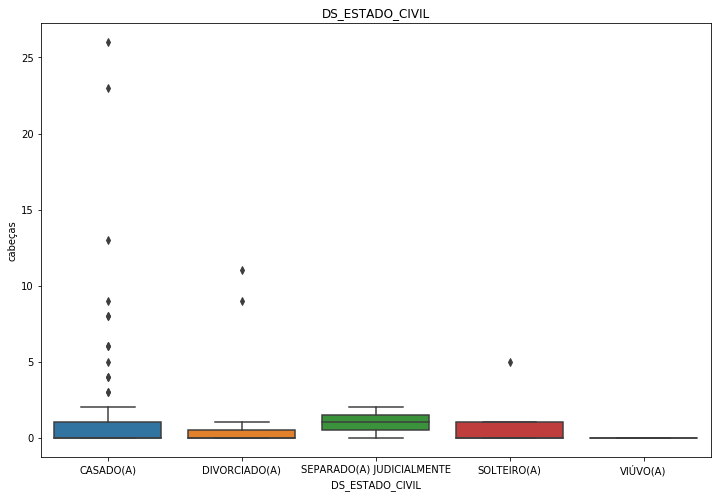

Text(0.5, 0, 'DS_ESTADO_CIVIL')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'DS_ESTADO_CIVIL')

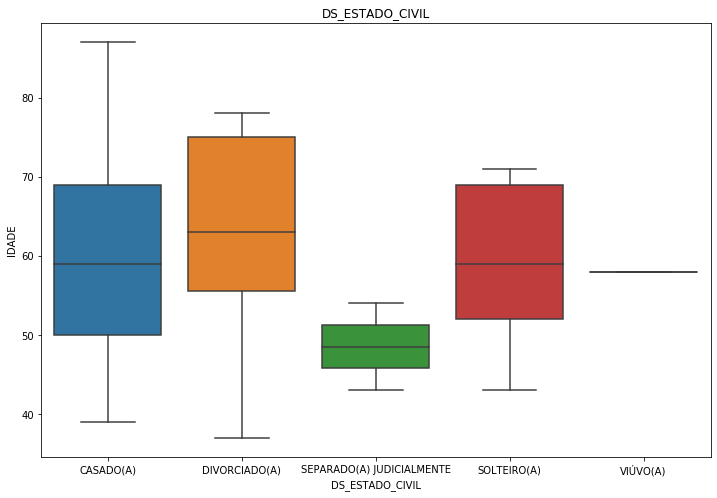

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'DS_COR_RACA')

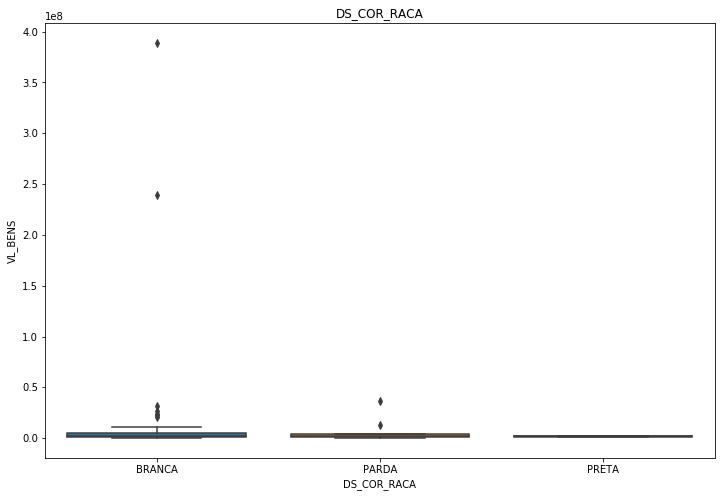

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'DS_COR_RACA')

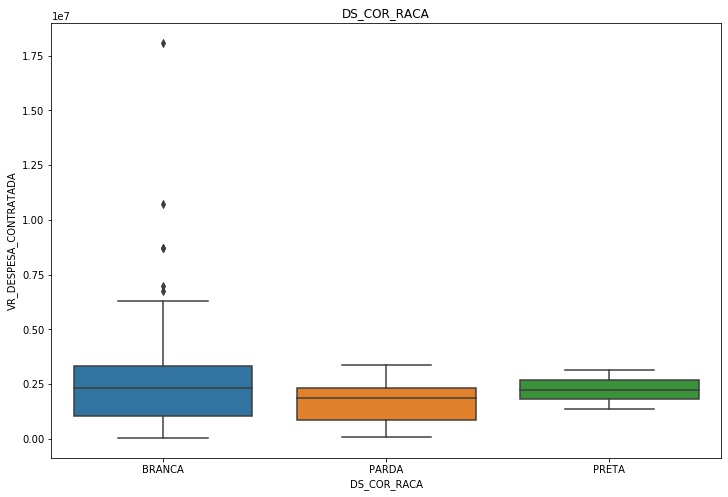

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'DS_COR_RACA')

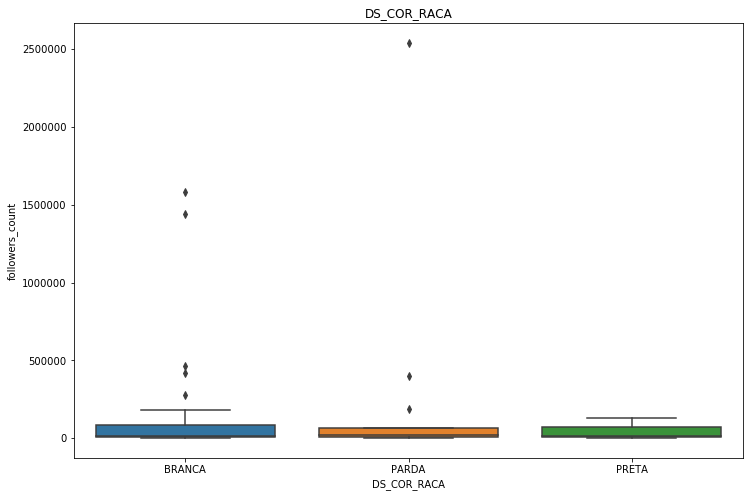

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'DS_COR_RACA')

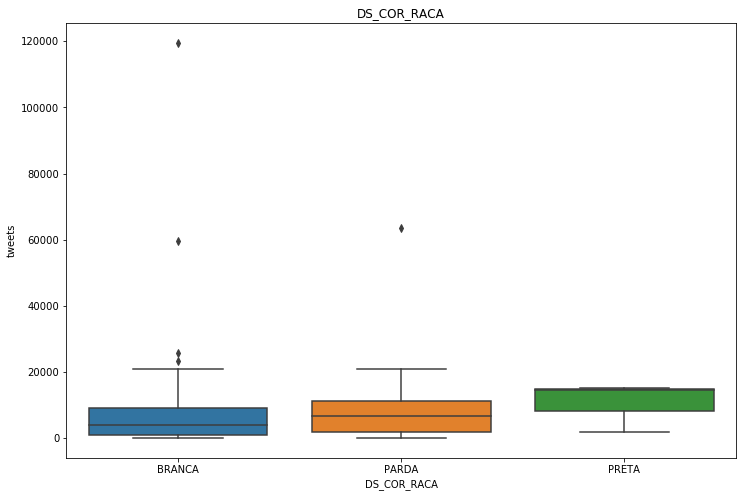

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'DS_COR_RACA')

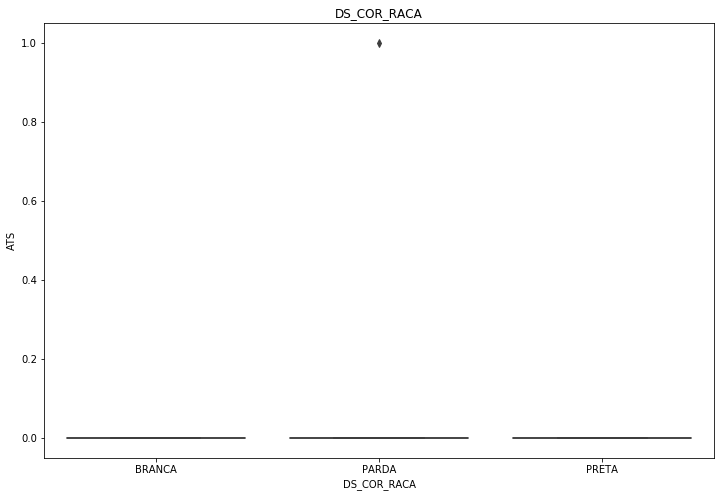

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'DS_COR_RACA')

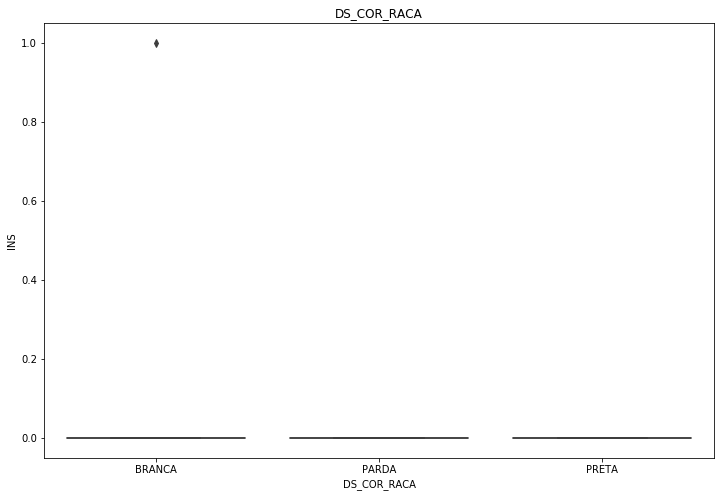

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'DS_COR_RACA')

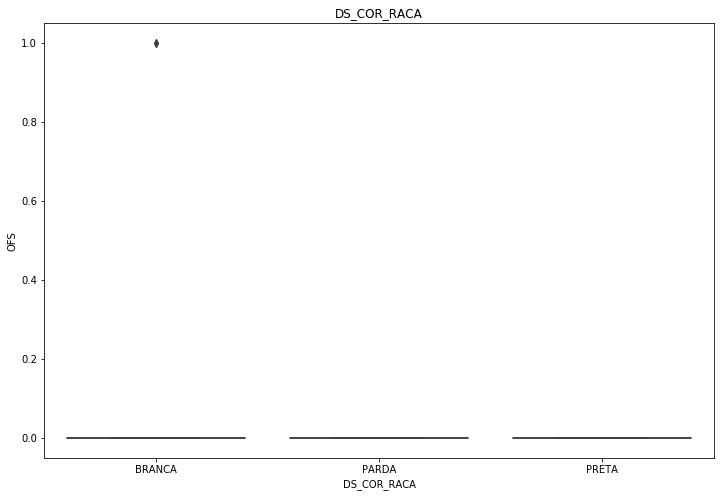

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'DS_COR_RACA')

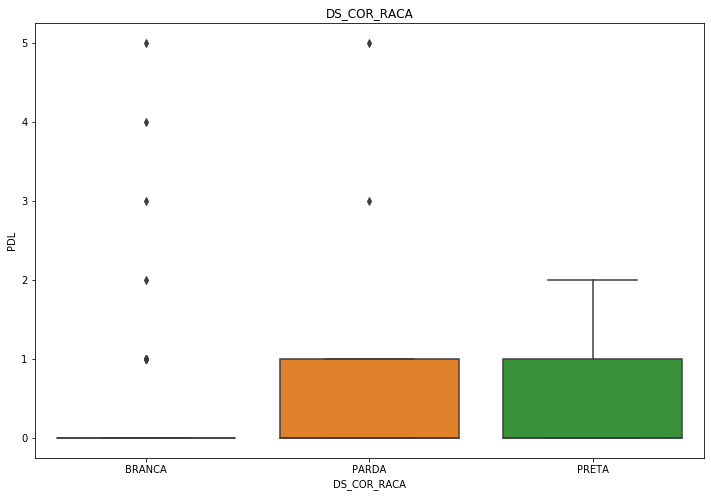

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'DS_COR_RACA')

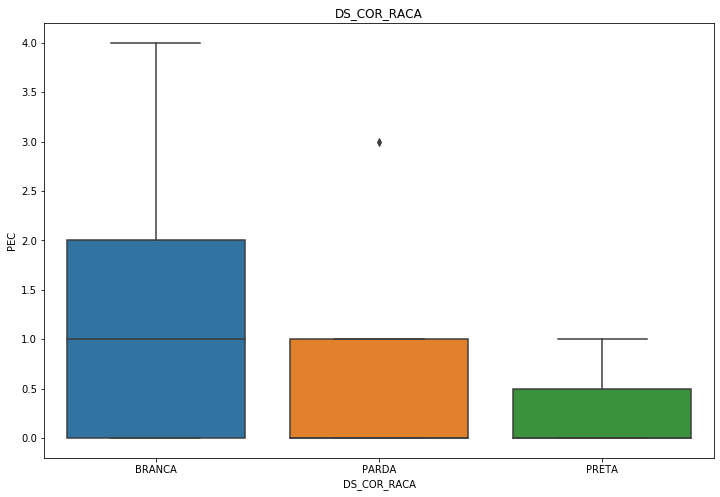

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'DS_COR_RACA')

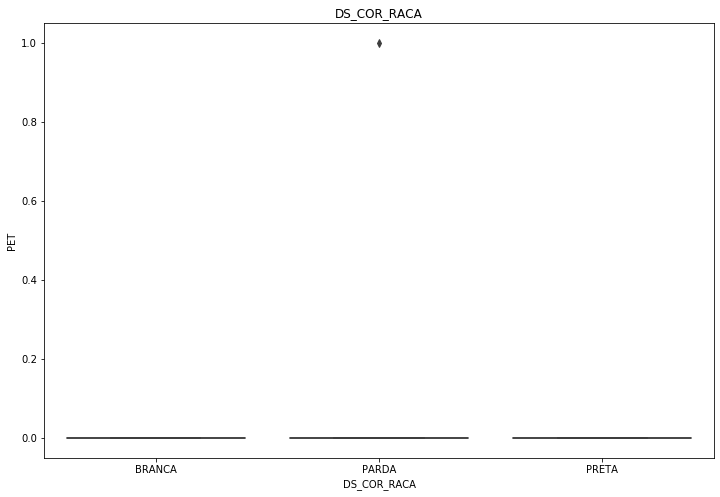

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'DS_COR_RACA')

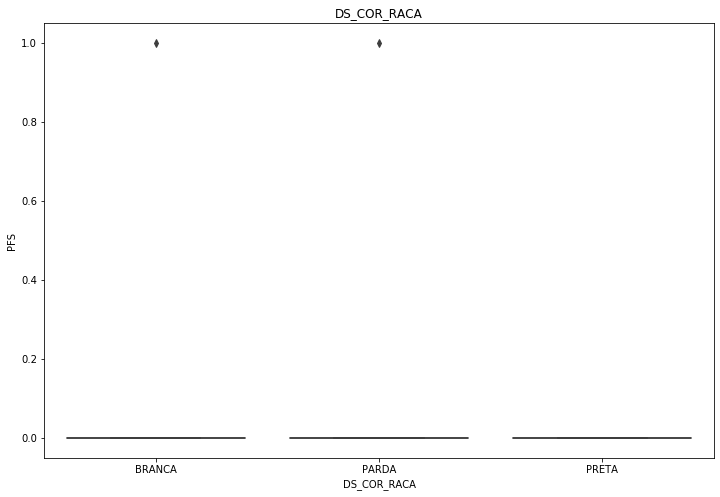

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'DS_COR_RACA')

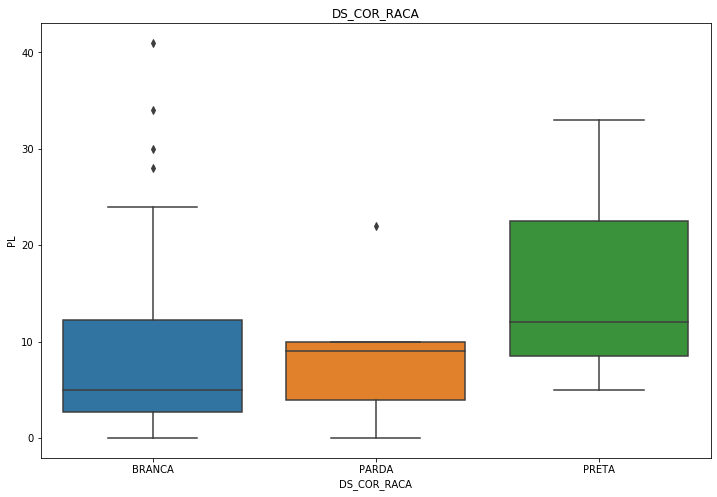

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'DS_COR_RACA')

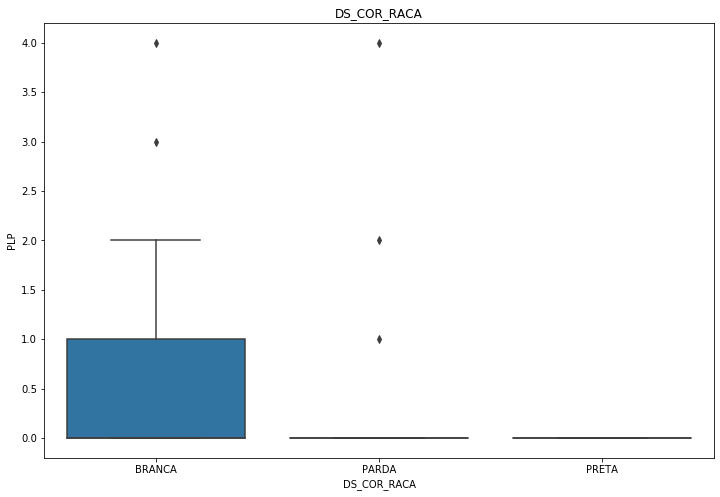

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'DS_COR_RACA')

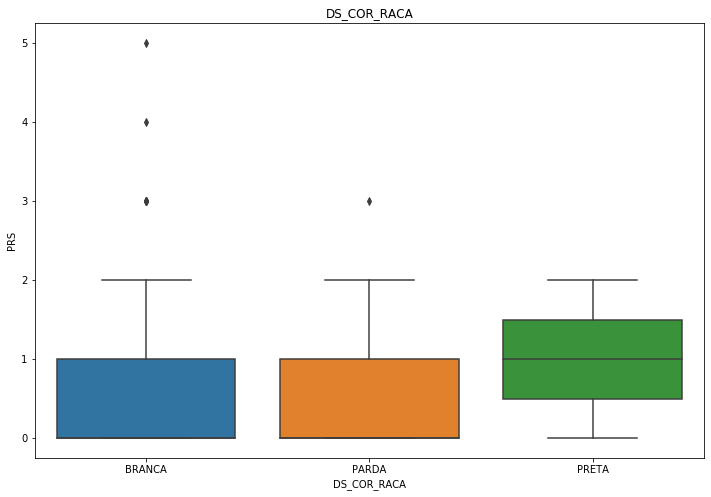

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'DS_COR_RACA')

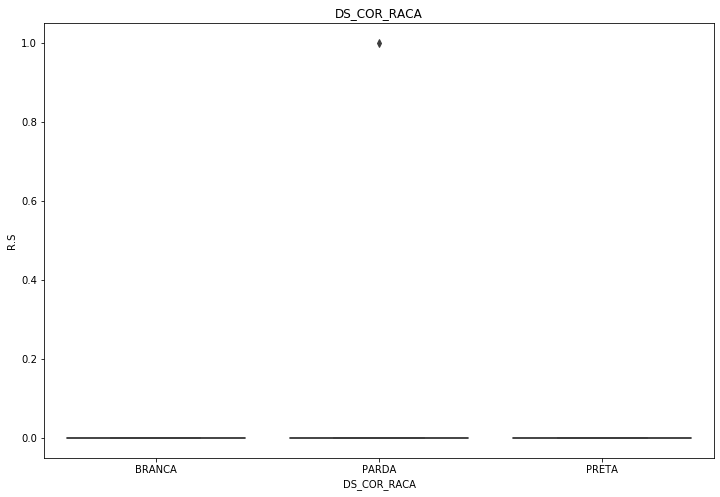

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'DS_COR_RACA')

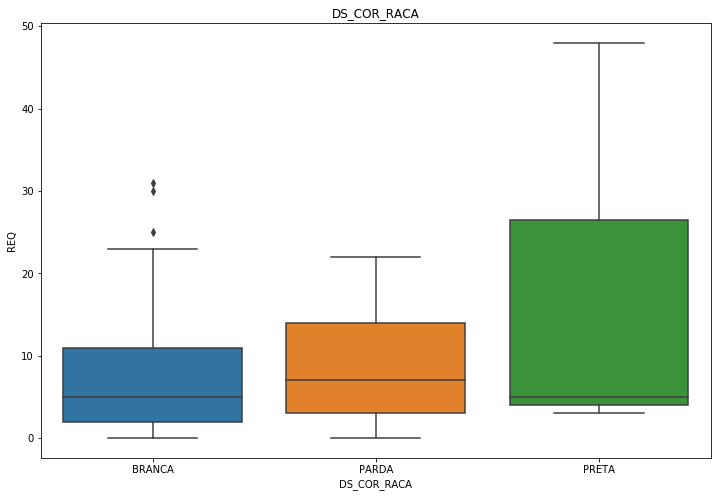

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'DS_COR_RACA')

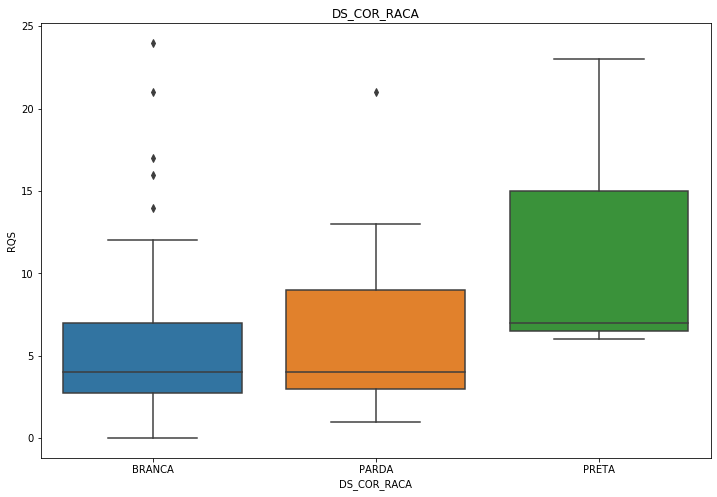

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'DS_COR_RACA')

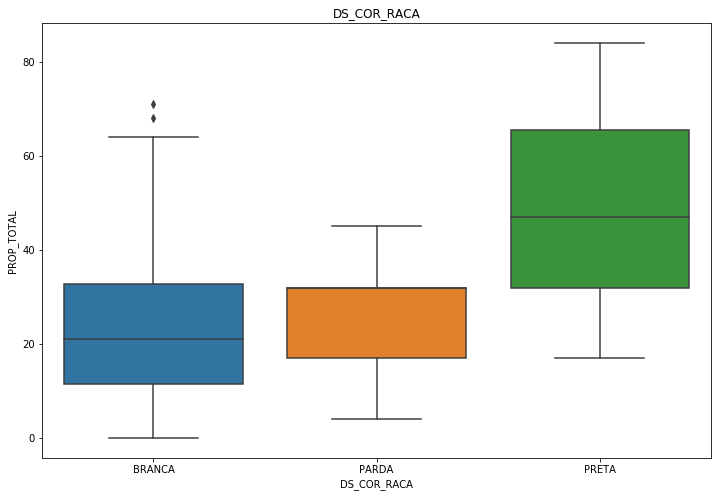

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'DS_COR_RACA')

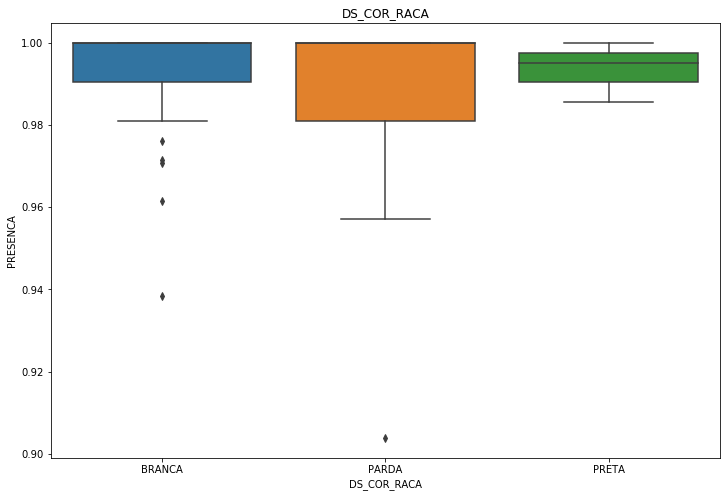

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'DS_COR_RACA')

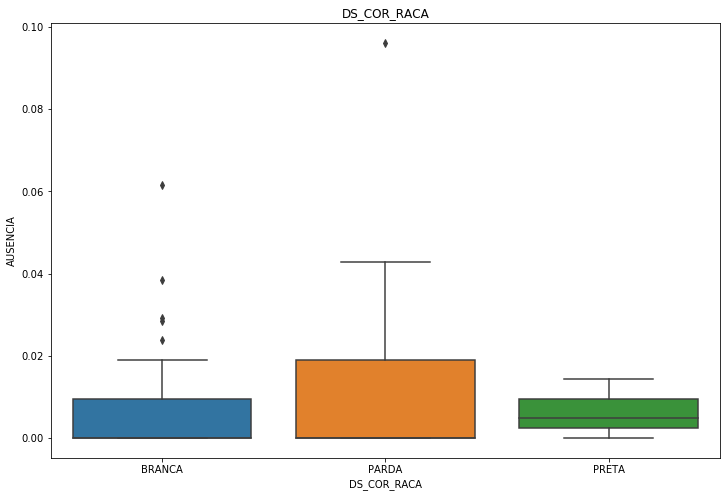

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'DS_COR_RACA')

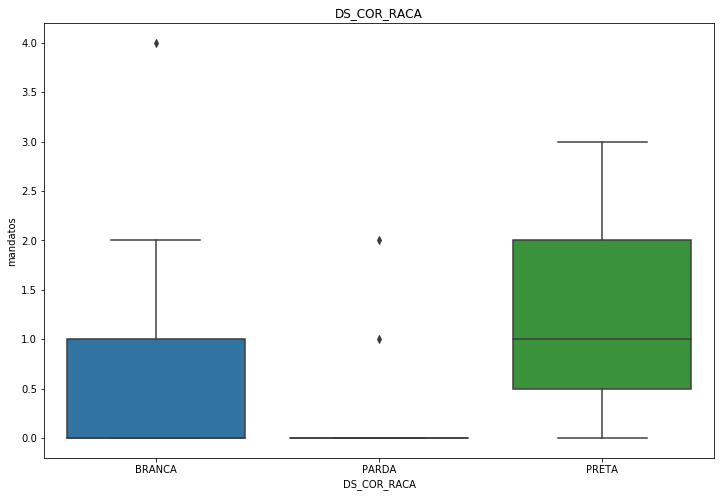

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'DS_COR_RACA')

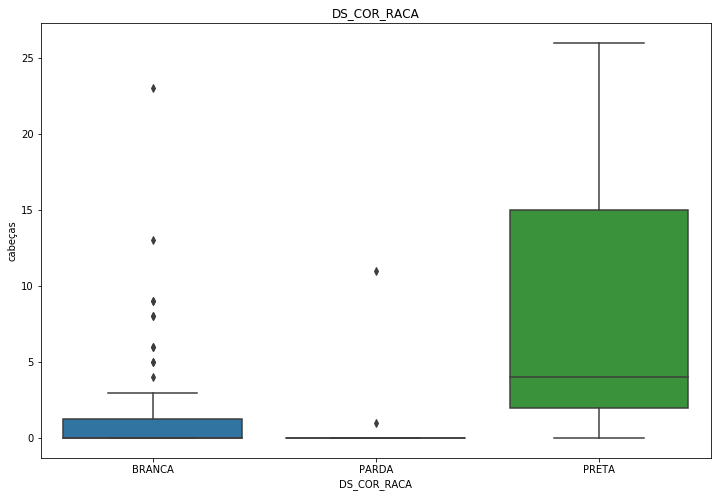

Text(0.5, 0, 'DS_COR_RACA')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'DS_COR_RACA')

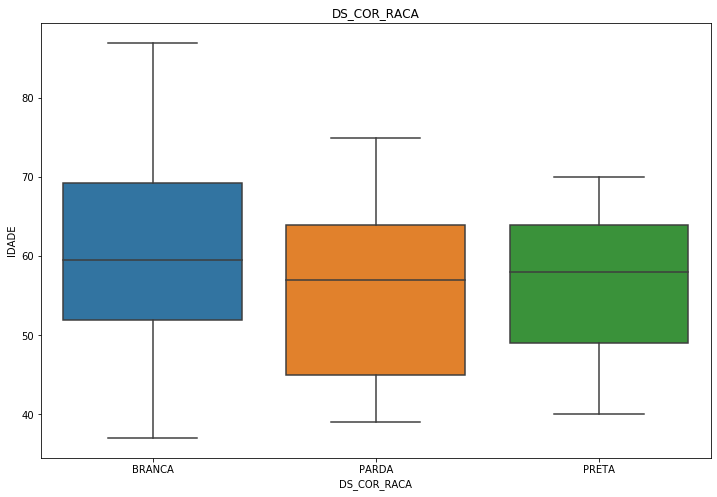

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'DS_OCUPACAO')

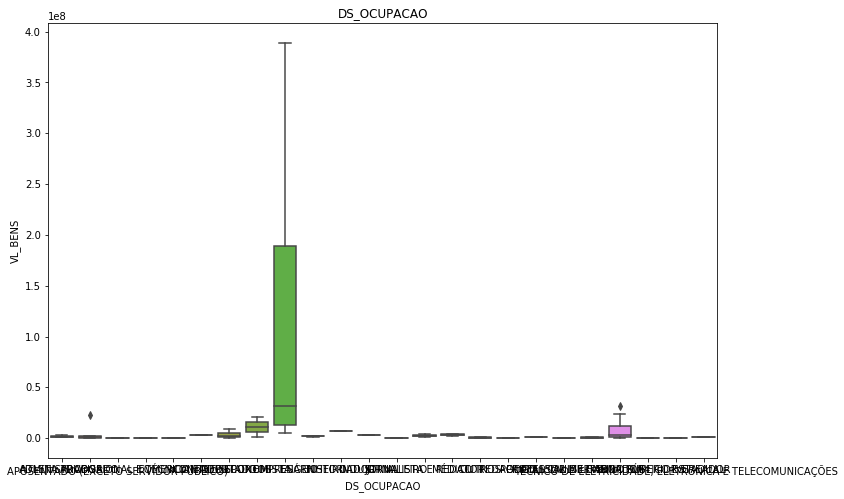

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'DS_OCUPACAO')

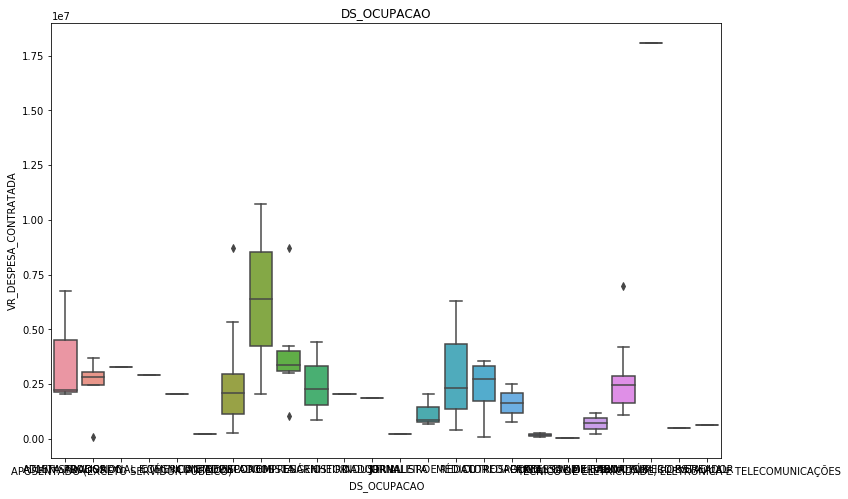

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'DS_OCUPACAO')

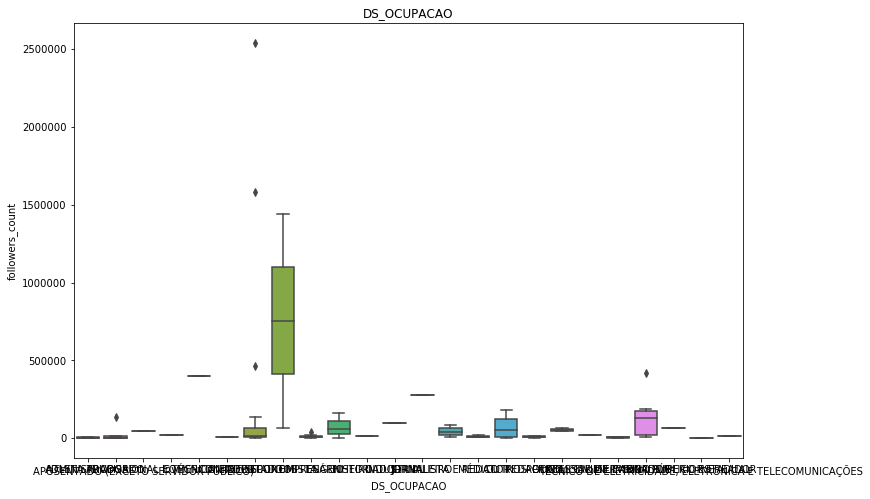

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'DS_OCUPACAO')

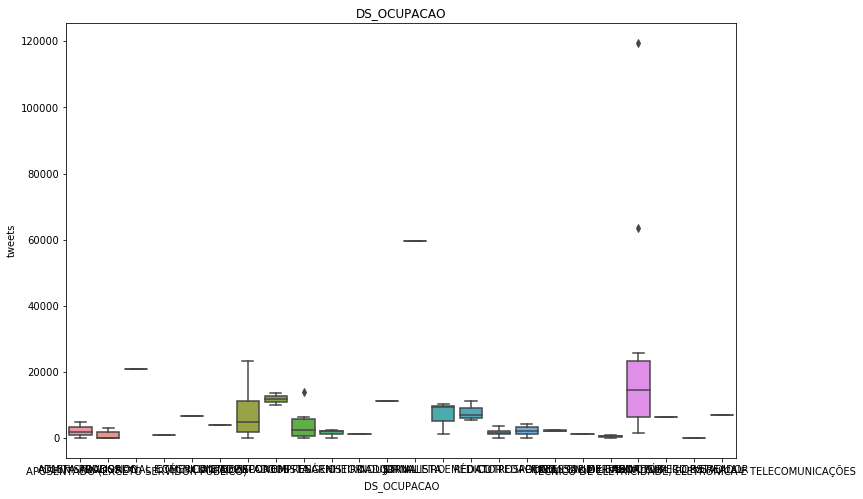

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'DS_OCUPACAO')

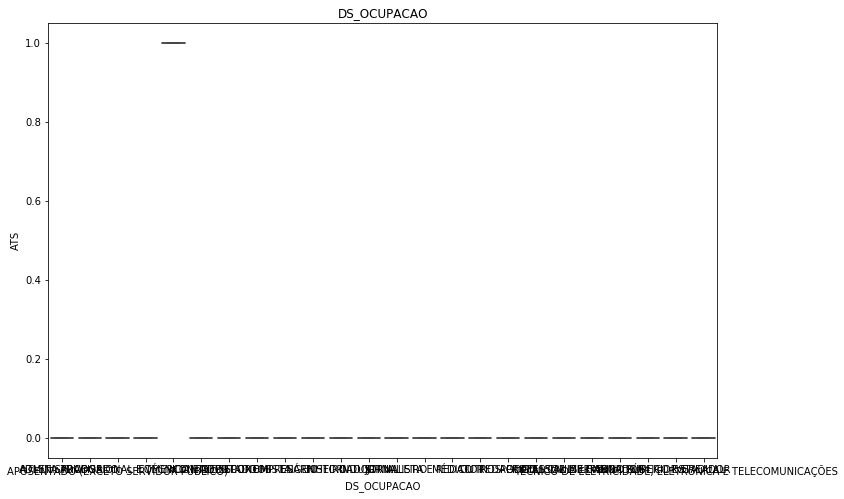

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'DS_OCUPACAO')

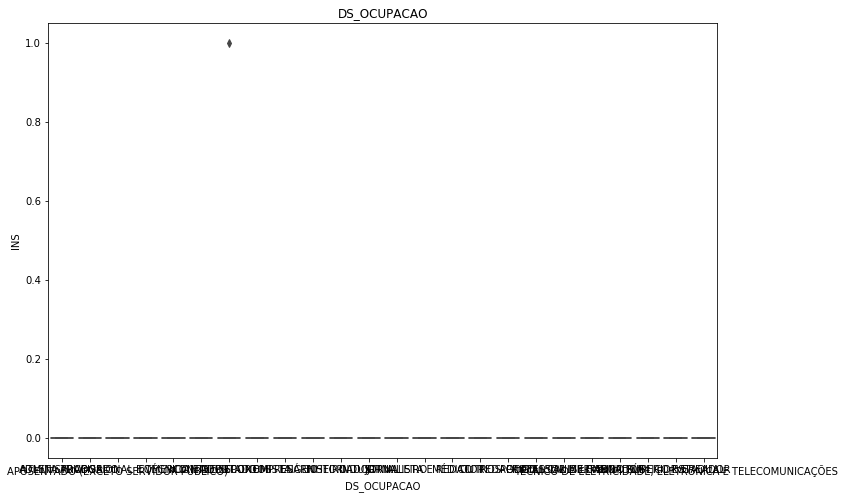

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'DS_OCUPACAO')

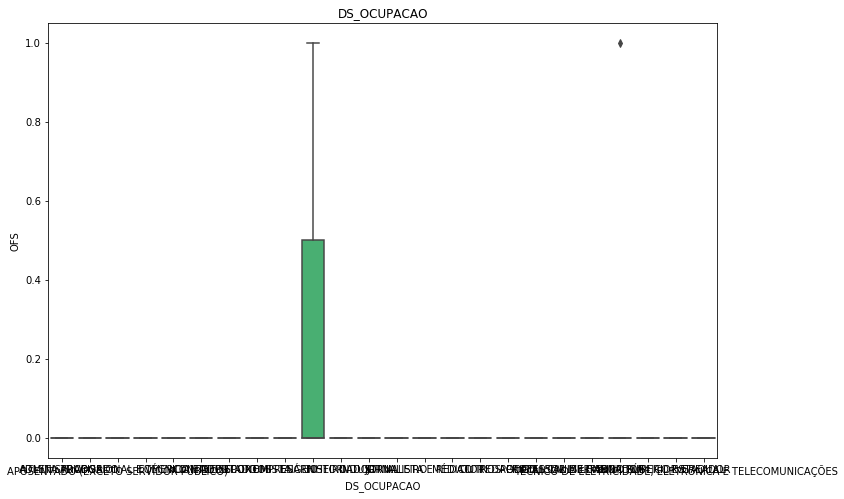

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'DS_OCUPACAO')

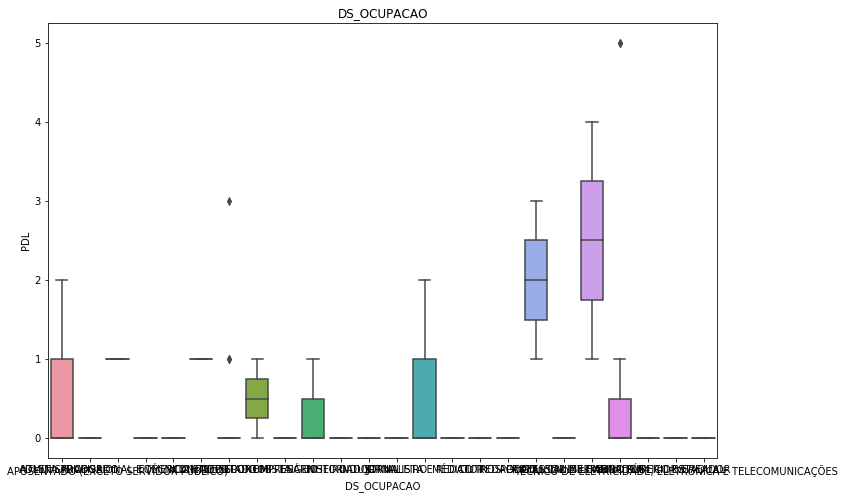

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'DS_OCUPACAO')

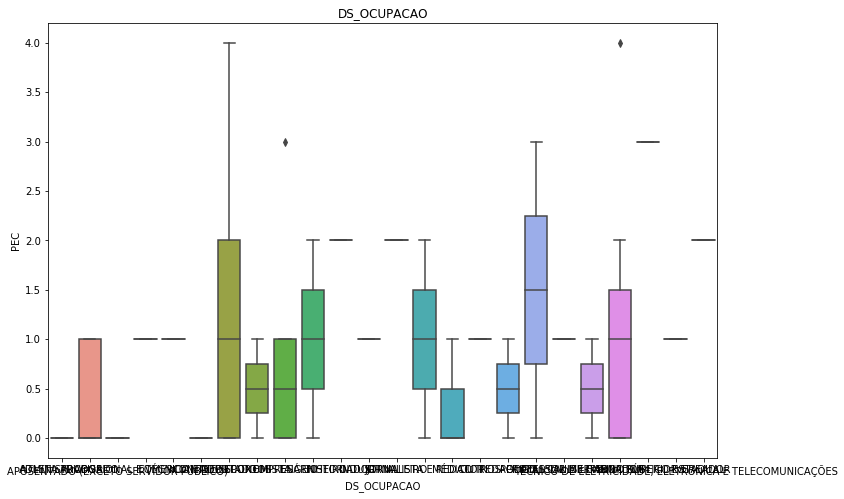

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'DS_OCUPACAO')

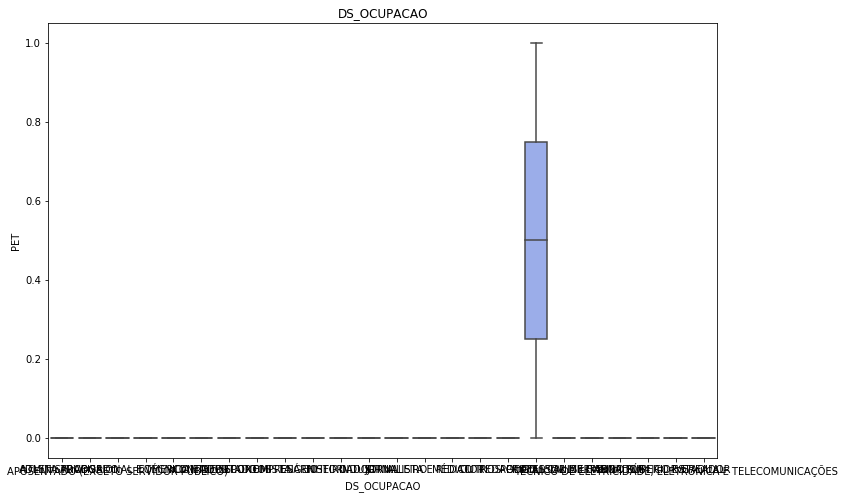

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'DS_OCUPACAO')

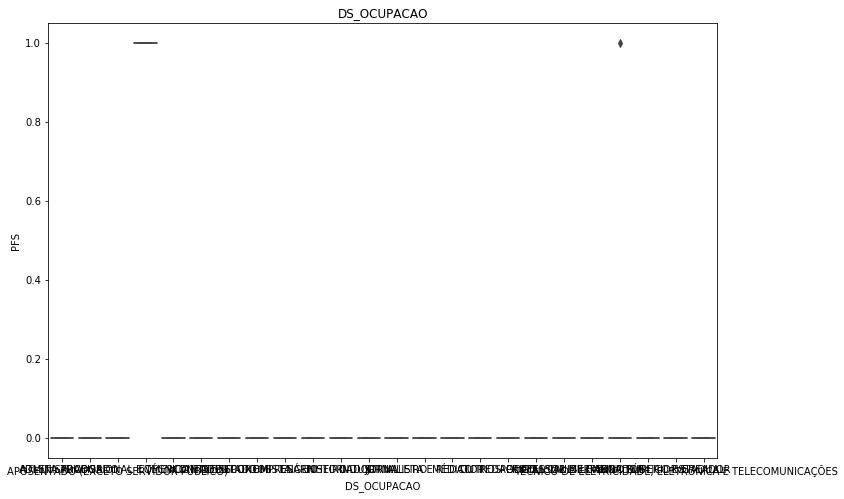

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'DS_OCUPACAO')

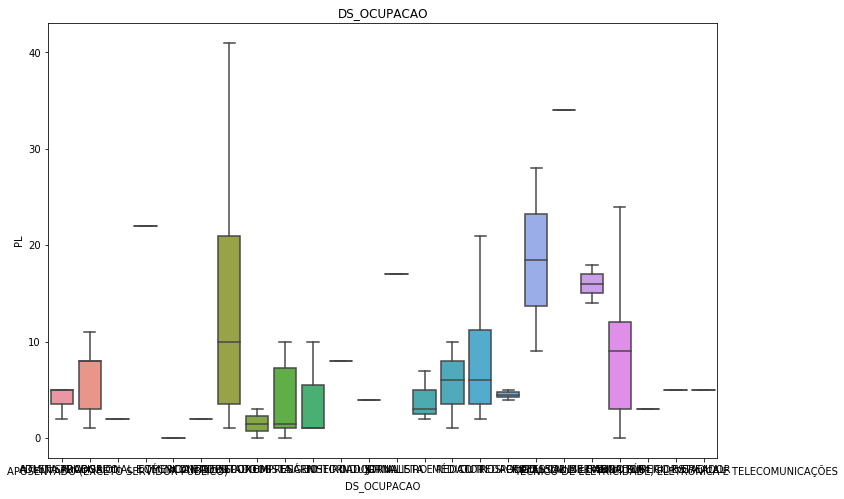

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'DS_OCUPACAO')

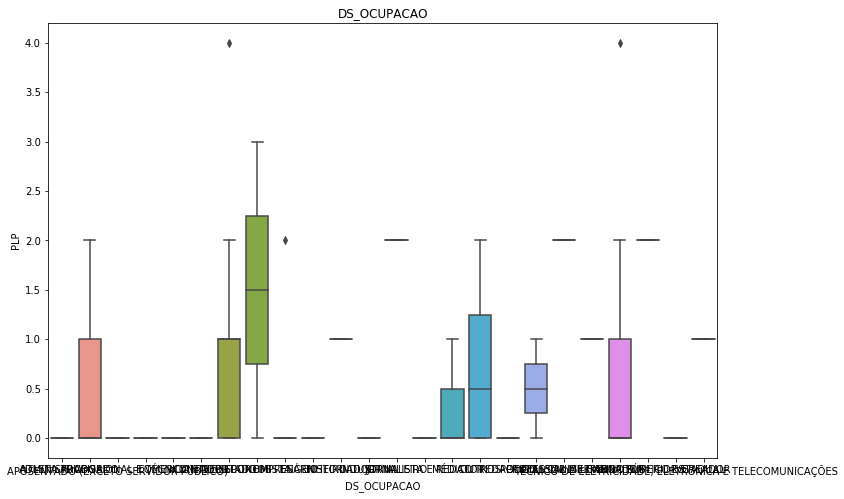

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'DS_OCUPACAO')

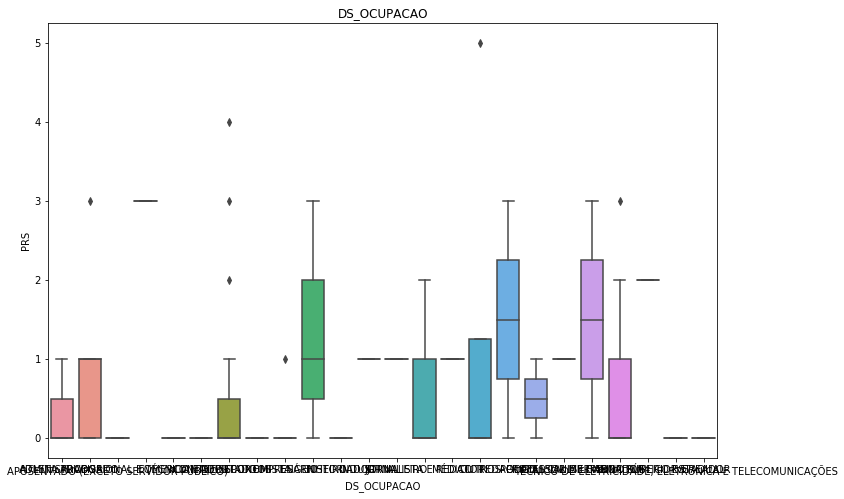

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'DS_OCUPACAO')

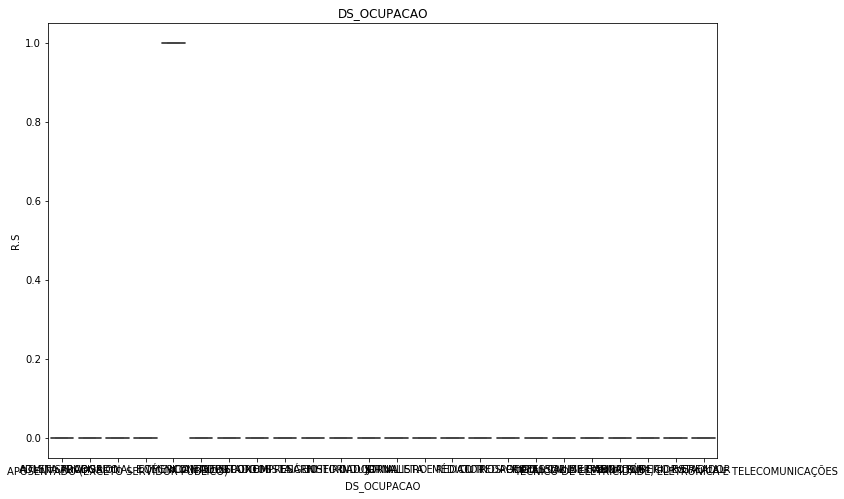

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'DS_OCUPACAO')

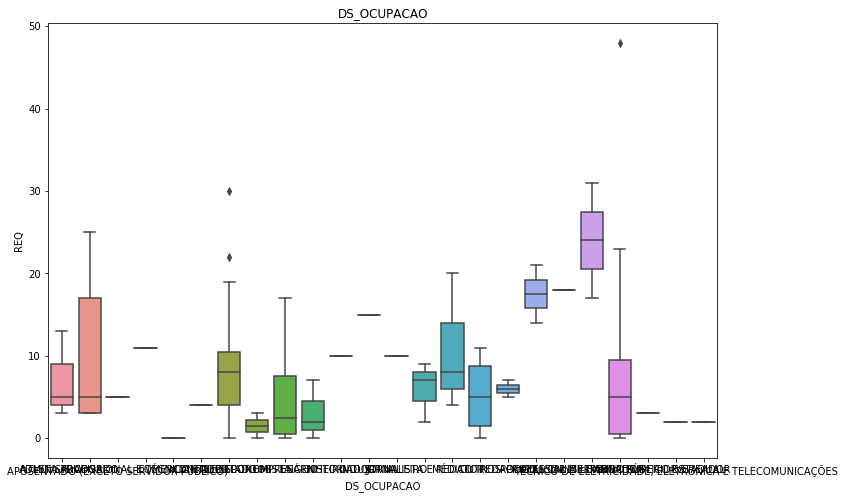

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'DS_OCUPACAO')

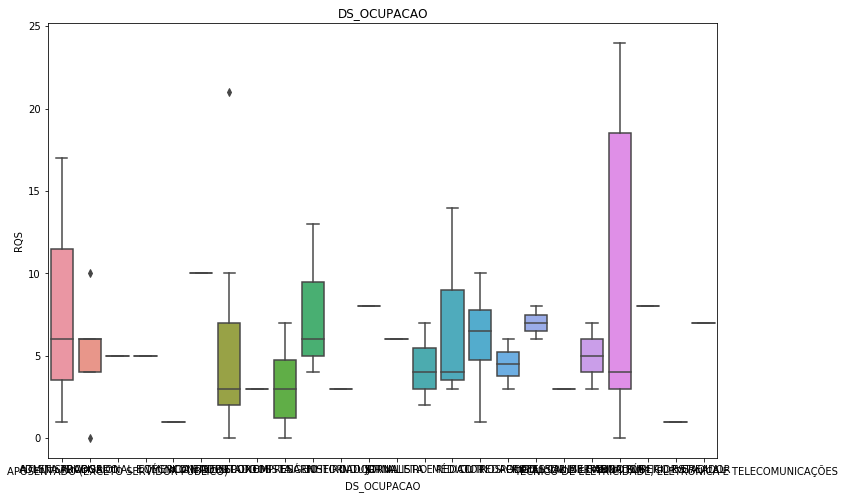

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'DS_OCUPACAO')

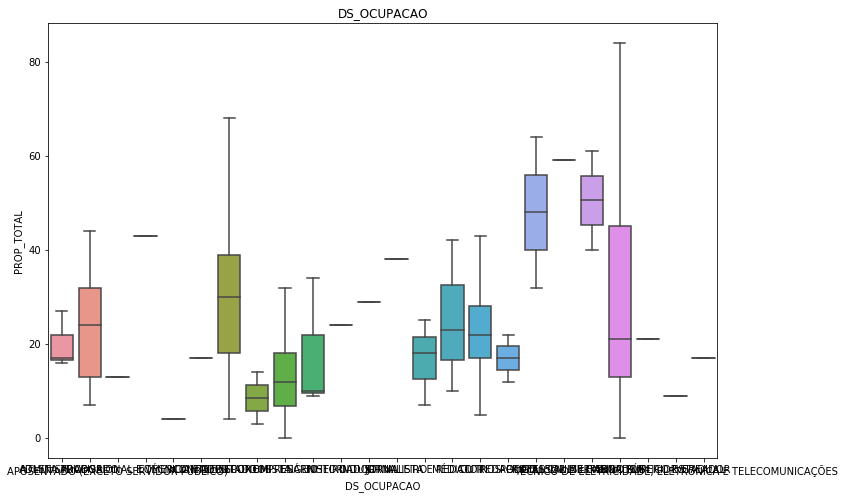

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'DS_OCUPACAO')

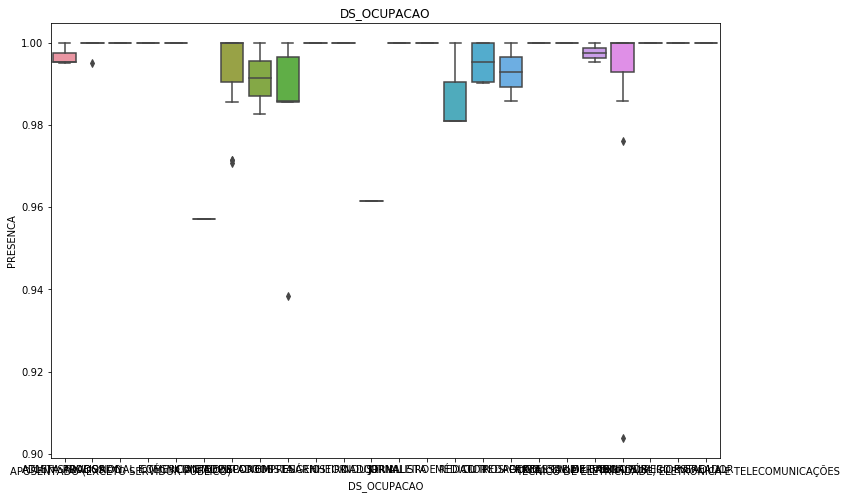

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'DS_OCUPACAO')

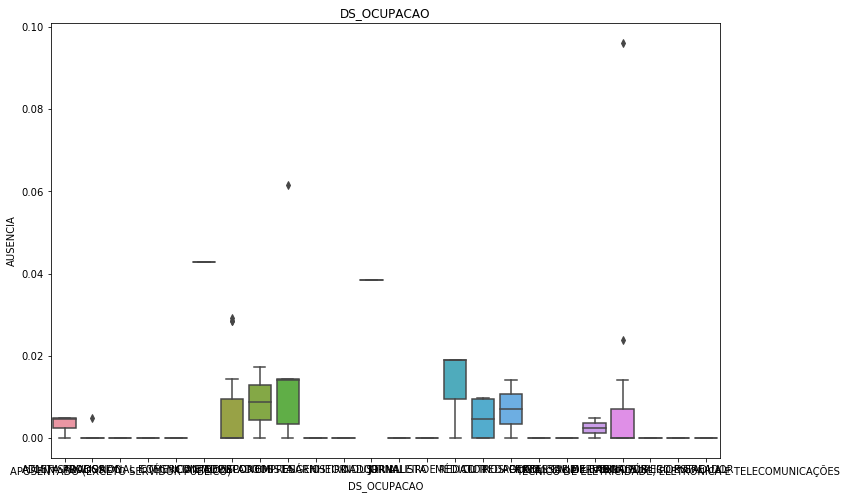

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'DS_OCUPACAO')

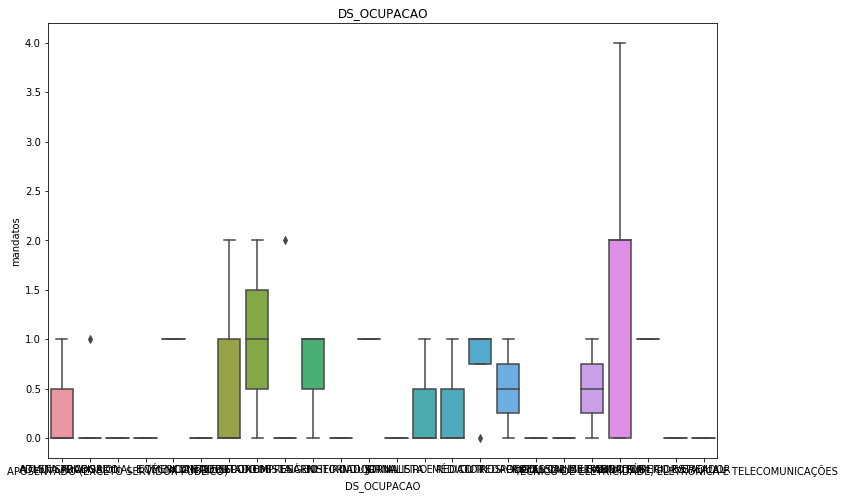

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'DS_OCUPACAO')

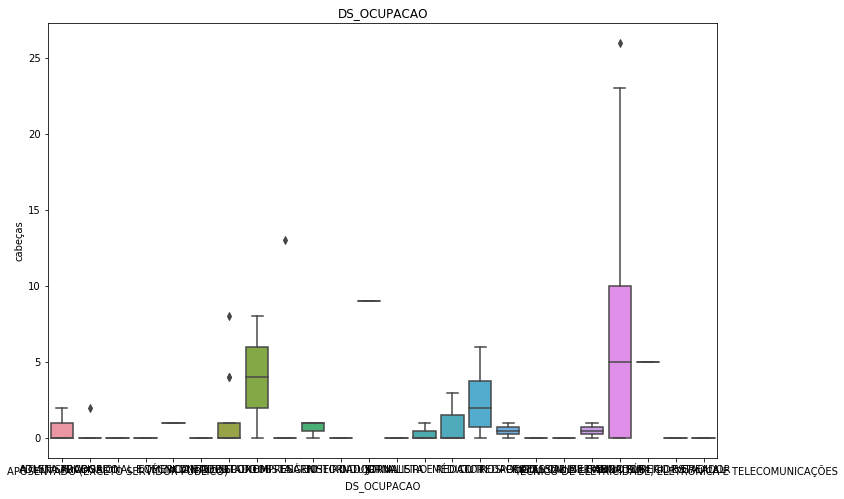

Text(0.5, 0, 'DS_OCUPACAO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'DS_OCUPACAO')

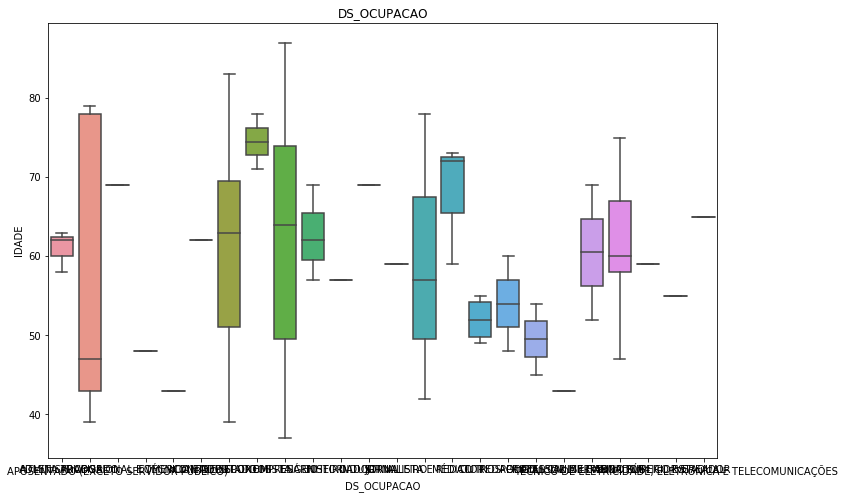

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'SG_PARTIDO')

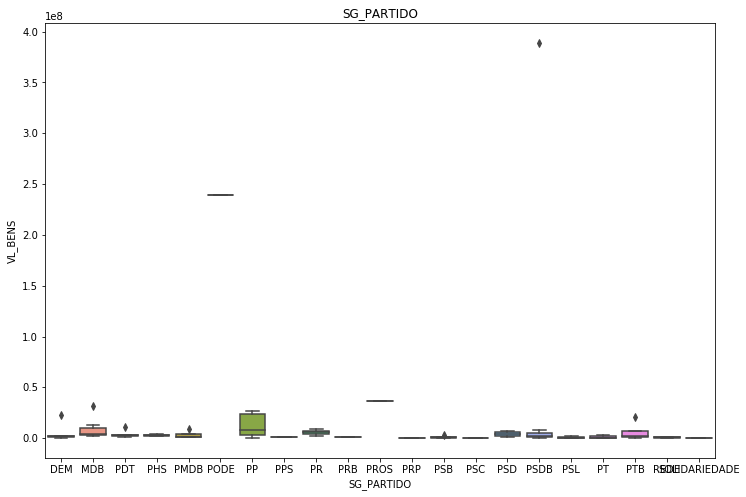

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'SG_PARTIDO')

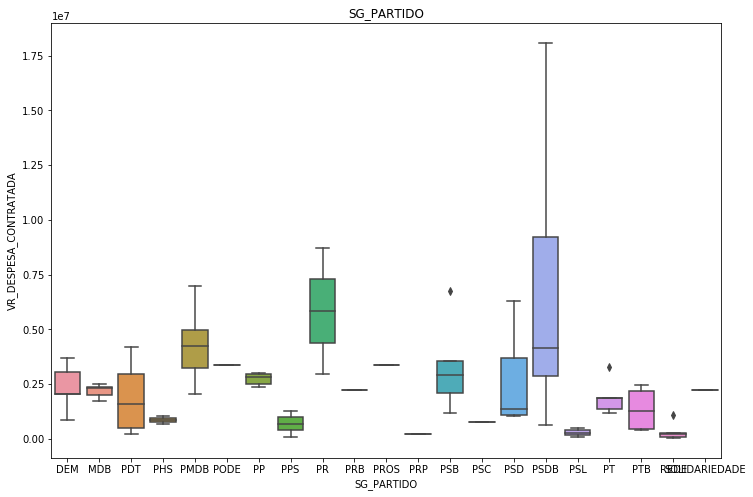

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'SG_PARTIDO')

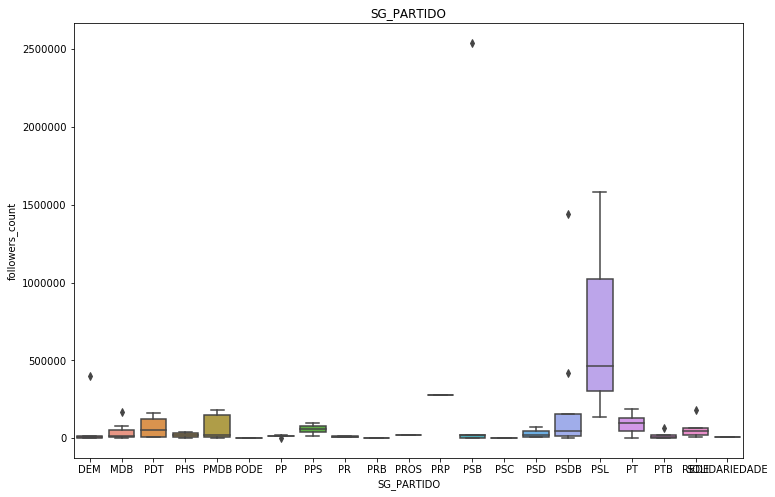

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'SG_PARTIDO')

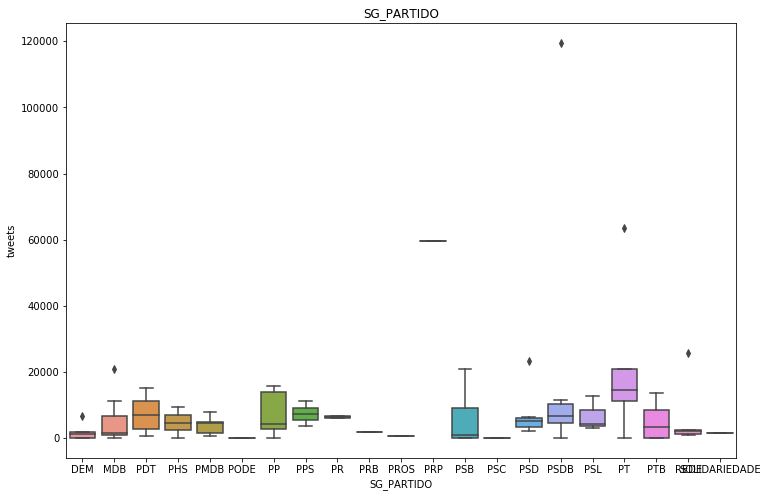

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'SG_PARTIDO')

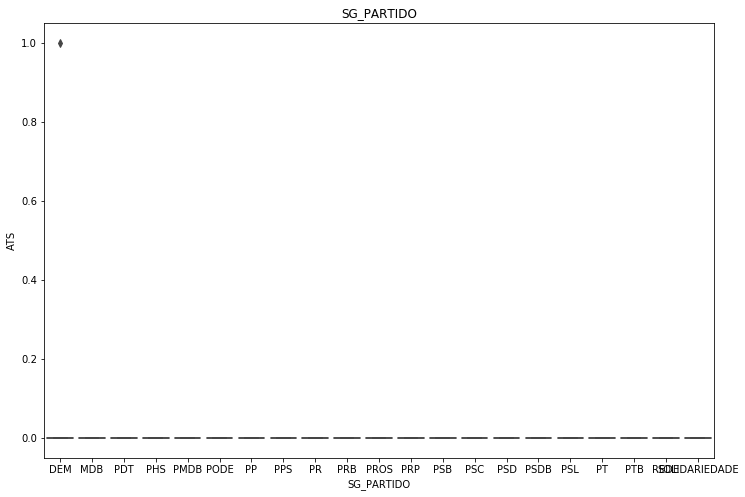

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'SG_PARTIDO')

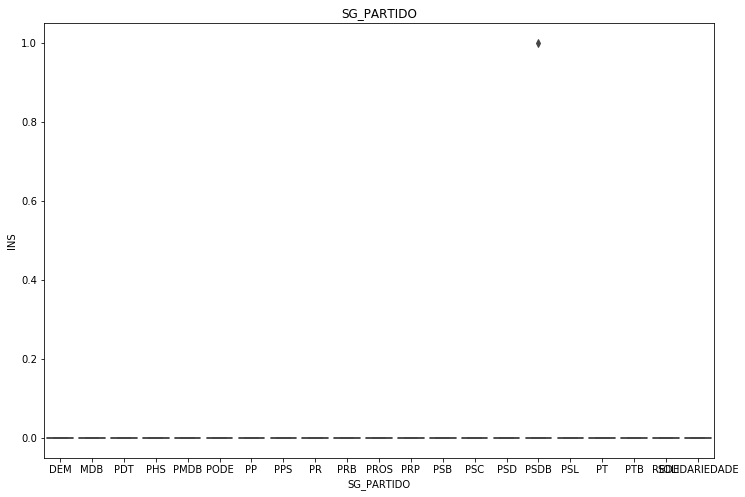

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'SG_PARTIDO')

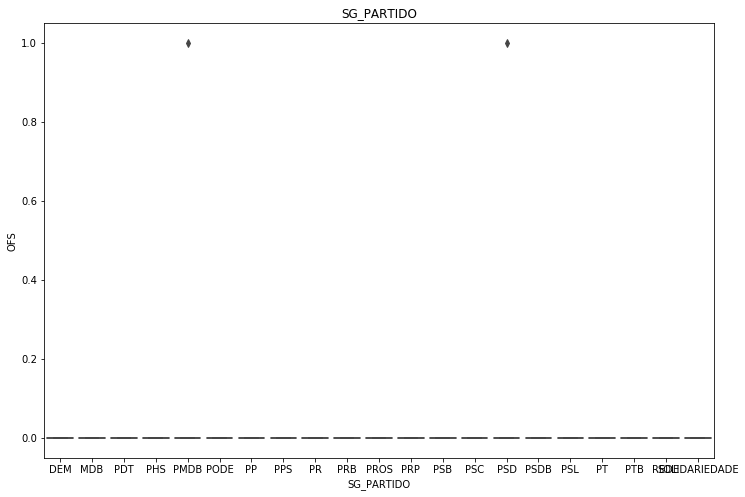

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'SG_PARTIDO')

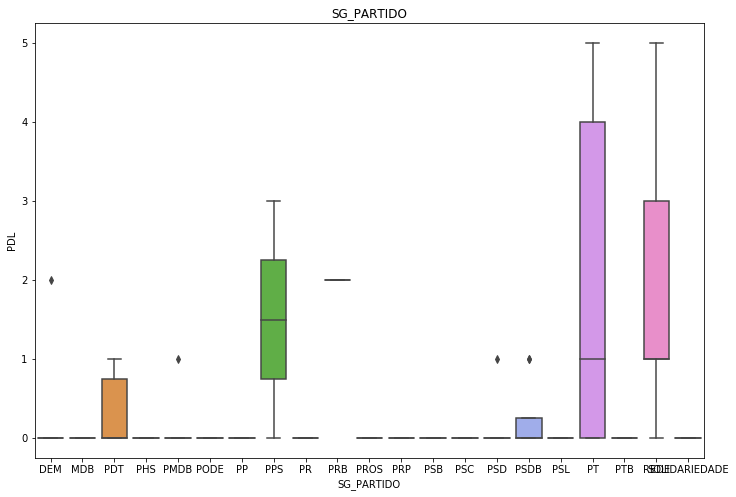

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'SG_PARTIDO')

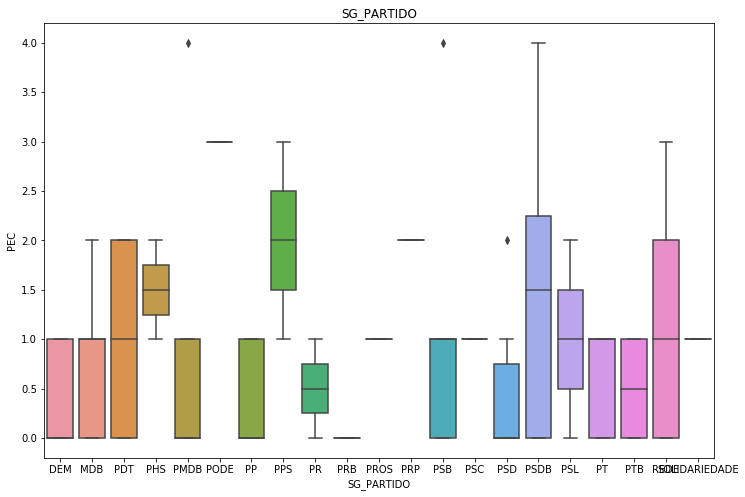

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'SG_PARTIDO')

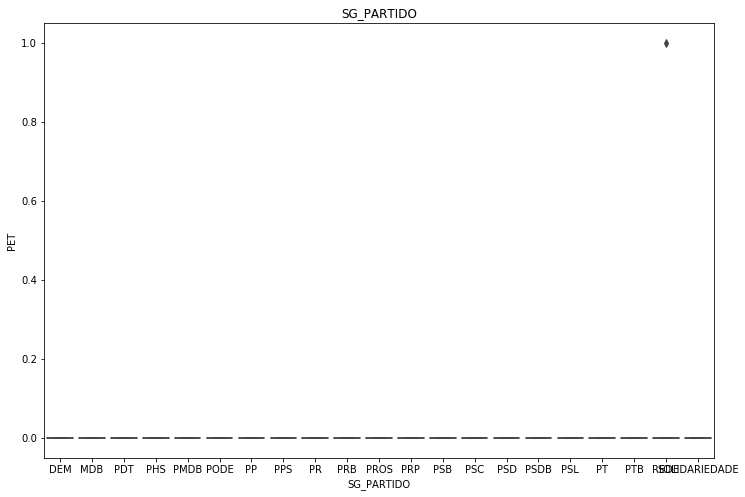

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'SG_PARTIDO')

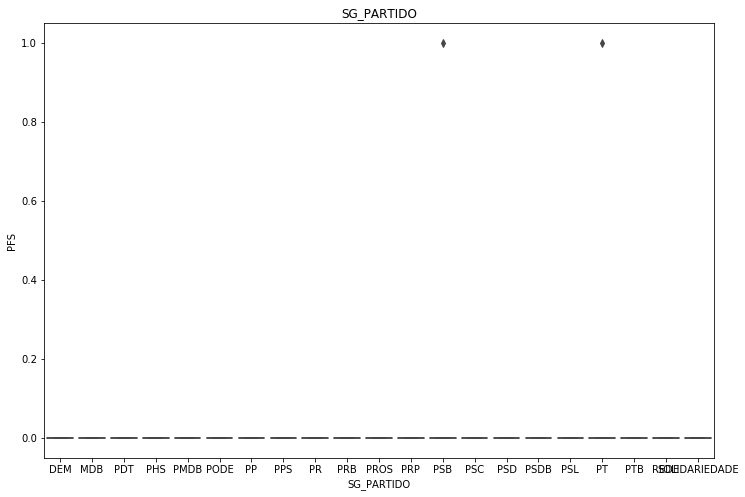

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'SG_PARTIDO')

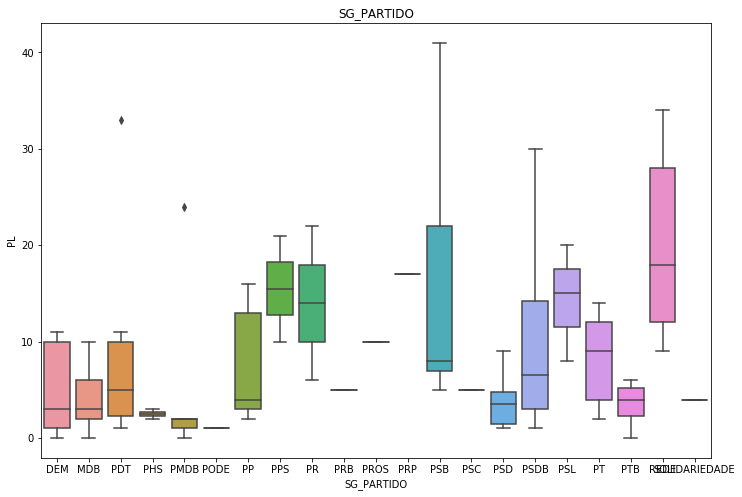

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'SG_PARTIDO')

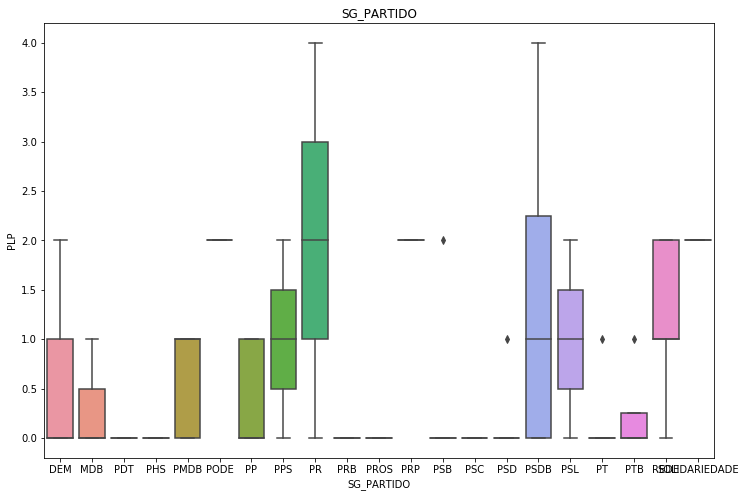

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'SG_PARTIDO')

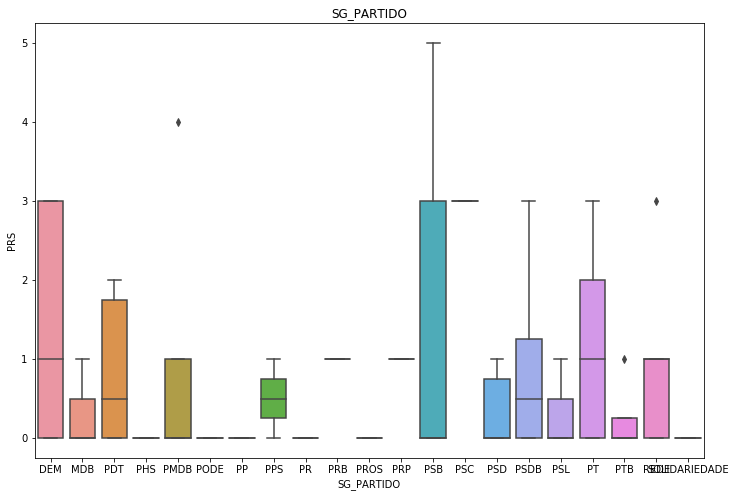

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'SG_PARTIDO')

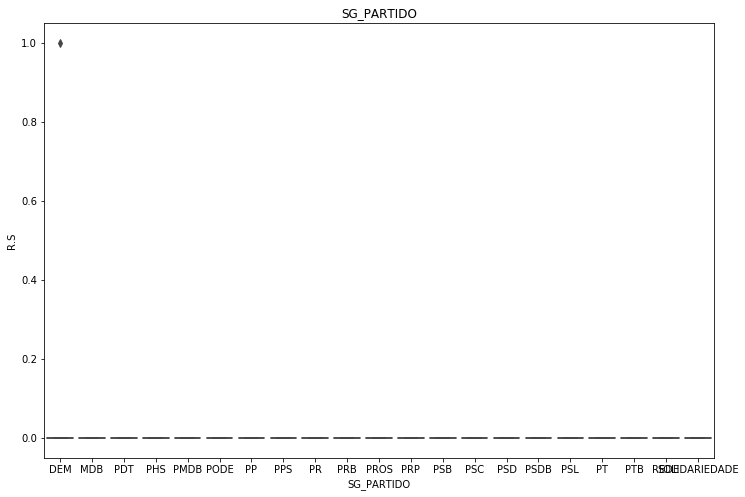

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'SG_PARTIDO')

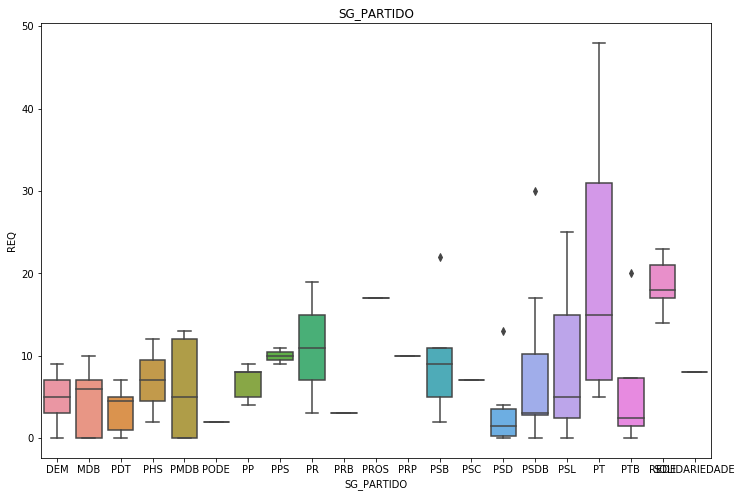

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'SG_PARTIDO')

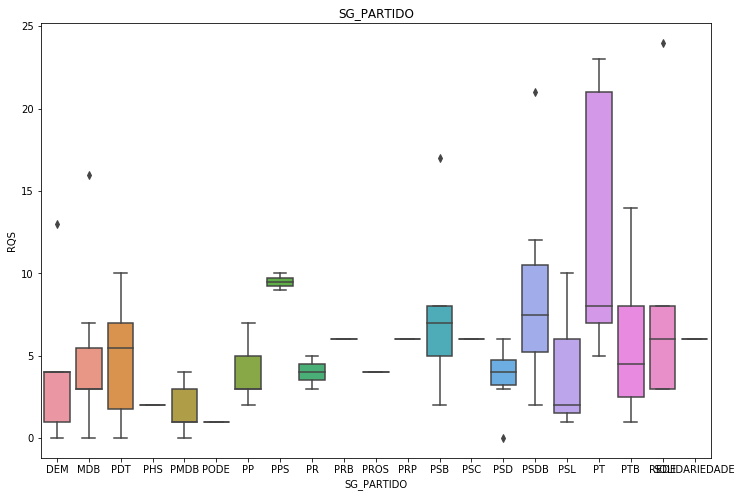

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'SG_PARTIDO')

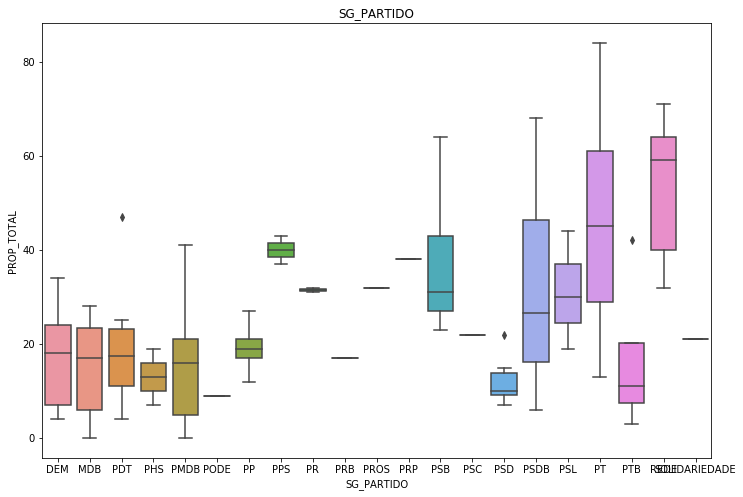

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'SG_PARTIDO')

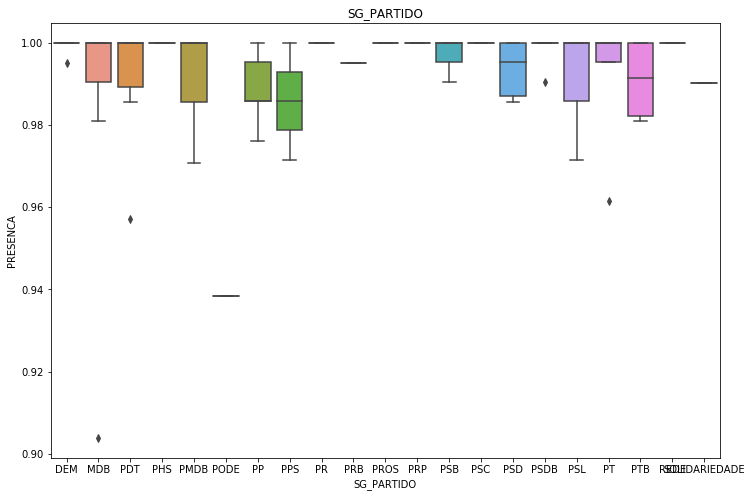

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'SG_PARTIDO')

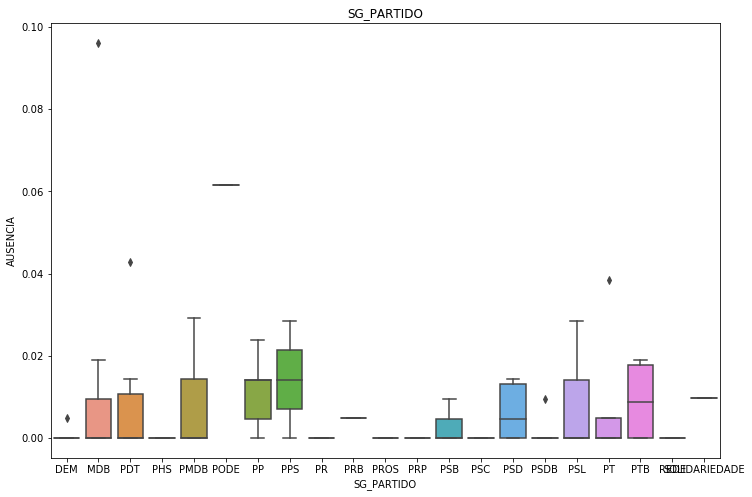

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'SG_PARTIDO')

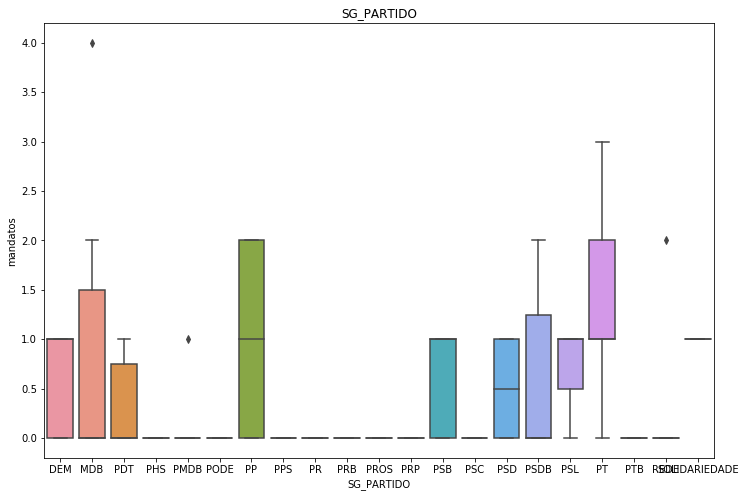

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'SG_PARTIDO')

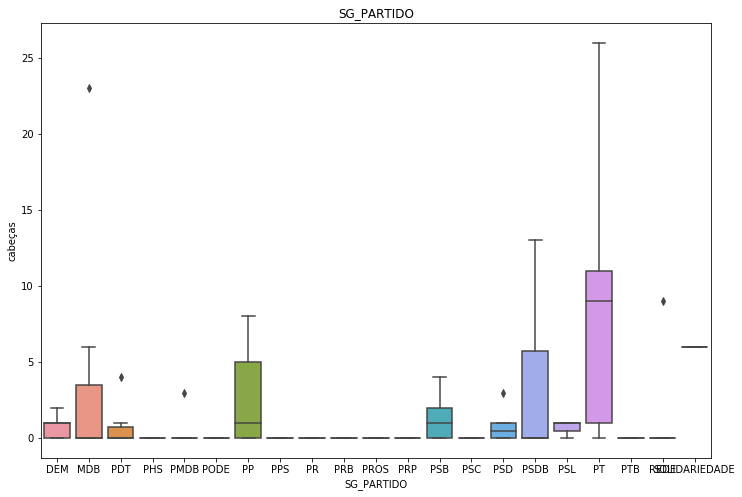

Text(0.5, 0, 'SG_PARTIDO')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'SG_PARTIDO')

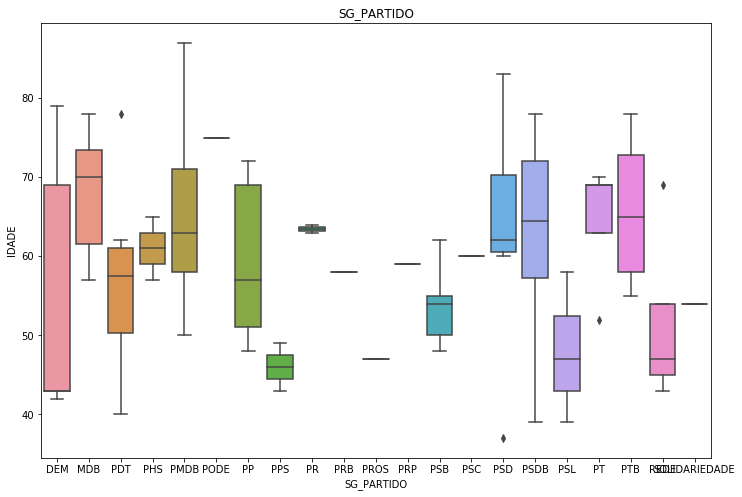

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'SG_UE')

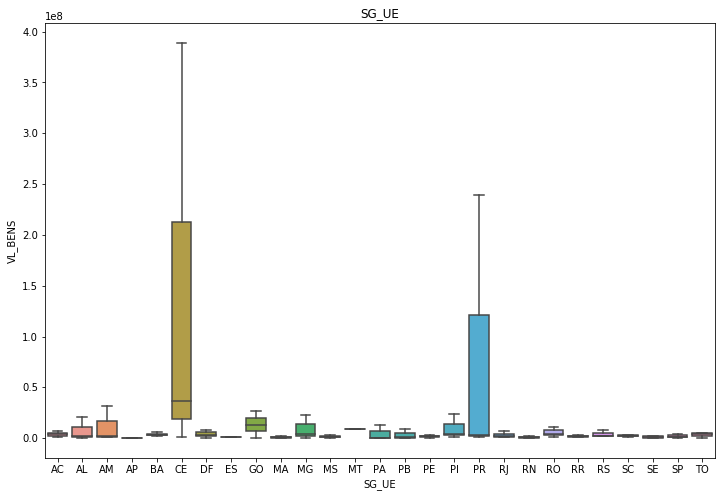

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'SG_UE')

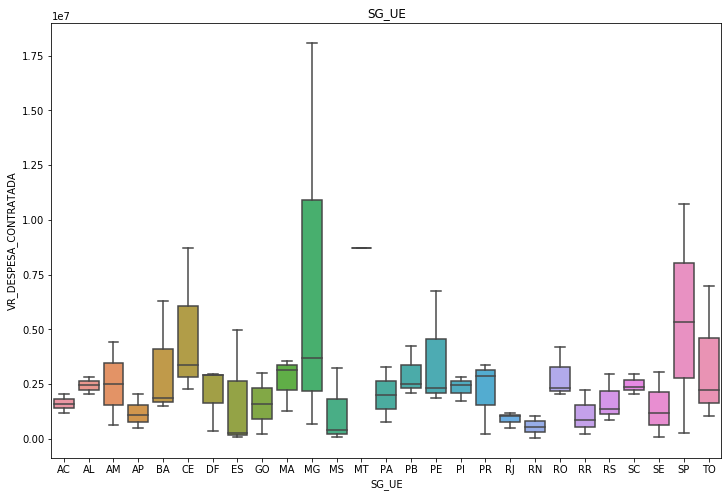

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'SG_UE')

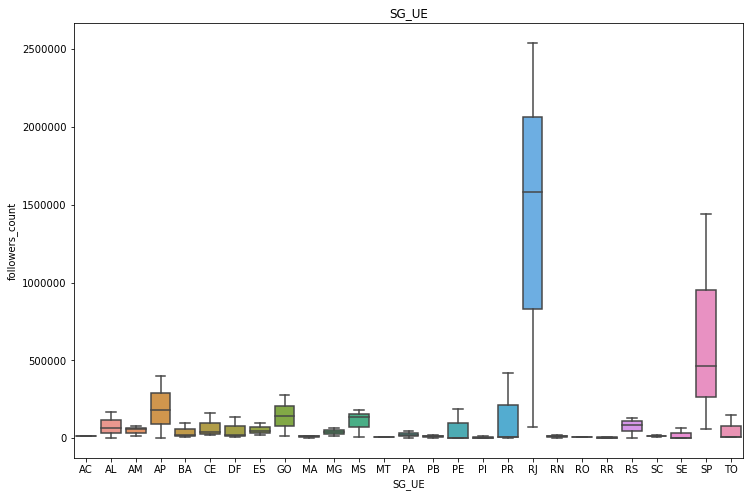

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'SG_UE')

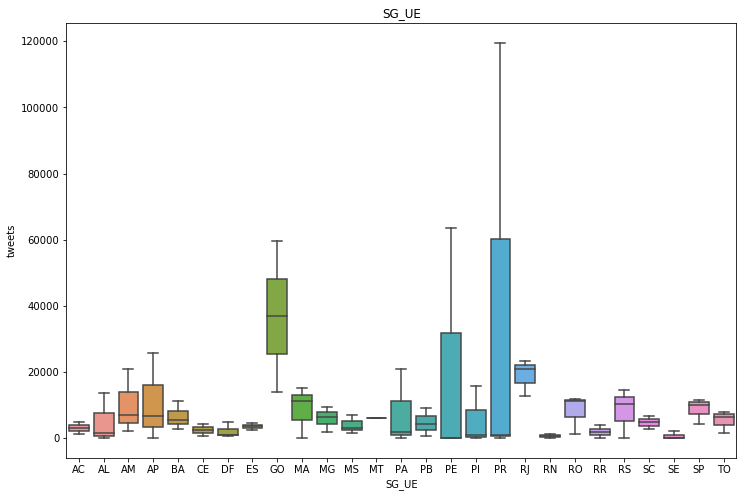

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'SG_UE')

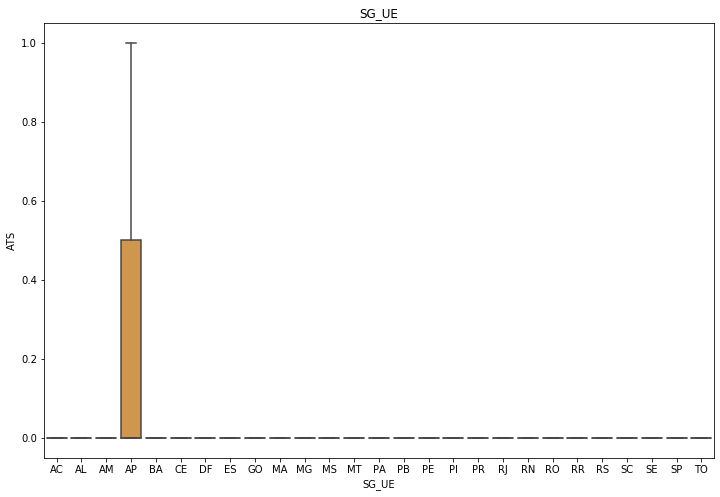

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'SG_UE')

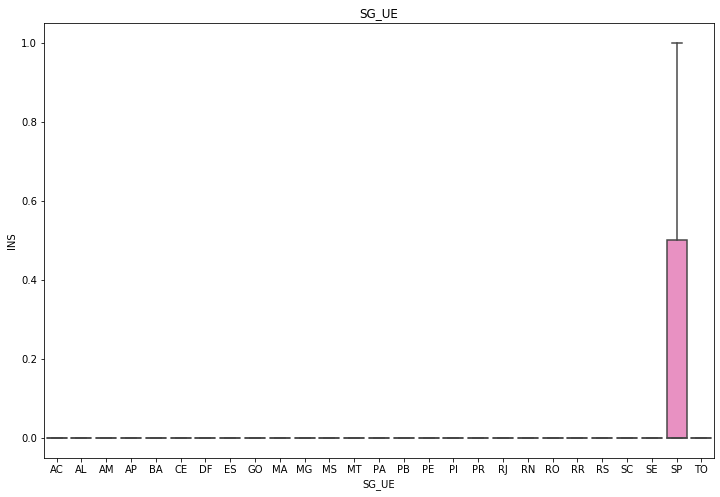

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'SG_UE')

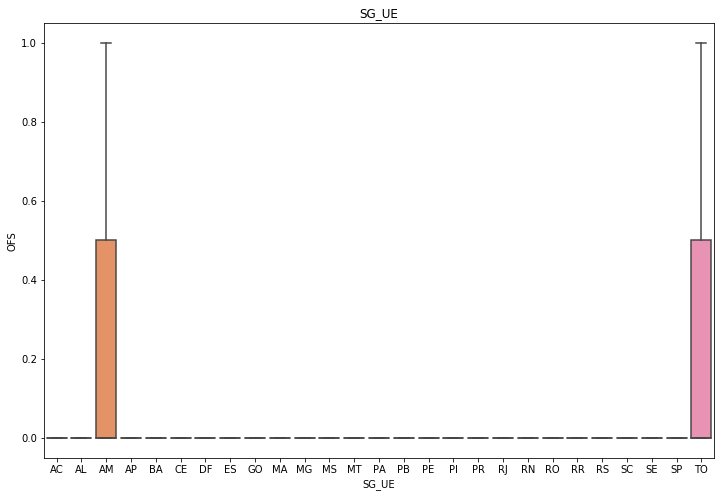

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'SG_UE')

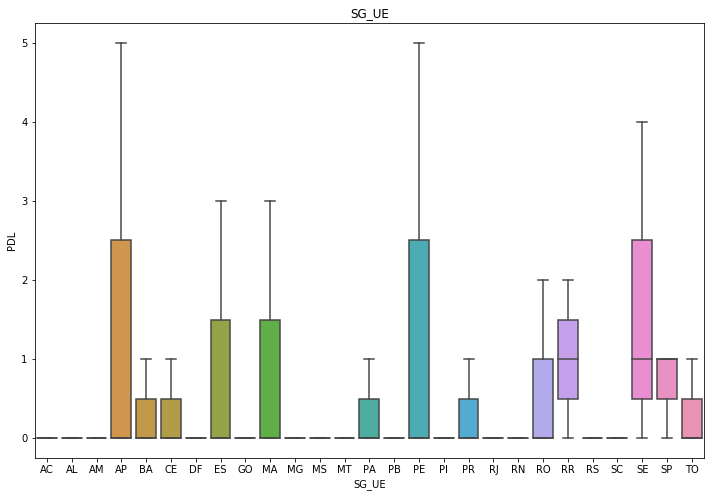

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'SG_UE')

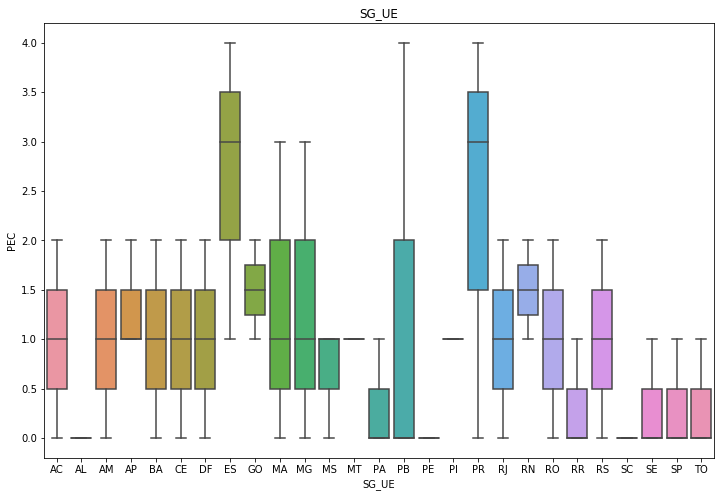

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'SG_UE')

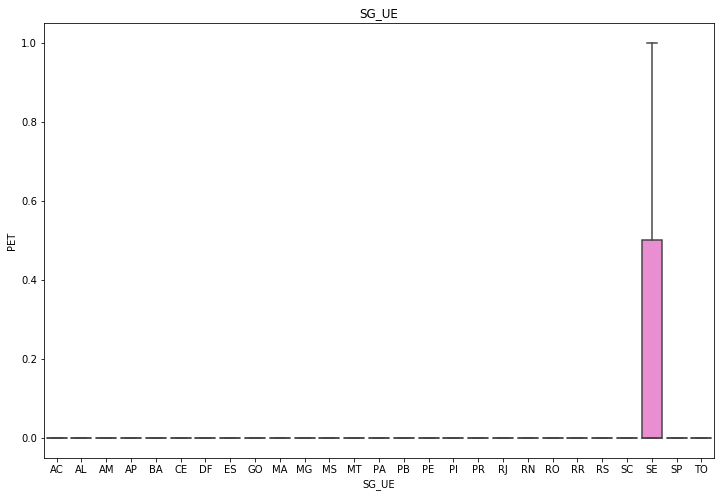

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'SG_UE')

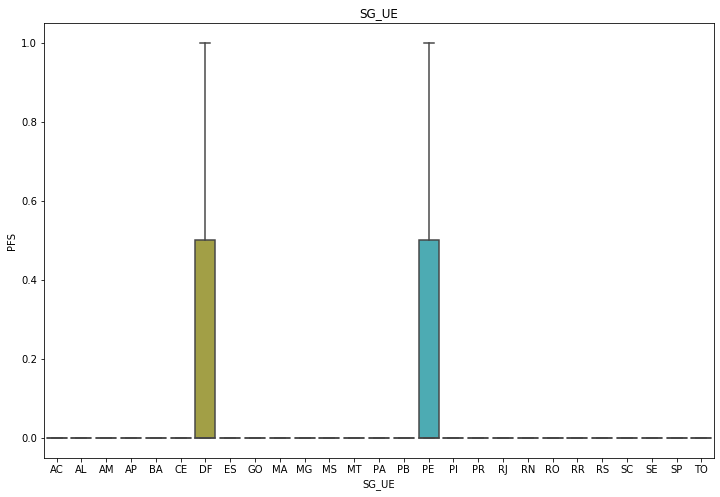

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'SG_UE')

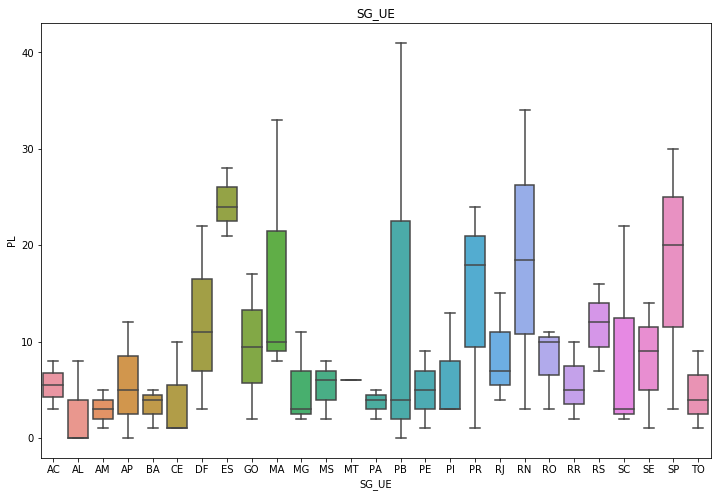

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'SG_UE')

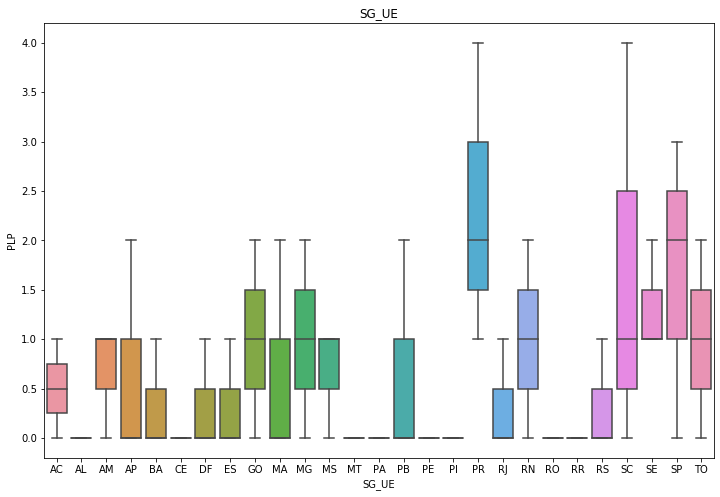

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'SG_UE')

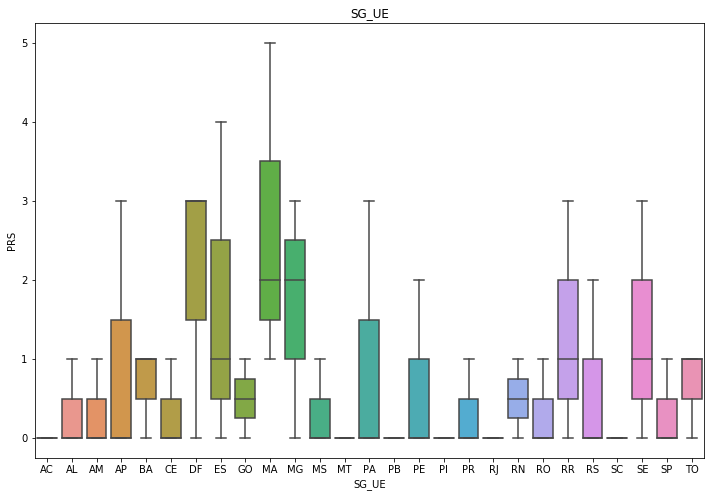

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'SG_UE')

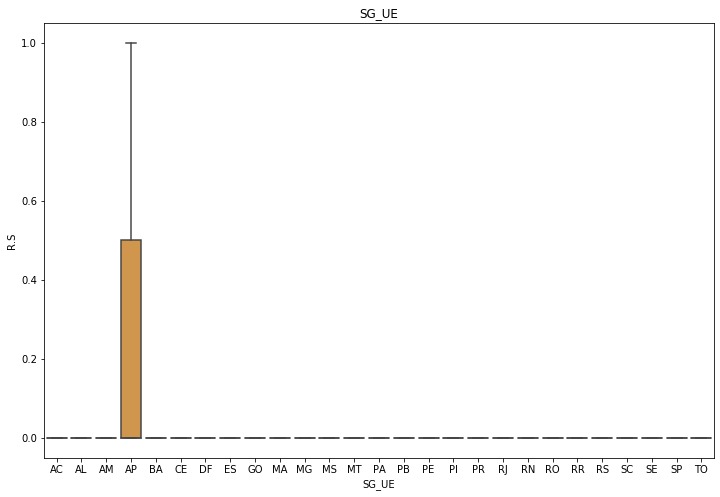

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'SG_UE')

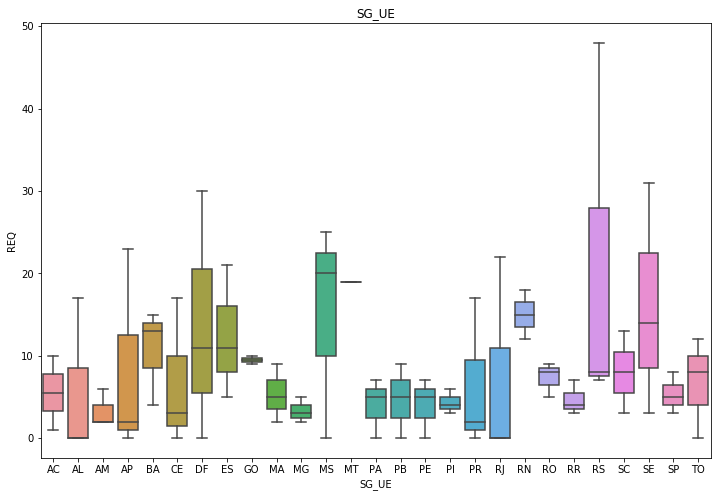

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'SG_UE')

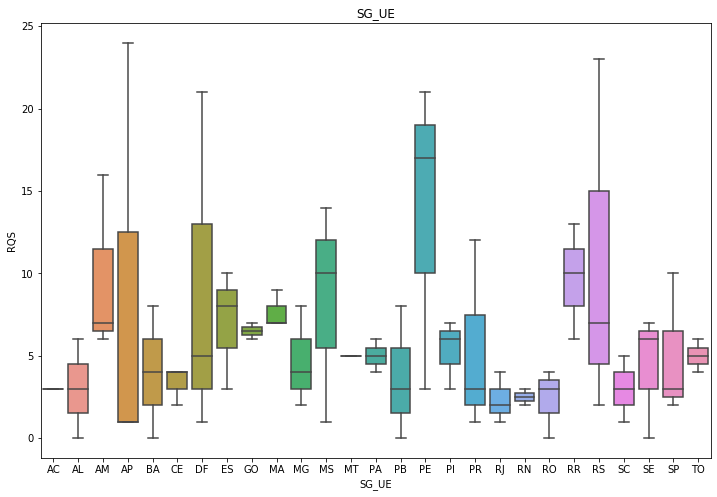

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'SG_UE')

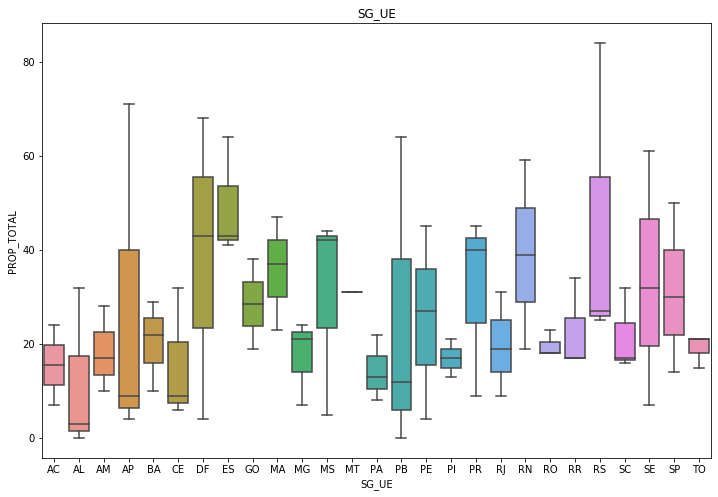

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'SG_UE')

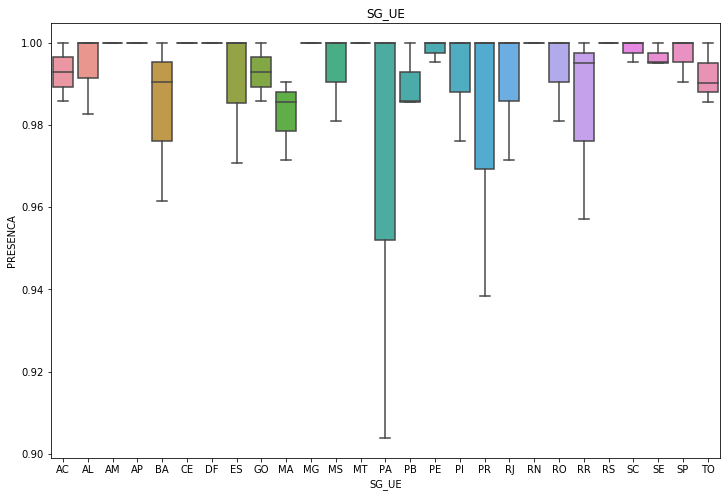

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'SG_UE')

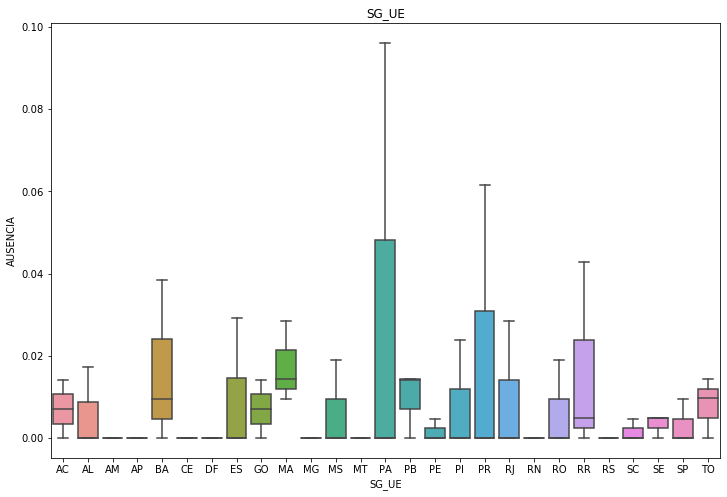

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'SG_UE')

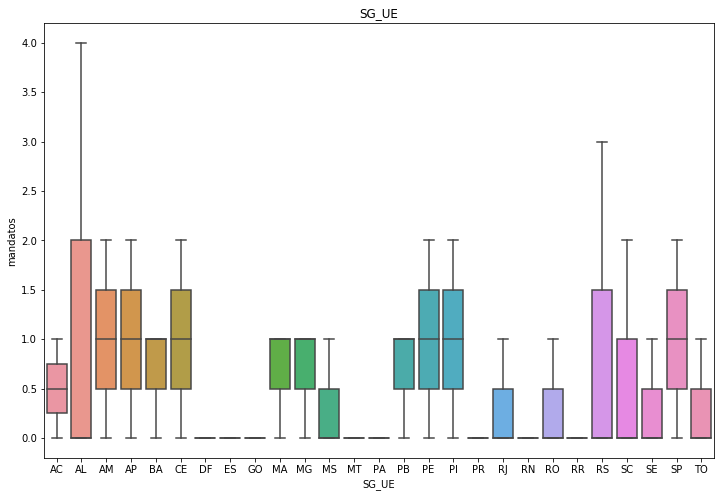

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'SG_UE')

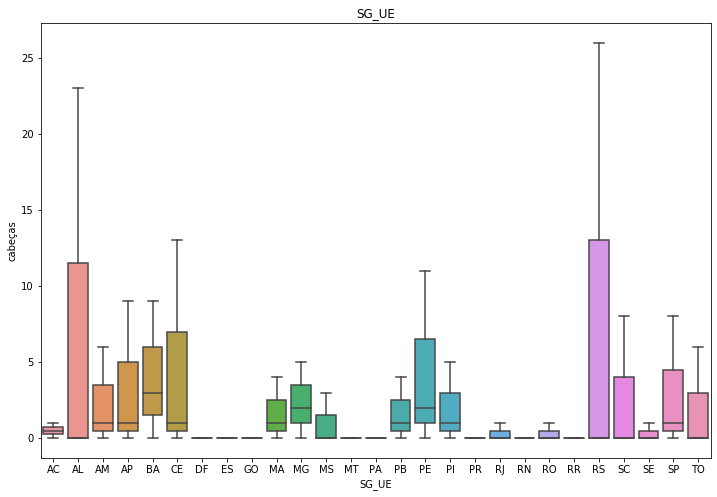

Text(0.5, 0, 'SG_UE')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'SG_UE')

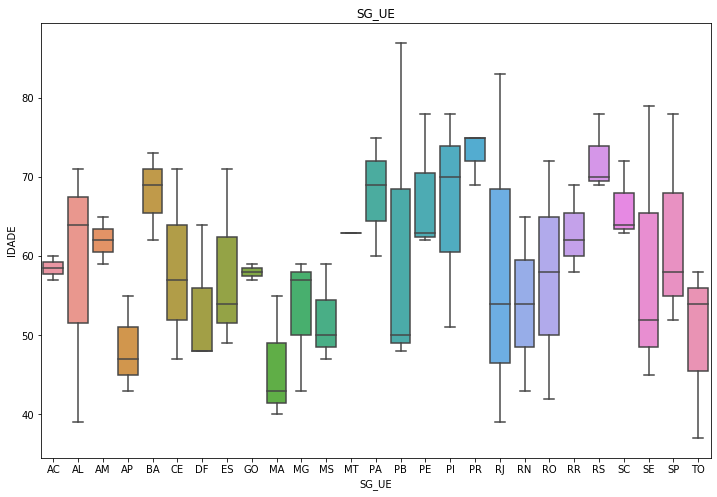

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'MESA')

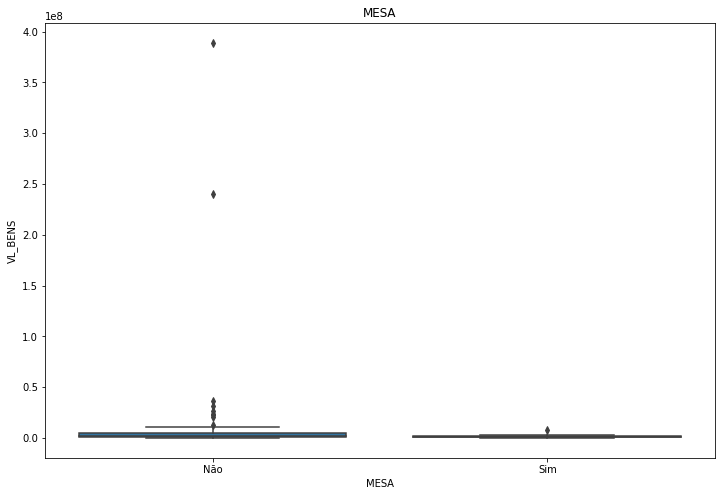

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'MESA')

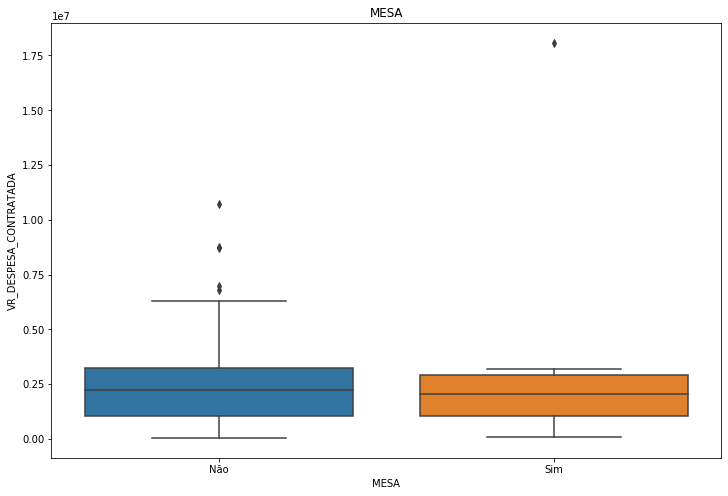

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'MESA')

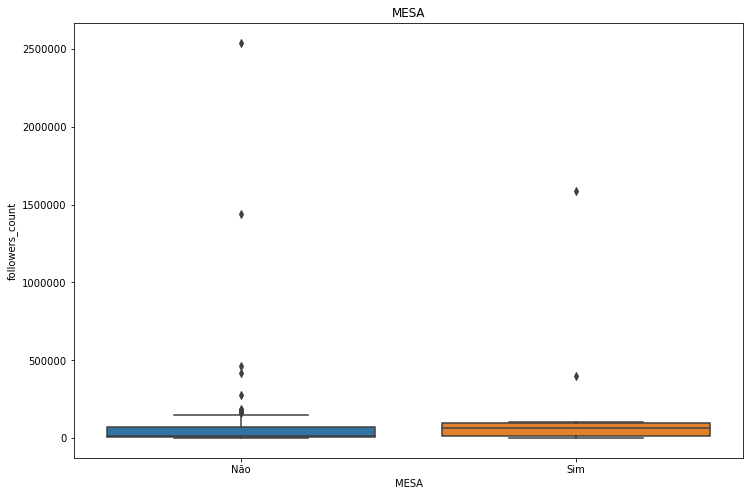

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'MESA')

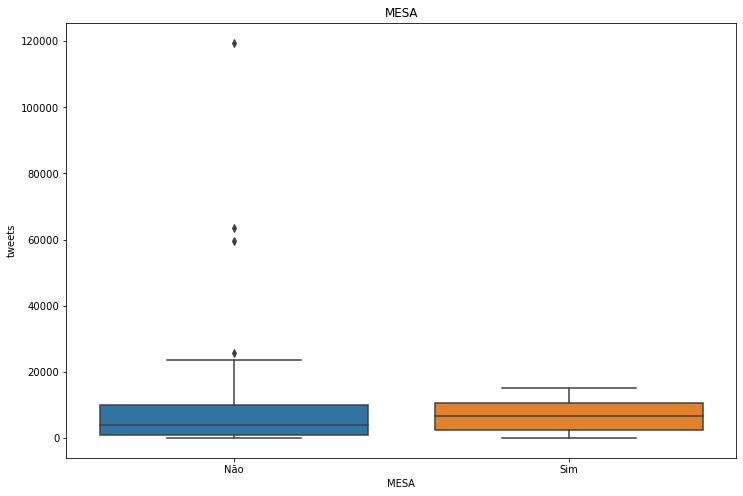

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'MESA')

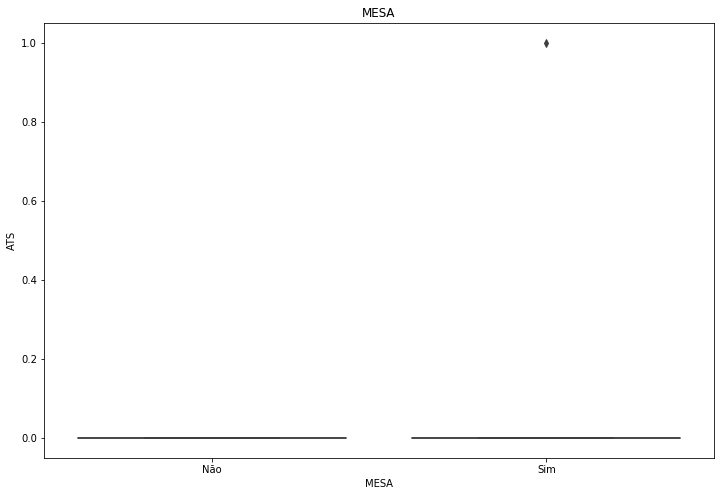

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'MESA')

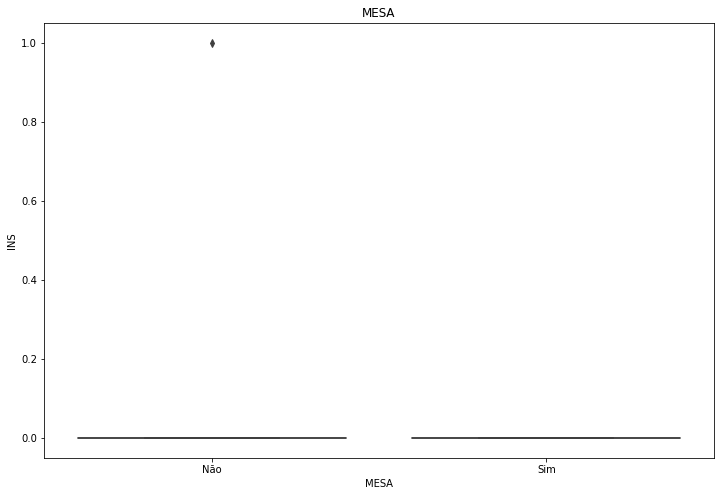

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'MESA')

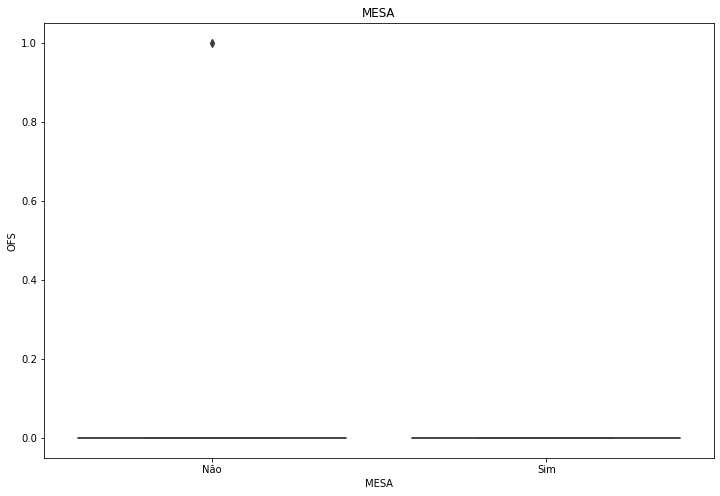

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'MESA')

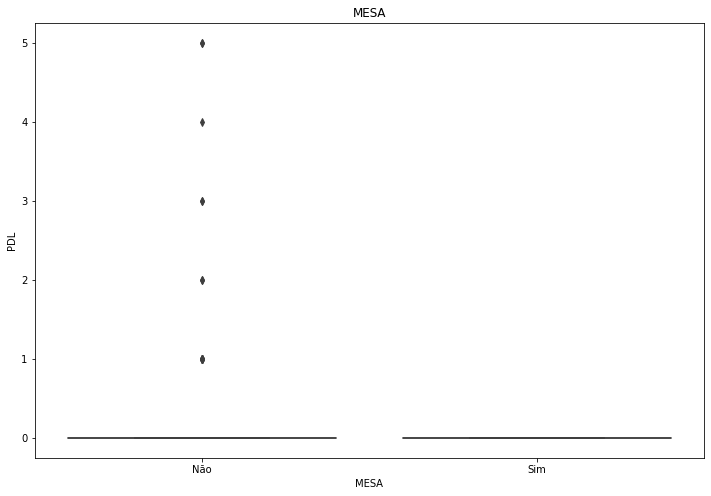

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'MESA')

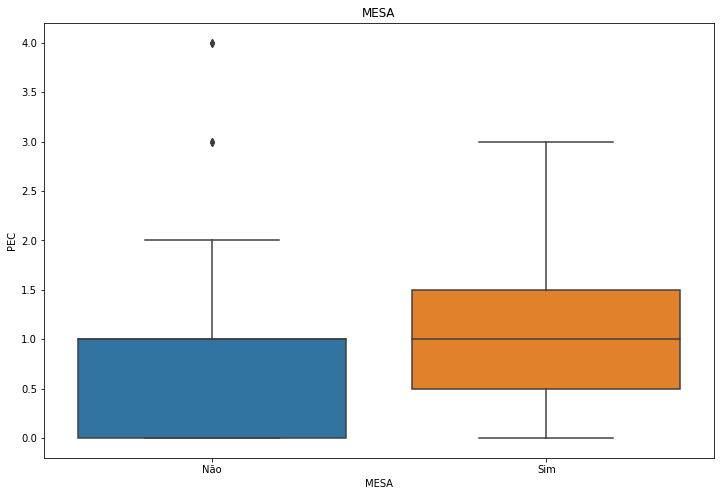

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'MESA')

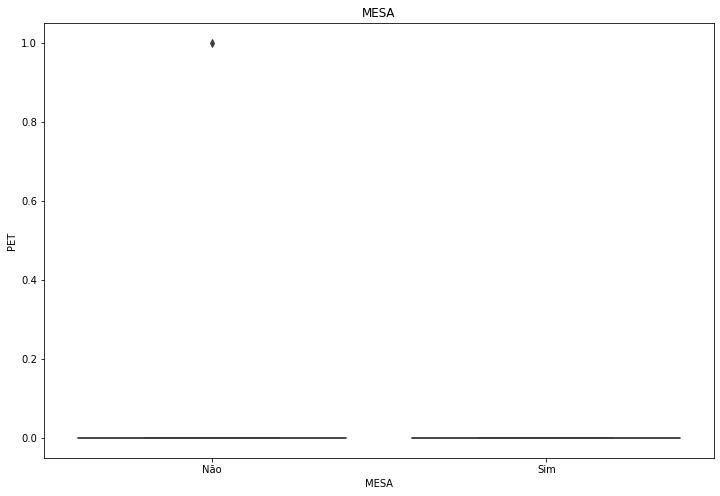

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'MESA')

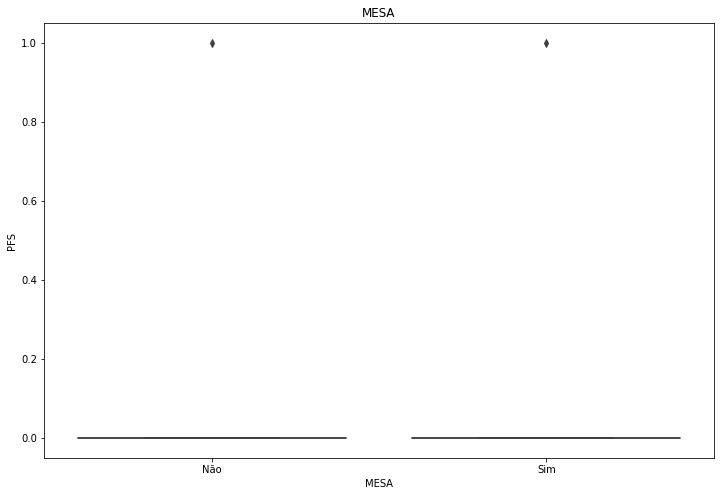

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'MESA')

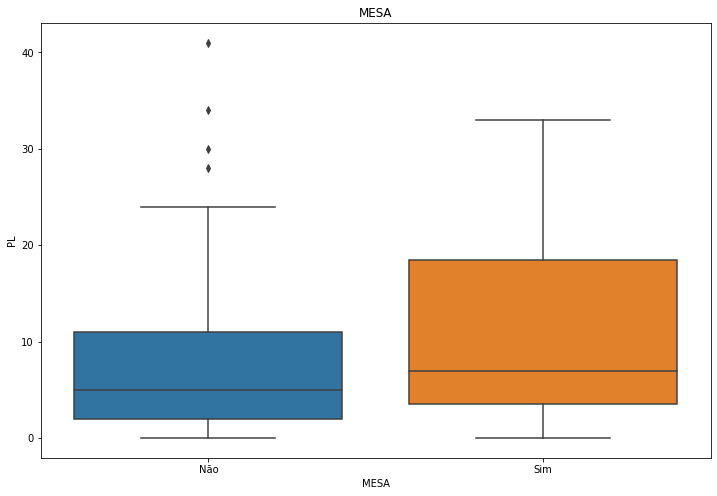

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'MESA')

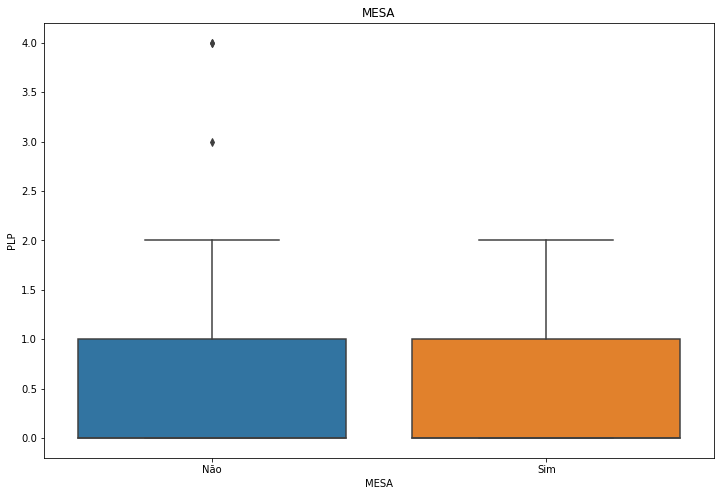

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'MESA')

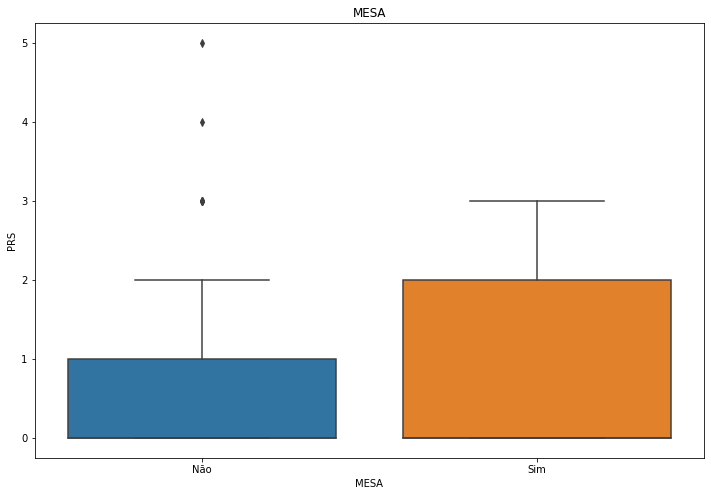

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'MESA')

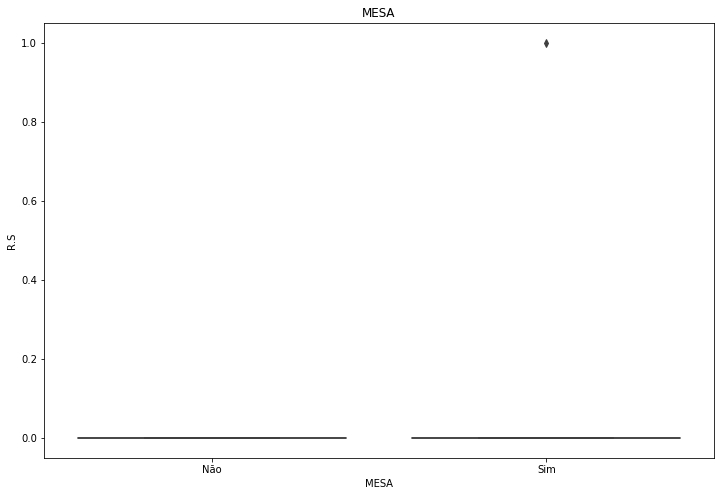

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'MESA')

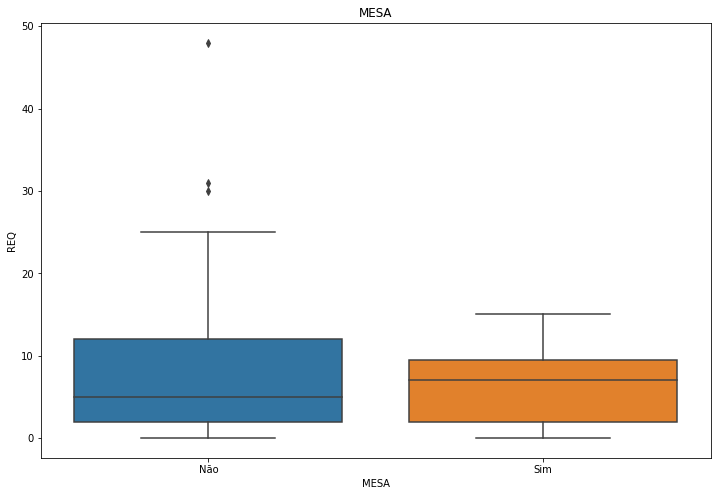

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'MESA')

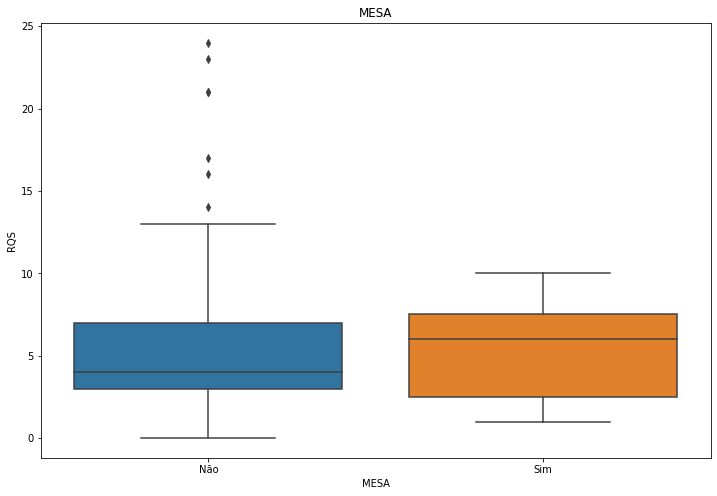

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'MESA')

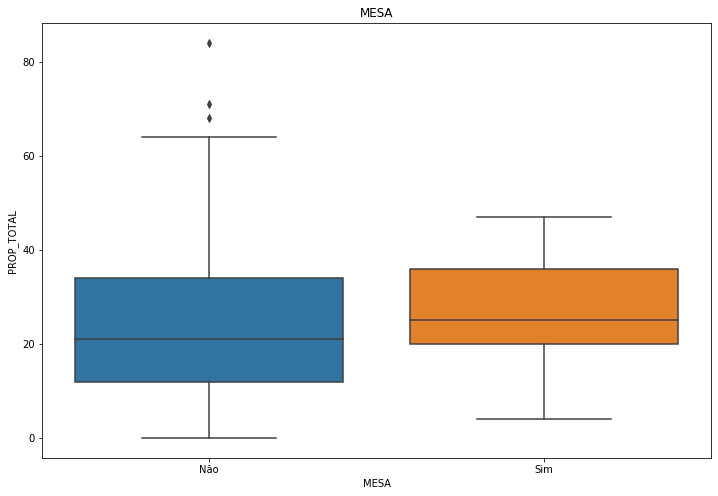

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'MESA')

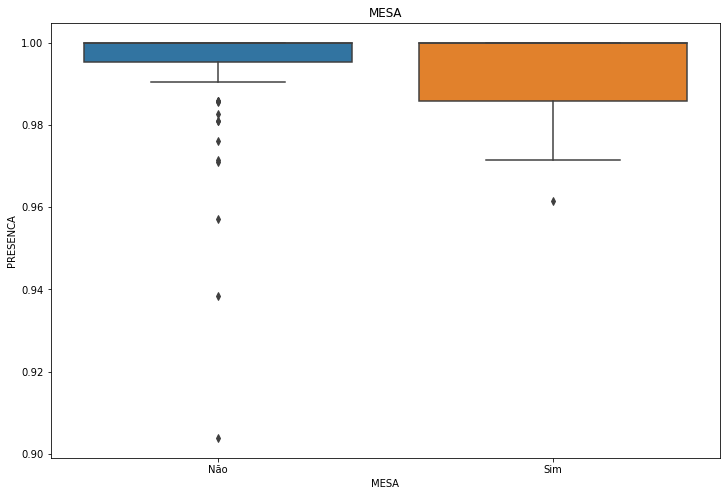

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'MESA')

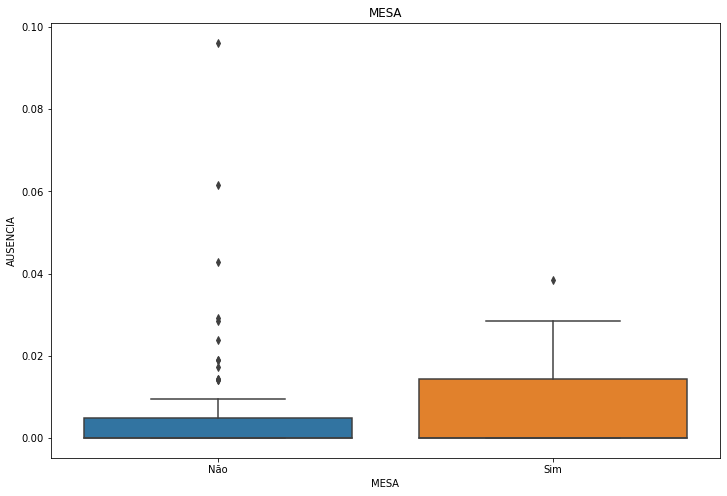

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'MESA')

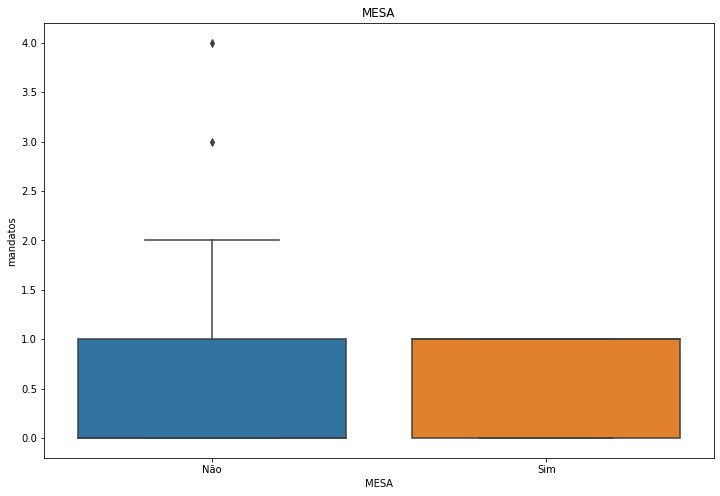

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'MESA')

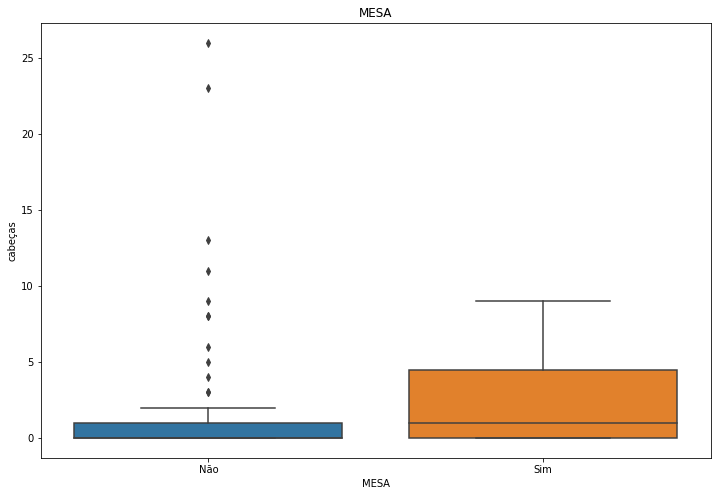

Text(0.5, 0, 'MESA')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'MESA')

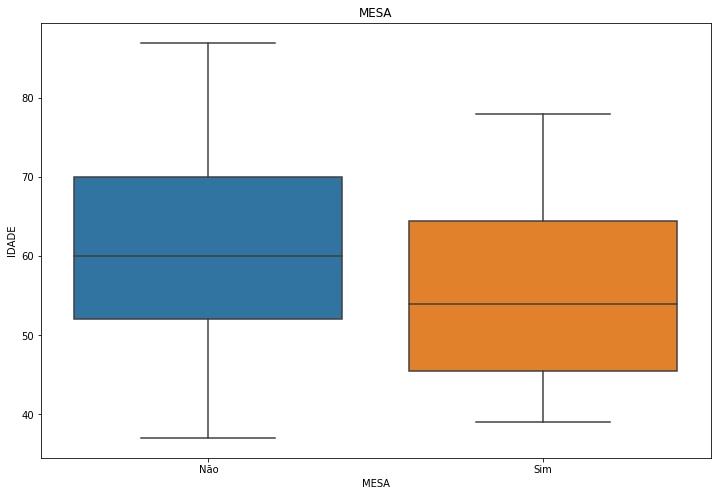

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'VL_BENS')

Text(0.5, 1.0, 'LIDERANCA')

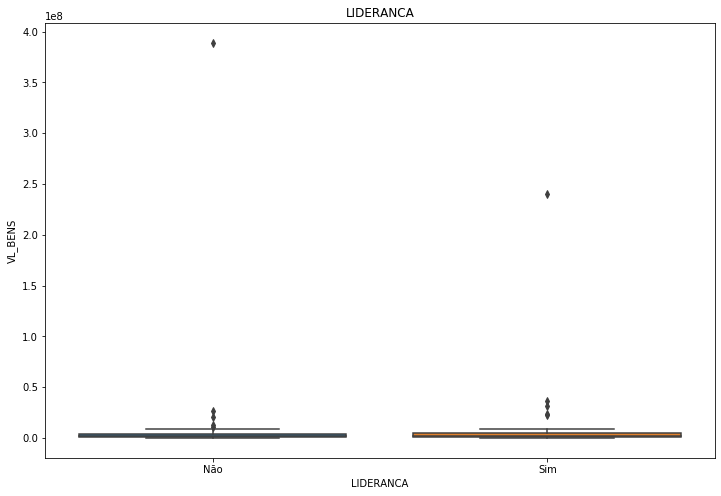

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'VR_DESPESA_CONTRATADA')

Text(0.5, 1.0, 'LIDERANCA')

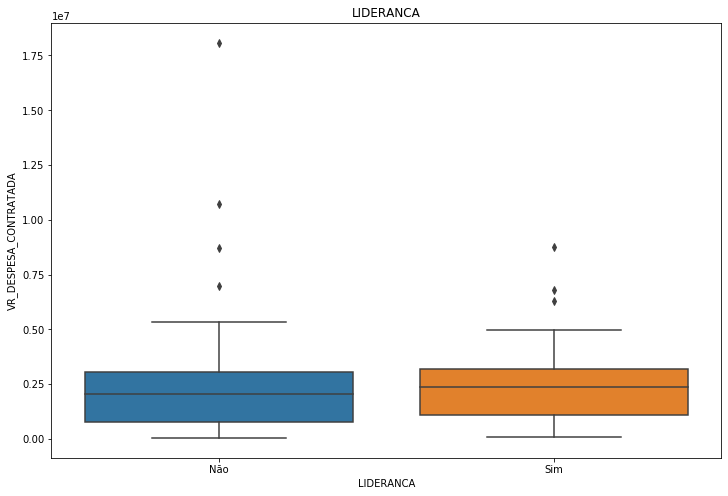

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'followers_count')

Text(0.5, 1.0, 'LIDERANCA')

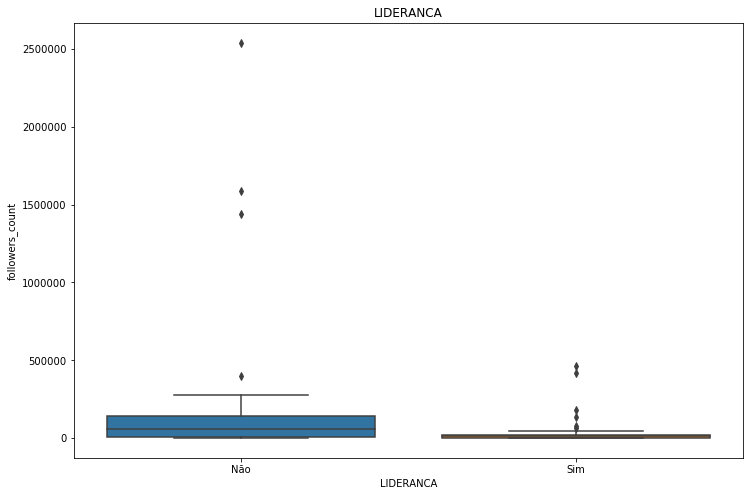

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'tweets')

Text(0.5, 1.0, 'LIDERANCA')

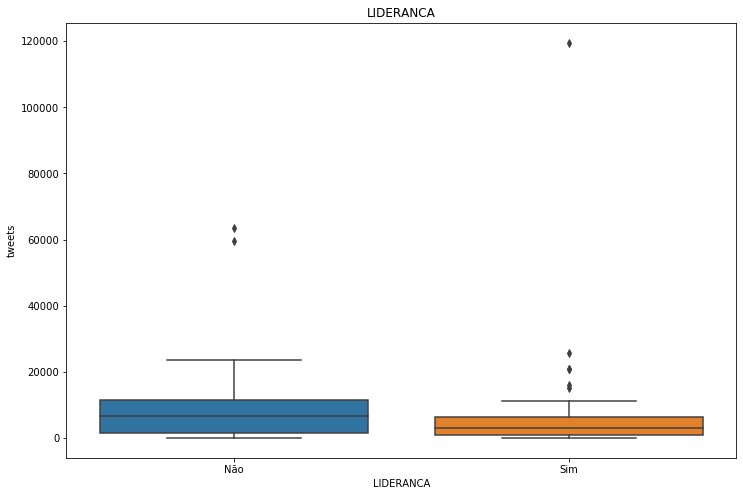

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'ATS')

Text(0.5, 1.0, 'LIDERANCA')

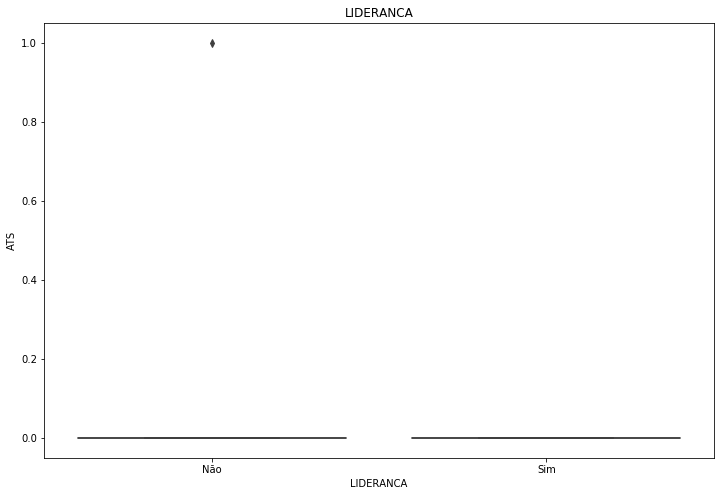

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'INS')

Text(0.5, 1.0, 'LIDERANCA')

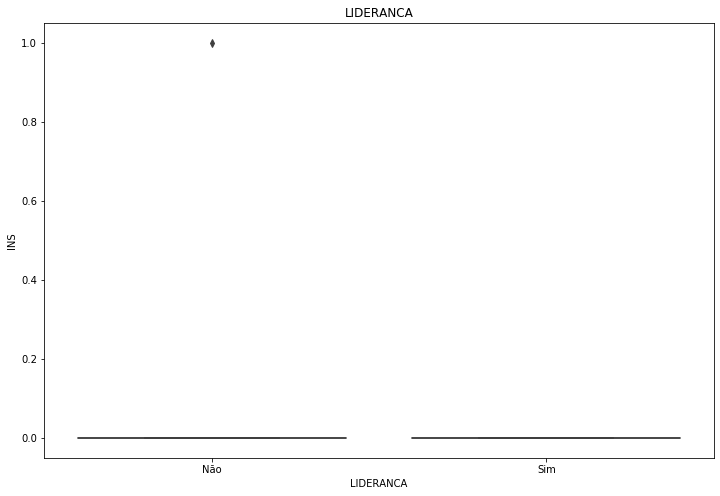

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'OFS')

Text(0.5, 1.0, 'LIDERANCA')

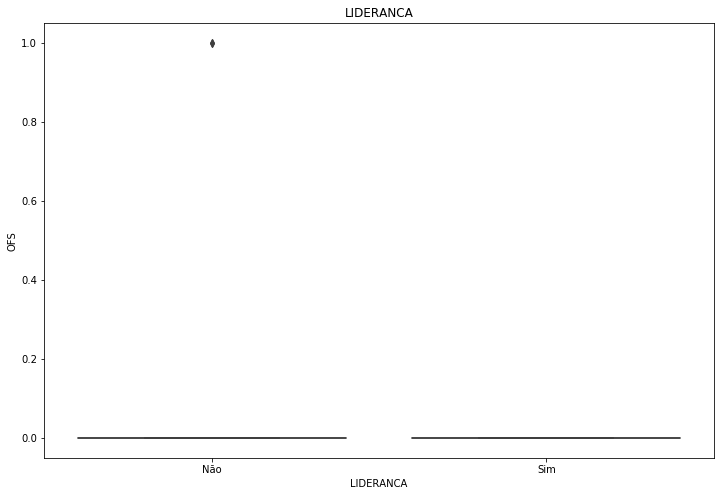

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'PDL')

Text(0.5, 1.0, 'LIDERANCA')

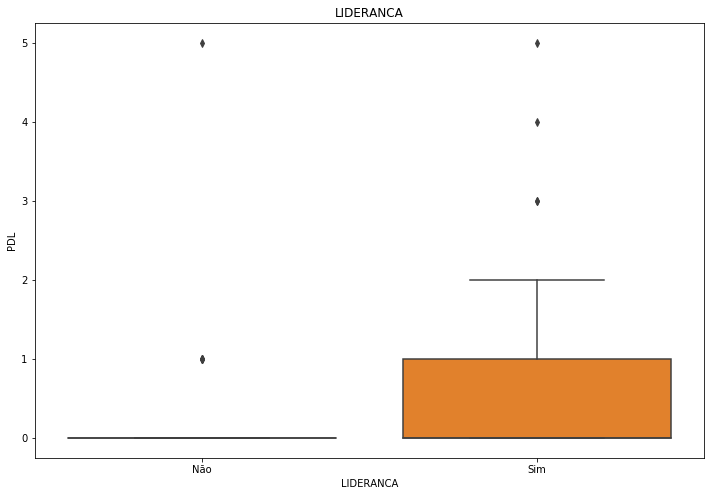

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'PEC')

Text(0.5, 1.0, 'LIDERANCA')

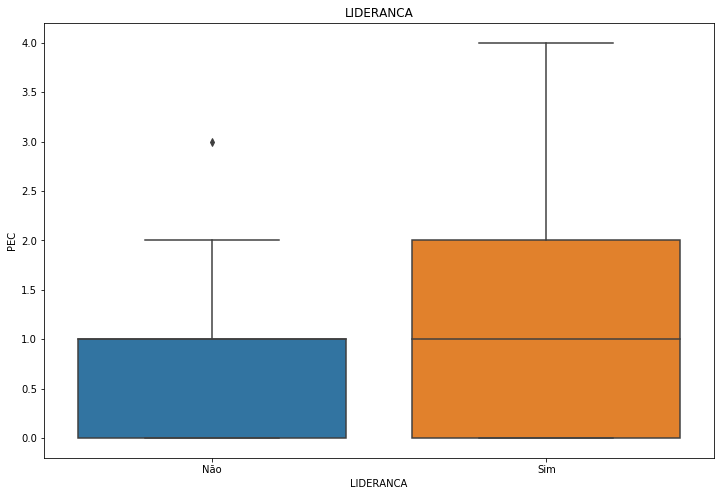

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'PET')

Text(0.5, 1.0, 'LIDERANCA')

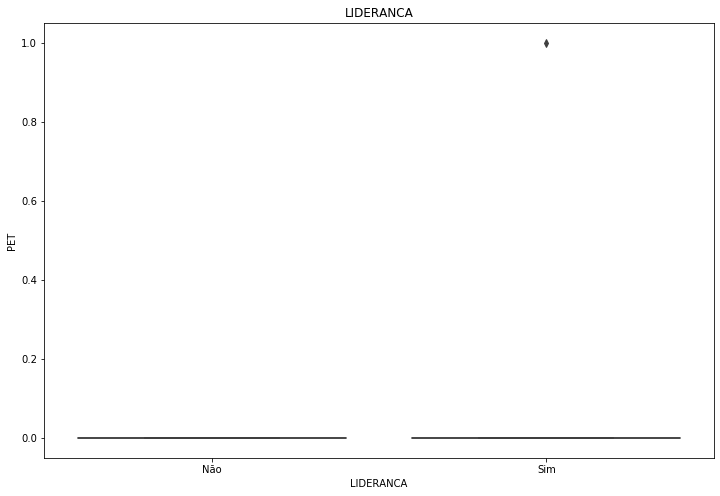

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'PFS')

Text(0.5, 1.0, 'LIDERANCA')

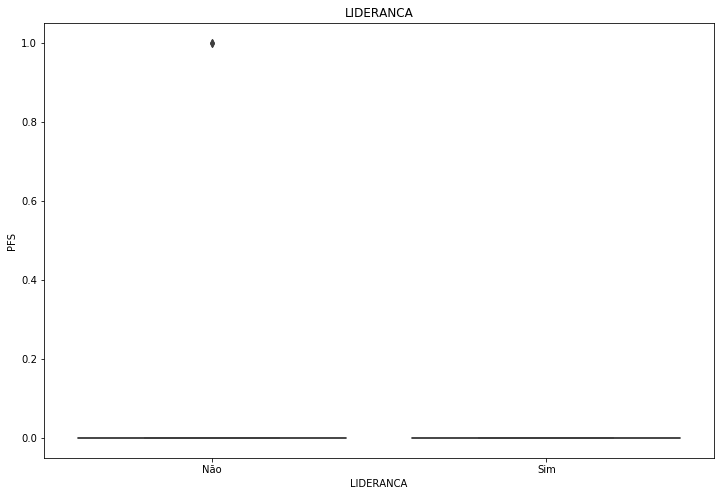

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'PL')

Text(0.5, 1.0, 'LIDERANCA')

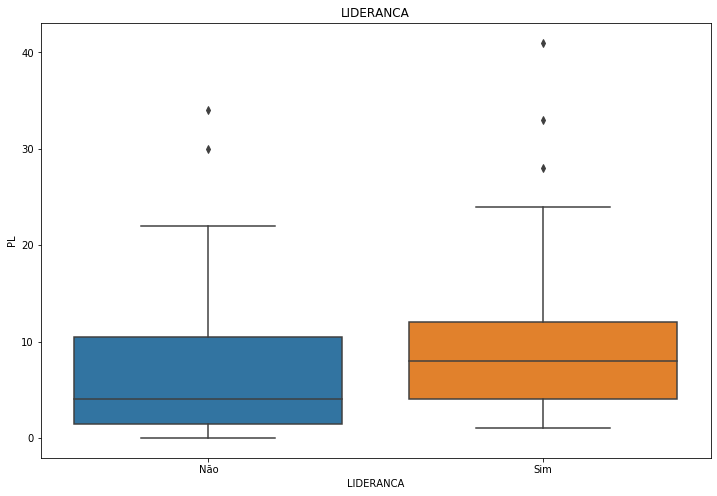

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'PLP')

Text(0.5, 1.0, 'LIDERANCA')

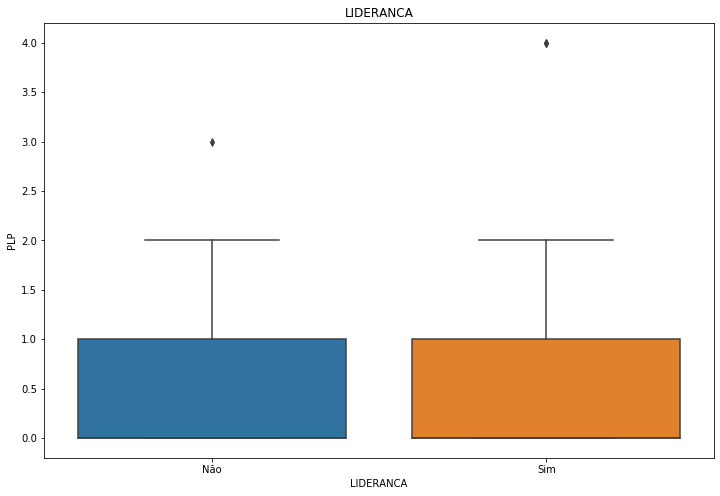

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'PRS')

Text(0.5, 1.0, 'LIDERANCA')

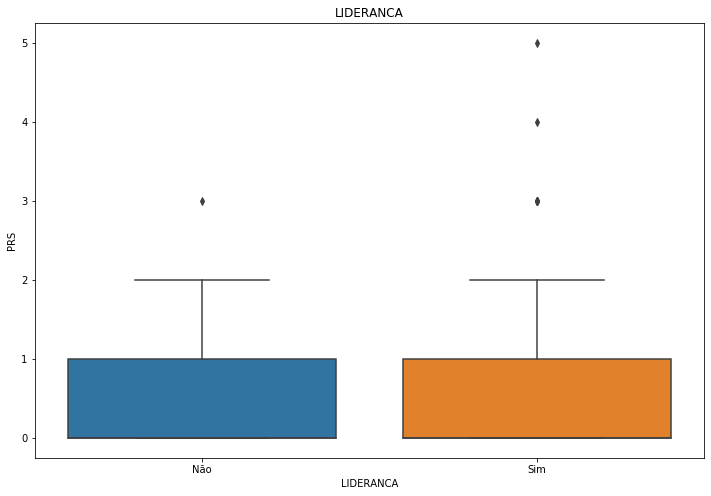

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'R.S')

Text(0.5, 1.0, 'LIDERANCA')

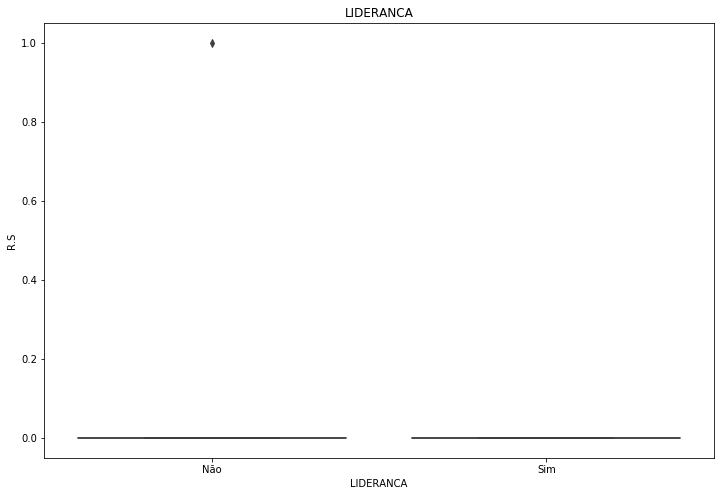

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'REQ')

Text(0.5, 1.0, 'LIDERANCA')

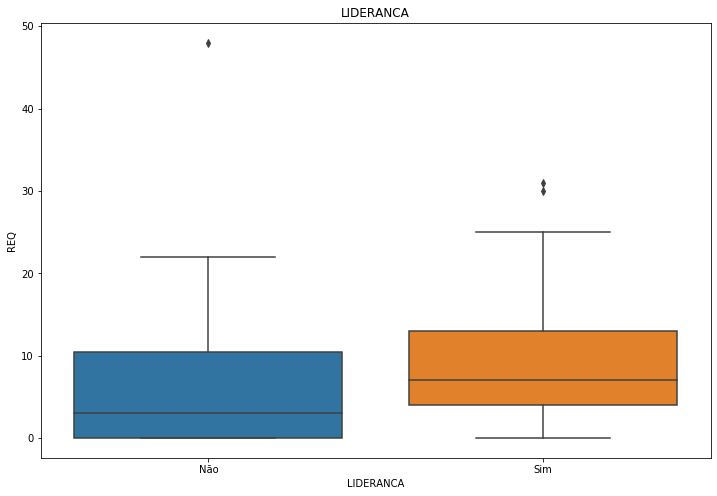

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'RQS')

Text(0.5, 1.0, 'LIDERANCA')

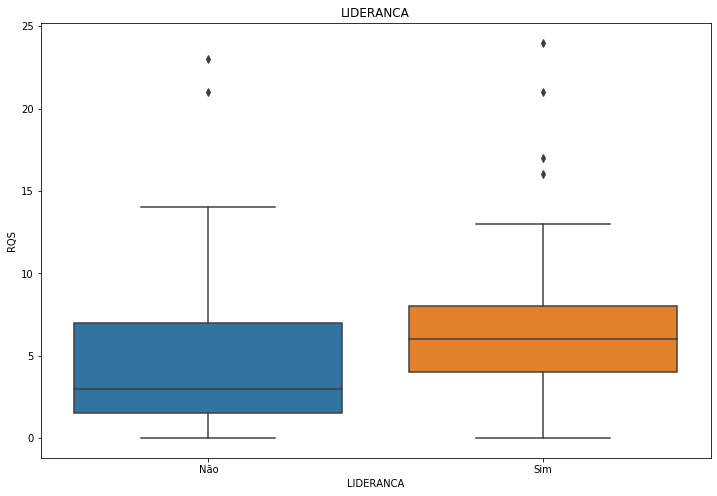

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'PROP_TOTAL')

Text(0.5, 1.0, 'LIDERANCA')

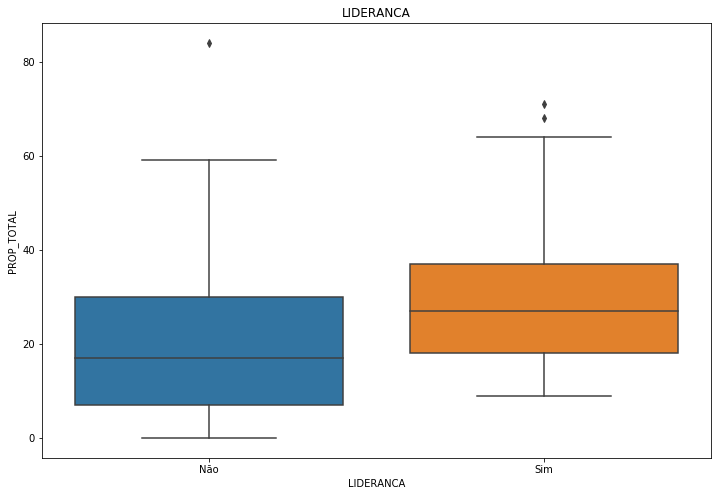

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'PRESENCA')

Text(0.5, 1.0, 'LIDERANCA')

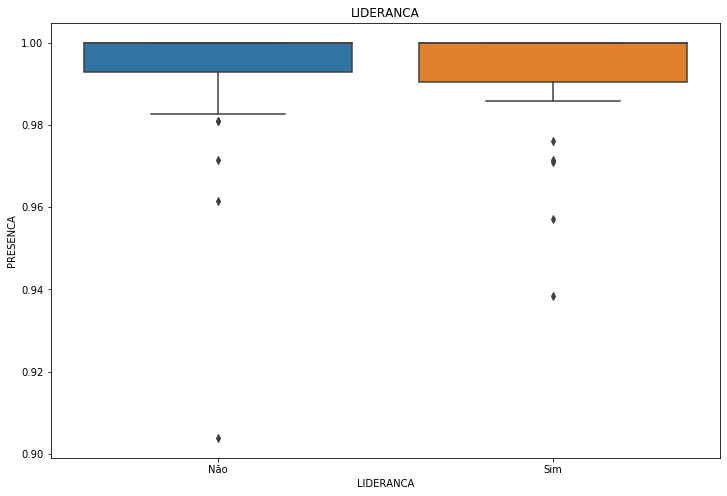

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'AUSENCIA')

Text(0.5, 1.0, 'LIDERANCA')

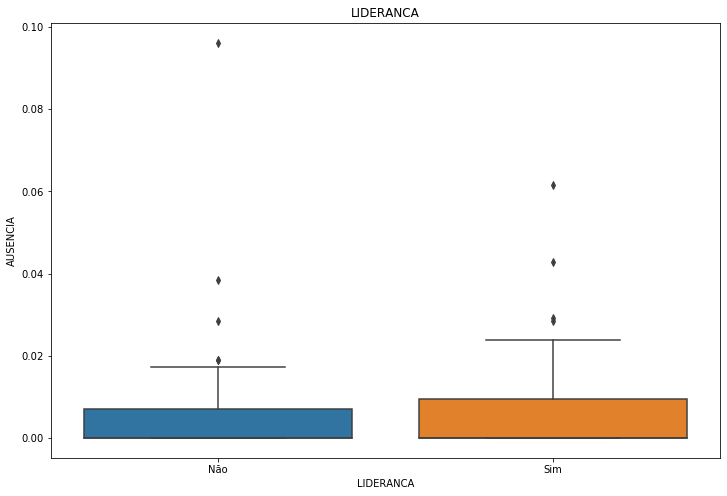

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'mandatos')

Text(0.5, 1.0, 'LIDERANCA')

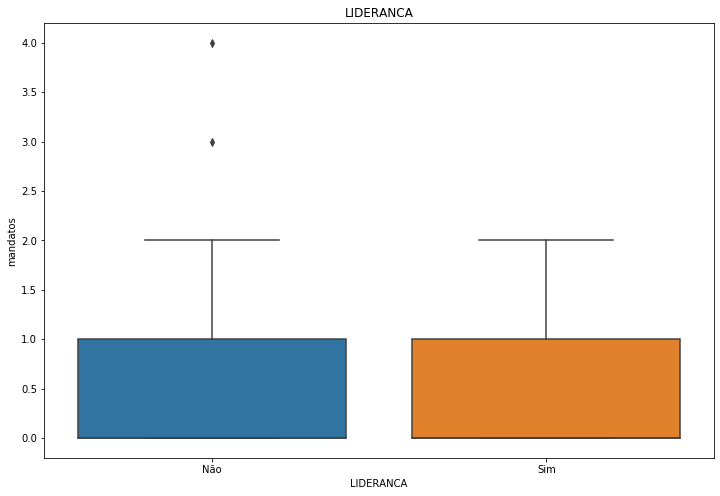

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'cabeças')

Text(0.5, 1.0, 'LIDERANCA')

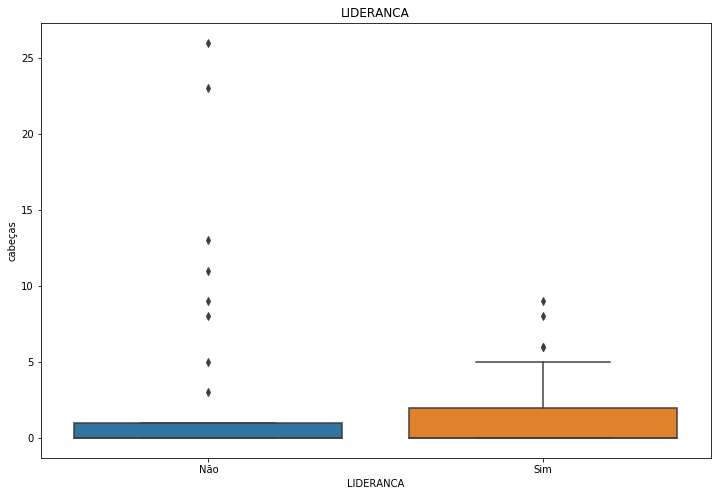

Text(0.5, 0, 'LIDERANCA')

Text(0, 0.5, 'IDADE')

Text(0.5, 1.0, 'LIDERANCA')

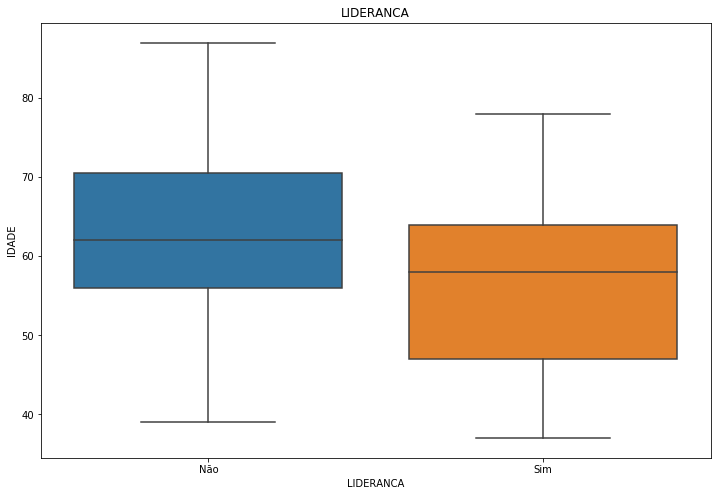

In [50]:
for cat in variaveis_categoricas:
    for num in variaveis_numericas:
        sns.boxplot(x=cat, y=num, data=df)
        plt.xlabel(cat)
        plt.ylabel(num)
        plt.title(cat)
        plt.show()


## Criação das variáveis dummies, categoricas e numéricas para modelo

In [ ]:
variaveis_numericas=variaveis_numericas= list(df.select_dtypes(include=[np.number]).columns)
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_modelo=variaveis_numericas+variaveis_categoricas

df[variaveis_modelo].nunique()

In [ ]:
variaveis_numericas=variaveis_numericas= list(df.select_dtypes(include=[np.number]).columns)
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_modelo=variaveis_numericas+variaveis_categoricas
variaveis_dummy=[]

In [ ]:
#variaveis_categoricas.remove(target[0])
#variaveis_dummy.remove(target[0])
hot_encoding=variaveis_categoricas
hot_encoding

In [ ]:
hot_encoding.remove("debatedor")
hot_encoding.remove("articulador")
hot_encoding.remove("formulador")
hot_encoding.remove("negociador")
hot_encoding

In [ ]:
df_original=df.copy()


In [ ]:
# Trata variaveis binárias (0-1)
#df_original=df.copy()
for variavel in variaveis_dummy:
    df=pd.concat([df, pd.get_dummies(df[variavel].astype(object), prefix=variavel, drop_first=True)], axis=1)
    df.drop(columns=[variavel], inplace=True)
df.sample(5)
df.columns

In [ ]:
#Trata variaveis 
#variaveis_categoricas=list(set(variaveis_categoricas)-set(variaveis_dummy))
for variavel in hot_encoding:
    df=pd.concat([df, pd.get_dummies(df[variavel].astype(object), prefix=variavel,drop_first=True)], axis=1)
    df.drop(columns=[variavel], inplace=True)
#df.sample(5)
df.columns

# Variáveis do modelo

In [ ]:
df.columns

In [ ]:
variaveis_numericas=list(df.select_dtypes(include=[np.number]).columns)
variaveis_numericas
variaveis_categoricas= list(df.select_dtypes(include="category").columns)
variaveis_categoricas
variaveis_modelo=variaveis_numericas+variaveis_categoricas
#df[variaveis_modelo].info()
df.info()

In [ ]:
for variavel in variaveis_categoricas:
    df[variavel]=df[variavel].astype("int")
df.info()

In [ ]:
con = sql.connect("../../dados/sql/base_completa.db")
df.to_sql("senadores_tabela_analise",con,if_exists="replace", index=False, index_label="CPF")
con.close()

In [ ]:
df.columns

In [ ]:
#df[variaveis_modelo].info()
#Variaveis cadastro
#variaveis_modelo.remove("tweets")
#variaveis_modelo.remove("followers_count")
#variaveis_modelo.remove("VL_BENS")
#variaveis_modelo.remove("VR_DESPESA_CONTRATADA")

# variaveis DIAP
#variaveis_modelo.remove("mandatos")
#variaveis_modelo.remove("cabeças")
#variaveis_modelo.remove("formulador")
#variaveis_modelo.remove("debatedor")
#variaveis_modelo.remove("articulador")
#variaveis_modelo.remove("negociador")

# variáveis assiduidade
variaveis_modelo.remove("PRESENCA")
#variaveis_modelo.remove("AUSENCIA")

#Variáveis propostas
#variaveis_modelo.remove("PL")
#variaveis_modelo.remove("PEC")
#variaveis_modelo.remove("REQ")
variaveis_modelo.remove("PROP_TOTAL")

# variáveis cargo
#variaveis_modelo.remove("MESA_Sim")
#variaveis_modelo.remove("LIDERANCA_Sim")

## Escala dos preditores

In [ ]:
def verifica_escala(preditores,df):
    x=df[preditores].values
    plt.plot(x.min(axis=0),"o", label="min")
    plt.plot(x.max(axis=0),"^", label="max")
    plt.legend(loc="best")
    plt.xlabel("Feature index")
    plt.ylabel("Feature magnitude")
    plt.yscale("log")
    print(df[preditores].max().round(3))

In [ ]:
verifica_escala(variaveis_modelo,df)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df[variaveis_modelo].values)
x=scaler.transform(df[variaveis_modelo].values)
df_scaled=pd.DataFrame(x,columns=variaveis_modelo)
df_scaled.head()
#df_original=df.copy()
df=df_scaled.copy()

In [ ]:
df.describe()

## Visualizando com PCA

In [ ]:
x=df.values
variaveis=list(df.columns)

In [ ]:
from sklearn.decomposition import PCA
# keep the first two principal components of the data
pca = PCA(n_components=3)
# fit PCA model 
pca.fit(x)
# transform data onto the first two principal components
x_pca = pca.transform(x)
print("Original shape: {}".format(str(x.shape)))
print("Reduced shape: {}".format(str(x_pca.shape)))
df_pca=pd.DataFrame(x_pca,columns=["PC-1","PC-2","PC-3"])

In [ ]:
# plot first vs. second principal component, colored by class
plt.figure(figsize=(8, 8))
plt.scatter(x_pca[:, 0], x_pca[:, 1])
#plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_pca['PC-1'], df_pca['PC-2'], df_pca['PC-3'], c='skyblue', s=30)
ax.set_xlabel("First principal component")
ax.set_ylabel("Second principal component")
ax.set_zlabel("third principal component")
ax.view_init(20, -120)
plt.show()

In [ ]:
df_pca_componentes=pd.DataFrame(pca.components_, columns=variaveis)
print("PCA component shape: {}".format(df_pca_componentes.shape))
df_pca_componentes
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")
#(correlação,annot=True, vmin=-1, vmax=1)

In [ ]:
def plot_pca_2d(x,y=True):
    plt.figure(figsize=(8, 8))
    if y.all():
        plt.scatter(x[:, 0], x[:, 1])
        plt.gca().set_aspect("equal")
    else:
        clusters = unique(y)
        for cluster in clusters:
            row_ix = where(y == cluster)
            # create scatter of these samples
            plt.scatter(x[row_ix, 0], x[row_ix, 1])
    plt.xlabel("First principal component")
    plt.ylabel("Second principal component")
    plt.legend(clusters, loc="best")
    plt.show()
    if clusters[0]==-1:
        quant=np.bincount(y+1)
    else:
        quant=np.bincount(y)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

In [ ]:
def plot_pca_3d(x,y=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if y.all():
        ax.scatter(x[:, 0], x[:, 1],x[:,2])
        ax.gca().set_aspect("equal")
    else:
        clusters = unique(y)
        for cluster in clusters:
            row_ix = where(y == cluster)
            # create scatter of these samples
            ax.scatter(x[row_ix, 0], x[row_ix, 1],x[row_ix, 2], s=20)
    ax.set_xlabel("PC-1")
    ax.set_ylabel("PC-2")
    ax.set_zlabel("PC-3")
    ax.legend(clusters, loc='upper left')
    ax.view_init(35, -120)
    plt.show()
    if clusters[0]==-1:
        quant=np.bincount(y+1)
    else:
        quant=np.bincount(y)
    frame=pd.DataFrame({"cluster":clusters,"quant":quant})
    print("Número de componentes \n{}".format(frame))
    

## ajustando variáveis

In [ ]:
x=df.values

## K-mean


## Verificando o número de clusters via inércia

In [ ]:
kvalues=range(1,50)
kvalues
inercia=[]
for k in kvalues:
    modelo=KMeans(n_clusters=k, init='k-means++')
    modelo.fit(x)
    inercia.append(modelo.inertia_)
df_inercia=pd.DataFrame({"Inercia":inercia, "K":kvalues}) 
df_inercia.plot("K","Inercia", marker='o')

In [ ]:
# defining the kmeans function with initialization as k-means++
modelo = KMeans(n_clusters=6, init='k-means++')

# fitting the k means algorithm on scaled data
modelo.fit(x)
yhat = modelo.predict(x)
clusters = unique(yhat)
#print(variaveis_modelo)


In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_kmeans=df_original.copy()
df_kmeans["cluster"]=yhat
df_kmeans.sample(5)

## Mean-shift


In [ ]:
from sklearn.cluster import MeanShift
modelo = MeanShift()
# fitting the k means algorithm on scaled data
modelo.fit(x)
yhat = modelo.predict(x)
clusters = unique(yhat)
#print(preditores)
clusters

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_mean_s=df_original.copy()
df_mean_s["cluster"]=yhat
df_mean_s.sample(5)

In [ ]:
## DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
modelo = DBSCAN(eps=0.5, min_samples=3)

In [ ]:
modelo.fit(x)
yhat = modelo.fit_predict(x)
clusters = unique(yhat)
#print(preditores)
clusters

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_dbscan=df_original.copy()
df_dbscan["cluster"]=yhat
df_dbscan.sample(5)

## GMM

In [ ]:
from sklearn.mixture import GaussianMixture
modelo = GaussianMixture(n_components=6)
modelo.fit(x)
yhat = modelo.predict(x)

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
df_GMM=df_original.copy()
df_GMM["cluster"]=yhat
df_GMM.sample(5)

## Aglomerative H Cluster

In [ ]:
from sklearn.cluster import AgglomerativeClustering
modelo = AgglomerativeClustering(n_clusters=5)
yhat = modelo.fit_predict(x)
clusters = unique(yhat)

In [ ]:
plot_pca_2d(x_pca,yhat)
plot_pca_3d(x_pca,yhat)
plt.figure(figsize=(12, 2))
sns.heatmap(df_pca_componentes,annot=True, cmap="RdBu")


In [ ]:
#df_HC=df_original.copy()
df_HC=df.copy()
df_HC["cluster"]=yhat
df_HC.sample(5)

## creating a distance matrix using linkage

In [ ]:
# Import the fcluster and linkage functions
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

# Use the linkage() function
distance_matrix = linkage(x,method = 'ward', metric = 'euclidean') # method = 'single'/'complete'

# Assign cluster labels
#comic_con['cluster_labels'] = fcluster(distance_matrix, 2, criterion='maxclust')
dendrogram(distance_matrix)

In [ ]:
#dendrogram(distance_matrix)
# Use fcluster to extract labels: labels
clusters = fcluster(distance_matrix, 1.6, criterion='distance' )
df_ch=df_original.copy()
df_ch["cluster"]=clusters
df_ch.head(5)

# Avaliação com ARI Adjusted Rand Score Index

In [ ]:
# adjusted rand score is 1, as the clustering is exactly the same
# df_kmeans, df_mean_s, df_dbscan, df_GMM, df_HC, df_ch

In [ ]:
from sklearn.metrics import adjusted_rand_score
target=df_HC
lista=[df_kmeans,df_mean_s,df_dbscan,df_GMM,df_HC,df_ch]

for df in lista:
    print("ARI: {:.2f}".format(adjusted_rand_score(target["cluster"].values, df["cluster"].values)))


## EDA com K-mean

In [ ]:
df=df_HC.copy()

## EDA Básico

In [ ]:
df.info()
df.describe().round(2)

In [ ]:
#df.fillna(0, inplace=True)
#df.info()

In [ ]:
df.describe(include=np.object)

In [ ]:
df.info()
unicos=df.nunique()
unicos

## Defindo variaveis categóricas numericas

In [ ]:
def analisa_variaveis(df,variaveis,nunicas):
    lista=[]
    unicos=df[variaveis].nunique()
    for variavel in unicos.index:
        quant=unicos.loc[variavel]
        if quant <= nunicas:
            lista.append(variavel)
            print("Variavel {}, {} ocorrências únicas".format(variavel,quant))
            print(df[variavel].sort_values().unique())
    return lista

In [ ]:
variaveis_numericas= df.select_dtypes(include=[np.number]).columns
variaveis_categoricas= df.select_dtypes(include="category").columns
df[variaveis_numericas].info()
df[variaveis_categoricas].info()

In [ ]:
variaveis_objeto=df.select_dtypes(include="object").columns
df[variaveis_objeto].info()

### Histogramas

In [ ]:
for variavel in variaveis_categoricas:
    df[variavel].value_counts().plot(kind="bar")
    plt.xlabel(variavel)
    plt.ylabel("Contagem")
    plt.title(variavel)
    plt.show()

### Boxplots - Identificando, verificando e tratando outliers


In [ ]:
for cat in variaveis_categoricas:
    for num in variaveis_numericas:
        sns.boxplot(x=cat, y=num, data=df)
        plt.xlabel(cat)
        plt.ylabel(num)
        plt.title(cat)
        plt.show()


In [ ]:
df.info()

In [ ]:
variaveis=list(variaveis_numericas)+list(variaveis_categoricas)
variaveis.remove("cluster")
preditores=variaveis
target=["cluster"]
variaveis=["cluster"]+variaveis
variaveis

In [ ]:

df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")
df["cluster"]=df["cluster"].astype("int")

correlação=df[variaveis].corr()
correlação
plt.rc('figure', figsize=(12, 8))
sns.heatmap(correlação,annot=True, vmin=-1, vmax=1)

In [ ]:
sns.pairplot(df[variaveis], kind="scatter")

In [ ]:
sns.pairplot(df, y_vars=target, x_vars=preditores, hue=target[0])